# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# %matplotlib inline 
# %matplotlib notebook

# Directory to save logs and trained model
# MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# MODEL_DIR ="/storage/data/marziehhaghighi/DL_trained_models/mrcnn/logs"
MODEL_Root_DIR ="/storage/data/marziehhaghighi/DL_trained_models/mrcnn/"

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [4]:
a=np.array([0,1,2,3])
a[a>0]

array([1, 2, 3])

In [2]:
# import tensorflow as tf
# tf.compat.v1.disable_eager_execution()

In [3]:
# tf.compat.v1.disable_eager_execution()

In [5]:
config.assign_label_mode[0:5]

'class'

## Configurations

In [3]:
class SpotsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes_spotForm"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 16

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 4 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
#     IMAGE_SHAPE=1024
    
    IMAGE_MIN_DIM = 256#128
    IMAGE_MAX_DIM = 256#128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
#     n_clusters=5
    
    FPN_CLASSIF_FC_LAYERS_SIZE=1024;
    
config = SpotsConfig()
config.display()

# use of pretrained models --> "imagenet","coco","scratch","last"
init_with = "scratch"
# layers to train --> "all" , "heads"
layers_to_tune="all"

lr=config.LEARNING_RATE
config.assign_label_mode ="clustering"#"clustering","classification"

fileNumModel='pretrained_'+init_with+'_train_'+layers_to_tune+'_lr_'+str(lr)+'_'+config.assign_label_mode[0:5];
MODEL_DIR = MODEL_Root_DIR + config.NAME+'/'+fileNumModel


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 16
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

In [11]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import matthews_corrcoef
print(normalized_mutual_info_score([1, 1, 0, 0], [0, 0, 1, 1]).astype('float32'))
print(matthews_corrcoef([1, 1, 0, 0], [0, 0, 1, 1]))

1.0
-1.0


In [36]:
# normalized_mutual_info_score([1,1], [1,0]).dtype
np.float32(1)

1.0

In [9]:
A=np.array([1, 4, 0, 0,5,0])
B=np.array([1, 5, 0, 0])
# A.shape
# B=np.zeros(A.shape)

In [11]:
A+1

array([2, 5, 1, 1, 6, 1])

In [10]:
non_zero_ind=np.where(A!=0)[0]
zero_ind=np.where(A==0)[0]
non_zero_ind, zero_ind

(array([0, 1, 4]), array([2, 3, 5]))

In [32]:
A1=A[A!=0]
A1

array([1, 4, 5])

In [3]:
# np.insert(A1, zero_ind, 0)

In [3]:
# import sklearn
# sklearn.metrics.consensus_score(A, B)

In [4]:
A=[1, 4, 0, 0]
B=[1, 5, 0, 0]
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('hamming')
X = [A,B]
dist.pairwise(X)[0,1]

0.25

In [44]:
dist.pairwise(X)

array([[0. , 0.5],
       [0.5, 0. ]])

In [10]:
a = np.array([1,2,3])
my_dict = {1:23, 2:34, 3:36, 4:45}
np.vectorize(my_dict.get)(a)


array([23, 34, 36])

In [42]:
dist.dist_to_rdist(X)

[[1, 2, 0, 0], [0, 0, 0, 0]]

In [31]:
matthews_corrcoef([1, 2, 0, 0], [0, 0, 0, 0])

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.0

## Notebook Preferences

In [7]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")
        self.add_class("shapes", 4, "ellipse")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)
            
    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
#             print("color",color)
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        elif shape == "ellipse":
#             cv2.ellipse(mask, (x, y), (ax, ay), angle, 0, 360, 255, -1)
            cv2.ellipse(image, (x, y), (s,2*s),45,0, 360, color, -1)
            
            
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle", "ellipse"])
#         shape = random.choice(["square", "circle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 4
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
#         s = random.randint(buffer, height//4)
#         print(buffer, int(height//20))
        s = random.randint(buffer, 7)
#         print(s)
        return shape, color, (x, y, s)
    

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(10, 30)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
#         keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.01)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes
    

In [5]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

In [7]:
# dataset_val.image_ids
# dataset_train.image_info

In [28]:
dataset_val.source_class_ids

{'': [0], 'shapes': [0, 1, 2, 3]}

In [24]:
dataset_train.class_from_source_map

{'.0': 0, 'shapes.1': 1, 'shapes.2': 2, 'shapes.3': 3}

In [44]:
list(np.array([0,0,0]))==list(np.array([0,0,0]))

True

In [11]:
image.dtype,mask.dtype

(dtype('uint8'), dtype('bool'))

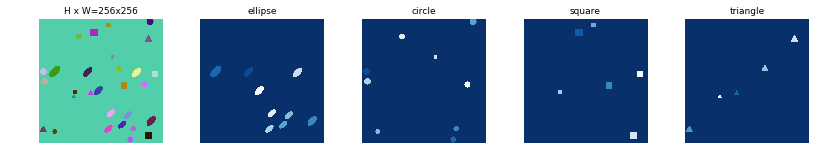

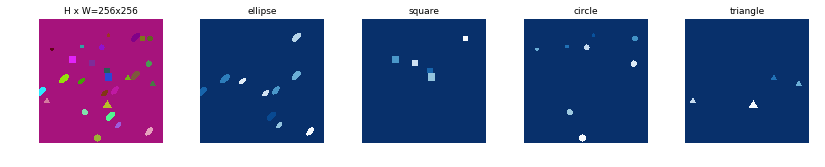

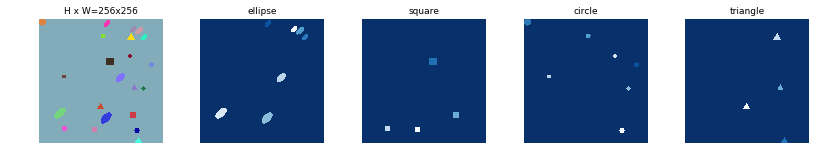

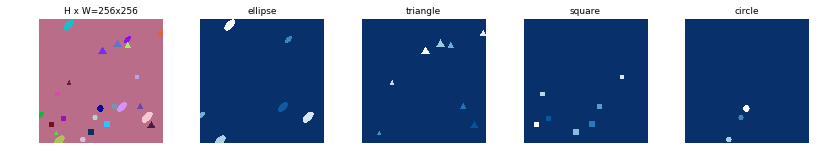

In [10]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [15]:
# Create model in training mode
config.head='def'
config.assign_label_mode ="classification"#"clustering","classification"
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

gt_class_ids Tensor("input_gt_class_ids_1:0", shape=(?, ?), dtype=int32)
target_class_ids Tensor("proposal_targets_1/target_class_ids:0", shape=(16, ?), dtype=int32)
shared Tensor("pool_squeeze_1/Squeeze_1:0", shape=(?, 32, 1024), dtype=float32)
mrcnn_class_logits Tensor("mrcnn_class_logits_1/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
mrcnn_class_logits Tensor("mrcnn_class_logits_1/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
mrcnn_class Tensor("mrcnn_class_1/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
pred_class_logits Tensor("mrcnn_class_logits_1/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
pred_class_ids (?, 32)
target_class_ids (16, ?)
pred_class_logits Tensor("mrcnn_class_loss_1/Placeholder_1:0", shape=(?, 32, 5), dtype=float32)
pred_class_ids (?, 32)
target_class_ids (?, 32)


In [12]:
# Create model in training mode
config.head='def'
config.assign_label_mode ="clustering"#"clustering","classification"
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [8]:
# # Create model in training mode
# config.head='def'
# config.assign_label_mode ="clustering"#"clustering","classification"
# model = modellib.MaskRCNN(mode="training", config=config,
#                           model_dir=MODEL_DIR)

In [29]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit_transform([3,2,4,3,10]).shape

(5, 4)

In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last
# init_with = "last"

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [11]:
# Checkpoint Path:  /deepmatter/mask_rcnn/logs/shapes2017102802/mask_rcnn_{epoch:04d}.h5
# dataset_train.

### Parametrized Training

In [5]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)


model.train(dataset_train, dataset_val, 
            learning_rate=lr ,#/ 10,
            epochs=100, 
            layers=layers_to_tune)

gt_class_ids Tensor("input_gt_class_ids:0", shape=(?, ?), dtype=int32)
target_class_ids Tensor("proposal_targets/target_class_ids:0", shape=(16, ?), dtype=int32)
shared Tensor("pool_squeeze/Squeeze_1:0", shape=(?, 32, 1024), dtype=float32)
mrcnn_class_logits2 Tensor("Slice:0", shape=(?, 32, 4), dtype=float32)
pred_class_ids Tensor("pred_4_lambda_layer:0", shape=(?, 32), dtype=int64)


/home/marziehhaghighi/.local/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


mrcnn_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
mrcnn_class Tensor("mrcnn_class/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
pred_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
pred_class_ids (?, 32)
target_class_ids (?, 32)
pred_class_logits Tensor("mrcnn_class_loss/Placeholder_1:0", shape=(?, 32, 5), dtype=float32)
pred_class_ids (?, 32)
target_class_ids (?, 32)

Starting at epoch 0. LR=0.001

Checkpoint Path: /storage/data/marziehhaghighi/DL_trained_models/mrcnn/shapes_spotForm/pretrained_scratch_train_all_lr_0.001_clust/shapes_spotform20200806T0050/mask_rcnn_shapes_spotform_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c         

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100
[[1 2]]
psudo labels [[1 2]]
  1/100 [..............................] - ETA: 2:06:51 - loss: 38.9923 - rpn_class_loss: 10.0224 - rpn_bbox_loss: 16.9901 - mrcnn_class_loss: 0.8741 - mrcnn_bbox_loss: 9.3099 - mrcnn_mask_loss: 1.7956 - lambda_nmi: 0.9509[[1 2]
 [4 1]]
psudo labels [[1 2]
 [4 1]]
  2/100 [..............................] - ETA: 1:03:44 - loss: 36.9916 - rpn_class_loss: 9.1337 - rpn_bbox_loss: 16.6327 - mrcnn_class_loss: 0.6540 - mrcnn_bbox_loss: 9.0813 - mrcnn_mask_loss: 1.4899 - lambda_nmi: 0.9514 [[1 1]
 [2 1]]
psudo labels [[1 1]
 [2 1]]
  3/100 [..............................] - ETA: 42:33 - loss: 33.7647 - rpn_class_loss: 7.8525 - rpn_bbox_loss: 16.0281 - mrcnn_class_loss: 0.4961 - mrcnn_bbox_loss: 8.0660 - mrcnn_mask_loss: 1.3220 - lambda_nmi: 0.9512  [[1 4]]
psudo labels [[1 4]]
  4/100 [>.............................] - ETA: 32:02 - loss: 30.2005 - rpn_class_loss: 6.6401 - rpn_bbox_loss: 15.3049 - mrcnn_class_loss: 0.4210 - mrcnn_bbox_loss: 6.5569 - mrcn

 56/100 [===============>..............] - ETA: 1:48 - loss: 9.2309 - rpn_class_loss: 1.1391 - rpn_bbox_loss: 4.1551 - mrcnn_class_loss: 0.6577 - mrcnn_bbox_loss: 2.3961 - mrcnn_mask_loss: 0.8828 - lambda_nmi: 0.7309[[ 1 23]
 [ 2 48]
 [ 3 47]
 [ 4 42]]
psudo labels [[ 1 23]
 [ 2 36]
 [ 3 54]
 [ 4 47]]
 57/100 [================>.............] - ETA: 1:45 - loss: 9.1248 - rpn_class_loss: 1.1222 - rpn_bbox_loss: 4.0962 - mrcnn_class_loss: 0.6590 - mrcnn_bbox_loss: 2.3680 - mrcnn_mask_loss: 0.8795 - lambda_nmi: 0.7287[[ 1 10]
 [ 2 35]
 [ 3 60]
 [ 4 55]]
psudo labels [[ 1 55]
 [ 2 43]
 [ 3 30]
 [ 4 32]]
 58/100 [================>.............] - ETA: 1:42 - loss: 9.0231 - rpn_class_loss: 1.1058 - rpn_bbox_loss: 4.0385 - mrcnn_class_loss: 0.6619 - mrcnn_bbox_loss: 2.3407 - mrcnn_mask_loss: 0.8762 - lambda_nmi: 0.7266[[ 1 15]
 [ 2 30]
 [ 3 49]
 [ 4 66]]
psudo labels [[ 1 43]
 [ 2 42]
 [ 3 32]
 [ 4 43]]
 59/100 [================>.............] - ETA: 1:38 - loss: 8.9219 - rpn_class_loss: 1.089

  8/100 [=>............................] - ETA: 1:46 - loss: 2.9688 - rpn_class_loss: 0.1380 - rpn_bbox_loss: 0.8507 - mrcnn_class_loss: 0.7099 - mrcnn_bbox_loss: 0.6115 - mrcnn_mask_loss: 0.6587 - lambda_nmi: 0.6052[[ 1 37]
 [ 2 53]
 [ 3 38]
 [ 4 32]]
psudo labels [[ 1 36]
 [ 2 52]
 [ 3 42]
 [ 4 30]]
  9/100 [=>............................] - ETA: 1:46 - loss: 2.9330 - rpn_class_loss: 0.1369 - rpn_bbox_loss: 0.8304 - mrcnn_class_loss: 0.7094 - mrcnn_bbox_loss: 0.5979 - mrcnn_mask_loss: 0.6585 - lambda_nmi: 0.6052[[ 1 50]
 [ 2 56]
 [ 3 33]
 [ 4 21]]
psudo labels [[ 1 29]
 [ 2 49]
 [ 3 33]
 [ 4 49]]
 10/100 [==>...........................] - ETA: 1:44 - loss: 2.9094 - rpn_class_loss: 0.1357 - rpn_bbox_loss: 0.8175 - mrcnn_class_loss: 0.7082 - mrcnn_bbox_loss: 0.5889 - mrcnn_mask_loss: 0.6592 - lambda_nmi: 0.6085[[ 1 47]
 [ 2 47]
 [ 3 49]
 [ 4 17]]
psudo labels [[ 1 51]
 [ 2 25]
 [ 3 38]
 [ 4 46]]
 11/100 [==>...........................] - ETA: 1:44 - loss: 2.8839 - rpn_class_loss: 0.134

 62/100 [=================>............] - ETA: 44s - loss: 2.4674 - rpn_class_loss: 0.1133 - rpn_bbox_loss: 0.5480 - mrcnn_class_loss: 0.6663 - mrcnn_bbox_loss: 0.4908 - mrcnn_mask_loss: 0.6490 - lambda_nmi: 0.6101[[ 1  8]
 [ 2 75]
 [ 3 23]
 [ 4 54]]
psudo labels [[ 1 47]
 [ 2 38]
 [ 3 41]
 [ 4 34]]
 63/100 [=================>............] - ETA: 43s - loss: 2.4743 - rpn_class_loss: 0.1136 - rpn_bbox_loss: 0.5539 - mrcnn_class_loss: 0.6664 - mrcnn_bbox_loss: 0.4912 - mrcnn_mask_loss: 0.6492 - lambda_nmi: 0.6104[[ 1 18]
 [ 2 72]
 [ 3 29]
 [ 4 41]]
psudo labels [[ 1 40]
 [ 2 45]
 [ 3 44]
 [ 4 31]]
 64/100 [==================>...........] - ETA: 42s - loss: 2.4678 - rpn_class_loss: 0.1131 - rpn_bbox_loss: 0.5501 - mrcnn_class_loss: 0.6656 - mrcnn_bbox_loss: 0.4899 - mrcnn_mask_loss: 0.6491 - lambda_nmi: 0.6103[[ 1 18]
 [ 2 60]
 [ 3 44]
 [ 4 38]]
psudo labels [[ 1 42]
 [ 2 43]
 [ 3 35]
 [ 4 40]]
 65/100 [==================>...........] - ETA: 40s - loss: 2.4710 - rpn_class_loss: 0.1133 - 

 14/100 [===>..........................] - ETA: 1:38 - loss: 2.0587 - rpn_class_loss: 0.0940 - rpn_bbox_loss: 0.3669 - mrcnn_class_loss: 0.6074 - mrcnn_bbox_loss: 0.3634 - mrcnn_mask_loss: 0.6269 - lambda_nmi: 0.6137[[ 1  6]
 [ 2 41]
 [ 3 62]
 [ 4 51]]
psudo labels [[ 1 28]
 [ 2 41]
 [ 3 46]
 [ 4 45]]
 15/100 [===>..........................] - ETA: 1:36 - loss: 2.0447 - rpn_class_loss: 0.0933 - rpn_bbox_loss: 0.3579 - mrcnn_class_loss: 0.6044 - mrcnn_bbox_loss: 0.3623 - mrcnn_mask_loss: 0.6269 - lambda_nmi: 0.6130[[ 1  8]
 [ 2 50]
 [ 3 70]
 [ 4 32]]
psudo labels [[ 1 41]
 [ 2 46]
 [ 3 43]
 [ 4 30]]
 16/100 [===>..........................] - ETA: 1:35 - loss: 2.0317 - rpn_class_loss: 0.0926 - rpn_bbox_loss: 0.3490 - mrcnn_class_loss: 0.6044 - mrcnn_bbox_loss: 0.3591 - mrcnn_mask_loss: 0.6266 - lambda_nmi: 0.6123[[ 1 11]
 [ 2 70]
 [ 3 64]
 [ 4 15]]
psudo labels [[ 1 45]
 [ 2 32]
 [ 3 42]
 [ 4 41]]
 17/100 [====>.........................] - ETA: 1:34 - loss: 2.0234 - rpn_class_loss: 0.091

 68/100 [===================>..........] - ETA: 36s - loss: 2.0139 - rpn_class_loss: 0.0890 - rpn_bbox_loss: 0.3749 - mrcnn_class_loss: 0.5884 - mrcnn_bbox_loss: 0.3438 - mrcnn_mask_loss: 0.6178 - lambda_nmi: 0.6120[[ 1 31]
 [ 2 46]
 [ 3 34]
 [ 4 49]]
psudo labels [[ 1 51]
 [ 2 38]
 [ 3 38]
 [ 4 33]]
 69/100 [===================>..........] - ETA: 35s - loss: 2.0138 - rpn_class_loss: 0.0889 - rpn_bbox_loss: 0.3743 - mrcnn_class_loss: 0.5884 - mrcnn_bbox_loss: 0.3445 - mrcnn_mask_loss: 0.6176 - lambda_nmi: 0.6120[[ 1 40]
 [ 2 57]
 [ 3 28]
 [ 4 35]]
psudo labels [[ 1 30]
 [ 2 36]
 [ 3 48]
 [ 4 46]]
 70/100 [====================>.........] - ETA: 34s - loss: 2.0132 - rpn_class_loss: 0.0888 - rpn_bbox_loss: 0.3738 - mrcnn_class_loss: 0.5887 - mrcnn_bbox_loss: 0.3445 - mrcnn_mask_loss: 0.6174 - lambda_nmi: 0.6121[[ 1 44]
 [ 2 56]
 [ 3 33]
 [ 4 27]]
psudo labels [[ 1 35]
 [ 2 45]
 [ 3 40]
 [ 4 40]]
 71/100 [====================>.........] - ETA: 33s - loss: 2.0110 - rpn_class_loss: 0.0887 - 

 20/100 [=====>........................] - ETA: 1:35 - loss: 1.7831 - rpn_class_loss: 0.0750 - rpn_bbox_loss: 0.2594 - mrcnn_class_loss: 0.5667 - mrcnn_bbox_loss: 0.3029 - mrcnn_mask_loss: 0.5792 - lambda_nmi: 0.6152[[ 1 44]
 [ 2 42]
 [ 3 32]
 [ 4 42]]
psudo labels [[ 1 38]
 [ 2 30]
 [ 3 41]
 [ 4 51]]
 21/100 [=====>........................] - ETA: 1:33 - loss: 1.7756 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 0.2547 - mrcnn_class_loss: 0.5664 - mrcnn_bbox_loss: 0.3009 - mrcnn_mask_loss: 0.5790 - lambda_nmi: 0.6155[[ 1 35]
 [ 2 17]
 [ 3 54]
 [ 4 54]]
psudo labels [[ 1 38]
 [ 2 36]
 [ 3 50]
 [ 4 36]]
 22/100 [=====>........................] - ETA: 1:32 - loss: 1.7929 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 0.2694 - mrcnn_class_loss: 0.5663 - mrcnn_bbox_loss: 0.3024 - mrcnn_mask_loss: 0.5795 - lambda_nmi: 0.6160[[ 1 34]
 [ 2 20]
 [ 3 49]
 [ 4 57]]
psudo labels [[ 1 45]
 [ 2 32]
 [ 3 44]
 [ 4 39]]
 23/100 [=====>........................] - ETA: 1:31 - loss: 1.8038 - rpn_class_loss: 0.075

 74/100 [=====================>........] - ETA: 29s - loss: 1.7798 - rpn_class_loss: 0.0763 - rpn_bbox_loss: 0.2947 - mrcnn_class_loss: 0.5599 - mrcnn_bbox_loss: 0.2849 - mrcnn_mask_loss: 0.5640 - lambda_nmi: 0.6151[[ 1 14]
 [ 2 23]
 [ 3 94]
 [ 4 29]]
psudo labels [[ 1 24]
 [ 2 42]
 [ 3 42]
 [ 4 52]]
 75/100 [=====================>........] - ETA: 28s - loss: 1.7771 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 0.2932 - mrcnn_class_loss: 0.5600 - mrcnn_bbox_loss: 0.2841 - mrcnn_mask_loss: 0.5637 - lambda_nmi: 0.6151[[ 1  5]
 [ 2 37]
 [ 3 69]
 [ 4 49]]
psudo labels [[ 1 33]
 [ 2 35]
 [ 3 40]
 [ 4 52]]
 76/100 [=====================>........] - ETA: 27s - loss: 1.7739 - rpn_class_loss: 0.0760 - rpn_bbox_loss: 0.2916 - mrcnn_class_loss: 0.5593 - mrcnn_bbox_loss: 0.2835 - mrcnn_mask_loss: 0.5633 - lambda_nmi: 0.6153[[ 1  3]
 [ 2 43]
 [ 3 43]
 [ 4 71]]
psudo labels [[ 1 37]
 [ 2 32]
 [ 3 42]
 [ 4 49]]
 77/100 [======================>.......] - ETA: 26s - loss: 1.7696 - rpn_class_loss: 0.0759 - 

[[ 1 11]
 [ 2 47]
 [ 3 50]
 [ 4 52]]
psudo labels [[ 1 53]
 [ 2 35]
 [ 3 41]
 [ 4 31]]
100/100 [==============================] - 118s 1s/step - loss: 1.7716 - rpn_class_loss: 0.0770 - rpn_bbox_loss: 0.2984 - mrcnn_class_loss: 0.5611 - mrcnn_bbox_loss: 0.2800 - mrcnn_mask_loss: 0.5551 - lambda_nmi: 0.6149 - val_loss: 1.9375 - val_rpn_class_loss: 0.0736 - val_rpn_bbox_loss: 0.4955 - val_mrcnn_class_loss: 0.5505 - val_mrcnn_bbox_loss: 0.2920 - val_mrcnn_mask_loss: 0.5259 - val_lambda_nmi: 0.6147
Epoch 5/100
[[ 1 16]
 [ 2 41]
 [ 3 69]
 [ 4 34]]
psudo labels [[ 1 32]
 [ 2 46]
 [ 3 39]
 [ 4 43]]
  1/100 [..............................] - ETA: 1:49 - loss: 1.7052 - rpn_class_loss: 0.0791 - rpn_bbox_loss: 0.2554 - mrcnn_class_loss: 0.5575 - mrcnn_bbox_loss: 0.2802 - mrcnn_mask_loss: 0.5329 - lambda_nmi: 0.6155[[ 1 20]
 [ 2 53]
 [ 3 60]
 [ 4 27]]
psudo labels [[ 1 43]
 [ 2 38]
 [ 3 38]
 [ 4 41]]
  2/100 [..............................] - ETA: 1:48 - loss: 1.6612 - rpn_class_loss: 0.0786 - rpn_

 53/100 [==============>...............] - ETA: 53s - loss: 1.6315 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 0.2518 - mrcnn_class_loss: 0.5468 - mrcnn_bbox_loss: 0.2630 - mrcnn_mask_loss: 0.5039 - lambda_nmi: 0.6197[[ 1 79]
 [ 2 17]
 [ 3 52]
 [ 4 12]]
psudo labels [[ 1 45]
 [ 2 40]
 [ 3 34]
 [ 4 41]]
 54/100 [===============>..............] - ETA: 52s - loss: 1.6321 - rpn_class_loss: 0.0658 - rpn_bbox_loss: 0.2536 - mrcnn_class_loss: 0.5464 - mrcnn_bbox_loss: 0.2630 - mrcnn_mask_loss: 0.5033 - lambda_nmi: 0.6199[[ 1 84]
 [ 2 12]
 [ 3 45]
 [ 4 19]]
psudo labels [[ 1 47]
 [ 2 41]
 [ 3 35]
 [ 4 37]]
 55/100 [===============>..............] - ETA: 50s - loss: 1.6336 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 0.2550 - mrcnn_class_loss: 0.5469 - mrcnn_bbox_loss: 0.2630 - mrcnn_mask_loss: 0.5029 - lambda_nmi: 0.6203[[  1 101]
 [  2  14]
 [  3  31]
 [  4  14]]
psudo labels [[ 1 46]
 [ 2 35]
 [ 3 32]
 [ 4 47]]
 56/100 [===============>..............] - ETA: 49s - loss: 1.6348 - rpn_class_loss: 0

  5/100 [>.............................] - ETA: 1:49 - loss: 1.3587 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 0.1568 - mrcnn_class_loss: 0.4787 - mrcnn_bbox_loss: 0.2107 - mrcnn_mask_loss: 0.4526 - lambda_nmi: 0.6140[[ 1 17]
 [ 2 55]
 [ 3 51]
 [ 4 37]]
psudo labels [[ 1 44]
 [ 2 29]
 [ 3 38]
 [ 4 49]]
  6/100 [>.............................] - ETA: 1:50 - loss: 1.3681 - rpn_class_loss: 0.0596 - rpn_bbox_loss: 0.1539 - mrcnn_class_loss: 0.4886 - mrcnn_bbox_loss: 0.2123 - mrcnn_mask_loss: 0.4537 - lambda_nmi: 0.6131[[ 1 22]
 [ 2 49]
 [ 3 50]
 [ 4 39]]
psudo labels [[ 1 29]
 [ 2 49]
 [ 3 32]
 [ 4 50]]
  7/100 [=>............................] - ETA: 1:49 - loss: 1.3678 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 0.1505 - mrcnn_class_loss: 0.4912 - mrcnn_bbox_loss: 0.2140 - mrcnn_mask_loss: 0.4528 - lambda_nmi: 0.6138[[ 1 25]
 [ 2 56]
 [ 3 37]
 [ 4 42]]
psudo labels [[ 1 38]
 [ 2 34]
 [ 3 36]
 [ 4 52]]
  8/100 [=>............................] - ETA: 1:48 - loss: 1.3692 - rpn_class_loss: 0.058

 59/100 [================>.............] - ETA: 46s - loss: 1.4669 - rpn_class_loss: 0.0601 - rpn_bbox_loss: 0.2501 - mrcnn_class_loss: 0.4863 - mrcnn_bbox_loss: 0.2367 - mrcnn_mask_loss: 0.4336 - lambda_nmi: 0.6200[[ 1 58]
 [ 2 35]
 [ 3 26]
 [ 4 41]]
psudo labels [[ 1 42]
 [ 2 38]
 [ 3 44]
 [ 4 36]]
 60/100 [=================>............] - ETA: 45s - loss: 1.4657 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 0.2493 - mrcnn_class_loss: 0.4867 - mrcnn_bbox_loss: 0.2365 - mrcnn_mask_loss: 0.4331 - lambda_nmi: 0.6204[[ 1 37]
 [ 2 38]
 [ 3 35]
 [ 4 50]]
psudo labels [[ 1 48]
 [ 2 43]
 [ 3 33]
 [ 4 36]]
 61/100 [=================>............] - ETA: 44s - loss: 1.4650 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 0.2484 - mrcnn_class_loss: 0.4873 - mrcnn_bbox_loss: 0.2366 - mrcnn_mask_loss: 0.4329 - lambda_nmi: 0.6202[[ 1 39]
 [ 2 29]
 [ 3 45]
 [ 4 47]]
psudo labels [[ 1 47]
 [ 2 31]
 [ 3 41]
 [ 4 41]]
 62/100 [=================>............] - ETA: 43s - loss: 1.4638 - rpn_class_loss: 0.0598 - 

 11/100 [==>...........................] - ETA: 1:41 - loss: 1.4261 - rpn_class_loss: 0.0555 - rpn_bbox_loss: 0.2355 - mrcnn_class_loss: 0.5220 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.3907 - lambda_nmi: 0.6172[[ 1 16]
 [ 2 42]
 [ 3 78]
 [ 4 24]]
psudo labels [[ 1 33]
 [ 2 39]
 [ 3 51]
 [ 4 37]]
 12/100 [==>...........................] - ETA: 1:40 - loss: 1.4080 - rpn_class_loss: 0.0550 - rpn_bbox_loss: 0.2255 - mrcnn_class_loss: 0.5160 - mrcnn_bbox_loss: 0.2213 - mrcnn_mask_loss: 0.3901 - lambda_nmi: 0.6172[[ 1 11]
 [ 2 37]
 [ 3 87]
 [ 4 25]]
psudo labels [[ 1 43]
 [ 2 46]
 [ 3 38]
 [ 4 33]]
 13/100 [==>...........................] - ETA: 1:39 - loss: 1.4217 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 0.2347 - mrcnn_class_loss: 0.5185 - mrcnn_bbox_loss: 0.2243 - mrcnn_mask_loss: 0.3888 - lambda_nmi: 0.6181[[ 1 16]
 [ 2 37]
 [ 3 76]
 [ 4 31]]
psudo labels [[ 1 26]
 [ 2 36]
 [ 3 43]
 [ 4 55]]
 14/100 [===>..........................] - ETA: 1:37 - loss: 1.4366 - rpn_class_loss: 0.055

 65/100 [==================>...........] - ETA: 40s - loss: 1.3813 - rpn_class_loss: 0.0534 - rpn_bbox_loss: 0.2280 - mrcnn_class_loss: 0.5002 - mrcnn_bbox_loss: 0.2200 - mrcnn_mask_loss: 0.3796 - lambda_nmi: 0.6223[[ 1 53]
 [ 2 36]
 [ 3 33]
 [ 4 38]]
psudo labels [[ 1 38]
 [ 2 35]
 [ 3 44]
 [ 4 43]]
 66/100 [==================>...........] - ETA: 39s - loss: 1.3778 - rpn_class_loss: 0.0533 - rpn_bbox_loss: 0.2264 - mrcnn_class_loss: 0.4991 - mrcnn_bbox_loss: 0.2196 - mrcnn_mask_loss: 0.3795 - lambda_nmi: 0.6223[[ 1 33]
 [ 2 39]
 [ 3 38]
 [ 4 50]]
psudo labels [[ 1 39]
 [ 2 45]
 [ 3 23]
 [ 4 53]]
 67/100 [===================>..........] - ETA: 38s - loss: 1.3735 - rpn_class_loss: 0.0532 - rpn_bbox_loss: 0.2247 - mrcnn_class_loss: 0.4973 - mrcnn_bbox_loss: 0.2189 - mrcnn_mask_loss: 0.3794 - lambda_nmi: 0.6224[[ 1 24]
 [ 2 31]
 [ 3 52]
 [ 4 53]]
psudo labels [[ 1 38]
 [ 2 33]
 [ 3 43]
 [ 4 46]]
 68/100 [===================>..........] - ETA: 37s - loss: 1.3682 - rpn_class_loss: 0.0530 - 

 17/100 [====>.........................] - ETA: 1:32 - loss: 1.4455 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 0.2926 - mrcnn_class_loss: 0.5197 - mrcnn_bbox_loss: 0.2195 - mrcnn_mask_loss: 0.3560 - lambda_nmi: 0.6315[[ 1 43]
 [ 2 46]
 [ 3 17]
 [ 4 54]]
psudo labels [[ 1 31]
 [ 2 57]
 [ 3 31]
 [ 4 41]]
 18/100 [====>.........................] - ETA: 1:31 - loss: 1.4398 - rpn_class_loss: 0.0577 - rpn_bbox_loss: 0.2898 - mrcnn_class_loss: 0.5183 - mrcnn_bbox_loss: 0.2186 - mrcnn_mask_loss: 0.3554 - lambda_nmi: 0.6305[[ 1 24]
 [ 2 64]
 [ 3 16]
 [ 4 56]]
psudo labels [[ 1 40]
 [ 2 44]
 [ 3 38]
 [ 4 38]]
 19/100 [====>.........................] - ETA: 1:30 - loss: 1.4297 - rpn_class_loss: 0.0577 - rpn_bbox_loss: 0.2854 - mrcnn_class_loss: 0.5152 - mrcnn_bbox_loss: 0.2167 - mrcnn_mask_loss: 0.3547 - lambda_nmi: 0.6297[[ 1 25]
 [ 2 73]
 [ 3 12]
 [ 4 50]]
psudo labels [[ 1 32]
 [ 2 37]
 [ 3 44]
 [ 4 47]]
 20/100 [=====>........................] - ETA: 1:29 - loss: 1.4224 - rpn_class_loss: 0.057

 71/100 [====================>.........] - ETA: 33s - loss: 1.3620 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 0.2433 - mrcnn_class_loss: 0.5018 - mrcnn_bbox_loss: 0.2083 - mrcnn_mask_loss: 0.3566 - lambda_nmi: 0.6280[[ 1 47]
 [ 2 34]
 [ 3 59]
 [ 4 20]]
psudo labels [[ 1 42]
 [ 2 48]
 [ 3 50]
 [ 4 20]]
 72/100 [====================>.........] - ETA: 32s - loss: 1.3598 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 0.2418 - mrcnn_class_loss: 0.5020 - mrcnn_bbox_loss: 0.2078 - mrcnn_mask_loss: 0.3564 - lambda_nmi: 0.6280[[ 1 24]
 [ 2 54]
 [ 3 54]
 [ 4 28]]
psudo labels [[ 1 46]
 [ 2 38]
 [ 3 39]
 [ 4 37]]
 73/100 [====================>.........] - ETA: 30s - loss: 1.3620 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 0.2429 - mrcnn_class_loss: 0.5029 - mrcnn_bbox_loss: 0.2081 - mrcnn_mask_loss: 0.3562 - lambda_nmi: 0.6282[[ 1 30]
 [ 2 39]
 [ 3 42]
 [ 4 49]]
psudo labels [[ 1 44]
 [ 2 33]
 [ 3 46]
 [ 4 37]]
 74/100 [=====================>........] - ETA: 29s - loss: 1.3635 - rpn_class_loss: 0.0518 - 

 23/100 [=====>........................] - ETA: 1:27 - loss: 1.1913 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 0.2094 - mrcnn_class_loss: 0.4273 - mrcnn_bbox_loss: 0.1852 - mrcnn_mask_loss: 0.3275 - lambda_nmi: 0.6262[[ 1 44]
 [ 2 33]
 [ 3 61]
 [ 4 22]]
psudo labels [[ 1 44]
 [ 2 36]
 [ 3 38]
 [ 4 42]]
 24/100 [======>.......................] - ETA: 1:26 - loss: 1.1842 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 0.2055 - mrcnn_class_loss: 0.4265 - mrcnn_bbox_loss: 0.1837 - mrcnn_mask_loss: 0.3269 - lambda_nmi: 0.6253[[ 1 36]
 [ 2 52]
 [ 3 47]
 [ 4 25]]
psudo labels [[ 1 39]
 [ 2 42]
 [ 3 35]
 [ 4 44]]
 25/100 [======>.......................] - ETA: 1:25 - loss: 1.1805 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.2017 - mrcnn_class_loss: 0.4283 - mrcnn_bbox_loss: 0.1828 - mrcnn_mask_loss: 0.3262 - lambda_nmi: 0.6245[[ 1 44]
 [ 2 47]
 [ 3 33]
 [ 4 36]]
psudo labels [[ 1 39]
 [ 2 38]
 [ 3 41]
 [ 4 42]]
 26/100 [======>.......................] - ETA: 1:24 - loss: 1.1731 - rpn_class_loss: 0.041

 77/100 [======================>.......] - ETA: 25s - loss: 1.2082 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.2049 - mrcnn_class_loss: 0.4476 - mrcnn_bbox_loss: 0.1837 - mrcnn_mask_loss: 0.3288 - lambda_nmi: 0.6241[[ 1 29]
 [ 2 40]
 [ 3 45]
 [ 4 46]]
psudo labels [[ 1 44]
 [ 2 40]
 [ 3 39]
 [ 4 37]]
 78/100 [======================>.......] - ETA: 24s - loss: 1.2075 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 0.2047 - mrcnn_class_loss: 0.4474 - mrcnn_bbox_loss: 0.1833 - mrcnn_mask_loss: 0.3289 - lambda_nmi: 0.6242[[ 1 55]
 [ 2 36]
 [ 3 40]
 [ 4 29]]
psudo labels [[ 1 43]
 [ 2 45]
 [ 3 47]
 [ 4 25]]
 79/100 [======================>.......] - ETA: 23s - loss: 1.2060 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 0.2043 - mrcnn_class_loss: 0.4464 - mrcnn_bbox_loss: 0.1831 - mrcnn_mask_loss: 0.3290 - lambda_nmi: 0.6240[[ 1 57]
 [ 2 28]
 [ 3 50]
 [ 4 25]]
psudo labels [[ 1 47]
 [ 2 38]
 [ 3 47]
 [ 4 28]]
 80/100 [=======================>......] - ETA: 22s - loss: 1.2047 - rpn_class_loss: 0.0432 - 

 29/100 [=======>......................] - ETA: 1:21 - loss: 1.1588 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 0.1867 - mrcnn_class_loss: 0.4368 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.3204 - lambda_nmi: 0.6195[[ 1 54]
 [ 2 27]
 [ 3 59]
 [ 4 20]]
psudo labels [[ 1 31]
 [ 2 39]
 [ 3 44]
 [ 4 46]]
 30/100 [========>.....................] - ETA: 1:20 - loss: 1.1638 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 0.1906 - mrcnn_class_loss: 0.4365 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.3206 - lambda_nmi: 0.6194[[ 1 36]
 [ 2 40]
 [ 3 65]
 [ 4 19]]
psudo labels [[ 1 42]
 [ 2 33]
 [ 3 54]
 [ 4 31]]
 31/100 [========>.....................] - ETA: 1:18 - loss: 1.1678 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 0.1940 - mrcnn_class_loss: 0.4352 - mrcnn_bbox_loss: 0.1735 - mrcnn_mask_loss: 0.3212 - lambda_nmi: 0.6196[[ 1 33]
 [ 2 48]
 [ 3 64]
 [ 4 15]]
psudo labels [[ 1 37]
 [ 2 43]
 [ 3 38]
 [ 4 42]]
 32/100 [========>.....................] - ETA: 1:17 - loss: 1.1676 - rpn_class_loss: 0.043

 56/100 [===============>..............] - ETA: 49s - loss: 1.1384 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 0.1746 - mrcnn_class_loss: 0.4297 - mrcnn_bbox_loss: 0.1694 - mrcnn_mask_loss: 0.3205 - lambda_nmi: 0.6259[[ 1 58]
 [ 2 39]
 [ 3 58]
 [ 4  5]]
psudo labels [[ 1 42]
 [ 2 28]
 [ 3 51]
 [ 4 39]]
 57/100 [================>.............] - ETA: 48s - loss: 1.1355 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 0.1730 - mrcnn_class_loss: 0.4291 - mrcnn_bbox_loss: 0.1690 - mrcnn_mask_loss: 0.3204 - lambda_nmi: 0.6261[[ 1 74]
 [ 2 59]
 [ 3 25]
 [ 4  2]]
psudo labels [[ 1 37]
 [ 2 37]
 [ 3 40]
 [ 4 46]]
 58/100 [================>.............] - ETA: 47s - loss: 1.1426 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 0.1779 - mrcnn_class_loss: 0.4302 - mrcnn_bbox_loss: 0.1696 - mrcnn_mask_loss: 0.3205 - lambda_nmi: 0.6257[[ 1 77]
 [ 2 40]
 [ 3 38]
 [ 4  5]]
psudo labels [[ 1 51]
 [ 2 40]
 [ 3 38]
 [ 4 31]]
 59/100 [================>.............] - ETA: 46s - loss: 1.1484 - rpn_class_loss: 0.0446 - 

  8/100 [=>............................] - ETA: 1:43 - loss: 1.1660 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 0.1886 - mrcnn_class_loss: 0.4519 - mrcnn_bbox_loss: 0.1651 - mrcnn_mask_loss: 0.3094 - lambda_nmi: 0.6330[[ 1 53]
 [ 2 31]
 [ 3 52]
 [ 4 24]]
psudo labels [[ 1 36]
 [ 2 41]
 [ 3 43]
 [ 4 40]]
  9/100 [=>............................] - ETA: 1:41 - loss: 1.1495 - rpn_class_loss: 0.0507 - rpn_bbox_loss: 0.1833 - mrcnn_class_loss: 0.4434 - mrcnn_bbox_loss: 0.1632 - mrcnn_mask_loss: 0.3089 - lambda_nmi: 0.6333[[ 1 43]
 [ 2 48]
 [ 3 50]
 [ 4 19]]
psudo labels [[ 1 47]
 [ 2 37]
 [ 3 42]
 [ 4 34]]
 10/100 [==>...........................] - ETA: 1:41 - loss: 1.1455 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 0.1814 - mrcnn_class_loss: 0.4416 - mrcnn_bbox_loss: 0.1624 - mrcnn_mask_loss: 0.3095 - lambda_nmi: 0.6355[[ 1 45]
 [ 2 46]
 [ 3 46]
 [ 4 23]]
psudo labels [[ 1 31]
 [ 2 44]
 [ 3 50]
 [ 4 35]]
 11/100 [==>...........................] - ETA: 1:40 - loss: 1.1381 - rpn_class_loss: 0.050

 62/100 [=================>............] - ETA: 43s - loss: 1.0719 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.1494 - mrcnn_class_loss: 0.4258 - mrcnn_bbox_loss: 0.1536 - mrcnn_mask_loss: 0.3015 - lambda_nmi: 0.6306[[ 1 30]
 [ 2 44]
 [ 3 64]
 [ 4 22]]
psudo labels [[ 1 26]
 [ 2 23]
 [ 3 64]
 [ 4 47]]
 63/100 [=================>............] - ETA: 42s - loss: 1.0734 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.1506 - mrcnn_class_loss: 0.4258 - mrcnn_bbox_loss: 0.1537 - mrcnn_mask_loss: 0.3018 - lambda_nmi: 0.6303[[ 1 20]
 [ 2 45]
 [ 3 76]
 [ 4 19]]
psudo labels [[ 1 40]
 [ 2 36]
 [ 3 44]
 [ 4 40]]
 64/100 [==================>...........] - ETA: 41s - loss: 1.0755 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.1513 - mrcnn_class_loss: 0.4266 - mrcnn_bbox_loss: 0.1541 - mrcnn_mask_loss: 0.3021 - lambda_nmi: 0.6301[[ 1 20]
 [ 2 39]
 [ 3 85]
 [ 4 16]]
psudo labels [[ 1 41]
 [ 2 44]
 [ 3 47]
 [ 4 28]]
 65/100 [==================>...........] - ETA: 40s - loss: 1.0772 - rpn_class_loss: 0.0414 - 

 14/100 [===>..........................] - ETA: 1:41 - loss: 1.0196 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.1150 - mrcnn_class_loss: 0.4385 - mrcnn_bbox_loss: 0.1416 - mrcnn_mask_loss: 0.2898 - lambda_nmi: 0.6422[[ 1 29]
 [ 2 38]
 [ 3 48]
 [ 4 45]]
psudo labels [[ 1 28]
 [ 2 48]
 [ 3 38]
 [ 4 46]]
 15/100 [===>..........................] - ETA: 1:40 - loss: 1.0115 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.4366 - mrcnn_bbox_loss: 0.1401 - mrcnn_mask_loss: 0.2882 - lambda_nmi: 0.6434[[ 1 40]
 [ 2 43]
 [ 3 35]
 [ 4 42]]
psudo labels [[ 1 41]
 [ 2 41]
 [ 3 40]
 [ 4 38]]
 16/100 [===>..........................] - ETA: 1:40 - loss: 1.0054 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.1094 - mrcnn_class_loss: 0.4360 - mrcnn_bbox_loss: 0.1390 - mrcnn_mask_loss: 0.2868 - lambda_nmi: 0.6446[[ 1 30]
 [ 2 47]
 [ 3 38]
 [ 4 45]]
psudo labels [[ 1 34]
 [ 2 41]
 [ 3 39]
 [ 4 46]]
 17/100 [====>.........................] - ETA: 1:38 - loss: 1.0018 - rpn_class_loss: 0.033

 68/100 [===================>..........] - ETA: 36s - loss: 1.0186 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.1343 - mrcnn_class_loss: 0.4156 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.2900 - lambda_nmi: 0.6401[[ 1 51]
 [ 2 39]
 [ 3 42]
 [ 4 28]]
psudo labels [[ 1 41]
 [ 2 35]
 [ 3 34]
 [ 4 50]]
 69/100 [===================>..........] - ETA: 35s - loss: 1.0184 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.1341 - mrcnn_class_loss: 0.4154 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.2901 - lambda_nmi: 0.6406[[ 1 44]
 [ 2 34]
 [ 3 46]
 [ 4 36]]
psudo labels [[ 1 53]
 [ 2 23]
 [ 3 39]
 [ 4 45]]
 70/100 [====================>.........] - ETA: 34s - loss: 1.0174 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.1339 - mrcnn_class_loss: 0.4146 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.2902 - lambda_nmi: 0.6410[[ 1 44]
 [ 2 39]
 [ 3 44]
 [ 4 33]]
psudo labels [[ 1 45]
 [ 2 33]
 [ 3 44]
 [ 4 38]]
 71/100 [====================>.........] - ETA: 33s - loss: 1.0167 - rpn_class_loss: 0.0359 - 

 20/100 [=====>........................] - ETA: 1:31 - loss: 0.9985 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.1267 - mrcnn_class_loss: 0.4124 - mrcnn_bbox_loss: 0.1338 - mrcnn_mask_loss: 0.2842 - lambda_nmi: 0.6769[[ 1 46]
 [ 2 35]
 [ 3 46]
 [ 4 33]]
psudo labels [[ 1 35]
 [ 2 39]
 [ 3 37]
 [ 4 49]]
 21/100 [=====>........................] - ETA: 1:29 - loss: 1.0004 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.1298 - mrcnn_class_loss: 0.4106 - mrcnn_bbox_loss: 0.1341 - mrcnn_mask_loss: 0.2845 - lambda_nmi: 0.6765[[ 1 47]
 [ 2 25]
 [ 3 52]
 [ 4 36]]
psudo labels [[ 1 33]
 [ 2 43]
 [ 3 42]
 [ 4 42]]
 22/100 [=====>........................] - ETA: 1:28 - loss: 1.0010 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.4087 - mrcnn_bbox_loss: 0.1347 - mrcnn_mask_loss: 0.2839 - lambda_nmi: 0.6778[[ 1 36]
 [ 2 47]
 [ 3 39]
 [ 4 38]]
psudo labels [[ 1 43]
 [ 2 41]
 [ 3 31]
 [ 4 45]]
 23/100 [=====>........................] - ETA: 1:27 - loss: 1.0039 - rpn_class_loss: 0.041

 74/100 [=====================>........] - ETA: 29s - loss: 0.9800 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.1315 - mrcnn_class_loss: 0.3932 - mrcnn_bbox_loss: 0.1315 - mrcnn_mask_loss: 0.2865 - lambda_nmi: 0.6700[[ 1 40]
 [ 2 43]
 [ 3 46]
 [ 4 31]]
psudo labels [[ 1 25]
 [ 2 52]
 [ 3 47]
 [ 4 36]]
 75/100 [=====================>........] - ETA: 27s - loss: 0.9775 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.1307 - mrcnn_class_loss: 0.3919 - mrcnn_bbox_loss: 0.1312 - mrcnn_mask_loss: 0.2866 - lambda_nmi: 0.6702[[ 1 39]
 [ 2 37]
 [ 3 45]
 [ 4 39]]
psudo labels [[ 1 47]
 [ 2 33]
 [ 3 31]
 [ 4 49]]
 76/100 [=====================>........] - ETA: 26s - loss: 0.9755 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.1298 - mrcnn_class_loss: 0.3911 - mrcnn_bbox_loss: 0.1310 - mrcnn_mask_loss: 0.2865 - lambda_nmi: 0.6697[[ 1 49]
 [ 2 38]
 [ 3 28]
 [ 4 45]]
psudo labels [[ 1 37]
 [ 2 36]
 [ 3 50]
 [ 4 37]]
 77/100 [======================>.......] - ETA: 25s - loss: 0.9730 - rpn_class_loss: 0.0370 - 

[[ 1 24]
 [ 2 31]
 [ 3 62]
 [ 4 43]]
psudo labels [[ 1 28]
 [ 2 45]
 [ 3 41]
 [ 4 46]]
100/100 [==============================] - 116s 1s/step - loss: 0.9708 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.3831 - mrcnn_bbox_loss: 0.1316 - mrcnn_mask_loss: 0.2846 - lambda_nmi: 0.6741 - val_loss: 1.1560 - val_rpn_class_loss: 0.0481 - val_rpn_bbox_loss: 0.2966 - val_mrcnn_class_loss: 0.3713 - val_mrcnn_bbox_loss: 0.1547 - val_mrcnn_mask_loss: 0.2853 - val_lambda_nmi: 0.6824
Epoch 14/100
[[ 1 38]
 [ 2 41]
 [ 3 47]
 [ 4 34]]
psudo labels [[ 1 38]
 [ 2 30]
 [ 3 54]
 [ 4 38]]
  1/100 [..............................] - ETA: 1:51 - loss: 0.7521 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.0922 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.1022 - mrcnn_mask_loss: 0.2625 - lambda_nmi: 0.6904[[ 1 33]
 [ 2 44]
 [ 3 61]
 [ 4 22]]
psudo labels [[ 1 36]
 [ 2 40]
 [ 3 44]
 [ 4 40]]
  2/100 [..............................] - ETA: 1:47 - loss: 0.7772 - rpn_class_loss: 0.0323 - rpn

 53/100 [==============>...............] - ETA: 53s - loss: 0.9514 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.1248 - mrcnn_class_loss: 0.3951 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.2724 - lambda_nmi: 0.6725[[ 1 40]
 [ 2 45]
 [ 3 56]
 [ 4 19]]
psudo labels [[ 1 48]
 [ 2 43]
 [ 3 41]
 [ 4 28]]
 54/100 [===============>..............] - ETA: 52s - loss: 0.9529 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.1253 - mrcnn_class_loss: 0.3969 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.2721 - lambda_nmi: 0.6717[[ 1 38]
 [ 2 48]
 [ 3 57]
 [ 4 17]]
psudo labels [[ 1 36]
 [ 2 46]
 [ 3 40]
 [ 4 38]]
 55/100 [===============>..............] - ETA: 51s - loss: 0.9527 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.1254 - mrcnn_class_loss: 0.3970 - mrcnn_bbox_loss: 0.1275 - mrcnn_mask_loss: 0.2720 - lambda_nmi: 0.6715[[ 1 39]
 [ 2 52]
 [ 3 54]
 [ 4 15]]
psudo labels [[ 1 33]
 [ 2 49]
 [ 3 34]
 [ 4 44]]
 56/100 [===============>..............] - ETA: 49s - loss: 0.9519 - rpn_class_loss: 0.0308 - 

  5/100 [>.............................] - ETA: 1:49 - loss: 0.8934 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.0812 - mrcnn_class_loss: 0.3700 - mrcnn_bbox_loss: 0.1237 - mrcnn_mask_loss: 0.2836 - lambda_nmi: 0.7006[[ 1 41]
 [ 2 52]
 [ 3 17]
 [ 4 50]]
psudo labels [[ 1 34]
 [ 2 38]
 [ 3 50]
 [ 4 38]]
  6/100 [>.............................] - ETA: 1:46 - loss: 0.9254 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.1145 - mrcnn_class_loss: 0.3663 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2844 - lambda_nmi: 0.7015[[ 1 33]
 [ 2 38]
 [ 3 32]
 [ 4 57]]
psudo labels [[ 1 39]
 [ 2 40]
 [ 3 39]
 [ 4 42]]
  7/100 [=>............................] - ETA: 1:45 - loss: 0.9510 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.1374 - mrcnn_class_loss: 0.3682 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2851 - lambda_nmi: 0.7004[[ 1 50]
 [ 2 39]
 [ 3 33]
 [ 4 38]]
psudo labels [[ 1 41]
 [ 2 24]
 [ 3 39]
 [ 4 56]]
  8/100 [=>............................] - ETA: 1:44 - loss: 0.9363 - rpn_class_loss: 0.034

 59/100 [================>.............] - ETA: 46s - loss: 0.9351 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.1277 - mrcnn_class_loss: 0.3829 - mrcnn_bbox_loss: 0.1214 - mrcnn_mask_loss: 0.2736 - lambda_nmi: 0.6863[[ 1 34]
 [ 2 37]
 [ 3 30]
 [ 4 59]]
psudo labels [[ 1 30]
 [ 2 36]
 [ 3 51]
 [ 4 43]]
 60/100 [=================>............] - ETA: 45s - loss: 0.9331 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.1271 - mrcnn_class_loss: 0.3816 - mrcnn_bbox_loss: 0.1213 - mrcnn_mask_loss: 0.2735 - lambda_nmi: 0.6865[[ 1 33]
 [ 2 45]
 [ 3 40]
 [ 4 42]]
psudo labels [[ 1 32]
 [ 2 25]
 [ 3 54]
 [ 4 49]]
 61/100 [=================>............] - ETA: 43s - loss: 0.9315 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.1266 - mrcnn_class_loss: 0.3809 - mrcnn_bbox_loss: 0.1212 - mrcnn_mask_loss: 0.2732 - lambda_nmi: 0.6871[[ 1 42]
 [ 2 35]
 [ 3 40]
 [ 4 43]]
psudo labels [[ 1 34]
 [ 2 26]
 [ 3 42]
 [ 4 58]]
 62/100 [=================>............] - ETA: 42s - loss: 0.9294 - rpn_class_loss: 0.0294 - 

 11/100 [==>...........................] - ETA: 1:45 - loss: 0.9479 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.1544 - mrcnn_class_loss: 0.3784 - mrcnn_bbox_loss: 0.1229 - mrcnn_mask_loss: 0.2601 - lambda_nmi: 0.6985[[ 1 35]
 [ 2 40]
 [ 3 52]
 [ 4 33]]
psudo labels [[ 1 23]
 [ 2 46]
 [ 3 46]
 [ 4 45]]
 12/100 [==>...........................] - ETA: 1:43 - loss: 0.9605 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.1553 - mrcnn_class_loss: 0.3882 - mrcnn_bbox_loss: 0.1227 - mrcnn_mask_loss: 0.2622 - lambda_nmi: 0.6926[[ 1 39]
 [ 2 37]
 [ 3 40]
 [ 4 44]]
psudo labels [[ 1 32]
 [ 2 56]
 [ 3 37]
 [ 4 35]]
 13/100 [==>...........................] - ETA: 1:41 - loss: 0.9630 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.1556 - mrcnn_class_loss: 0.3894 - mrcnn_bbox_loss: 0.1232 - mrcnn_mask_loss: 0.2629 - lambda_nmi: 0.6906[[ 1 35]
 [ 2 40]
 [ 3 37]
 [ 4 48]]
psudo labels [[ 1 28]
 [ 2 63]
 [ 3 31]
 [ 4 38]]
 14/100 [===>..........................] - ETA: 1:39 - loss: 0.9698 - rpn_class_loss: 0.031

 65/100 [==================>...........] - ETA: 39s - loss: 0.8814 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.1156 - mrcnn_class_loss: 0.3619 - mrcnn_bbox_loss: 0.1122 - mrcnn_mask_loss: 0.2623 - lambda_nmi: 0.6947[[ 1 39]
 [ 2 26]
 [ 3 20]
 [ 4 75]]
psudo labels [[ 1 24]
 [ 2 52]
 [ 3 46]
 [ 4 38]]
 66/100 [==================>...........] - ETA: 37s - loss: 0.8847 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.1176 - mrcnn_class_loss: 0.3629 - mrcnn_bbox_loss: 0.1125 - mrcnn_mask_loss: 0.2621 - lambda_nmi: 0.6950[[ 1 36]
 [ 2 25]
 [ 3 22]
 [ 4 77]]
psudo labels [[ 1 33]
 [ 2 54]
 [ 3 26]
 [ 4 47]]
 67/100 [===================>..........] - ETA: 36s - loss: 0.8879 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.1194 - mrcnn_class_loss: 0.3641 - mrcnn_bbox_loss: 0.1128 - mrcnn_mask_loss: 0.2620 - lambda_nmi: 0.6951[[ 1 43]
 [ 2 31]
 [ 3 27]
 [ 4 59]]
psudo labels [[ 1 37]
 [ 2 34]
 [ 3 40]
 [ 4 49]]
 68/100 [===================>..........] - ETA: 35s - loss: 0.8859 - rpn_class_loss: 0.0295 - 

 17/100 [====>.........................] - ETA: 1:33 - loss: 0.9178 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.1247 - mrcnn_class_loss: 0.3933 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.2589 - lambda_nmi: 0.6879[[ 1 38]
 [ 2 41]
 [ 3 36]
 [ 4 45]]
psudo labels [[ 1 53]
 [ 2 26]
 [ 3 42]
 [ 4 39]]
 18/100 [====>.........................] - ETA: 1:31 - loss: 0.9169 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.1227 - mrcnn_class_loss: 0.3945 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.2589 - lambda_nmi: 0.6865[[ 1 33]
 [ 2 36]
 [ 3 38]
 [ 4 53]]
psudo labels [[ 1 36]
 [ 2 32]
 [ 3 45]
 [ 4 47]]
 19/100 [====>.........................] - ETA: 1:31 - loss: 0.9118 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.1207 - mrcnn_class_loss: 0.3923 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.2580 - lambda_nmi: 0.6857[[ 1 33]
 [ 2 29]
 [ 3 42]
 [ 4 56]]
psudo labels [[ 1 32]
 [ 2 35]
 [ 3 28]
 [ 4 65]]
 20/100 [=====>........................] - ETA: 1:30 - loss: 0.9035 - rpn_class_loss: 0.030

 71/100 [====================>.........] - ETA: 34s - loss: 0.8460 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.1162 - mrcnn_class_loss: 0.3500 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.2492 - lambda_nmi: 0.6960[[ 1 32]
 [ 2 26]
 [ 3 51]
 [ 4 51]]
psudo labels [[ 1 39]
 [ 2 43]
 [ 3 45]
 [ 4 33]]
 72/100 [====================>.........] - ETA: 32s - loss: 0.8486 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 0.1166 - mrcnn_class_loss: 0.3518 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.2495 - lambda_nmi: 0.6965[[ 1 25]
 [ 2 51]
 [ 3 45]
 [ 4 39]]
psudo labels [[ 1 41]
 [ 2 49]
 [ 3 28]
 [ 4 42]]
 73/100 [====================>.........] - ETA: 31s - loss: 0.8492 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.1170 - mrcnn_class_loss: 0.3520 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.2493 - lambda_nmi: 0.6956[[ 1 31]
 [ 2 59]
 [ 3 45]
 [ 4 25]]
psudo labels [[ 1 28]
 [ 2 32]
 [ 3 36]
 [ 4 64]]
 74/100 [=====================>........] - ETA: 30s - loss: 0.8490 - rpn_class_loss: 0.0263 - 

 23/100 [=====>........................] - ETA: 1:29 - loss: 0.8905 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.1217 - mrcnn_class_loss: 0.3734 - mrcnn_bbox_loss: 0.1139 - mrcnn_mask_loss: 0.2522 - lambda_nmi: 0.6918[[ 1 44]
 [ 2 37]
 [ 3 48]
 [ 4 31]]
psudo labels [[ 1 38]
 [ 2 39]
 [ 3 40]
 [ 4 43]]
 24/100 [======>.......................] - ETA: 1:28 - loss: 0.8852 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.1196 - mrcnn_class_loss: 0.3714 - mrcnn_bbox_loss: 0.1131 - mrcnn_mask_loss: 0.2520 - lambda_nmi: 0.6929[[ 1 52]
 [ 2 26]
 [ 3 43]
 [ 4 39]]
psudo labels [[ 1 32]
 [ 2 39]
 [ 3 51]
 [ 4 38]]
 25/100 [======>.......................] - ETA: 1:27 - loss: 0.8822 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 0.1174 - mrcnn_class_loss: 0.3719 - mrcnn_bbox_loss: 0.1124 - mrcnn_mask_loss: 0.2516 - lambda_nmi: 0.6932[[ 1 44]
 [ 2 34]
 [ 3 49]
 [ 4 33]]
psudo labels [[ 1 35]
 [ 2 43]
 [ 3 42]
 [ 4 40]]
 26/100 [======>.......................] - ETA: 1:25 - loss: 0.8861 - rpn_class_loss: 0.029

 77/100 [======================>.......] - ETA: 26s - loss: 0.8779 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.1264 - mrcnn_class_loss: 0.3586 - mrcnn_bbox_loss: 0.1113 - mrcnn_mask_loss: 0.2492 - lambda_nmi: 0.7017[[ 1 39]
 [ 2 42]
 [ 3 47]
 [ 4 32]]
psudo labels [[ 1 43]
 [ 2 40]
 [ 3 37]
 [ 4 40]]
 78/100 [======================>.......] - ETA: 25s - loss: 0.8761 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.1261 - mrcnn_class_loss: 0.3573 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.2490 - lambda_nmi: 0.7021[[ 1 26]
 [ 2 43]
 [ 3 64]
 [ 4 27]]
psudo labels [[ 1 44]
 [ 2 34]
 [ 3 32]
 [ 4 50]]
 79/100 [======================>.......] - ETA: 24s - loss: 0.8779 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.1259 - mrcnn_class_loss: 0.3592 - mrcnn_bbox_loss: 0.1113 - mrcnn_mask_loss: 0.2491 - lambda_nmi: 0.7017[[ 1 27]
 [ 2 49]
 [ 3 62]
 [ 4 22]]
psudo labels [[ 1 36]
 [ 2 37]
 [ 3 57]
 [ 4 30]]
 80/100 [=======================>......] - ETA: 23s - loss: 0.8773 - rpn_class_loss: 0.0323 - 

 29/100 [=======>......................] - ETA: 1:18 - loss: 0.7988 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.0993 - mrcnn_class_loss: 0.3233 - mrcnn_bbox_loss: 0.0985 - mrcnn_mask_loss: 0.2511 - lambda_nmi: 0.7158[[ 1 40]
 [ 2 41]
 [ 3 30]
 [ 4 49]]
psudo labels [[ 1 41]
 [ 2 39]
 [ 3 44]
 [ 4 36]]
 30/100 [========>.....................] - ETA: 1:18 - loss: 0.7994 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.1017 - mrcnn_class_loss: 0.3209 - mrcnn_bbox_loss: 0.0988 - mrcnn_mask_loss: 0.2512 - lambda_nmi: 0.7169[[ 1 34]
 [ 2 47]
 [ 3 20]
 [ 4 59]]
psudo labels [[ 1 28]
 [ 2 52]
 [ 3 31]
 [ 4 49]]
 31/100 [========>.....................] - ETA: 1:17 - loss: 0.8060 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.1035 - mrcnn_class_loss: 0.3247 - mrcnn_bbox_loss: 0.0993 - mrcnn_mask_loss: 0.2512 - lambda_nmi: 0.7165[[ 1 42]
 [ 2 54]
 [ 3 30]
 [ 4 34]]
psudo labels [[ 1 38]
 [ 2 45]
 [ 3 36]
 [ 4 41]]
 32/100 [========>.....................] - ETA: 1:16 - loss: 0.8073 - rpn_class_loss: 0.027

 83/100 [=======================>......] - ETA: 19s - loss: 0.7876 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.1018 - mrcnn_class_loss: 0.3166 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.2434 - lambda_nmi: 0.7144[[ 1 38]
 [ 2 31]
 [ 3 50]
 [ 4 41]]
psudo labels [[ 1 30]
 [ 2 23]
 [ 3 43]
 [ 4 64]]
 84/100 [========================>.....] - ETA: 18s - loss: 0.7867 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.1011 - mrcnn_class_loss: 0.3165 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.2432 - lambda_nmi: 0.7143[[ 1 24]
 [ 2 31]
 [ 3 52]
 [ 4 53]]
psudo labels [[ 1 52]
 [ 2 30]
 [ 3 45]
 [ 4 33]]
 85/100 [========================>.....] - ETA: 16s - loss: 0.7862 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.1005 - mrcnn_class_loss: 0.3172 - mrcnn_bbox_loss: 0.0984 - mrcnn_mask_loss: 0.2430 - lambda_nmi: 0.7138[[ 1 39]
 [ 2 32]
 [ 3 43]
 [ 4 46]]
psudo labels [[ 1 32]
 [ 2 38]
 [ 3 47]
 [ 4 43]]
 86/100 [========================>.....] - ETA: 15s - loss: 0.7877 - rpn_class_loss: 0.0271 - 

  8/100 [=>............................] - ETA: 1:41 - loss: 0.6845 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0766 - mrcnn_class_loss: 0.2701 - mrcnn_bbox_loss: 0.0886 - mrcnn_mask_loss: 0.2294 - lambda_nmi: 0.7220[[ 1 34]
 [ 2 39]
 [ 3 46]
 [ 4 41]]
psudo labels [[ 1 30]
 [ 2 34]
 [ 3 53]
 [ 4 43]]
  9/100 [=>............................] - ETA: 1:40 - loss: 0.6756 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0752 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.2286 - lambda_nmi: 0.7202[[ 1 32]
 [ 2 34]
 [ 3 64]
 [ 4 30]]
psudo labels [[ 1 34]
 [ 2 30]
 [ 3 54]
 [ 4 42]]
 10/100 [==>...........................] - ETA: 1:39 - loss: 0.6694 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0734 - mrcnn_class_loss: 0.2606 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.2291 - lambda_nmi: 0.7214[[ 1 31]
 [ 2 32]
 [ 3 64]
 [ 4 33]]
psudo labels [[ 1 32]
 [ 2 31]
 [ 3 55]
 [ 4 42]]
 11/100 [==>...........................] - ETA: 1:38 - loss: 0.6644 - rpn_class_loss: 0.019

 62/100 [=================>............] - ETA: 43s - loss: 0.8324 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.1009 - mrcnn_class_loss: 0.3663 - mrcnn_bbox_loss: 0.1009 - mrcnn_mask_loss: 0.2399 - lambda_nmi: 0.7133[[ 1 44]
 [ 2 21]
 [ 3 59]
 [ 4 36]]
psudo labels [[ 1 36]
 [ 2 29]
 [ 3 41]
 [ 4 54]]
 63/100 [=================>............] - ETA: 42s - loss: 0.8312 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.1010 - mrcnn_class_loss: 0.3649 - mrcnn_bbox_loss: 0.1009 - mrcnn_mask_loss: 0.2398 - lambda_nmi: 0.7134[[ 1 43]
 [ 2 20]
 [ 3 50]
 [ 4 47]]
psudo labels [[ 1 39]
 [ 2 50]
 [ 3 32]
 [ 4 39]]
 64/100 [==================>...........] - ETA: 41s - loss: 0.8312 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.1010 - mrcnn_class_loss: 0.3648 - mrcnn_bbox_loss: 0.1010 - mrcnn_mask_loss: 0.2399 - lambda_nmi: 0.7140[[ 1 48]
 [ 2 28]
 [ 3 32]
 [ 4 52]]
psudo labels [[ 1 41]
 [ 2 37]
 [ 3 42]
 [ 4 40]]
 65/100 [==================>...........] - ETA: 40s - loss: 0.8314 - rpn_class_loss: 0.0245 - 

 14/100 [===>..........................] - ETA: 1:37 - loss: 0.6608 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0643 - mrcnn_class_loss: 0.2762 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.2192 - lambda_nmi: 0.7026[[ 1 32]
 [ 2 37]
 [ 3 47]
 [ 4 44]]
psudo labels [[ 1 29]
 [ 2 40]
 [ 3 34]
 [ 4 57]]
 15/100 [===>..........................] - ETA: 1:36 - loss: 0.6763 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0724 - mrcnn_class_loss: 0.2788 - mrcnn_bbox_loss: 0.0841 - mrcnn_mask_loss: 0.2206 - lambda_nmi: 0.7037[[ 1 18]
 [ 2 46]
 [ 3 49]
 [ 4 47]]
psudo labels [[ 1 26]
 [ 2 47]
 [ 3 45]
 [ 4 42]]
 16/100 [===>..........................] - ETA: 1:34 - loss: 0.6898 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.0712 - mrcnn_class_loss: 0.2943 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.2201 - lambda_nmi: 0.7048[[ 1 23]
 [ 2 37]
 [ 3 42]
 [ 4 58]]
psudo labels [[ 1 18]
 [ 2 52]
 [ 3 44]
 [ 4 46]]
 17/100 [====>.........................] - ETA: 1:33 - loss: 0.6868 - rpn_class_loss: 0.020

 68/100 [===================>..........] - ETA: 36s - loss: 0.7055 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.2881 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.2257 - lambda_nmi: 0.7164[[ 1 37]
 [ 2 44]
 [ 3 37]
 [ 4 42]]
psudo labels [[ 1 39]
 [ 2 42]
 [ 3 38]
 [ 4 41]]
 69/100 [===================>..........] - ETA: 35s - loss: 0.7068 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.2904 - mrcnn_bbox_loss: 0.0860 - mrcnn_mask_loss: 0.2256 - lambda_nmi: 0.7155[[ 1 34]
 [ 2 37]
 [ 3 39]
 [ 4 50]]
psudo labels [[ 1 37]
 [ 2 26]
 [ 3 40]
 [ 4 57]]
 70/100 [====================>.........] - ETA: 34s - loss: 0.7064 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.2910 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.2254 - lambda_nmi: 0.7154[[ 1 39]
 [ 2 28]
 [ 3 47]
 [ 4 46]]
psudo labels [[ 1 30]
 [ 2 41]
 [ 3 30]
 [ 4 59]]
 71/100 [====================>.........] - ETA: 32s - loss: 0.7087 - rpn_class_loss: 0.0233 - 

 20/100 [=====>........................] - ETA: 1:33 - loss: 0.6642 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.2675 - mrcnn_bbox_loss: 0.0825 - mrcnn_mask_loss: 0.2102 - lambda_nmi: 0.7251[[ 1 41]
 [ 2 28]
 [ 3 55]
 [ 4 36]]
psudo labels [[ 1 32]
 [ 2 22]
 [ 3 61]
 [ 4 45]]
 21/100 [=====>........................] - ETA: 1:31 - loss: 0.6684 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.2697 - mrcnn_bbox_loss: 0.0823 - mrcnn_mask_loss: 0.2109 - lambda_nmi: 0.7260[[ 1 43]
 [ 2 34]
 [ 3 40]
 [ 4 43]]
psudo labels [[ 1 34]
 [ 2 29]
 [ 3 41]
 [ 4 56]]
 22/100 [=====>........................] - ETA: 1:30 - loss: 0.6705 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.2699 - mrcnn_bbox_loss: 0.0823 - mrcnn_mask_loss: 0.2117 - lambda_nmi: 0.7261[[ 1 37]
 [ 2 21]
 [ 3 40]
 [ 4 62]]
psudo labels [[ 1 36]
 [ 2 33]
 [ 3 41]
 [ 4 50]]
 23/100 [=====>........................] - ETA: 1:29 - loss: 0.6752 - rpn_class_loss: 0.020

 74/100 [=====================>........] - ETA: 29s - loss: 0.6924 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0732 - mrcnn_class_loss: 0.3030 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.2143 - lambda_nmi: 0.7244[[ 1 28]
 [ 2 45]
 [ 3 59]
 [ 4 28]]
psudo labels [[ 1 33]
 [ 2 41]
 [ 3 58]
 [ 4 28]]
 75/100 [=====================>........] - ETA: 28s - loss: 0.6954 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0745 - mrcnn_class_loss: 0.3041 - mrcnn_bbox_loss: 0.0819 - mrcnn_mask_loss: 0.2144 - lambda_nmi: 0.7246[[ 1 39]
 [ 2 34]
 [ 3 46]
 [ 4 41]]
psudo labels [[ 1 35]
 [ 2 49]
 [ 3 48]
 [ 4 28]]
 76/100 [=====================>........] - ETA: 27s - loss: 0.6947 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0739 - mrcnn_class_loss: 0.3042 - mrcnn_bbox_loss: 0.0816 - mrcnn_mask_loss: 0.2145 - lambda_nmi: 0.7248[[ 1 41]
 [ 2 38]
 [ 3 56]
 [ 4 25]]
psudo labels [[ 1 40]
 [ 2 40]
 [ 3 37]
 [ 4 43]]
 77/100 [======================>.......] - ETA: 26s - loss: 0.6927 - rpn_class_loss: 0.0204 - 

[[ 1 34]
 [ 2 32]
 [ 3 62]
 [ 4 32]]
psudo labels [[ 1 34]
 [ 2 51]
 [ 3 43]
 [ 4 32]]
100/100 [==============================] - 118s 1s/step - loss: 0.7162 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.0766 - mrcnn_class_loss: 0.3214 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.2138 - lambda_nmi: 0.7222 - val_loss: 0.9306 - val_rpn_class_loss: 0.0293 - val_rpn_bbox_loss: 0.1864 - val_mrcnn_class_loss: 0.3767 - val_mrcnn_bbox_loss: 0.1129 - val_mrcnn_mask_loss: 0.2253 - val_lambda_nmi: 0.7133
Epoch 23/100
[[ 1 29]
 [ 2 28]
 [ 3 70]
 [ 4 33]]
psudo labels [[ 1 34]
 [ 2 26]
 [ 3 44]
 [ 4 56]]
  1/100 [..............................] - ETA: 2:03 - loss: 0.7320 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.0572 - mrcnn_class_loss: 0.3537 - mrcnn_bbox_loss: 0.0776 - mrcnn_mask_loss: 0.2215 - lambda_nmi: 0.7235[[ 1 37]
 [ 2 30]
 [ 3 51]
 [ 4 42]]
psudo labels [[ 1 52]
 [ 2 40]
 [ 3 33]
 [ 4 35]]
  2/100 [..............................] - ETA: 1:59 - loss: 0.8001 - rpn_class_loss: 0.0219 - rpn

 53/100 [==============>...............] - ETA: 53s - loss: 0.7649 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0877 - mrcnn_class_loss: 0.3574 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.2121 - lambda_nmi: 0.7134[[ 1 38]
 [ 2 27]
 [ 3 40]
 [ 4 55]]
psudo labels [[ 1 21]
 [ 2 30]
 [ 3 37]
 [ 4 72]]
 54/100 [===============>..............] - ETA: 52s - loss: 0.7646 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0873 - mrcnn_class_loss: 0.3579 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.2121 - lambda_nmi: 0.7138[[ 1 35]
 [ 2 24]
 [ 3 39]
 [ 4 62]]
psudo labels [[ 1 32]
 [ 2 46]
 [ 3 40]
 [ 4 42]]
 55/100 [===============>..............] - ETA: 51s - loss: 0.7644 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0869 - mrcnn_class_loss: 0.3581 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.2121 - lambda_nmi: 0.7145[[ 1 39]
 [ 2 17]
 [ 3 48]
 [ 4 56]]
psudo labels [[ 1 33]
 [ 2 26]
 [ 3 47]
 [ 4 54]]
 56/100 [===============>..............] - ETA: 50s - loss: 0.7634 - rpn_class_loss: 0.0203 - 

  5/100 [>.............................] - ETA: 1:46 - loss: 0.7042 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.0723 - mrcnn_class_loss: 0.3286 - mrcnn_bbox_loss: 0.0757 - mrcnn_mask_loss: 0.2074 - lambda_nmi: 0.7172[[ 1 35]
 [ 2 41]
 [ 3 22]
 [ 4 62]]
psudo labels [[ 1 24]
 [ 2 53]
 [ 3 39]
 [ 4 44]]
  6/100 [>.............................] - ETA: 1:47 - loss: 0.7303 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.3464 - mrcnn_bbox_loss: 0.0774 - mrcnn_mask_loss: 0.2081 - lambda_nmi: 0.7148[[ 1 35]
 [ 2 42]
 [ 3 19]
 [ 4 64]]
psudo labels [[ 1 40]
 [ 2 37]
 [ 3 36]
 [ 4 47]]
  7/100 [=>............................] - ETA: 1:45 - loss: 0.7265 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.3385 - mrcnn_bbox_loss: 0.0770 - mrcnn_mask_loss: 0.2076 - lambda_nmi: 0.7178[[ 1 39]
 [ 2 38]
 [ 3 21]
 [ 4 62]]
psudo labels [[ 1 27]
 [ 2 39]
 [ 3 44]
 [ 4 50]]
  8/100 [=>............................] - ETA: 1:43 - loss: 0.7122 - rpn_class_loss: 0.020

 59/100 [================>.............] - ETA: 47s - loss: 0.6510 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.0697 - mrcnn_class_loss: 0.2887 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.2003 - lambda_nmi: 0.7282[[ 1 23]
 [ 2 47]
 [ 3 35]
 [ 4 55]]
psudo labels [[ 1 27]
 [ 2 49]
 [ 3 44]
 [ 4 40]]
 60/100 [=================>............] - ETA: 45s - loss: 0.6497 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.0693 - mrcnn_class_loss: 0.2880 - mrcnn_bbox_loss: 0.0737 - mrcnn_mask_loss: 0.2002 - lambda_nmi: 0.7282[[ 1 33]
 [ 2 41]
 [ 3 37]
 [ 4 49]]
psudo labels [[ 1 30]
 [ 2 37]
 [ 3 40]
 [ 4 53]]
 61/100 [=================>............] - ETA: 44s - loss: 0.6484 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.0687 - mrcnn_class_loss: 0.2878 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.1999 - lambda_nmi: 0.7279[[ 1 34]
 [ 2 43]
 [ 3 31]
 [ 4 52]]
psudo labels [[ 1 38]
 [ 2 31]
 [ 3 47]
 [ 4 44]]
 62/100 [=================>............] - ETA: 43s - loss: 0.6474 - rpn_class_loss: 0.0183 - 

 11/100 [==>...........................] - ETA: 1:45 - loss: 0.7252 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.0993 - mrcnn_class_loss: 0.2886 - mrcnn_bbox_loss: 0.0885 - mrcnn_mask_loss: 0.2236 - lambda_nmi: 0.6993[[ 1 32]
 [ 2 32]
 [ 3 52]
 [ 4 44]]
psudo labels [[ 1 29]
 [ 2 40]
 [ 3 45]
 [ 4 46]]
 12/100 [==>...........................] - ETA: 1:44 - loss: 0.7213 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.0983 - mrcnn_class_loss: 0.2874 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.2223 - lambda_nmi: 0.6988[[ 1 33]
 [ 2 34]
 [ 3 48]
 [ 4 45]]
psudo labels [[ 1 28]
 [ 2 48]
 [ 3 44]
 [ 4 40]]
 13/100 [==>...........................] - ETA: 1:43 - loss: 0.7205 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.2869 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.2236 - lambda_nmi: 0.6979[[ 1 33]
 [ 2 38]
 [ 3 48]
 [ 4 41]]
psudo labels [[ 1 38]
 [ 2 27]
 [ 3 54]
 [ 4 41]]
 14/100 [===>..........................] - ETA: 1:41 - loss: 0.7170 - rpn_class_loss: 0.025

 65/100 [==================>...........] - ETA: 40s - loss: 0.6968 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.0754 - mrcnn_class_loss: 0.3156 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.2046 - lambda_nmi: 0.7071[[ 1 32]
 [ 2 34]
 [ 3 33]
 [ 4 61]]
psudo labels [[ 1 22]
 [ 2 41]
 [ 3 37]
 [ 4 60]]
 66/100 [==================>...........] - ETA: 39s - loss: 0.6983 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.0763 - mrcnn_class_loss: 0.3161 - mrcnn_bbox_loss: 0.0804 - mrcnn_mask_loss: 0.2045 - lambda_nmi: 0.7066[[ 1 36]
 [ 2 20]
 [ 3 39]
 [ 4 65]]
psudo labels [[ 1 36]
 [ 2 38]
 [ 3 42]
 [ 4 44]]
 67/100 [===================>..........] - ETA: 38s - loss: 0.6987 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.3156 - mrcnn_bbox_loss: 0.0804 - mrcnn_mask_loss: 0.2046 - lambda_nmi: 0.7075[[ 1 33]
 [ 2 29]
 [ 3 34]
 [ 4 64]]
psudo labels [[ 1 39]
 [ 2 43]
 [ 3 37]
 [ 4 41]]
 68/100 [===================>..........] - ETA: 37s - loss: 0.6983 - rpn_class_loss: 0.0210 - 

 17/100 [====>.........................] - ETA: 1:31 - loss: 0.7637 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.3491 - mrcnn_bbox_loss: 0.0874 - mrcnn_mask_loss: 0.2016 - lambda_nmi: 0.7149[[ 1 31]
 [ 2 35]
 [ 3 43]
 [ 4 51]]
psudo labels [[ 1 31]
 [ 2 44]
 [ 3 44]
 [ 4 41]]
 18/100 [====>.........................] - ETA: 1:30 - loss: 0.7565 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.3446 - mrcnn_bbox_loss: 0.0868 - mrcnn_mask_loss: 0.2017 - lambda_nmi: 0.7147[[ 1 39]
 [ 2 43]
 [ 3 37]
 [ 4 41]]
psudo labels [[ 1 40]
 [ 2 45]
 [ 3 38]
 [ 4 37]]
 19/100 [====>.........................] - ETA: 1:29 - loss: 0.7472 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.0928 - mrcnn_class_loss: 0.3387 - mrcnn_bbox_loss: 0.0857 - mrcnn_mask_loss: 0.2010 - lambda_nmi: 0.7159[[ 1 32]
 [ 2 46]
 [ 3 43]
 [ 4 39]]
psudo labels [[ 1 32]
 [ 2 34]
 [ 3 41]
 [ 4 53]]
 20/100 [=====>........................] - ETA: 1:28 - loss: 0.7453 - rpn_class_loss: 0.028

 71/100 [====================>.........] - ETA: 32s - loss: 0.7126 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.0881 - mrcnn_class_loss: 0.3150 - mrcnn_bbox_loss: 0.0829 - mrcnn_mask_loss: 0.2028 - lambda_nmi: 0.7246[[ 1 38]
 [ 2 32]
 [ 3 29]
 [ 4 61]]
psudo labels [[ 1 26]
 [ 2 44]
 [ 3 55]
 [ 4 35]]
 72/100 [====================>.........] - ETA: 31s - loss: 0.7117 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.0877 - mrcnn_class_loss: 0.3148 - mrcnn_bbox_loss: 0.0828 - mrcnn_mask_loss: 0.2026 - lambda_nmi: 0.7241[[ 1 26]
 [ 2 49]
 [ 3 25]
 [ 4 60]]
psudo labels [[ 1 27]
 [ 2 37]
 [ 3 37]
 [ 4 59]]
 73/100 [====================>.........] - ETA: 30s - loss: 0.7104 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.0874 - mrcnn_class_loss: 0.3145 - mrcnn_bbox_loss: 0.0824 - mrcnn_mask_loss: 0.2024 - lambda_nmi: 0.7243[[ 1 37]
 [ 2 29]
 [ 3 48]
 [ 4 46]]
psudo labels [[ 1 33]
 [ 2 31]
 [ 3 43]
 [ 4 53]]
 74/100 [=====================>........] - ETA: 29s - loss: 0.7081 - rpn_class_loss: 0.0235 - 

 23/100 [=====>........................] - ETA: 1:25 - loss: 0.5239 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0524 - mrcnn_class_loss: 0.2227 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1773 - lambda_nmi: 0.7134[[ 1 27]
 [ 2 36]
 [ 3 52]
 [ 4 45]]
psudo labels [[ 1 27]
 [ 2 36]
 [ 3 54]
 [ 4 43]]
 24/100 [======>.......................] - ETA: 1:24 - loss: 0.5199 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0513 - mrcnn_class_loss: 0.2209 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1767 - lambda_nmi: 0.7133[[ 1 41]
 [ 2 34]
 [ 3 44]
 [ 4 41]]
psudo labels [[ 1 42]
 [ 2 24]
 [ 3 47]
 [ 4 47]]
 25/100 [======>.......................] - ETA: 1:23 - loss: 0.5200 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0504 - mrcnn_class_loss: 0.2223 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1767 - lambda_nmi: 0.7145[[ 1 37]
 [ 2 27]
 [ 3 55]
 [ 4 41]]
psudo labels [[ 1 37]
 [ 2 46]
 [ 3 36]
 [ 4 41]]
 26/100 [======>.......................] - ETA: 1:22 - loss: 0.5257 - rpn_class_loss: 0.011

 77/100 [======================>.......] - ETA: 25s - loss: 0.6009 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0663 - mrcnn_class_loss: 0.2720 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.1814 - lambda_nmi: 0.7200[[ 1 33]
 [ 2 52]
 [ 3 53]
 [ 4 22]]
psudo labels [[ 1 32]
 [ 2 46]
 [ 3 34]
 [ 4 48]]
 78/100 [======================>.......] - ETA: 24s - loss: 0.5994 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0661 - mrcnn_class_loss: 0.2710 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.1813 - lambda_nmi: 0.7198[[ 1 45]
 [ 2 40]
 [ 3 43]
 [ 4 32]]
psudo labels [[ 1 51]
 [ 2 28]
 [ 3 44]
 [ 4 37]]
 79/100 [======================>.......] - ETA: 23s - loss: 0.5984 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0658 - mrcnn_class_loss: 0.2706 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.1812 - lambda_nmi: 0.7204[[ 1 39]
 [ 2 37]
 [ 3 53]
 [ 4 31]]
psudo labels [[ 1 31]
 [ 2 42]
 [ 3 46]
 [ 4 41]]
 80/100 [=======================>......] - ETA: 22s - loss: 0.5987 - rpn_class_loss: 0.0156 - 

 29/100 [=======>......................] - ETA: 1:22 - loss: 0.6128 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0575 - mrcnn_class_loss: 0.2948 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1792 - lambda_nmi: 0.7198[[ 1 47]
 [ 2 43]
 [ 3 29]
 [ 4 41]]
psudo labels [[ 1 33]
 [ 2 39]
 [ 3 35]
 [ 4 53]]
 30/100 [========>.....................] - ETA: 1:20 - loss: 0.6102 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0576 - mrcnn_class_loss: 0.2926 - mrcnn_bbox_loss: 0.0660 - mrcnn_mask_loss: 0.1792 - lambda_nmi: 0.7201[[ 1 44]
 [ 2 46]
 [ 3 33]
 [ 4 37]]
psudo labels [[ 1 41]
 [ 2 47]
 [ 3 35]
 [ 4 37]]
 31/100 [========>.....................] - ETA: 1:19 - loss: 0.6076 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0576 - mrcnn_class_loss: 0.2901 - mrcnn_bbox_loss: 0.0661 - mrcnn_mask_loss: 0.1790 - lambda_nmi: 0.7205[[ 1 43]
 [ 2 44]
 [ 3 28]
 [ 4 45]]
psudo labels [[ 1 41]
 [ 2 45]
 [ 3 33]
 [ 4 41]]
 32/100 [========>.....................] - ETA: 1:18 - loss: 0.6045 - rpn_class_loss: 0.014

 83/100 [=======================>......] - ETA: 19s - loss: 0.6109 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0599 - mrcnn_class_loss: 0.2939 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1768 - lambda_nmi: 0.7256[[ 1 45]
 [ 2 29]
 [ 3 39]
 [ 4 47]]
psudo labels [[ 1 38]
 [ 2 28]
 [ 3 47]
 [ 4 47]]
 84/100 [========================>.....] - ETA: 18s - loss: 0.6093 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss: 0.2929 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.1767 - lambda_nmi: 0.7258[[ 1 35]
 [ 2 29]
 [ 3 39]
 [ 4 57]]
psudo labels [[ 1 33]
 [ 2 40]
 [ 3 39]
 [ 4 48]]
 85/100 [========================>.....] - ETA: 17s - loss: 0.6094 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0593 - mrcnn_class_loss: 0.2933 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.1766 - lambda_nmi: 0.7264[[ 1 34]
 [ 2 32]
 [ 3 37]
 [ 4 57]]
psudo labels [[ 1 42]
 [ 2 28]
 [ 3 39]
 [ 4 51]]
 86/100 [========================>.....] - ETA: 15s - loss: 0.6105 - rpn_class_loss: 0.0137 - 

  8/100 [=>............................] - ETA: 1:50 - loss: 0.5578 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0452 - mrcnn_class_loss: 0.2748 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1700 - lambda_nmi: 0.7125[[ 1 26]
 [ 2 39]
 [ 3 66]
 [ 4 29]]
psudo labels [[ 1 29]
 [ 2 33]
 [ 3 39]
 [ 4 59]]
  9/100 [=>............................] - ETA: 1:48 - loss: 0.5512 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0450 - mrcnn_class_loss: 0.2693 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1698 - lambda_nmi: 0.7160[[ 1 37]
 [ 2 28]
 [ 3 69]
 [ 4 26]]
psudo labels [[ 1 29]
 [ 2 36]
 [ 3 55]
 [ 4 40]]
 10/100 [==>...........................] - ETA: 1:47 - loss: 0.5528 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0441 - mrcnn_class_loss: 0.2729 - mrcnn_bbox_loss: 0.0561 - mrcnn_mask_loss: 0.1693 - lambda_nmi: 0.7150[[ 1 28]
 [ 2 27]
 [ 3 74]
 [ 4 31]]
psudo labels [[ 1 28]
 [ 2 51]
 [ 3 38]
 [ 4 43]]
 11/100 [==>...........................] - ETA: 1:44 - loss: 0.5628 - rpn_class_loss: 0.010

 62/100 [=================>............] - ETA: 43s - loss: 0.5768 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.0674 - mrcnn_class_loss: 0.2612 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1711 - lambda_nmi: 0.7257[[ 1 46]
 [ 2 31]
 [ 3 39]
 [ 4 44]]
psudo labels [[ 1 38]
 [ 2 40]
 [ 3 44]
 [ 4 38]]
 63/100 [=================>............] - ETA: 42s - loss: 0.5761 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.0673 - mrcnn_class_loss: 0.2606 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1711 - lambda_nmi: 0.7253[[ 1 37]
 [ 2 33]
 [ 3 42]
 [ 4 48]]
psudo labels [[ 1 22]
 [ 2 39]
 [ 3 36]
 [ 4 63]]
 64/100 [==================>...........] - ETA: 41s - loss: 0.5779 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.0672 - mrcnn_class_loss: 0.2623 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1712 - lambda_nmi: 0.7247[[ 1 41]
 [ 2 43]
 [ 3 39]
 [ 4 37]]
psudo labels [[ 1 40]
 [ 2 35]
 [ 3 47]
 [ 4 38]]
 65/100 [==================>...........] - ETA: 39s - loss: 0.5757 - rpn_class_loss: 0.0173 - 

 14/100 [===>..........................] - ETA: 1:42 - loss: 0.6520 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.0619 - mrcnn_class_loss: 0.3324 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1728 - lambda_nmi: 0.7016[[ 1 47]
 [ 2 23]
 [ 3 52]
 [ 4 38]]
psudo labels [[ 1 24]
 [ 2 22]
 [ 3 59]
 [ 4 55]]
 15/100 [===>..........................] - ETA: 1:40 - loss: 0.6665 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.0650 - mrcnn_class_loss: 0.3423 - mrcnn_bbox_loss: 0.0671 - mrcnn_mask_loss: 0.1736 - lambda_nmi: 0.7049[[ 1 38]
 [ 2 34]
 [ 3 56]
 [ 4 32]]
psudo labels [[ 1 46]
 [ 2 27]
 [ 3 40]
 [ 4 47]]
 16/100 [===>..........................] - ETA: 1:38 - loss: 0.6581 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.0634 - mrcnn_class_loss: 0.3376 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1723 - lambda_nmi: 0.7032[[ 1 36]
 [ 2 27]
 [ 3 44]
 [ 4 53]]
psudo labels [[ 1 30]
 [ 2 26]
 [ 3 50]
 [ 4 54]]
 17/100 [====>.........................] - ETA: 1:38 - loss: 0.6552 - rpn_class_loss: 0.018

 68/100 [===================>..........] - ETA: 37s - loss: 0.6141 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.0621 - mrcnn_class_loss: 0.2988 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1737 - lambda_nmi: 0.7228[[ 1 42]
 [ 2 41]
 [ 3 37]
 [ 4 40]]
psudo labels [[ 1 37]
 [ 2 29]
 [ 3 40]
 [ 4 54]]
 69/100 [===================>..........] - ETA: 35s - loss: 0.6128 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.0617 - mrcnn_class_loss: 0.2985 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1734 - lambda_nmi: 0.7224[[ 1 35]
 [ 2 40]
 [ 3 38]
 [ 4 47]]
psudo labels [[ 1 35]
 [ 2 45]
 [ 3 42]
 [ 4 38]]
 70/100 [====================>.........] - ETA: 34s - loss: 0.6109 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.2974 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1732 - lambda_nmi: 0.7226[[ 1 25]
 [ 2 40]
 [ 3 51]
 [ 4 44]]
psudo labels [[ 1 25]
 [ 2 33]
 [ 3 34]
 [ 4 68]]
 71/100 [====================>.........] - ETA: 33s - loss: 0.6085 - rpn_class_loss: 0.0166 - 

 20/100 [=====>........................] - ETA: 1:31 - loss: 0.6077 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.0516 - mrcnn_class_loss: 0.3040 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1742 - lambda_nmi: 0.7115[[ 1 40]
 [ 2 37]
 [ 3 29]
 [ 4 54]]
psudo labels [[ 1 26]
 [ 2 31]
 [ 3 52]
 [ 4 51]]
 21/100 [=====>........................] - ETA: 1:29 - loss: 0.6111 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.0512 - mrcnn_class_loss: 0.3078 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1740 - lambda_nmi: 0.7130[[ 1 36]
 [ 2 27]
 [ 3 39]
 [ 4 58]]
psudo labels [[ 1 31]
 [ 2 35]
 [ 3 45]
 [ 4 49]]
 22/100 [=====>........................] - ETA: 1:28 - loss: 0.6055 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.0508 - mrcnn_class_loss: 0.3028 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1739 - lambda_nmi: 0.7144[[ 1 46]
 [ 2 26]
 [ 3 30]
 [ 4 58]]
psudo labels [[ 1 31]
 [ 2 19]
 [ 3 54]
 [ 4 56]]
 23/100 [=====>........................] - ETA: 1:27 - loss: 0.6053 - rpn_class_loss: 0.016

 74/100 [=====================>........] - ETA: 29s - loss: 0.6086 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.3007 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.1760 - lambda_nmi: 0.7216[[ 1 35]
 [ 2 54]
 [ 3 43]
 [ 4 28]]
psudo labels [[ 1 32]
 [ 2 43]
 [ 3 37]
 [ 4 48]]
 75/100 [=====================>........] - ETA: 28s - loss: 0.6075 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0526 - mrcnn_class_loss: 0.2995 - mrcnn_bbox_loss: 0.0636 - mrcnn_mask_loss: 0.1759 - lambda_nmi: 0.7216[[ 1 35]
 [ 2 36]
 [ 3 45]
 [ 4 44]]
psudo labels [[ 1 31]
 [ 2 32]
 [ 3 52]
 [ 4 45]]
 76/100 [=====================>........] - ETA: 26s - loss: 0.6062 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.2989 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.1758 - lambda_nmi: 0.7214[[ 1 32]
 [ 2 51]
 [ 3 40]
 [ 4 37]]
psudo labels [[ 1 29]
 [ 2 49]
 [ 3 52]
 [ 4 30]]
 77/100 [======================>.......] - ETA: 25s - loss: 0.6066 - rpn_class_loss: 0.0158 - 

[[ 1 32]
 [ 2 35]
 [ 3 34]
 [ 4 59]]
psudo labels [[ 1 22]
 [ 2 36]
 [ 3 49]
 [ 4 53]]
100/100 [==============================] - 116s 1s/step - loss: 0.5901 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0495 - mrcnn_class_loss: 0.2904 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.1738 - lambda_nmi: 0.7253 - val_loss: 0.7147 - val_rpn_class_loss: 0.0246 - val_rpn_bbox_loss: 0.1170 - val_mrcnn_class_loss: 0.3164 - val_mrcnn_bbox_loss: 0.0752 - val_mrcnn_mask_loss: 0.1815 - val_lambda_nmi: 0.7340
Epoch 32/100
[[ 1 43]
 [ 2 34]
 [ 3 38]
 [ 4 45]]
psudo labels [[ 1 41]
 [ 2 46]
 [ 3 39]
 [ 4 34]]
  1/100 [..............................] - ETA: 1:52 - loss: 0.3915 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0254 - mrcnn_class_loss: 0.1629 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.1461 - lambda_nmi: 0.7509[[ 1 41]
 [ 2 40]
 [ 3 24]
 [ 4 55]]
psudo labels [[ 1 36]
 [ 2 38]
 [ 3 45]
 [ 4 41]]
  2/100 [..............................] - ETA: 1:54 - loss: 0.5108 - rpn_class_loss: 0.0147 - rpn

 53/100 [==============>...............] - ETA: 53s - loss: 0.5567 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss: 0.2611 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1640 - lambda_nmi: 0.7384[[ 1 40]
 [ 2 44]
 [ 3 44]
 [ 4 32]]
psudo labels [[ 1 43]
 [ 2 33]
 [ 3 36]
 [ 4 48]]
 54/100 [===============>..............] - ETA: 52s - loss: 0.5547 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0592 - mrcnn_class_loss: 0.2599 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1639 - lambda_nmi: 0.7396[[ 1 44]
 [ 2 38]
 [ 3 45]
 [ 4 33]]
psudo labels [[ 1 40]
 [ 2 46]
 [ 3 40]
 [ 4 34]]
 55/100 [===============>..............] - ETA: 50s - loss: 0.5545 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0588 - mrcnn_class_loss: 0.2603 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1638 - lambda_nmi: 0.7394[[ 1 36]
 [ 2 34]
 [ 3 51]
 [ 4 39]]
psudo labels [[ 1 37]
 [ 2 37]
 [ 3 23]
 [ 4 63]]
 56/100 [===============>..............] - ETA: 49s - loss: 0.5531 - rpn_class_loss: 0.0141 - 

  5/100 [>.............................] - ETA: 1:50 - loss: 0.5136 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0470 - mrcnn_class_loss: 0.2458 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.1547 - lambda_nmi: 0.7550[[ 1 39]
 [ 2 44]
 [ 3 46]
 [ 4 31]]
psudo labels [[ 1 39]
 [ 2 51]
 [ 3 30]
 [ 4 40]]
  6/100 [>.............................] - ETA: 1:49 - loss: 0.5239 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0484 - mrcnn_class_loss: 0.2527 - mrcnn_bbox_loss: 0.0522 - mrcnn_mask_loss: 0.1562 - lambda_nmi: 0.7570[[ 1 28]
 [ 2 41]
 [ 3 33]
 [ 4 58]]
psudo labels [[ 1 29]
 [ 2 43]
 [ 3 45]
 [ 4 43]]
  7/100 [=>............................] - ETA: 1:48 - loss: 0.5197 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0490 - mrcnn_class_loss: 0.2483 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1563 - lambda_nmi: 0.7616[[ 1 31]
 [ 2 51]
 [ 3 31]
 [ 4 47]]
psudo labels [[ 1 30]
 [ 2 47]
 [ 3 34]
 [ 4 49]]
  8/100 [=>............................] - ETA: 1:46 - loss: 0.5095 - rpn_class_loss: 0.014

 59/100 [================>.............] - ETA: 47s - loss: 0.5150 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0387 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.1560 - lambda_nmi: 0.7680[[ 1 38]
 [ 2 35]
 [ 3 40]
 [ 4 47]]
psudo labels [[ 1 38]
 [ 2 47]
 [ 3 42]
 [ 4 33]]
 60/100 [=================>............] - ETA: 46s - loss: 0.5137 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0385 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.1559 - lambda_nmi: 0.7690[[ 1 42]
 [ 2 34]
 [ 3 40]
 [ 4 44]]
psudo labels [[ 1 42]
 [ 2 39]
 [ 3 35]
 [ 4 44]]
 61/100 [=================>............] - ETA: 45s - loss: 0.5118 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 0.2569 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1556 - lambda_nmi: 0.7695[[ 1 53]
 [ 2 36]
 [ 3 45]
 [ 4 26]]
psudo labels [[ 1 42]
 [ 2 34]
 [ 3 35]
 [ 4 49]]
 62/100 [=================>............] - ETA: 43s - loss: 0.5124 - rpn_class_loss: 0.0119 - 

 11/100 [==>...........................] - ETA: 1:43 - loss: 0.5974 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.0567 - mrcnn_class_loss: 0.2986 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1646 - lambda_nmi: 0.7253[[ 1 32]
 [ 2 44]
 [ 3 43]
 [ 4 41]]
psudo labels [[ 1 41]
 [ 2 34]
 [ 3 47]
 [ 4 38]]
 12/100 [==>...........................] - ETA: 1:42 - loss: 0.5937 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.2981 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1636 - lambda_nmi: 0.7221[[ 1 32]
 [ 2 51]
 [ 3 43]
 [ 4 34]]
psudo labels [[ 1 28]
 [ 2 48]
 [ 3 42]
 [ 4 42]]
 13/100 [==>...........................] - ETA: 1:42 - loss: 0.5854 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.2929 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1624 - lambda_nmi: 0.7237[[ 1 40]
 [ 2 32]
 [ 3 42]
 [ 4 46]]
psudo labels [[ 1 38]
 [ 2 46]
 [ 3 27]
 [ 4 49]]
 14/100 [===>..........................] - ETA: 1:41 - loss: 0.5866 - rpn_class_loss: 0.017

 65/100 [==================>...........] - ETA: 40s - loss: 0.5481 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0490 - mrcnn_class_loss: 0.2801 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.1519 - lambda_nmi: 0.7455[[ 1 39]
 [ 2 31]
 [ 3 50]
 [ 4 40]]
psudo labels [[ 1 38]
 [ 2 28]
 [ 3 44]
 [ 4 50]]
 66/100 [==================>...........] - ETA: 38s - loss: 0.5480 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0495 - mrcnn_class_loss: 0.2789 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1522 - lambda_nmi: 0.7456[[ 1 38]
 [ 2 30]
 [ 3 40]
 [ 4 52]]
psudo labels [[ 1 38]
 [ 2 41]
 [ 3 45]
 [ 4 36]]
 67/100 [===================>..........] - ETA: 37s - loss: 0.5480 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0499 - mrcnn_class_loss: 0.2784 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1523 - lambda_nmi: 0.7457[[ 1 40]
 [ 2 27]
 [ 3 54]
 [ 4 39]]
psudo labels [[ 1 44]
 [ 2 29]
 [ 3 43]
 [ 4 44]]
 68/100 [===================>..........] - ETA: 36s - loss: 0.5490 - rpn_class_loss: 0.0147 - 

 17/100 [====>.........................] - ETA: 1:34 - loss: 0.5896 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 0.3175 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1574 - lambda_nmi: 0.7598[[ 1 38]
 [ 2 53]
 [ 3 43]
 [ 4 26]]
psudo labels [[ 1 29]
 [ 2 39]
 [ 3 43]
 [ 4 49]]
 18/100 [====>.........................] - ETA: 1:34 - loss: 0.5842 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0451 - mrcnn_class_loss: 0.3140 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.1565 - lambda_nmi: 0.7599[[ 1 38]
 [ 2 45]
 [ 3 40]
 [ 4 37]]
psudo labels [[ 1 35]
 [ 2 40]
 [ 3 28]
 [ 4 57]]
 19/100 [====>.........................] - ETA: 1:33 - loss: 0.5812 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0446 - mrcnn_class_loss: 0.3126 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.1557 - lambda_nmi: 0.7587[[ 1 28]
 [ 2 47]
 [ 3 57]
 [ 4 28]]
psudo labels [[ 1 29]
 [ 2 39]
 [ 3 44]
 [ 4 48]]
 20/100 [=====>........................] - ETA: 1:32 - loss: 0.5834 - rpn_class_loss: 0.015

 71/100 [====================>.........] - ETA: 33s - loss: 0.5595 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0484 - mrcnn_class_loss: 0.2903 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.1543 - lambda_nmi: 0.7471[[ 1 36]
 [ 2 37]
 [ 3 32]
 [ 4 55]]
psudo labels [[ 1 42]
 [ 2 27]
 [ 3 38]
 [ 4 53]]
 72/100 [====================>.........] - ETA: 32s - loss: 0.5589 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0483 - mrcnn_class_loss: 0.2898 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.1544 - lambda_nmi: 0.7468[[ 1 31]
 [ 2 29]
 [ 3 33]
 [ 4 67]]
psudo labels [[ 1 39]
 [ 2 37]
 [ 3 43]
 [ 4 41]]
 73/100 [====================>.........] - ETA: 30s - loss: 0.5600 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0482 - mrcnn_class_loss: 0.2907 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.1547 - lambda_nmi: 0.7470[[ 1 36]
 [ 2 22]
 [ 3 31]
 [ 4 71]]
psudo labels [[ 1 35]
 [ 2 35]
 [ 3 52]
 [ 4 38]]
 74/100 [=====================>........] - ETA: 29s - loss: 0.5597 - rpn_class_loss: 0.0143 - 

 23/100 [=====>........................] - ETA: 1:29 - loss: 0.5591 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0428 - mrcnn_class_loss: 0.2981 - mrcnn_bbox_loss: 0.0565 - mrcnn_mask_loss: 0.1520 - lambda_nmi: 0.7540[[ 1 36]
 [ 2 36]
 [ 3 40]
 [ 4 48]]
psudo labels [[ 1 38]
 [ 2 50]
 [ 3 33]
 [ 4 39]]
 24/100 [======>.......................] - ETA: 1:28 - loss: 0.5550 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0422 - mrcnn_class_loss: 0.2956 - mrcnn_bbox_loss: 0.0561 - mrcnn_mask_loss: 0.1518 - lambda_nmi: 0.7554[[ 1 33]
 [ 2 40]
 [ 3 52]
 [ 4 35]]
psudo labels [[ 1 34]
 [ 2 40]
 [ 3 31]
 [ 4 55]]
 25/100 [======>.......................] - ETA: 1:27 - loss: 0.5534 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0436 - mrcnn_class_loss: 0.2926 - mrcnn_bbox_loss: 0.0561 - mrcnn_mask_loss: 0.1515 - lambda_nmi: 0.7555[[ 1 37]
 [ 2 46]
 [ 3 36]
 [ 4 41]]
psudo labels [[ 1 28]
 [ 2 45]
 [ 3 44]
 [ 4 43]]
 26/100 [======>.......................] - ETA: 1:26 - loss: 0.5535 - rpn_class_loss: 0.009

 77/100 [======================>.......] - ETA: 26s - loss: 0.5670 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0450 - mrcnn_class_loss: 0.2977 - mrcnn_bbox_loss: 0.0554 - mrcnn_mask_loss: 0.1571 - lambda_nmi: 0.7497[[ 1 42]
 [ 2 22]
 [ 3 45]
 [ 4 51]]
psudo labels [[ 1 39]
 [ 2 32]
 [ 3 40]
 [ 4 49]]
 78/100 [======================>.......] - ETA: 25s - loss: 0.5664 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0447 - mrcnn_class_loss: 0.2973 - mrcnn_bbox_loss: 0.0554 - mrcnn_mask_loss: 0.1571 - lambda_nmi: 0.7501[[ 1 37]
 [ 2 40]
 [ 3 30]
 [ 4 53]]
psudo labels [[ 1 33]
 [ 2 38]
 [ 3 34]
 [ 4 55]]
 79/100 [======================>.......] - ETA: 24s - loss: 0.5652 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0445 - mrcnn_class_loss: 0.2964 - mrcnn_bbox_loss: 0.0554 - mrcnn_mask_loss: 0.1570 - lambda_nmi: 0.7501[[ 1 42]
 [ 2 30]
 [ 3 39]
 [ 4 49]]
psudo labels [[ 1 36]
 [ 2 32]
 [ 3 44]
 [ 4 48]]
 80/100 [=======================>......] - ETA: 23s - loss: 0.5642 - rpn_class_loss: 0.0119 - 

 29/100 [=======>......................] - ETA: 1:22 - loss: 0.4755 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.0453 - mrcnn_class_loss: 0.2182 - mrcnn_bbox_loss: 0.0471 - mrcnn_mask_loss: 0.1517 - lambda_nmi: 0.7772[[ 1 34]
 [ 2 39]
 [ 3 42]
 [ 4 45]]
psudo labels [[ 1 34]
 [ 2 47]
 [ 3 51]
 [ 4 28]]
 30/100 [========>.....................] - ETA: 1:21 - loss: 0.4742 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 0.2160 - mrcnn_bbox_loss: 0.0474 - mrcnn_mask_loss: 0.1521 - lambda_nmi: 0.7777[[ 1 36]
 [ 2 39]
 [ 3 44]
 [ 4 41]]
psudo labels [[ 1 36]
 [ 2 27]
 [ 3 40]
 [ 4 57]]
 31/100 [========>.....................] - ETA: 1:20 - loss: 0.4759 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0456 - mrcnn_class_loss: 0.2165 - mrcnn_bbox_loss: 0.0477 - mrcnn_mask_loss: 0.1529 - lambda_nmi: 0.7766[[ 1 32]
 [ 2 36]
 [ 3 50]
 [ 4 42]]
psudo labels [[ 1 32]
 [ 2 40]
 [ 3 48]
 [ 4 40]]
 32/100 [========>.....................] - ETA: 1:19 - loss: 0.4773 - rpn_class_loss: 0.013

 83/100 [=======================>......] - ETA: 19s - loss: 0.4997 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0471 - mrcnn_class_loss: 0.2341 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.1549 - lambda_nmi: 0.7724[[ 1 44]
 [ 2 36]
 [ 3 34]
 [ 4 46]]
psudo labels [[ 1 33]
 [ 2 52]
 [ 3 38]
 [ 4 37]]
 84/100 [========================>.....] - ETA: 18s - loss: 0.4989 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0469 - mrcnn_class_loss: 0.2338 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.1549 - lambda_nmi: 0.7727[[ 1 42]
 [ 2 24]
 [ 3 50]
 [ 4 44]]
psudo labels [[ 1 40]
 [ 2 37]
 [ 3 38]
 [ 4 45]]
 85/100 [========================>.....] - ETA: 17s - loss: 0.5005 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0470 - mrcnn_class_loss: 0.2352 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.1548 - lambda_nmi: 0.7732[[ 1 35]
 [ 2 37]
 [ 3 54]
 [ 4 34]]
psudo labels [[ 1 34]
 [ 2 30]
 [ 3 54]
 [ 4 42]]
 86/100 [========================>.....] - ETA: 16s - loss: 0.4999 - rpn_class_loss: 0.0136 - 

  8/100 [=>............................] - ETA: 1:51 - loss: 0.5625 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.3368 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.1403 - lambda_nmi: 0.7746[[ 1 32]
 [ 2 22]
 [ 3 45]
 [ 4 61]]
psudo labels [[ 1 33]
 [ 2 39]
 [ 3 52]
 [ 4 36]]
  9/100 [=>............................] - ETA: 1:48 - loss: 0.5512 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0262 - mrcnn_class_loss: 0.3278 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1396 - lambda_nmi: 0.7769[[ 1 44]
 [ 2 20]
 [ 3 46]
 [ 4 50]]
psudo labels [[ 1 37]
 [ 2 35]
 [ 3 43]
 [ 4 45]]
 10/100 [==>...........................] - ETA: 1:47 - loss: 0.5546 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0322 - mrcnn_class_loss: 0.3213 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1406 - lambda_nmi: 0.7772[[ 1 34]
 [ 2 24]
 [ 3 33]
 [ 4 69]]
psudo labels [[ 1 25]
 [ 2 35]
 [ 3 66]
 [ 4 34]]
 11/100 [==>...........................] - ETA: 1:44 - loss: 0.5670 - rpn_class_loss: 0.010

 62/100 [=================>............] - ETA: 43s - loss: 0.5440 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0489 - mrcnn_class_loss: 0.2747 - mrcnn_bbox_loss: 0.0569 - mrcnn_mask_loss: 0.1509 - lambda_nmi: 0.7742[[ 1 38]
 [ 2 34]
 [ 3 51]
 [ 4 37]]
psudo labels [[ 1 31]
 [ 2 46]
 [ 3 49]
 [ 4 34]]
 63/100 [=================>............] - ETA: 42s - loss: 0.5448 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0488 - mrcnn_class_loss: 0.2756 - mrcnn_bbox_loss: 0.0569 - mrcnn_mask_loss: 0.1509 - lambda_nmi: 0.7743[[ 1 30]
 [ 2 32]
 [ 3 47]
 [ 4 51]]
psudo labels [[ 1 28]
 [ 2 50]
 [ 3 43]
 [ 4 39]]
 64/100 [==================>...........] - ETA: 41s - loss: 0.5435 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0486 - mrcnn_class_loss: 0.2751 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1507 - lambda_nmi: 0.7741[[ 1 39]
 [ 2 25]
 [ 3 47]
 [ 4 49]]
psudo labels [[ 1 41]
 [ 2 32]
 [ 3 37]
 [ 4 50]]
 65/100 [==================>...........] - ETA: 40s - loss: 0.5427 - rpn_class_loss: 0.0125 - 

 14/100 [===>..........................] - ETA: 1:38 - loss: 0.5445 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0447 - mrcnn_class_loss: 0.2932 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.1455 - lambda_nmi: 0.7847[[ 1 38]
 [ 2 28]
 [ 3 51]
 [ 4 43]]
psudo labels [[ 1 24]
 [ 2 50]
 [ 3 38]
 [ 4 48]]
 15/100 [===>..........................] - ETA: 1:38 - loss: 0.5457 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0461 - mrcnn_class_loss: 0.2924 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1457 - lambda_nmi: 0.7824[[ 1 37]
 [ 2 36]
 [ 3 47]
 [ 4 40]]
psudo labels [[ 1 32]
 [ 2 57]
 [ 3 25]
 [ 4 46]]
 16/100 [===>..........................] - ETA: 1:36 - loss: 0.5450 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0471 - mrcnn_class_loss: 0.2891 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.1466 - lambda_nmi: 0.7805[[ 1 36]
 [ 2 38]
 [ 3 42]
 [ 4 44]]
psudo labels [[ 1 24]
 [ 2 45]
 [ 3 37]
 [ 4 54]]
 17/100 [====>.........................] - ETA: 1:35 - loss: 0.5492 - rpn_class_loss: 0.009

 68/100 [===================>..........] - ETA: 37s - loss: 0.5035 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0496 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.1516 - lambda_nmi: 0.7922[[ 1 30]
 [ 2 28]
 [ 3 54]
 [ 4 48]]
psudo labels [[ 1 30]
 [ 2 34]
 [ 3 39]
 [ 4 57]]
 69/100 [===================>..........] - ETA: 36s - loss: 0.5018 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0493 - mrcnn_class_loss: 0.2362 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.1516 - lambda_nmi: 0.7925[[ 1 29]
 [ 2 37]
 [ 3 41]
 [ 4 53]]
psudo labels [[ 1 26]
 [ 2 59]
 [ 3 37]
 [ 4 38]]
 70/100 [====================>.........] - ETA: 34s - loss: 0.5020 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0496 - mrcnn_class_loss: 0.2356 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.1519 - lambda_nmi: 0.7925[[ 1 35]
 [ 2 33]
 [ 3 38]
 [ 4 54]]
psudo labels [[ 1 39]
 [ 2 40]
 [ 3 33]
 [ 4 48]]
 71/100 [====================>.........] - ETA: 33s - loss: 0.5019 - rpn_class_loss: 0.0116 - 

 20/100 [=====>........................] - ETA: 1:30 - loss: 0.5628 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0498 - mrcnn_class_loss: 0.2918 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1519 - lambda_nmi: 0.7868[[ 1 37]
 [ 2 35]
 [ 3 43]
 [ 4 45]]
psudo labels [[ 1 35]
 [ 2 33]
 [ 3 42]
 [ 4 50]]
 21/100 [=====>........................] - ETA: 1:29 - loss: 0.5577 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0499 - mrcnn_class_loss: 0.2867 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1520 - lambda_nmi: 0.7894[[ 1 35]
 [ 2 38]
 [ 3 48]
 [ 4 39]]
psudo labels [[ 1 32]
 [ 2 45]
 [ 3 36]
 [ 4 47]]
 22/100 [=====>........................] - ETA: 1:27 - loss: 0.5541 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0499 - mrcnn_class_loss: 0.2835 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1517 - lambda_nmi: 0.7887[[ 1 35]
 [ 2 32]
 [ 3 49]
 [ 4 44]]
psudo labels [[ 1 34]
 [ 2 45]
 [ 3 48]
 [ 4 33]]
 23/100 [=====>........................] - ETA: 1:26 - loss: 0.5506 - rpn_class_loss: 0.011

 74/100 [=====================>........] - ETA: 29s - loss: 0.5069 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0467 - mrcnn_class_loss: 0.2487 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1490 - lambda_nmi: 0.8073[[ 1 32]
 [ 2 60]
 [ 3 31]
 [ 4 37]]
psudo labels [[ 1 25]
 [ 2 46]
 [ 3 45]
 [ 4 44]]
 75/100 [=====================>........] - ETA: 28s - loss: 0.5063 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0469 - mrcnn_class_loss: 0.2481 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1489 - lambda_nmi: 0.8072[[ 1 36]
 [ 2 54]
 [ 3 24]
 [ 4 46]]
psudo labels [[ 1 42]
 [ 2 34]
 [ 3 40]
 [ 4 44]]
 76/100 [=====================>........] - ETA: 26s - loss: 0.5055 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0470 - mrcnn_class_loss: 0.2473 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1488 - lambda_nmi: 0.8076[[ 1 38]
 [ 2 59]
 [ 3 20]
 [ 4 43]]
psudo labels [[ 1 34]
 [ 2 38]
 [ 3 48]
 [ 4 40]]
 77/100 [======================>.......] - ETA: 25s - loss: 0.5051 - rpn_class_loss: 0.0117 - 

[[ 1 24]
 [ 2 20]
 [ 3 61]
 [ 4 55]]
psudo labels [[ 1 26]
 [ 2 45]
 [ 3 54]
 [ 4 35]]
100/100 [==============================] - 117s 1s/step - loss: 0.4925 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0447 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1466 - lambda_nmi: 0.8078 - val_loss: 0.6169 - val_rpn_class_loss: 0.0170 - val_rpn_bbox_loss: 0.1145 - val_mrcnn_class_loss: 0.2630 - val_mrcnn_bbox_loss: 0.0632 - val_mrcnn_mask_loss: 0.1591 - val_lambda_nmi: 0.7802
Epoch 41/100
[[ 1 35]
 [ 2 37]
 [ 3 43]
 [ 4 45]]
psudo labels [[ 1 39]
 [ 2 34]
 [ 3 48]
 [ 4 39]]
  1/100 [..............................] - ETA: 2:00 - loss: 0.3418 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0256 - mrcnn_class_loss: 0.1398 - mrcnn_bbox_loss: 0.0347 - mrcnn_mask_loss: 0.1329 - lambda_nmi: 0.8314[[ 1 35]
 [ 2 37]
 [ 3 40]
 [ 4 48]]
psudo labels [[ 1 37]
 [ 2 35]
 [ 3 52]
 [ 4 36]]
  2/100 [..............................] - ETA: 1:56 - loss: 0.4464 - rpn_class_loss: 0.0107 - rpn

 53/100 [==============>...............] - ETA: 54s - loss: 0.5118 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0407 - mrcnn_class_loss: 0.2667 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1442 - lambda_nmi: 0.7926[[ 1 45]
 [ 2 30]
 [ 3 43]
 [ 4 42]]
psudo labels [[ 1 32]
 [ 2 41]
 [ 3 43]
 [ 4 44]]
 54/100 [===============>..............] - ETA: 53s - loss: 0.5116 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0405 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1441 - lambda_nmi: 0.7932[[ 1 46]
 [ 2 25]
 [ 3 44]
 [ 4 45]]
psudo labels [[ 1 32]
 [ 2 38]
 [ 3 28]
 [ 4 62]]
 55/100 [===============>..............] - ETA: 51s - loss: 0.5117 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0402 - mrcnn_class_loss: 0.2675 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1440 - lambda_nmi: 0.7934[[ 1 52]
 [ 2 25]
 [ 3 43]
 [ 4 40]]
psudo labels [[ 1 49]
 [ 2 40]
 [ 3 44]
 [ 4 27]]
 56/100 [===============>..............] - ETA: 50s - loss: 0.5098 - rpn_class_loss: 0.0120 - 

  5/100 [>.............................] - ETA: 1:54 - loss: 0.5064 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0438 - mrcnn_class_loss: 0.2600 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1452 - lambda_nmi: 0.7913[[ 1 46]
 [ 2 17]
 [ 3 58]
 [ 4 39]]
psudo labels [[ 1 31]
 [ 2 53]
 [ 3 47]
 [ 4 29]]
  6/100 [>.............................] - ETA: 1:51 - loss: 0.5026 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0433 - mrcnn_class_loss: 0.2598 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.1435 - lambda_nmi: 0.7885[[ 1 36]
 [ 2 24]
 [ 3 54]
 [ 4 46]]
psudo labels [[ 1 38]
 [ 2 39]
 [ 3 37]
 [ 4 46]]
  7/100 [=>............................] - ETA: 1:47 - loss: 0.4965 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0425 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.1432 - lambda_nmi: 0.7861[[ 1 34]
 [ 2 24]
 [ 3 47]
 [ 4 55]]
psudo labels [[ 1 34]
 [ 2 51]
 [ 3 25]
 [ 4 50]]
  8/100 [=>............................] - ETA: 1:46 - loss: 0.4993 - rpn_class_loss: 0.014

 59/100 [================>.............] - ETA: 48s - loss: 0.4750 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0346 - mrcnn_class_loss: 0.2508 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1363 - lambda_nmi: 0.7982[[ 1 44]
 [ 2 30]
 [ 3 47]
 [ 4 39]]
psudo labels [[ 1 42]
 [ 2 43]
 [ 3 33]
 [ 4 42]]
 60/100 [=================>............] - ETA: 47s - loss: 0.4728 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0344 - mrcnn_class_loss: 0.2489 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1363 - lambda_nmi: 0.7991[[ 1 46]
 [ 2 34]
 [ 3 47]
 [ 4 33]]
psudo labels [[ 1 46]
 [ 2 30]
 [ 3 31]
 [ 4 53]]
 61/100 [=================>............] - ETA: 45s - loss: 0.4726 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0342 - mrcnn_class_loss: 0.2493 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.1362 - lambda_nmi: 0.7990[[ 1 34]
 [ 2 42]
 [ 3 31]
 [ 4 53]]
psudo labels [[ 1 34]
 [ 2 44]
 [ 3 40]
 [ 4 42]]
 62/100 [=================>............] - ETA: 44s - loss: 0.4731 - rpn_class_loss: 0.0105 - 

 11/100 [==>...........................] - ETA: 1:42 - loss: 0.4763 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0332 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1362 - lambda_nmi: 0.7950[[ 1 31]
 [ 2 24]
 [ 3 66]
 [ 4 39]]
psudo labels [[ 1 40]
 [ 2 40]
 [ 3 31]
 [ 4 49]]
 12/100 [==>...........................] - ETA: 1:41 - loss: 0.4839 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0330 - mrcnn_class_loss: 0.2625 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1363 - lambda_nmi: 0.7904[[ 1 39]
 [ 2 22]
 [ 3 55]
 [ 4 44]]
psudo labels [[ 1 39]
 [ 2 32]
 [ 3 46]
 [ 4 43]]
 13/100 [==>...........................] - ETA: 1:39 - loss: 0.4835 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0327 - mrcnn_class_loss: 0.2622 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1364 - lambda_nmi: 0.7888[[ 1 46]
 [ 2 27]
 [ 3 36]
 [ 4 51]]
psudo labels [[ 1 36]
 [ 2 31]
 [ 3 30]
 [ 4 63]]
 14/100 [===>..........................] - ETA: 1:38 - loss: 0.4786 - rpn_class_loss: 0.009

 65/100 [==================>...........] - ETA: 39s - loss: 0.4312 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0354 - mrcnn_class_loss: 0.2070 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1367 - lambda_nmi: 0.8091[[ 1 36]
 [ 2 30]
 [ 3 45]
 [ 4 49]]
psudo labels [[ 1 32]
 [ 2 44]
 [ 3 40]
 [ 4 44]]
 66/100 [==================>...........] - ETA: 38s - loss: 0.4324 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0355 - mrcnn_class_loss: 0.2072 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1373 - lambda_nmi: 0.8084[[ 1 35]
 [ 2 31]
 [ 3 45]
 [ 4 49]]
psudo labels [[ 1 35]
 [ 2 28]
 [ 3 29]
 [ 4 68]]
 67/100 [===================>..........] - ETA: 37s - loss: 0.4321 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0355 - mrcnn_class_loss: 0.2068 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1373 - lambda_nmi: 0.8089[[ 1 45]
 [ 2 35]
 [ 3 42]
 [ 4 38]]
psudo labels [[ 1 41]
 [ 2 51]
 [ 3 43]
 [ 4 25]]
 68/100 [===================>..........] - ETA: 35s - loss: 0.4316 - rpn_class_loss: 0.0095 - 

 17/100 [====>.........................] - ETA: 1:39 - loss: 0.4848 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0314 - mrcnn_class_loss: 0.2605 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.1338 - lambda_nmi: 0.8061[[ 1 45]
 [ 2 31]
 [ 3 42]
 [ 4 42]]
psudo labels [[ 1 44]
 [ 2 31]
 [ 3 39]
 [ 4 46]]
 18/100 [====>.........................] - ETA: 1:37 - loss: 0.4786 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0329 - mrcnn_class_loss: 0.2531 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.1339 - lambda_nmi: 0.8081[[ 1 28]
 [ 2 23]
 [ 3 62]
 [ 4 47]]
psudo labels [[ 1 30]
 [ 2 36]
 [ 3 49]
 [ 4 45]]
 19/100 [====>.........................] - ETA: 1:35 - loss: 0.4853 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0339 - mrcnn_class_loss: 0.2579 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.1342 - lambda_nmi: 0.8093[[ 1 38]
 [ 2 24]
 [ 3 58]
 [ 4 40]]
psudo labels [[ 1 33]
 [ 2 31]
 [ 3 43]
 [ 4 53]]
 20/100 [=====>........................] - ETA: 1:34 - loss: 0.4914 - rpn_class_loss: 0.009

 71/100 [====================>.........] - ETA: 33s - loss: 0.4808 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0347 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.1351 - lambda_nmi: 0.8025[[ 1 39]
 [ 2 33]
 [ 3 44]
 [ 4 44]]
psudo labels [[ 1 37]
 [ 2 43]
 [ 3 40]
 [ 4 40]]
 72/100 [====================>.........] - ETA: 32s - loss: 0.4805 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0346 - mrcnn_class_loss: 0.2543 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.1350 - lambda_nmi: 0.8024[[ 1 37]
 [ 2 35]
 [ 3 49]
 [ 4 39]]
psudo labels [[ 1 36]
 [ 2 35]
 [ 3 46]
 [ 4 43]]
 73/100 [====================>.........] - ETA: 31s - loss: 0.4808 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0346 - mrcnn_class_loss: 0.2547 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.1350 - lambda_nmi: 0.8025[[ 1 31]
 [ 2 44]
 [ 3 43]
 [ 4 42]]
psudo labels [[ 1 31]
 [ 2 44]
 [ 3 34]
 [ 4 51]]
 74/100 [=====================>........] - ETA: 29s - loss: 0.4815 - rpn_class_loss: 0.0090 - 

 23/100 [=====>........................] - ETA: 1:30 - loss: 0.4452 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0413 - mrcnn_class_loss: 0.2159 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.1367 - lambda_nmi: 0.7860[[ 1 23]
 [ 2 26]
 [ 3 56]
 [ 4 55]]
psudo labels [[ 1 23]
 [ 2 46]
 [ 3 47]
 [ 4 44]]
 24/100 [======>.......................] - ETA: 1:29 - loss: 0.4484 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.2180 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.1368 - lambda_nmi: 0.7856[[ 1 34]
 [ 2 33]
 [ 3 44]
 [ 4 49]]
psudo labels [[ 1 34]
 [ 2 32]
 [ 3 71]
 [ 4 23]]
 25/100 [======>.......................] - ETA: 1:28 - loss: 0.4520 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0424 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1376 - lambda_nmi: 0.7862[[ 1 30]
 [ 2 26]
 [ 3 61]
 [ 4 43]]
psudo labels [[ 1 26]
 [ 2 25]
 [ 3 55]
 [ 4 54]]
 26/100 [======>.......................] - ETA: 1:26 - loss: 0.4575 - rpn_class_loss: 0.010

 77/100 [======================>.......] - ETA: 26s - loss: 0.4836 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0375 - mrcnn_class_loss: 0.2534 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.1373 - lambda_nmi: 0.7794[[ 1 41]
 [ 2 31]
 [ 3 37]
 [ 4 51]]
psudo labels [[ 1 36]
 [ 2 46]
 [ 3 30]
 [ 4 48]]
 78/100 [======================>.......] - ETA: 25s - loss: 0.4834 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 0.2527 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.1372 - lambda_nmi: 0.7797[[ 1 34]
 [ 2 31]
 [ 3 36]
 [ 4 59]]
psudo labels [[ 1 42]
 [ 2 32]
 [ 3 35]
 [ 4 51]]
 79/100 [======================>.......] - ETA: 23s - loss: 0.4847 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0384 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.0446 - mrcnn_mask_loss: 0.1372 - lambda_nmi: 0.7793[[ 1 38]
 [ 2 27]
 [ 3 38]
 [ 4 57]]
psudo labels [[ 1 39]
 [ 2 43]
 [ 3 34]
 [ 4 44]]
 80/100 [=======================>......] - ETA: 22s - loss: 0.4832 - rpn_class_loss: 0.0109 - 

 29/100 [=======>......................] - ETA: 1:21 - loss: 0.4611 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0408 - mrcnn_class_loss: 0.2323 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1316 - lambda_nmi: 0.8179[[ 1 38]
 [ 2 38]
 [ 3 47]
 [ 4 37]]
psudo labels [[ 1 33]
 [ 2 65]
 [ 3 33]
 [ 4 29]]
 30/100 [========>.....................] - ETA: 1:20 - loss: 0.4583 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0406 - mrcnn_class_loss: 0.2301 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1314 - lambda_nmi: 0.8176[[ 1 33]
 [ 2 34]
 [ 3 44]
 [ 4 49]]
psudo labels [[ 1 27]
 [ 2 64]
 [ 3 43]
 [ 4 26]]
 31/100 [========>.....................] - ETA: 1:19 - loss: 0.4581 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0403 - mrcnn_class_loss: 0.2288 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1324 - lambda_nmi: 0.8173[[ 1 37]
 [ 2 38]
 [ 3 39]
 [ 4 46]]
psudo labels [[ 1 31]
 [ 2 41]
 [ 3 29]
 [ 4 59]]
 32/100 [========>.....................] - ETA: 1:18 - loss: 0.4606 - rpn_class_loss: 0.007

 83/100 [=======================>......] - ETA: 19s - loss: 0.4726 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0387 - mrcnn_class_loss: 0.2470 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.1333 - lambda_nmi: 0.8102[[ 1 34]
 [ 2 47]
 [ 3 41]
 [ 4 38]]
psudo labels [[ 1 24]
 [ 2 60]
 [ 3 47]
 [ 4 29]]
 84/100 [========================>.....] - ETA: 18s - loss: 0.4719 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0387 - mrcnn_class_loss: 0.2462 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.1333 - lambda_nmi: 0.8101[[ 1 33]
 [ 2 45]
 [ 3 44]
 [ 4 38]]
psudo labels [[ 1 32]
 [ 2 65]
 [ 3 26]
 [ 4 37]]
 85/100 [========================>.....] - ETA: 17s - loss: 0.4713 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0387 - mrcnn_class_loss: 0.2456 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.1333 - lambda_nmi: 0.8103[[ 1 37]
 [ 2 58]
 [ 3 41]
 [ 4 24]]
psudo labels [[ 1 32]
 [ 2 56]
 [ 3 44]
 [ 4 28]]
 86/100 [========================>.....] - ETA: 16s - loss: 0.4711 - rpn_class_loss: 0.0078 - 

  8/100 [=>............................] - ETA: 1:53 - loss: 0.4448 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.2433 - mrcnn_bbox_loss: 0.0381 - mrcnn_mask_loss: 0.1244 - lambda_nmi: 0.8268[[ 1 36]
 [ 2 24]
 [ 3 55]
 [ 4 45]]
psudo labels [[ 1 31]
 [ 2 42]
 [ 3 50]
 [ 4 37]]
  9/100 [=>............................] - ETA: 1:52 - loss: 0.4345 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.2352 - mrcnn_bbox_loss: 0.0372 - mrcnn_mask_loss: 0.1239 - lambda_nmi: 0.8271[[ 1 30]
 [ 2 32]
 [ 3 47]
 [ 4 51]]
psudo labels [[ 1 30]
 [ 2 36]
 [ 3 47]
 [ 4 47]]
 10/100 [==>...........................] - ETA: 1:49 - loss: 0.4458 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1261 - lambda_nmi: 0.8234[[ 1 60]
 [ 2 27]
 [ 3 41]
 [ 4 32]]
psudo labels [[ 1 39]
 [ 2 34]
 [ 3 25]
 [ 4 62]]
 11/100 [==>...........................] - ETA: 1:46 - loss: 0.4635 - rpn_class_loss: 0.009

 62/100 [=================>............] - ETA: 43s - loss: 0.4702 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0355 - mrcnn_class_loss: 0.2458 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.1342 - lambda_nmi: 0.8212[[ 1 38]
 [ 2 39]
 [ 3 29]
 [ 4 54]]
psudo labels [[ 1 36]
 [ 2 32]
 [ 3 41]
 [ 4 51]]
 63/100 [=================>............] - ETA: 42s - loss: 0.4683 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0353 - mrcnn_class_loss: 0.2441 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.1341 - lambda_nmi: 0.8221[[ 1 37]
 [ 2 50]
 [ 3 28]
 [ 4 45]]
psudo labels [[ 1 40]
 [ 2 47]
 [ 3 36]
 [ 4 37]]
 64/100 [==================>...........] - ETA: 41s - loss: 0.4672 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0352 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.1341 - lambda_nmi: 0.8225[[ 1 39]
 [ 2 37]
 [ 3 39]
 [ 4 45]]
psudo labels [[ 1 28]
 [ 2 39]
 [ 3 31]
 [ 4 62]]
 65/100 [==================>...........] - ETA: 40s - loss: 0.4666 - rpn_class_loss: 0.0096 - 

 14/100 [===>..........................] - ETA: 1:42 - loss: 0.4894 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.2258 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.1436 - lambda_nmi: 0.8174[[ 1 35]
 [ 2 49]
 [ 3 49]
 [ 4 27]]
psudo labels [[ 1 32]
 [ 2 27]
 [ 3 55]
 [ 4 46]]
 15/100 [===>..........................] - ETA: 1:41 - loss: 0.4890 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0549 - mrcnn_class_loss: 0.2256 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.1442 - lambda_nmi: 0.8156[[ 1 40]
 [ 2 38]
 [ 3 50]
 [ 4 32]]
psudo labels [[ 1 52]
 [ 2 48]
 [ 3 33]
 [ 4 27]]
 16/100 [===>..........................] - ETA: 1:39 - loss: 0.5174 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.2525 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.1452 - lambda_nmi: 0.8091[[ 1 39]
 [ 2 45]
 [ 3 47]
 [ 4 29]]
psudo labels [[ 1 40]
 [ 2 39]
 [ 3 41]
 [ 4 40]]
 17/100 [====>.........................] - ETA: 1:37 - loss: 0.5169 - rpn_class_loss: 0.011

 68/100 [===================>..........] - ETA: 36s - loss: 0.4489 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0363 - mrcnn_class_loss: 0.2217 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.1362 - lambda_nmi: 0.8151[[ 1 29]
 [ 2 42]
 [ 3 40]
 [ 4 49]]
psudo labels [[ 1 24]
 [ 2 48]
 [ 3 38]
 [ 4 50]]
 69/100 [===================>..........] - ETA: 35s - loss: 0.4464 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0360 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.1360 - lambda_nmi: 0.8156[[ 1 40]
 [ 2 43]
 [ 3 33]
 [ 4 44]]
psudo labels [[ 1 31]
 [ 2 40]
 [ 3 37]
 [ 4 52]]
 70/100 [====================>.........] - ETA: 34s - loss: 0.4463 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0362 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.1360 - lambda_nmi: 0.8153[[ 1 47]
 [ 2 35]
 [ 3 32]
 [ 4 46]]
psudo labels [[ 1 32]
 [ 2 22]
 [ 3 36]
 [ 4 70]]
 71/100 [====================>.........] - ETA: 33s - loss: 0.4491 - rpn_class_loss: 0.0081 - 

 20/100 [=====>........................] - ETA: 1:33 - loss: 0.3837 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0364 - mrcnn_class_loss: 0.1657 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.1308 - lambda_nmi: 0.8306[[ 1 34]
 [ 2 32]
 [ 3 47]
 [ 4 47]]
psudo labels [[ 1 54]
 [ 2 38]
 [ 3 35]
 [ 4 33]]
 21/100 [=====>........................] - ETA: 1:33 - loss: 0.3888 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0359 - mrcnn_class_loss: 0.1722 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1303 - lambda_nmi: 0.8292[[ 1 43]
 [ 2 27]
 [ 3 42]
 [ 4 48]]
psudo labels [[ 1 45]
 [ 2 34]
 [ 3 39]
 [ 4 42]]
 22/100 [=====>........................] - ETA: 1:31 - loss: 0.3865 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0354 - mrcnn_class_loss: 0.1711 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1301 - lambda_nmi: 0.8305[[ 1 46]
 [ 2 34]
 [ 3 33]
 [ 4 47]]
psudo labels [[ 1 41]
 [ 2 43]
 [ 3 26]
 [ 4 50]]
 23/100 [=====>........................] - ETA: 1:29 - loss: 0.3841 - rpn_class_loss: 0.006

 74/100 [=====================>........] - ETA: 30s - loss: 0.4272 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0384 - mrcnn_class_loss: 0.2030 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.1314 - lambda_nmi: 0.8223[[ 1 35]
 [ 2 43]
 [ 3 39]
 [ 4 43]]
psudo labels [[ 1 36]
 [ 2 36]
 [ 3 48]
 [ 4 40]]
 75/100 [=====================>........] - ETA: 29s - loss: 0.4263 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0384 - mrcnn_class_loss: 0.2025 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.1313 - lambda_nmi: 0.8228[[ 1 36]
 [ 2 35]
 [ 3 38]
 [ 4 51]]
psudo labels [[ 1 32]
 [ 2 31]
 [ 3 28]
 [ 4 69]]
 76/100 [=====================>........] - ETA: 27s - loss: 0.4260 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0383 - mrcnn_class_loss: 0.2020 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.1315 - lambda_nmi: 0.8227[[ 1 46]
 [ 2 28]
 [ 3 35]
 [ 4 51]]
psudo labels [[ 1 46]
 [ 2 27]
 [ 3 35]
 [ 4 52]]
 77/100 [======================>.......] - ETA: 26s - loss: 0.4247 - rpn_class_loss: 0.0083 - 

[[ 1 28]
 [ 2 33]
 [ 3 38]
 [ 4 61]]
psudo labels [[ 1 24]
 [ 2 26]
 [ 3 31]
 [ 4 79]]
100/100 [==============================] - 119s 1s/step - loss: 0.4203 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0361 - mrcnn_class_loss: 0.2001 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.1316 - lambda_nmi: 0.8232 - val_loss: 0.5147 - val_rpn_class_loss: 0.0117 - val_rpn_bbox_loss: 0.0750 - val_mrcnn_class_loss: 0.2276 - val_mrcnn_bbox_loss: 0.0518 - val_mrcnn_mask_loss: 0.1486 - val_lambda_nmi: 0.7900
Epoch 50/100
[[ 1 33]
 [ 2 30]
 [ 3 37]
 [ 4 60]]
psudo labels [[ 1 33]
 [ 2 45]
 [ 3 32]
 [ 4 50]]
  1/100 [..............................] - ETA: 2:17 - loss: 0.4037 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.1560 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.1306 - lambda_nmi: 0.8794[[ 1 29]
 [ 2 32]
 [ 3 35]
 [ 4 64]]
psudo labels [[ 1 64]
 [ 2 30]
 [ 3 28]
 [ 4 38]]
  2/100 [..............................] - ETA: 2:02 - loss: 0.4815 - rpn_class_loss: 0.0120 - rpn

 53/100 [==============>...............] - ETA: 53s - loss: 0.4077 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0345 - mrcnn_class_loss: 0.1994 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1265 - lambda_nmi: 0.8182[[ 1 40]
 [ 2 48]
 [ 3 26]
 [ 4 46]]
psudo labels [[ 1 30]
 [ 2 53]
 [ 3 46]
 [ 4 31]]
 54/100 [===============>..............] - ETA: 52s - loss: 0.4097 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0344 - mrcnn_class_loss: 0.2016 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1265 - lambda_nmi: 0.8176[[ 1 46]
 [ 2 43]
 [ 3 31]
 [ 4 40]]
psudo labels [[ 1 41]
 [ 2 52]
 [ 3 31]
 [ 4 36]]
 55/100 [===============>..............] - ETA: 51s - loss: 0.4085 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0342 - mrcnn_class_loss: 0.2006 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.1264 - lambda_nmi: 0.8173[[ 1 29]
 [ 2 64]
 [ 3 27]
 [ 4 40]]
psudo labels [[ 1 26]
 [ 2 58]
 [ 3 34]
 [ 4 42]]
 56/100 [===============>..............] - ETA: 50s - loss: 0.4077 - rpn_class_loss: 0.0083 - 

  5/100 [>.............................] - ETA: 1:49 - loss: 0.3801 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0332 - mrcnn_class_loss: 0.1719 - mrcnn_bbox_loss: 0.0379 - mrcnn_mask_loss: 0.1286 - lambda_nmi: 0.8157[[ 1 30]
 [ 2 48]
 [ 3 34]
 [ 4 48]]
psudo labels [[ 1 29]
 [ 2 45]
 [ 3 40]
 [ 4 46]]
  6/100 [>.............................] - ETA: 1:48 - loss: 0.3737 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.1667 - mrcnn_bbox_loss: 0.0379 - mrcnn_mask_loss: 0.1281 - lambda_nmi: 0.8112[[ 1 39]
 [ 2 40]
 [ 3 39]
 [ 4 42]]
psudo labels [[ 1 35]
 [ 2 43]
 [ 3 42]
 [ 4 40]]
  7/100 [=>............................] - ETA: 1:47 - loss: 0.3757 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0320 - mrcnn_class_loss: 0.1692 - mrcnn_bbox_loss: 0.0379 - mrcnn_mask_loss: 0.1282 - lambda_nmi: 0.8122[[ 1 36]
 [ 2 29]
 [ 3 47]
 [ 4 48]]
psudo labels [[ 1 48]
 [ 2 27]
 [ 3 45]
 [ 4 40]]
  8/100 [=>............................] - ETA: 1:46 - loss: 0.3830 - rpn_class_loss: 0.008

 59/100 [================>.............] - ETA: 46s - loss: 0.3667 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.1695 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.1258 - lambda_nmi: 0.8207[[ 1 31]
 [ 2 67]
 [ 3 29]
 [ 4 33]]
psudo labels [[ 1 29]
 [ 2 27]
 [ 3 37]
 [ 4 67]]
 60/100 [=================>............] - ETA: 45s - loss: 0.3682 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.1712 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.1259 - lambda_nmi: 0.8200[[ 1 31]
 [ 2 44]
 [ 3 29]
 [ 4 56]]
psudo labels [[ 1 30]
 [ 2 39]
 [ 3 30]
 [ 4 61]]
 61/100 [=================>............] - ETA: 44s - loss: 0.3678 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.1703 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.1260 - lambda_nmi: 0.8204[[ 1 31]
 [ 2 34]
 [ 3 31]
 [ 4 64]]
psudo labels [[ 1 30]
 [ 2 27]
 [ 3 25]
 [ 4 78]]
 62/100 [=================>............] - ETA: 43s - loss: 0.3671 - rpn_class_loss: 0.0070 - 

 11/100 [==>...........................] - ETA: 1:40 - loss: 0.4195 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 0.2081 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1326 - lambda_nmi: 0.8316[[ 1 42]
 [ 2 39]
 [ 3 28]
 [ 4 51]]
psudo labels [[ 1 50]
 [ 2 32]
 [ 3 35]
 [ 4 43]]
 12/100 [==>...........................] - ETA: 1:39 - loss: 0.4163 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0263 - mrcnn_class_loss: 0.2044 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.1334 - lambda_nmi: 0.8323[[ 1 41]
 [ 2 38]
 [ 3 34]
 [ 4 47]]
psudo labels [[ 1 51]
 [ 2 35]
 [ 3 32]
 [ 4 42]]
 13/100 [==>...........................] - ETA: 1:38 - loss: 0.4102 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0261 - mrcnn_class_loss: 0.1996 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1331 - lambda_nmi: 0.8329[[ 1 37]
 [ 2 39]
 [ 3 32]
 [ 4 52]]
psudo labels [[ 1 39]
 [ 2 43]
 [ 3 32]
 [ 4 46]]
 14/100 [===>..........................] - ETA: 1:38 - loss: 0.4067 - rpn_class_loss: 0.008

 65/100 [==================>...........] - ETA: 40s - loss: 0.4039 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.1966 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.1276 - lambda_nmi: 0.8268[[ 1 49]
 [ 2 28]
 [ 3 39]
 [ 4 44]]
psudo labels [[ 1 49]
 [ 2 28]
 [ 3 31]
 [ 4 52]]
 66/100 [==================>...........] - ETA: 39s - loss: 0.4027 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 0.1954 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1276 - lambda_nmi: 0.8275[[ 1 41]
 [ 2 32]
 [ 3 37]
 [ 4 50]]
psudo labels [[ 1 39]
 [ 2 28]
 [ 3 36]
 [ 4 57]]
 67/100 [===================>..........] - ETA: 38s - loss: 0.4013 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0311 - mrcnn_class_loss: 0.1938 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1276 - lambda_nmi: 0.8284[[ 1 40]
 [ 2 32]
 [ 3 40]
 [ 4 48]]
psudo labels [[ 1 34]
 [ 2 27]
 [ 3 37]
 [ 4 62]]
 68/100 [===================>..........] - ETA: 37s - loss: 0.4005 - rpn_class_loss: 0.0098 - 

 17/100 [====>.........................] - ETA: 1:35 - loss: 0.3241 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0210 - mrcnn_class_loss: 0.1440 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.1222 - lambda_nmi: 0.8268[[ 1 31]
 [ 2 42]
 [ 3 21]
 [ 4 66]]
psudo labels [[ 1 27]
 [ 2 39]
 [ 3 32]
 [ 4 62]]
 18/100 [====>.........................] - ETA: 1:33 - loss: 0.3278 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.1439 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1233 - lambda_nmi: 0.8270[[ 1 24]
 [ 2 49]
 [ 3 23]
 [ 4 64]]
psudo labels [[ 1 24]
 [ 2 35]
 [ 3 32]
 [ 4 69]]
 19/100 [====>.........................] - ETA: 1:32 - loss: 0.3301 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 0.1441 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1236 - lambda_nmi: 0.8260[[ 1 33]
 [ 2 43]
 [ 3 31]
 [ 4 53]]
psudo labels [[ 1 64]
 [ 2 32]
 [ 3 38]
 [ 4 26]]
 20/100 [=====>........................] - ETA: 1:31 - loss: 0.3395 - rpn_class_loss: 0.005

 71/100 [====================>.........] - ETA: 33s - loss: 0.3725 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.1747 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.1243 - lambda_nmi: 0.8280[[ 1 41]
 [ 2 29]
 [ 3 40]
 [ 4 50]]
psudo labels [[ 1 37]
 [ 2 42]
 [ 3 32]
 [ 4 49]]
 72/100 [====================>.........] - ETA: 32s - loss: 0.3727 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.1746 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.1243 - lambda_nmi: 0.8278[[ 1 47]
 [ 2 24]
 [ 3 36]
 [ 4 53]]
psudo labels [[ 1 30]
 [ 2 50]
 [ 3 38]
 [ 4 42]]
 73/100 [====================>.........] - ETA: 31s - loss: 0.3742 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.1758 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.1243 - lambda_nmi: 0.8275[[ 1 37]
 [ 2 28]
 [ 3 40]
 [ 4 55]]
psudo labels [[ 1 40]
 [ 2 28]
 [ 3 35]
 [ 4 57]]
 74/100 [=====================>........] - ETA: 30s - loss: 0.3735 - rpn_class_loss: 0.0069 - 

 23/100 [=====>........................] - ETA: 1:29 - loss: 0.4046 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0334 - mrcnn_class_loss: 0.1967 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1284 - lambda_nmi: 0.8119[[ 1 31]
 [ 2 34]
 [ 3 33]
 [ 4 62]]
psudo labels [[ 1 61]
 [ 2 33]
 [ 3 35]
 [ 4 31]]
 24/100 [======>.......................] - ETA: 1:27 - loss: 0.4062 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0334 - mrcnn_class_loss: 0.1979 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1286 - lambda_nmi: 0.8107[[ 1 31]
 [ 2 34]
 [ 3 33]
 [ 4 62]]
psudo labels [[ 1 66]
 [ 2 28]
 [ 3 35]
 [ 4 31]]
 25/100 [======>.......................] - ETA: 1:26 - loss: 0.4100 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0334 - mrcnn_class_loss: 0.2014 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1287 - lambda_nmi: 0.8104[[ 1 39]
 [ 2 26]
 [ 3 44]
 [ 4 51]]
psudo labels [[ 1 39]
 [ 2 40]
 [ 3 42]
 [ 4 39]]
 26/100 [======>.......................] - ETA: 1:25 - loss: 0.4061 - rpn_class_loss: 0.006

 77/100 [======================>.......] - ETA: 26s - loss: 0.3696 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.1721 - mrcnn_bbox_loss: 0.0382 - mrcnn_mask_loss: 0.1248 - lambda_nmi: 0.8285[[ 1 32]
 [ 2 54]
 [ 3 36]
 [ 4 38]]
psudo labels [[ 1 32]
 [ 2 65]
 [ 3 29]
 [ 4 34]]
 78/100 [======================>.......] - ETA: 25s - loss: 0.3692 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.1714 - mrcnn_bbox_loss: 0.0382 - mrcnn_mask_loss: 0.1248 - lambda_nmi: 0.8281[[ 1 28]
 [ 2 47]
 [ 3 37]
 [ 4 48]]
psudo labels [[ 1 18]
 [ 2 37]
 [ 3 42]
 [ 4 63]]
 79/100 [======================>.......] - ETA: 24s - loss: 0.3691 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 0.1713 - mrcnn_bbox_loss: 0.0382 - mrcnn_mask_loss: 0.1246 - lambda_nmi: 0.8282[[ 1 28]
 [ 2 42]
 [ 3 37]
 [ 4 53]]
psudo labels [[ 1 29]
 [ 2 41]
 [ 3 34]
 [ 4 56]]
 80/100 [=======================>......] - ETA: 23s - loss: 0.3677 - rpn_class_loss: 0.0064 - 

 29/100 [=======>......................] - ETA: 1:21 - loss: 0.3610 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.1611 - mrcnn_bbox_loss: 0.0372 - mrcnn_mask_loss: 0.1244 - lambda_nmi: 0.8193[[ 1 43]
 [ 2 39]
 [ 3 26]
 [ 4 52]]
psudo labels [[ 1 26]
 [ 2 33]
 [ 3 52]
 [ 4 49]]
 30/100 [========>.....................] - ETA: 1:20 - loss: 0.3668 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.1673 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.1244 - lambda_nmi: 0.8191[[ 1 31]
 [ 2 43]
 [ 3 30]
 [ 4 56]]
psudo labels [[ 1 25]
 [ 2 34]
 [ 3 31]
 [ 4 70]]
 31/100 [========>.....................] - ETA: 1:19 - loss: 0.3649 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 0.1662 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.1242 - lambda_nmi: 0.8183[[ 1 34]
 [ 2 36]
 [ 3 36]
 [ 4 54]]
psudo labels [[ 1 67]
 [ 2 23]
 [ 3 33]
 [ 4 37]]
 32/100 [========>.....................] - ETA: 1:18 - loss: 0.3685 - rpn_class_loss: 0.008

 83/100 [=======================>......] - ETA: 19s - loss: 0.3814 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.1816 - mrcnn_bbox_loss: 0.0374 - mrcnn_mask_loss: 0.1243 - lambda_nmi: 0.8196[[ 1 36]
 [ 2 40]
 [ 3 40]
 [ 4 44]]
psudo labels [[ 1 36]
 [ 2 41]
 [ 3 41]
 [ 4 42]]
 84/100 [========================>.....] - ETA: 18s - loss: 0.3831 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.1832 - mrcnn_bbox_loss: 0.0375 - mrcnn_mask_loss: 0.1243 - lambda_nmi: 0.8191[[ 1 38]
 [ 2 50]
 [ 3 30]
 [ 4 42]]
psudo labels [[ 1 37]
 [ 2 39]
 [ 3 35]
 [ 4 49]]
 85/100 [========================>.....] - ETA: 17s - loss: 0.3828 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.1830 - mrcnn_bbox_loss: 0.0374 - mrcnn_mask_loss: 0.1243 - lambda_nmi: 0.8194[[ 1 32]
 [ 2 44]
 [ 3 31]
 [ 4 53]]
psudo labels [[ 1 40]
 [ 2 59]
 [ 3 33]
 [ 4 28]]
 86/100 [========================>.....] - ETA: 15s - loss: 0.3840 - rpn_class_loss: 0.0083 - 

  8/100 [=>............................] - ETA: 1:45 - loss: 0.3921 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0328 - mrcnn_class_loss: 0.1889 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1219 - lambda_nmi: 0.8063[[ 1 38]
 [ 2 49]
 [ 3 30]
 [ 4 43]]
psudo labels [[ 1 37]
 [ 2 50]
 [ 3 30]
 [ 4 43]]
  9/100 [=>............................] - ETA: 1:43 - loss: 0.3856 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0330 - mrcnn_class_loss: 0.1834 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1215 - lambda_nmi: 0.8107[[ 1 44]
 [ 2 44]
 [ 3 37]
 [ 4 35]]
psudo labels [[ 1 45]
 [ 2 44]
 [ 3 35]
 [ 4 36]]
 10/100 [==>...........................] - ETA: 1:42 - loss: 0.3814 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0343 - mrcnn_class_loss: 0.1773 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1220 - lambda_nmi: 0.8155[[ 1 52]
 [ 2 35]
 [ 3 29]
 [ 4 44]]
psudo labels [[ 1 38]
 [ 2 65]
 [ 3 31]
 [ 4 26]]
 11/100 [==>...........................] - ETA: 1:40 - loss: 0.3950 - rpn_class_loss: 0.005

 62/100 [=================>............] - ETA: 43s - loss: 0.3643 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 0.1743 - mrcnn_bbox_loss: 0.0364 - mrcnn_mask_loss: 0.1175 - lambda_nmi: 0.8216[[ 1 30]
 [ 2 59]
 [ 3 32]
 [ 4 39]]
psudo labels [[ 1 24]
 [ 2 75]
 [ 3 31]
 [ 4 30]]
 63/100 [=================>............] - ETA: 42s - loss: 0.3639 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0308 - mrcnn_class_loss: 0.1740 - mrcnn_bbox_loss: 0.0364 - mrcnn_mask_loss: 0.1176 - lambda_nmi: 0.8209[[ 1 33]
 [ 2 35]
 [ 3 36]
 [ 4 56]]
psudo labels [[ 1 33]
 [ 2 31]
 [ 3 35]
 [ 4 61]]
 64/100 [==================>...........] - ETA: 41s - loss: 0.3624 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.1728 - mrcnn_bbox_loss: 0.0363 - mrcnn_mask_loss: 0.1175 - lambda_nmi: 0.8218[[ 1 29]
 [ 2 51]
 [ 3 31]
 [ 4 49]]
psudo labels [[ 1 29]
 [ 2 52]
 [ 3 33]
 [ 4 46]]
 65/100 [==================>...........] - ETA: 40s - loss: 0.3606 - rpn_class_loss: 0.0051 - 

 14/100 [===>..........................] - ETA: 1:40 - loss: 0.3804 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0323 - mrcnn_class_loss: 0.1895 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1187 - lambda_nmi: 0.8383[[ 1 35]
 [ 2 40]
 [ 3 28]
 [ 4 57]]
psudo labels [[ 1 37]
 [ 2 29]
 [ 3 41]
 [ 4 53]]
 15/100 [===>..........................] - ETA: 1:38 - loss: 0.3758 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 0.1864 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1182 - lambda_nmi: 0.8397[[ 1 35]
 [ 2 31]
 [ 3 38]
 [ 4 56]]
psudo labels [[ 1 35]
 [ 2 34]
 [ 3 38]
 [ 4 53]]
 16/100 [===>..........................] - ETA: 1:37 - loss: 0.3708 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0317 - mrcnn_class_loss: 0.1820 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.1179 - lambda_nmi: 0.8411[[ 1 32]
 [ 2 33]
 [ 3 37]
 [ 4 58]]
psudo labels [[ 1 30]
 [ 2 35]
 [ 3 42]
 [ 4 53]]
 17/100 [====>.........................] - ETA: 1:36 - loss: 0.3670 - rpn_class_loss: 0.006

 68/100 [===================>..........] - ETA: 36s - loss: 0.3275 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.1452 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.1159 - lambda_nmi: 0.8428[[ 1 43]
 [ 2 36]
 [ 3 29]
 [ 4 52]]
psudo labels [[ 1 43]
 [ 2 41]
 [ 3 19]
 [ 4 57]]
 69/100 [===================>..........] - ETA: 35s - loss: 0.3274 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.1447 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1159 - lambda_nmi: 0.8432[[ 1 49]
 [ 2 29]
 [ 3 23]
 [ 4 59]]
psudo labels [[ 1 32]
 [ 2 45]
 [ 3 42]
 [ 4 41]]
 70/100 [====================>.........] - ETA: 34s - loss: 0.3349 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.1518 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1159 - lambda_nmi: 0.8432[[ 1 45]
 [ 2 28]
 [ 3 35]
 [ 4 52]]
psudo labels [[ 1 45]
 [ 2 52]
 [ 3 26]
 [ 4 37]]
 71/100 [====================>.........] - ETA: 32s - loss: 0.3356 - rpn_class_loss: 0.0052 - 

 20/100 [=====>........................] - ETA: 1:33 - loss: 0.3852 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.1943 - mrcnn_bbox_loss: 0.0375 - mrcnn_mask_loss: 0.1184 - lambda_nmi: 0.8137[[ 1 42]
 [ 2 45]
 [ 3 32]
 [ 4 41]]
psudo labels [[ 1 23]
 [ 2 78]
 [ 3 24]
 [ 4 35]]
 21/100 [=====>........................] - ETA: 1:31 - loss: 0.3914 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 0.2009 - mrcnn_bbox_loss: 0.0375 - mrcnn_mask_loss: 0.1184 - lambda_nmi: 0.8109[[ 1 44]
 [ 2 58]
 [ 3 24]
 [ 4 34]]
psudo labels [[ 1 45]
 [ 2 32]
 [ 3 42]
 [ 4 41]]
 22/100 [=====>........................] - ETA: 1:30 - loss: 0.3964 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.2070 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.1183 - lambda_nmi: 0.8102[[ 1 36]
 [ 2 58]
 [ 3 30]
 [ 4 36]]
psudo labels [[ 1 32]
 [ 2 51]
 [ 3 37]
 [ 4 40]]
 23/100 [=====>........................] - ETA: 1:28 - loss: 0.3918 - rpn_class_loss: 0.005

 74/100 [=====================>........] - ETA: 29s - loss: 0.3909 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.1921 - mrcnn_bbox_loss: 0.0381 - mrcnn_mask_loss: 0.1233 - lambda_nmi: 0.8284[[ 1 32]
 [ 2 35]
 [ 3 47]
 [ 4 46]]
psudo labels [[ 1 35]
 [ 2 38]
 [ 3 42]
 [ 4 45]]
 75/100 [=====================>........] - ETA: 28s - loss: 0.3894 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.1908 - mrcnn_bbox_loss: 0.0380 - mrcnn_mask_loss: 0.1232 - lambda_nmi: 0.8289[[ 1 37]
 [ 2 33]
 [ 3 43]
 [ 4 47]]
psudo labels [[ 1 29]
 [ 2 54]
 [ 3 36]
 [ 4 41]]
 76/100 [=====================>........] - ETA: 27s - loss: 0.3891 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0306 - mrcnn_class_loss: 0.1904 - mrcnn_bbox_loss: 0.0380 - mrcnn_mask_loss: 0.1232 - lambda_nmi: 0.8289[[ 1 46]
 [ 2 40]
 [ 3 23]
 [ 4 51]]
psudo labels [[ 1 45]
 [ 2 51]
 [ 3 21]
 [ 4 43]]
 77/100 [======================>.......] - ETA: 26s - loss: 0.3882 - rpn_class_loss: 0.0069 - 

[[ 1 23]
 [ 2 64]
 [ 3 12]
 [ 4 61]]
psudo labels [[ 1 72]
 [ 2 30]
 [ 3 29]
 [ 4 29]]
100/100 [==============================] - 118s 1s/step - loss: 0.3867 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.1898 - mrcnn_bbox_loss: 0.0373 - mrcnn_mask_loss: 0.1220 - lambda_nmi: 0.8263 - val_loss: 0.5724 - val_rpn_class_loss: 0.0130 - val_rpn_bbox_loss: 0.0794 - val_mrcnn_class_loss: 0.2763 - val_mrcnn_bbox_loss: 0.0619 - val_mrcnn_mask_loss: 0.1418 - val_lambda_nmi: 0.8131
Epoch 59/100
[[ 1 38]
 [ 2 59]
 [ 3 17]
 [ 4 46]]
psudo labels [[ 1 36]
 [ 2 61]
 [ 3 23]
 [ 4 40]]
  1/100 [..............................] - ETA: 1:41 - loss: 0.3668 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0490 - mrcnn_class_loss: 0.1287 - mrcnn_bbox_loss: 0.0547 - mrcnn_mask_loss: 0.1237 - lambda_nmi: 0.8188[[ 1 40]
 [ 2 66]
 [ 3 22]
 [ 4 32]]
psudo labels [[ 1 39]
 [ 2 38]
 [ 3 26]
 [ 4 57]]
  2/100 [..............................] - ETA: 1:42 - loss: 0.4318 - rpn_class_loss: 0.0107 - rpn

 53/100 [==============>...............] - ETA: 53s - loss: 0.4497 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0338 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1258 - lambda_nmi: 0.8078[[ 1 35]
 [ 2 55]
 [ 3 26]
 [ 4 44]]
psudo labels [[ 1 30]
 [ 2 49]
 [ 3 51]
 [ 4 30]]
 54/100 [===============>..............] - ETA: 52s - loss: 0.4517 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0343 - mrcnn_class_loss: 0.2435 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1262 - lambda_nmi: 0.8066[[ 1 36]
 [ 2 57]
 [ 3 28]
 [ 4 39]]
psudo labels [[ 1 31]
 [ 2 33]
 [ 3 51]
 [ 4 45]]
 55/100 [===============>..............] - ETA: 50s - loss: 0.4516 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0347 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1264 - lambda_nmi: 0.8070[[ 1 45]
 [ 2 33]
 [ 3 32]
 [ 4 50]]
psudo labels [[ 1 41]
 [ 2 31]
 [ 3 25]
 [ 4 63]]
 56/100 [===============>..............] - ETA: 49s - loss: 0.4495 - rpn_class_loss: 0.0074 - 

  5/100 [>.............................] - ETA: 1:55 - loss: 0.4341 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0261 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.0416 - mrcnn_mask_loss: 0.1230 - lambda_nmi: 0.8069[[ 1 44]
 [ 2 43]
 [ 3 20]
 [ 4 53]]
psudo labels [[ 1 36]
 [ 2 31]
 [ 3 44]
 [ 4 49]]
  6/100 [>.............................] - ETA: 1:56 - loss: 0.4283 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0260 - mrcnn_class_loss: 0.2309 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1231 - lambda_nmi: 0.8068[[ 1 41]
 [ 2 44]
 [ 3 18]
 [ 4 57]]
psudo labels [[ 1 28]
 [ 2 36]
 [ 3 57]
 [ 4 39]]
  7/100 [=>............................] - ETA: 1:54 - loss: 0.4356 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.1223 - lambda_nmi: 0.8053[[ 1 47]
 [ 2 50]
 [ 3 22]
 [ 4 41]]
psudo labels [[ 1 39]
 [ 2 29]
 [ 3 50]
 [ 4 42]]
  8/100 [=>............................] - ETA: 1:51 - loss: 0.4471 - rpn_class_loss: 0.005

 59/100 [================>.............] - ETA: 47s - loss: 0.4382 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0286 - mrcnn_class_loss: 0.2445 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1187 - lambda_nmi: 0.8201[[ 1 46]
 [ 2 35]
 [ 3 46]
 [ 4 33]]
psudo labels [[ 1 46]
 [ 2 20]
 [ 3 44]
 [ 4 50]]
 60/100 [=================>............] - ETA: 46s - loss: 0.4391 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.2451 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1189 - lambda_nmi: 0.8196[[ 1 50]
 [ 2 32]
 [ 3 34]
 [ 4 44]]
psudo labels [[ 1 49]
 [ 2 29]
 [ 3 30]
 [ 4 52]]
 61/100 [=================>............] - ETA: 45s - loss: 0.4375 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.2435 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1189 - lambda_nmi: 0.8205[[ 1 52]
 [ 2 32]
 [ 3 36]
 [ 4 40]]
psudo labels [[ 1 29]
 [ 2 64]
 [ 3 27]
 [ 4 40]]
 62/100 [=================>............] - ETA: 43s - loss: 0.4399 - rpn_class_loss: 0.0055 - 

 11/100 [==>...........................] - ETA: 1:44 - loss: 0.3663 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0193 - mrcnn_class_loss: 0.2015 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.1111 - lambda_nmi: 0.8450[[ 1 43]
 [ 2 34]
 [ 3 41]
 [ 4 42]]
psudo labels [[ 1 41]
 [ 2 33]
 [ 3 36]
 [ 4 50]]
 12/100 [==>...........................] - ETA: 1:42 - loss: 0.3655 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0190 - mrcnn_class_loss: 0.2019 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.1105 - lambda_nmi: 0.8476[[ 1 46]
 [ 2 33]
 [ 3 34]
 [ 4 47]]
psudo labels [[ 1 46]
 [ 2 26]
 [ 3 38]
 [ 4 50]]
 13/100 [==>...........................] - ETA: 1:41 - loss: 0.3598 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0188 - mrcnn_class_loss: 0.1974 - mrcnn_bbox_loss: 0.0308 - mrcnn_mask_loss: 0.1100 - lambda_nmi: 0.8523[[ 1 29]
 [ 2 17]
 [ 3 50]
 [ 4 64]]
psudo labels [[ 1 29]
 [ 2 35]
 [ 3 62]
 [ 4 34]]
 14/100 [===>..........................] - ETA: 1:40 - loss: 0.3690 - rpn_class_loss: 0.003

 65/100 [==================>...........] - ETA: 40s - loss: 0.3944 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.2131 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.1180 - lambda_nmi: 0.8295[[ 1 38]
 [ 2 44]
 [ 3 29]
 [ 4 49]]
psudo labels [[ 1 39]
 [ 2 32]
 [ 3 42]
 [ 4 47]]
 66/100 [==================>...........] - ETA: 39s - loss: 0.3934 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.2119 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.1181 - lambda_nmi: 0.8297[[ 1 39]
 [ 2 33]
 [ 3 34]
 [ 4 54]]
psudo labels [[ 1 37]
 [ 2 34]
 [ 3 49]
 [ 4 40]]
 67/100 [===================>..........] - ETA: 37s - loss: 0.3925 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.2111 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.1181 - lambda_nmi: 0.8299[[ 1 39]
 [ 2 46]
 [ 3 29]
 [ 4 46]]
psudo labels [[ 1 36]
 [ 2 47]
 [ 3 57]
 [ 4 20]]
 68/100 [===================>..........] - ETA: 36s - loss: 0.3918 - rpn_class_loss: 0.0058 - 

 17/100 [====>.........................] - ETA: 1:35 - loss: 0.3988 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 0.2252 - mrcnn_bbox_loss: 0.0347 - mrcnn_mask_loss: 0.1131 - lambda_nmi: 0.8063[[ 1 23]
 [ 2 32]
 [ 3 65]
 [ 4 40]]
psudo labels [[ 1 22]
 [ 2 48]
 [ 3 47]
 [ 4 43]]
 18/100 [====>.........................] - ETA: 1:34 - loss: 0.3959 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.2215 - mrcnn_bbox_loss: 0.0347 - mrcnn_mask_loss: 0.1134 - lambda_nmi: 0.8088[[ 1 36]
 [ 2 20]
 [ 3 61]
 [ 4 43]]
psudo labels [[ 1 39]
 [ 2 45]
 [ 3 46]
 [ 4 30]]
 19/100 [====>.........................] - ETA: 1:33 - loss: 0.3980 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.2236 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.1130 - lambda_nmi: 0.8099[[ 1 22]
 [ 2 39]
 [ 3 47]
 [ 4 52]]
psudo labels [[ 1 22]
 [ 2 39]
 [ 3 61]
 [ 4 38]]
 20/100 [=====>........................] - ETA: 1:32 - loss: 0.3966 - rpn_class_loss: 0.004

 71/100 [====================>.........] - ETA: 33s - loss: 0.4069 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 0.2311 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.1118 - lambda_nmi: 0.8120[[ 1 43]
 [ 2 29]
 [ 3 38]
 [ 4 50]]
psudo labels [[ 1 40]
 [ 2 32]
 [ 3 44]
 [ 4 44]]
 72/100 [====================>.........] - ETA: 32s - loss: 0.4051 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 0.2297 - mrcnn_bbox_loss: 0.0358 - mrcnn_mask_loss: 0.1117 - lambda_nmi: 0.8122[[ 1 25]
 [ 2 28]
 [ 3 55]
 [ 4 52]]
psudo labels [[ 1 23]
 [ 2 34]
 [ 3 69]
 [ 4 34]]
 73/100 [====================>.........] - ETA: 31s - loss: 0.4040 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 0.2286 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.1117 - lambda_nmi: 0.8119[[ 1 44]
 [ 2 32]
 [ 3 49]
 [ 4 35]]
psudo labels [[ 1 39]
 [ 2 30]
 [ 3 59]
 [ 4 32]]
 74/100 [=====================>........] - ETA: 30s - loss: 0.4037 - rpn_class_loss: 0.0046 - 

 23/100 [=====>........................] - ETA: 1:29 - loss: 0.4336 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 0.2477 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.1184 - lambda_nmi: 0.8100[[ 1 46]
 [ 2 41]
 [ 3 25]
 [ 4 48]]
psudo labels [[ 1 25]
 [ 2 48]
 [ 3 22]
 [ 4 65]]
 24/100 [======>.......................] - ETA: 1:28 - loss: 0.4359 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0266 - mrcnn_class_loss: 0.2507 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.1181 - lambda_nmi: 0.8109[[ 1 32]
 [ 2 49]
 [ 3 23]
 [ 4 56]]
psudo labels [[ 1 31]
 [ 2 44]
 [ 3 26]
 [ 4 59]]
 25/100 [======>.......................] - ETA: 1:27 - loss: 0.4304 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.2455 - mrcnn_bbox_loss: 0.0345 - mrcnn_mask_loss: 0.1179 - lambda_nmi: 0.8125[[ 1 39]
 [ 2 47]
 [ 3 25]
 [ 4 49]]
psudo labels [[ 1 27]
 [ 2 44]
 [ 3 61]
 [ 4 28]]
 26/100 [======>.......................] - ETA: 1:25 - loss: 0.4319 - rpn_class_loss: 0.005

 77/100 [======================>.......] - ETA: 26s - loss: 0.4181 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0230 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1146 - lambda_nmi: 0.8239[[ 1 34]
 [ 2 40]
 [ 3 42]
 [ 4 44]]
psudo labels [[ 1 33]
 [ 2 35]
 [ 3 47]
 [ 4 45]]
 78/100 [======================>.......] - ETA: 25s - loss: 0.4171 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 0.2409 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1145 - lambda_nmi: 0.8246[[ 1 38]
 [ 2 46]
 [ 3 35]
 [ 4 41]]
psudo labels [[ 1 30]
 [ 2 30]
 [ 3 44]
 [ 4 56]]
 79/100 [======================>.......] - ETA: 24s - loss: 0.4167 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1145 - lambda_nmi: 0.8245[[ 1 38]
 [ 2 52]
 [ 3 24]
 [ 4 46]]
psudo labels [[ 1 40]
 [ 2 41]
 [ 3 58]
 [ 4 21]]
 80/100 [=======================>......] - ETA: 22s - loss: 0.4175 - rpn_class_loss: 0.0057 - 

 29/100 [=======>......................] - ETA: 1:22 - loss: 0.4236 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 0.2351 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.1214 - lambda_nmi: 0.8207[[ 1 31]
 [ 2 35]
 [ 3 34]
 [ 4 60]]
psudo labels [[ 1 30]
 [ 2 22]
 [ 3 43]
 [ 4 65]]
 30/100 [========>.....................] - ETA: 1:21 - loss: 0.4207 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0252 - mrcnn_class_loss: 0.2332 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1210 - lambda_nmi: 0.8198[[ 1 42]
 [ 2 22]
 [ 3 47]
 [ 4 49]]
psudo labels [[ 1 47]
 [ 2 27]
 [ 3 42]
 [ 4 44]]
 31/100 [========>.....................] - ETA: 1:20 - loss: 0.4191 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0251 - mrcnn_class_loss: 0.2322 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1206 - lambda_nmi: 0.8199[[ 1 38]
 [ 2 34]
 [ 3 41]
 [ 4 47]]
psudo labels [[ 1 38]
 [ 2 22]
 [ 3 54]
 [ 4 46]]
 32/100 [========>.....................] - ETA: 1:18 - loss: 0.4156 - rpn_class_loss: 0.004

 83/100 [=======================>......] - ETA: 19s - loss: 0.4200 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0243 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.0352 - mrcnn_mask_loss: 0.1162 - lambda_nmi: 0.8192[[ 1 36]
 [ 2 43]
 [ 3 40]
 [ 4 41]]
psudo labels [[ 1 30]
 [ 2 36]
 [ 3 54]
 [ 4 40]]
 84/100 [========================>.....] - ETA: 18s - loss: 0.4193 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0242 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.0352 - mrcnn_mask_loss: 0.1161 - lambda_nmi: 0.8188[[ 1 36]
 [ 2 39]
 [ 3 42]
 [ 4 43]]
psudo labels [[ 1 33]
 [ 2 37]
 [ 3 39]
 [ 4 51]]
 85/100 [========================>.....] - ETA: 17s - loss: 0.4200 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0242 - mrcnn_class_loss: 0.2388 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.1162 - lambda_nmi: 0.8183[[ 1 41]
 [ 2 42]
 [ 3 28]
 [ 4 49]]
psudo labels [[ 1 38]
 [ 2 31]
 [ 3 24]
 [ 4 67]]
 86/100 [========================>.....] - ETA: 16s - loss: 0.4196 - rpn_class_loss: 0.0054 - 

  8/100 [=>............................] - ETA: 1:48 - loss: 0.3644 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.1767 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.1178 - lambda_nmi: 0.8356[[ 1 38]
 [ 2 24]
 [ 3 57]
 [ 4 41]]
psudo labels [[ 1 39]
 [ 2 30]
 [ 3 44]
 [ 4 47]]
  9/100 [=>............................] - ETA: 1:47 - loss: 0.3643 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 0.1763 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.1183 - lambda_nmi: 0.8383[[ 1 31]
 [ 2 21]
 [ 3 55]
 [ 4 53]]
psudo labels [[ 1 33]
 [ 2 29]
 [ 3 44]
 [ 4 54]]
 10/100 [==>...........................] - ETA: 1:45 - loss: 0.3590 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.1727 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.1177 - lambda_nmi: 0.8443[[ 1 42]
 [ 2 29]
 [ 3 41]
 [ 4 48]]
psudo labels [[ 1 41]
 [ 2 28]
 [ 3 34]
 [ 4 57]]
 11/100 [==>...........................] - ETA: 1:44 - loss: 0.3551 - rpn_class_loss: 0.005

 62/100 [=================>............] - ETA: 42s - loss: 0.3640 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0254 - mrcnn_class_loss: 0.1867 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1125 - lambda_nmi: 0.8378[[ 1 30]
 [ 2 35]
 [ 3 42]
 [ 4 53]]
psudo labels [[ 1 42]
 [ 2 24]
 [ 3 38]
 [ 4 56]]
 63/100 [=================>............] - ETA: 41s - loss: 0.3641 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 0.1864 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1126 - lambda_nmi: 0.8384[[ 1 41]
 [ 2 34]
 [ 3 33]
 [ 4 52]]
psudo labels [[ 1 40]
 [ 2 40]
 [ 3 57]
 [ 4 23]]
 64/100 [==================>...........] - ETA: 40s - loss: 0.3646 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0254 - mrcnn_class_loss: 0.1871 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1125 - lambda_nmi: 0.8383[[ 1 35]
 [ 2 33]
 [ 3 50]
 [ 4 42]]
psudo labels [[ 1 37]
 [ 2 29]
 [ 3 40]
 [ 4 54]]
 65/100 [==================>...........] - ETA: 39s - loss: 0.3645 - rpn_class_loss: 0.0060 - 

 14/100 [===>..........................] - ETA: 1:40 - loss: 0.3773 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 0.1992 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1127 - lambda_nmi: 0.8091[[ 1 33]
 [ 2 34]
 [ 3 51]
 [ 4 42]]
psudo labels [[ 1 51]
 [ 2 40]
 [ 3 33]
 [ 4 36]]
 15/100 [===>..........................] - ETA: 1:39 - loss: 0.3803 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 0.2032 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1124 - lambda_nmi: 0.8092[[ 1 39]
 [ 2 33]
 [ 3 46]
 [ 4 42]]
psudo labels [[ 1 41]
 [ 2 31]
 [ 3 35]
 [ 4 53]]
 16/100 [===>..........................] - ETA: 1:37 - loss: 0.3740 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0230 - mrcnn_class_loss: 0.1987 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1115 - lambda_nmi: 0.8133[[ 1 42]
 [ 2 42]
 [ 3 30]
 [ 4 46]]
psudo labels [[ 1 41]
 [ 2 26]
 [ 3 27]
 [ 4 66]]
 17/100 [====>.........................] - ETA: 1:36 - loss: 0.3789 - rpn_class_loss: 0.008

 68/100 [===================>..........] - ETA: 36s - loss: 0.3900 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 0.2145 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.1148 - lambda_nmi: 0.8151[[ 1 43]
 [ 2 37]
 [ 3 48]
 [ 4 32]]
psudo labels [[ 1 23]
 [ 2 43]
 [ 3 14]
 [ 4 80]]
 69/100 [===================>..........] - ETA: 35s - loss: 0.3929 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.2168 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1151 - lambda_nmi: 0.8144[[ 1 35]
 [ 2 26]
 [ 3 51]
 [ 4 48]]
psudo labels [[ 1 46]
 [ 2 33]
 [ 3 53]
 [ 4 28]]
 70/100 [====================>.........] - ETA: 34s - loss: 0.3930 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.2164 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1153 - lambda_nmi: 0.8146[[ 1 37]
 [ 2 27]
 [ 3 41]
 [ 4 55]]
psudo labels [[ 1 40]
 [ 2 36]
 [ 3 50]
 [ 4 34]]
 71/100 [====================>.........] - ETA: 33s - loss: 0.3931 - rpn_class_loss: 0.0065 - 

 20/100 [=====>........................] - ETA: 1:33 - loss: 0.3589 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 0.1873 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1088 - lambda_nmi: 0.8069[[ 1 30]
 [ 2 21]
 [ 3 52]
 [ 4 57]]
psudo labels [[ 1 32]
 [ 2 33]
 [ 3 61]
 [ 4 34]]
 21/100 [=====>........................] - ETA: 1:31 - loss: 0.3595 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 0.1887 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1088 - lambda_nmi: 0.8063[[ 1 22]
 [ 2 33]
 [ 3 60]
 [ 4 45]]
psudo labels [[ 1 23]
 [ 2 38]
 [ 3 34]
 [ 4 65]]
 22/100 [=====>........................] - ETA: 1:31 - loss: 0.3654 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0237 - mrcnn_class_loss: 0.1931 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.1093 - lambda_nmi: 0.8066[[ 1 27]
 [ 2 27]
 [ 3 64]
 [ 4 42]]
psudo labels [[ 1 23]
 [ 2 36]
 [ 3 48]
 [ 4 53]]
 23/100 [=====>........................] - ETA: 1:29 - loss: 0.3734 - rpn_class_loss: 0.005

 74/100 [=====================>........] - ETA: 30s - loss: 0.3865 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0241 - mrcnn_class_loss: 0.2149 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1100 - lambda_nmi: 0.8086[[ 1 39]
 [ 2 26]
 [ 3 45]
 [ 4 50]]
psudo labels [[ 1 38]
 [ 2 24]
 [ 3 39]
 [ 4 59]]
 75/100 [=====================>........] - ETA: 28s - loss: 0.3855 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0240 - mrcnn_class_loss: 0.2140 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1101 - lambda_nmi: 0.8086[[ 1 45]
 [ 2 25]
 [ 3 45]
 [ 4 45]]
psudo labels [[ 1 36]
 [ 2 31]
 [ 3 31]
 [ 4 62]]
 76/100 [=====================>........] - ETA: 27s - loss: 0.3866 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0239 - mrcnn_class_loss: 0.2152 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1101 - lambda_nmi: 0.8085[[ 1 28]
 [ 2 34]
 [ 3 44]
 [ 4 54]]
psudo labels [[ 1 62]
 [ 2 22]
 [ 3 38]
 [ 4 38]]
 77/100 [======================>.......] - ETA: 26s - loss: 0.3881 - rpn_class_loss: 0.0041 - 

[[ 1 38]
 [ 2 34]
 [ 3 45]
 [ 4 43]]
psudo labels [[ 1 32]
 [ 2 34]
 [ 3 68]
 [ 4 26]]
100/100 [==============================] - 120s 1s/step - loss: 0.3965 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0252 - mrcnn_class_loss: 0.2221 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1112 - lambda_nmi: 0.8058 - val_loss: 0.4654 - val_rpn_class_loss: 0.0126 - val_rpn_bbox_loss: 0.0741 - val_mrcnn_class_loss: 0.2096 - val_mrcnn_bbox_loss: 0.0458 - val_mrcnn_mask_loss: 0.1232 - val_lambda_nmi: 0.8231
Epoch 68/100
[[ 1 35]
 [ 2 30]
 [ 3 41]
 [ 4 54]]
psudo labels [[ 1 37]
 [ 2 32]
 [ 3 61]
 [ 4 30]]
  1/100 [..............................] - ETA: 2:02 - loss: 0.3853 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0216 - mrcnn_class_loss: 0.2048 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1213 - lambda_nmi: 0.8332[[ 1 37]
 [ 2 33]
 [ 3 46]
 [ 4 44]]
psudo labels [[ 1 68]
 [ 2 26]
 [ 3 36]
 [ 4 30]]
  2/100 [..............................] - ETA: 1:51 - loss: 0.4145 - rpn_class_loss: 0.0051 - rpn

 53/100 [==============>...............] - ETA: 53s - loss: 0.3924 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1134 - lambda_nmi: 0.8143[[ 1 31]
 [ 2 36]
 [ 3 67]
 [ 4 26]]
psudo labels [[ 1 36]
 [ 2 32]
 [ 3 47]
 [ 4 45]]
 54/100 [===============>..............] - ETA: 52s - loss: 0.3917 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.2174 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1134 - lambda_nmi: 0.8149[[ 1 38]
 [ 2 33]
 [ 3 59]
 [ 4 30]]
psudo labels [[ 1 32]
 [ 2 31]
 [ 3 53]
 [ 4 44]]
 55/100 [===============>..............] - ETA: 51s - loss: 0.3916 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.2170 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1135 - lambda_nmi: 0.8147[[ 1 40]
 [ 2 34]
 [ 3 47]
 [ 4 39]]
psudo labels [[ 1 28]
 [ 2 32]
 [ 3 66]
 [ 4 34]]
 56/100 [===============>..............] - ETA: 50s - loss: 0.3896 - rpn_class_loss: 0.0052 - 

  5/100 [>.............................] - ETA: 1:53 - loss: 0.3608 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.2059 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.1048 - lambda_nmi: 0.8363[[ 1 34]
 [ 2 40]
 [ 3 43]
 [ 4 43]]
psudo labels [[ 1 41]
 [ 2 40]
 [ 3 35]
 [ 4 44]]
  6/100 [>.............................] - ETA: 1:51 - loss: 0.3488 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.1939 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.1047 - lambda_nmi: 0.8374[[ 1 41]
 [ 2 31]
 [ 3 47]
 [ 4 41]]
psudo labels [[ 1 26]
 [ 2 35]
 [ 3 31]
 [ 4 68]]
  7/100 [=>............................] - ETA: 1:49 - loss: 0.3570 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.1994 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.1062 - lambda_nmi: 0.8339[[ 1 36]
 [ 2 35]
 [ 3 35]
 [ 4 54]]
psudo labels [[ 1 36]
 [ 2 37]
 [ 3 40]
 [ 4 47]]
  8/100 [=>............................] - ETA: 1:47 - loss: 0.3454 - rpn_class_loss: 0.004

 59/100 [================>.............] - ETA: 47s - loss: 0.3630 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0243 - mrcnn_class_loss: 0.1919 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1086 - lambda_nmi: 0.8302[[ 1 31]
 [ 2 39]
 [ 3 39]
 [ 4 51]]
psudo labels [[ 1 23]
 [ 2 48]
 [ 3 56]
 [ 4 33]]
 60/100 [=================>............] - ETA: 46s - loss: 0.3645 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0242 - mrcnn_class_loss: 0.1928 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1090 - lambda_nmi: 0.8300[[ 1 24]
 [ 2 43]
 [ 3 53]
 [ 4 40]]
psudo labels [[ 1 31]
 [ 2 26]
 [ 3 34]
 [ 4 69]]
 61/100 [=================>............] - ETA: 45s - loss: 0.3655 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0242 - mrcnn_class_loss: 0.1937 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1091 - lambda_nmi: 0.8303[[ 1 24]
 [ 2 47]
 [ 3 50]
 [ 4 39]]
psudo labels [[ 1 30]
 [ 2 34]
 [ 3 64]
 [ 4 32]]
 62/100 [=================>............] - ETA: 43s - loss: 0.3651 - rpn_class_loss: 0.0054 - 

 11/100 [==>...........................] - ETA: 1:43 - loss: 0.3903 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0202 - mrcnn_class_loss: 0.2171 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.1141 - lambda_nmi: 0.8441[[ 1 30]
 [ 2 27]
 [ 3 42]
 [ 4 61]]
psudo labels [[ 1 30]
 [ 2 33]
 [ 3 44]
 [ 4 53]]
 12/100 [==>...........................] - ETA: 1:43 - loss: 0.3891 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0198 - mrcnn_class_loss: 0.2162 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1139 - lambda_nmi: 0.8396[[ 1 30]
 [ 2 34]
 [ 3 46]
 [ 4 50]]
psudo labels [[ 1 30]
 [ 2 39]
 [ 3 36]
 [ 4 55]]
 13/100 [==>...........................] - ETA: 1:42 - loss: 0.3817 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0195 - mrcnn_class_loss: 0.2093 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.1140 - lambda_nmi: 0.8393[[ 1 46]
 [ 2 32]
 [ 3 37]
 [ 4 45]]
psudo labels [[ 1 51]
 [ 2 23]
 [ 3 40]
 [ 4 46]]
 14/100 [===>..........................] - ETA: 1:41 - loss: 0.3777 - rpn_class_loss: 0.005

 65/100 [==================>...........] - ETA: 40s - loss: 0.3511 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.1781 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1119 - lambda_nmi: 0.8372[[ 1 41]
 [ 2 22]
 [ 3 40]
 [ 4 57]]
psudo labels [[ 1 34]
 [ 2 27]
 [ 3 55]
 [ 4 44]]
 66/100 [==================>...........] - ETA: 39s - loss: 0.3504 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0224 - mrcnn_class_loss: 0.1776 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1119 - lambda_nmi: 0.8367[[ 1 33]
 [ 2 21]
 [ 3 49]
 [ 4 57]]
psudo labels [[ 1 40]
 [ 2 26]
 [ 3 40]
 [ 4 54]]
 67/100 [===================>..........] - ETA: 38s - loss: 0.3495 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.1770 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1118 - lambda_nmi: 0.8366[[ 1 44]
 [ 2 21]
 [ 3 52]
 [ 4 43]]
psudo labels [[ 1 42]
 [ 2 28]
 [ 3 40]
 [ 4 50]]
 68/100 [===================>..........] - ETA: 37s - loss: 0.3478 - rpn_class_loss: 0.0053 - 

 17/100 [====>.........................] - ETA: 1:36 - loss: 0.3625 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 0.1934 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.1127 - lambda_nmi: 0.8092[[ 1 48]
 [ 2 29]
 [ 3 48]
 [ 4 35]]
psudo labels [[ 1 39]
 [ 2 31]
 [ 3 47]
 [ 4 43]]
 18/100 [====>.........................] - ETA: 1:35 - loss: 0.3590 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0213 - mrcnn_class_loss: 0.1905 - mrcnn_bbox_loss: 0.0301 - mrcnn_mask_loss: 0.1124 - lambda_nmi: 0.8114[[ 1 38]
 [ 2 29]
 [ 3 58]
 [ 4 35]]
psudo labels [[ 1 27]
 [ 2 34]
 [ 3 29]
 [ 4 70]]
 19/100 [====>.........................] - ETA: 1:33 - loss: 0.3654 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0212 - mrcnn_class_loss: 0.1961 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.1130 - lambda_nmi: 0.8124[[ 1 33]
 [ 2 37]
 [ 3 46]
 [ 4 44]]
psudo labels [[ 1 51]
 [ 2 36]
 [ 3 39]
 [ 4 34]]
 20/100 [=====>........................] - ETA: 1:32 - loss: 0.3665 - rpn_class_loss: 0.004

 71/100 [====================>.........] - ETA: 33s - loss: 0.3820 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.1110 - lambda_nmi: 0.8182[[ 1 49]
 [ 2 20]
 [ 3 57]
 [ 4 34]]
psudo labels [[ 1 29]
 [ 2 34]
 [ 3 24]
 [ 4 73]]
 72/100 [====================>.........] - ETA: 32s - loss: 0.3849 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.2221 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.1110 - lambda_nmi: 0.8184[[ 1 36]
 [ 2 23]
 [ 3 66]
 [ 4 35]]
psudo labels [[ 1 26]
 [ 2 55]
 [ 3 46]
 [ 4 33]]
 73/100 [====================>.........] - ETA: 31s - loss: 0.3866 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.2240 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.1110 - lambda_nmi: 0.8182[[ 1 45]
 [ 2 19]
 [ 3 52]
 [ 4 44]]
psudo labels [[ 1 43]
 [ 2 32]
 [ 3 53]
 [ 4 32]]
 74/100 [=====================>........] - ETA: 30s - loss: 0.3861 - rpn_class_loss: 0.0043 - 

 23/100 [=====>........................] - ETA: 1:30 - loss: 0.3936 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.2293 - mrcnn_bbox_loss: 0.0301 - mrcnn_mask_loss: 0.1068 - lambda_nmi: 0.8110[[ 1 36]
 [ 2 23]
 [ 3 66]
 [ 4 35]]
psudo labels [[ 1 32]
 [ 2 36]
 [ 3 35]
 [ 4 57]]
 24/100 [======>.......................] - ETA: 1:29 - loss: 0.3944 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0216 - mrcnn_class_loss: 0.2303 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.1069 - lambda_nmi: 0.8100[[ 1 41]
 [ 2 22]
 [ 3 50]
 [ 4 47]]
psudo labels [[ 1 42]
 [ 2 20]
 [ 3 35]
 [ 4 63]]
 25/100 [======>.......................] - ETA: 1:28 - loss: 0.3912 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 0.2279 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.1067 - lambda_nmi: 0.8124[[ 1 35]
 [ 2 30]
 [ 3 49]
 [ 4 46]]
psudo labels [[ 1 33]
 [ 2 31]
 [ 3 16]
 [ 4 80]]
 26/100 [======>.......................] - ETA: 1:26 - loss: 0.3928 - rpn_class_loss: 0.005

 77/100 [======================>.......] - ETA: 26s - loss: 0.3809 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.2131 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.1098 - lambda_nmi: 0.8205[[ 1 33]
 [ 2 38]
 [ 3 55]
 [ 4 34]]
psudo labels [[ 1 30]
 [ 2 38]
 [ 3 36]
 [ 4 56]]
 78/100 [======================>.......] - ETA: 25s - loss: 0.3807 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.2129 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.1097 - lambda_nmi: 0.8203[[ 1 36]
 [ 2 21]
 [ 3 59]
 [ 4 44]]
psudo labels [[ 1 37]
 [ 2 26]
 [ 3 50]
 [ 4 47]]
 79/100 [======================>.......] - ETA: 24s - loss: 0.3793 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.2115 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.1098 - lambda_nmi: 0.8208[[ 1 27]
 [ 2 30]
 [ 3 55]
 [ 4 48]]
psudo labels [[ 1 68]
 [ 2 28]
 [ 3 30]
 [ 4 34]]
 80/100 [=======================>......] - ETA: 23s - loss: 0.3812 - rpn_class_loss: 0.0053 - 

 29/100 [=======>......................] - ETA: 1:22 - loss: 0.3177 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.1543 - mrcnn_bbox_loss: 0.0308 - mrcnn_mask_loss: 0.1069 - lambda_nmi: 0.8498[[ 1 40]
 [ 2 34]
 [ 3 41]
 [ 4 45]]
psudo labels [[ 1 28]
 [ 2 32]
 [ 3 63]
 [ 4 37]]
 30/100 [========>.....................] - ETA: 1:21 - loss: 0.3214 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.1563 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.1075 - lambda_nmi: 0.8477[[ 1 42]
 [ 2 29]
 [ 3 40]
 [ 4 49]]
psudo labels [[ 1 30]
 [ 2 27]
 [ 3 76]
 [ 4 27]]
 31/100 [========>.....................] - ETA: 1:20 - loss: 0.3272 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0230 - mrcnn_class_loss: 0.1608 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.1080 - lambda_nmi: 0.8451[[ 1 28]
 [ 2 37]
 [ 3 48]
 [ 4 47]]
psudo labels [[ 1 27]
 [ 2 36]
 [ 3 57]
 [ 4 40]]
 32/100 [========>.....................] - ETA: 1:19 - loss: 0.3244 - rpn_class_loss: 0.004

 83/100 [=======================>......] - ETA: 19s - loss: 0.3753 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 0.2034 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1099 - lambda_nmi: 0.8285[[ 1 36]
 [ 2 25]
 [ 3 49]
 [ 4 50]]
psudo labels [[ 1 35]
 [ 2 36]
 [ 3 25]
 [ 4 64]]
 84/100 [========================>.....] - ETA: 18s - loss: 0.3746 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.2030 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1099 - lambda_nmi: 0.8289[[ 1 43]
 [ 2 44]
 [ 3 36]
 [ 4 37]]
psudo labels [[ 1 50]
 [ 2 35]
 [ 3 30]
 [ 4 45]]
 85/100 [========================>.....] - ETA: 17s - loss: 0.3747 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.2029 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1100 - lambda_nmi: 0.8285[[ 1 31]
 [ 2 32]
 [ 3 40]
 [ 4 57]]
psudo labels [[ 1 34]
 [ 2 33]
 [ 3 35]
 [ 4 58]]
 86/100 [========================>.....] - ETA: 16s - loss: 0.3741 - rpn_class_loss: 0.0054 - 

  8/100 [=>............................] - ETA: 1:49 - loss: 0.3261 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0252 - mrcnn_class_loss: 0.1543 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.1104 - lambda_nmi: 0.8150[[ 1 35]
 [ 2 39]
 [ 3 46]
 [ 4 40]]
psudo labels [[ 1 30]
 [ 2 40]
 [ 3 42]
 [ 4 48]]
  9/100 [=>............................] - ETA: 1:48 - loss: 0.3241 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0245 - mrcnn_class_loss: 0.1534 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.1106 - lambda_nmi: 0.8167[[ 1 37]
 [ 2 31]
 [ 3 48]
 [ 4 44]]
psudo labels [[ 1 29]
 [ 2 38]
 [ 3 68]
 [ 4 25]]
 10/100 [==>...........................] - ETA: 1:48 - loss: 0.3364 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0236 - mrcnn_class_loss: 0.1674 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.1101 - lambda_nmi: 0.8153[[ 1 36]
 [ 2 39]
 [ 3 39]
 [ 4 46]]
psudo labels [[ 1 60]
 [ 2 32]
 [ 3 36]
 [ 4 32]]
 11/100 [==>...........................] - ETA: 1:46 - loss: 0.3369 - rpn_class_loss: 0.005

 62/100 [=================>............] - ETA: 44s - loss: 0.3683 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0199 - mrcnn_class_loss: 0.2055 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.1087 - lambda_nmi: 0.8147[[ 1 35]
 [ 2 36]
 [ 3 41]
 [ 4 48]]
psudo labels [[ 1 34]
 [ 2 32]
 [ 3 55]
 [ 4 39]]
 63/100 [=================>............] - ETA: 43s - loss: 0.3676 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0200 - mrcnn_class_loss: 0.2044 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.1088 - lambda_nmi: 0.8152[[ 1 39]
 [ 2 31]
 [ 3 32]
 [ 4 58]]
psudo labels [[ 1 40]
 [ 2 42]
 [ 3 37]
 [ 4 41]]
 64/100 [==================>...........] - ETA: 41s - loss: 0.3677 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0200 - mrcnn_class_loss: 0.2048 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.1087 - lambda_nmi: 0.8153[[ 1 42]
 [ 2 39]
 [ 3 36]
 [ 4 43]]
psudo labels [[ 1 42]
 [ 2 32]
 [ 3 34]
 [ 4 52]]
 65/100 [==================>...........] - ETA: 40s - loss: 0.3671 - rpn_class_loss: 0.0046 - 

 14/100 [===>..........................] - ETA: 1:38 - loss: 0.3104 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0160 - mrcnn_class_loss: 0.1585 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.1043 - lambda_nmi: 0.8843[[ 1 40]
 [ 2 35]
 [ 3 39]
 [ 4 46]]
psudo labels [[ 1 40]
 [ 2 33]
 [ 3 38]
 [ 4 49]]
 15/100 [===>..........................] - ETA: 1:37 - loss: 0.3055 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0157 - mrcnn_class_loss: 0.1544 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.1042 - lambda_nmi: 0.8865[[ 1 46]
 [ 2 27]
 [ 3 42]
 [ 4 45]]
psudo labels [[ 1 59]
 [ 2 23]
 [ 3 41]
 [ 4 37]]
 16/100 [===>..........................] - ETA: 1:35 - loss: 0.3030 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0155 - mrcnn_class_loss: 0.1526 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.1039 - lambda_nmi: 0.8850[[ 1 40]
 [ 2 30]
 [ 3 31]
 [ 4 59]]
psudo labels [[ 1 28]
 [ 2 37]
 [ 3 46]
 [ 4 49]]
 17/100 [====>.........................] - ETA: 1:34 - loss: 0.3038 - rpn_class_loss: 0.005

 68/100 [===================>..........] - ETA: 37s - loss: 0.3470 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0192 - mrcnn_class_loss: 0.1953 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.1006 - lambda_nmi: 0.8648[[ 1 33]
 [ 2 42]
 [ 3 38]
 [ 4 47]]
psudo labels [[ 1 31]
 [ 2 30]
 [ 3 47]
 [ 4 52]]
 69/100 [===================>..........] - ETA: 36s - loss: 0.3463 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0191 - mrcnn_class_loss: 0.1948 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.1005 - lambda_nmi: 0.8650[[ 1 30]
 [ 2 44]
 [ 3 34]
 [ 4 52]]
psudo labels [[ 1 53]
 [ 2 29]
 [ 3 31]
 [ 4 47]]
 70/100 [====================>.........] - ETA: 35s - loss: 0.3476 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0191 - mrcnn_class_loss: 0.1962 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.1005 - lambda_nmi: 0.8646[[ 1 37]
 [ 2 40]
 [ 3 26]
 [ 4 57]]
psudo labels [[ 1 35]
 [ 2 65]
 [ 3 30]
 [ 4 30]]
 71/100 [====================>.........] - ETA: 33s - loss: 0.3475 - rpn_class_loss: 0.0042 - 

 20/100 [=====>........................] - ETA: 1:33 - loss: 0.4222 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0186 - mrcnn_class_loss: 0.2596 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1076 - lambda_nmi: 0.8241[[ 1 25]
 [ 2 30]
 [ 3 56]
 [ 4 49]]
psudo labels [[ 1 23]
 [ 2 62]
 [ 3 35]
 [ 4 40]]
 21/100 [=====>........................] - ETA: 1:32 - loss: 0.4188 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0184 - mrcnn_class_loss: 0.2575 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.1070 - lambda_nmi: 0.8223[[ 1 28]
 [ 2 53]
 [ 3 32]
 [ 4 47]]
psudo labels [[ 1 23]
 [ 2 63]
 [ 3 42]
 [ 4 32]]
 22/100 [=====>........................] - ETA: 1:31 - loss: 0.4197 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0191 - mrcnn_class_loss: 0.2556 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1081 - lambda_nmi: 0.8223[[ 1 35]
 [ 2 52]
 [ 3 32]
 [ 4 41]]
psudo labels [[ 1 30]
 [ 2 26]
 [ 3 50]
 [ 4 54]]
 23/100 [=====>........................] - ETA: 1:30 - loss: 0.4201 - rpn_class_loss: 0.004

 74/100 [=====================>........] - ETA: 30s - loss: 0.3996 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0191 - mrcnn_class_loss: 0.2320 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.1122 - lambda_nmi: 0.8320[[ 1 32]
 [ 2 33]
 [ 3 46]
 [ 4 49]]
psudo labels [[ 1 40]
 [ 2 38]
 [ 3 30]
 [ 4 52]]
 75/100 [=====================>........] - ETA: 29s - loss: 0.3982 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0190 - mrcnn_class_loss: 0.2311 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.1120 - lambda_nmi: 0.8333[[ 1 37]
 [ 2 37]
 [ 3 43]
 [ 4 43]]
psudo labels [[ 1 41]
 [ 2 32]
 [ 3 35]
 [ 4 52]]
 76/100 [=====================>........] - ETA: 27s - loss: 0.3965 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0189 - mrcnn_class_loss: 0.2297 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.1119 - lambda_nmi: 0.8343[[ 1 34]
 [ 2 36]
 [ 3 49]
 [ 4 41]]
psudo labels [[ 1 25]
 [ 2 28]
 [ 3 47]
 [ 4 60]]
 77/100 [======================>.......] - ETA: 26s - loss: 0.3968 - rpn_class_loss: 0.0044 - 

[[ 1 36]
 [ 2 39]
 [ 3 32]
 [ 4 53]]
psudo labels [[ 1 33]
 [ 2 36]
 [ 3 34]
 [ 4 57]]
100/100 [==============================] - 120s 1s/step - loss: 0.3890 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0195 - mrcnn_class_loss: 0.2235 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.1105 - lambda_nmi: 0.8392 - val_loss: 0.3544 - val_rpn_class_loss: 0.0114 - val_rpn_bbox_loss: 0.0724 - val_mrcnn_class_loss: 0.1248 - val_mrcnn_bbox_loss: 0.0319 - val_mrcnn_mask_loss: 0.1139 - val_lambda_nmi: 0.8552
Epoch 77/100
[[ 1 34]
 [ 2 39]
 [ 3 44]
 [ 4 43]]
psudo labels [[ 1 27]
 [ 2 34]
 [ 3 43]
 [ 4 56]]
  1/100 [..............................] - ETA: 1:58 - loss: 0.2874 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.1360 - mrcnn_bbox_loss: 0.0214 - mrcnn_mask_loss: 0.1094 - lambda_nmi: 0.8678[[ 1 40]
 [ 2 39]
 [ 3 26]
 [ 4 55]]
psudo labels [[ 1 37]
 [ 2 30]
 [ 3 29]
 [ 4 64]]
  2/100 [..............................] - ETA: 2:02 - loss: 0.3044 - rpn_class_loss: 0.0044 - rpn

 53/100 [==============>...............] - ETA: 54s - loss: 0.3515 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 0.1889 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1082 - lambda_nmi: 0.8698[[ 1 38]
 [ 2 55]
 [ 3 26]
 [ 4 41]]
psudo labels [[ 1 24]
 [ 2 53]
 [ 3 50]
 [ 4 33]]
 54/100 [===============>..............] - ETA: 53s - loss: 0.3507 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 0.1883 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1080 - lambda_nmi: 0.8695[[ 1 37]
 [ 2 56]
 [ 3 23]
 [ 4 44]]
psudo labels [[ 1 34]
 [ 2 35]
 [ 3 36]
 [ 4 55]]
 55/100 [===============>..............] - ETA: 52s - loss: 0.3509 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 0.1883 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1081 - lambda_nmi: 0.8692[[ 1 34]
 [ 2 45]
 [ 3 26]
 [ 4 55]]
psudo labels [[ 1 32]
 [ 2 43]
 [ 3 56]
 [ 4 29]]
 56/100 [===============>..............] - ETA: 51s - loss: 0.3513 - rpn_class_loss: 0.0045 - 

  5/100 [>.............................] - ETA: 1:48 - loss: 0.3193 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0133 - mrcnn_class_loss: 0.1792 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.1000 - lambda_nmi: 0.8842[[ 1 42]
 [ 2 33]
 [ 3 30]
 [ 4 55]]
psudo labels [[ 1 43]
 [ 2 43]
 [ 3 29]
 [ 4 45]]
  6/100 [>.............................] - ETA: 1:46 - loss: 0.3203 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0139 - mrcnn_class_loss: 0.1765 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.1015 - lambda_nmi: 0.8862[[ 1 36]
 [ 2 37]
 [ 3 32]
 [ 4 55]]
psudo labels [[ 1 48]
 [ 2 31]
 [ 3 28]
 [ 4 53]]
  7/100 [=>............................] - ETA: 1:47 - loss: 0.3166 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0140 - mrcnn_class_loss: 0.1718 - mrcnn_bbox_loss: 0.0259 - mrcnn_mask_loss: 0.1019 - lambda_nmi: 0.8834[[ 1 42]
 [ 2 34]
 [ 3 30]
 [ 4 54]]
psudo labels [[ 1 65]
 [ 2 30]
 [ 3 26]
 [ 4 39]]
  8/100 [=>............................] - ETA: 1:45 - loss: 0.3124 - rpn_class_loss: 0.003

 59/100 [================>.............] - ETA: 46s - loss: 0.3329 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0197 - mrcnn_class_loss: 0.1762 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.1046 - lambda_nmi: 0.8853[[ 1 50]
 [ 2 21]
 [ 3 36]
 [ 4 53]]
psudo labels [[ 1 27]
 [ 2 67]
 [ 3 26]
 [ 4 40]]
 60/100 [=================>............] - ETA: 45s - loss: 0.3356 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0197 - mrcnn_class_loss: 0.1788 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1047 - lambda_nmi: 0.8847[[ 1 44]
 [ 2 36]
 [ 3 29]
 [ 4 51]]
psudo labels [[ 1 46]
 [ 2 33]
 [ 3 23]
 [ 4 58]]
 61/100 [=================>............] - ETA: 44s - loss: 0.3347 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0197 - mrcnn_class_loss: 0.1775 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1049 - lambda_nmi: 0.8854[[ 1 41]
 [ 2 29]
 [ 3 40]
 [ 4 50]]
psudo labels [[ 1 60]
 [ 2 26]
 [ 3 39]
 [ 4 35]]
 62/100 [=================>............] - ETA: 43s - loss: 0.3346 - rpn_class_loss: 0.0045 - 

 11/100 [==>...........................] - ETA: 1:41 - loss: 0.3012 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0211 - mrcnn_class_loss: 0.1450 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.1065 - lambda_nmi: 0.8993[[ 1 43]
 [ 2 41]
 [ 3 30]
 [ 4 46]]
psudo labels [[ 1 46]
 [ 2 38]
 [ 3 38]
 [ 4 38]]
 12/100 [==>...........................] - ETA: 1:39 - loss: 0.2973 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0203 - mrcnn_class_loss: 0.1423 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.1063 - lambda_nmi: 0.9004[[ 1 36]
 [ 2 35]
 [ 3 33]
 [ 4 56]]
psudo labels [[ 1 31]
 [ 2 27]
 [ 3 42]
 [ 4 60]]
 13/100 [==>...........................] - ETA: 1:38 - loss: 0.2974 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0211 - mrcnn_class_loss: 0.1402 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.1067 - lambda_nmi: 0.8989[[ 1 51]
 [ 2 25]
 [ 3 32]
 [ 4 52]]
psudo labels [[ 1 37]
 [ 2 42]
 [ 3 52]
 [ 4 29]]
 14/100 [===>..........................] - ETA: 1:37 - loss: 0.3258 - rpn_class_loss: 0.003

 65/100 [==================>...........] - ETA: 39s - loss: 0.3393 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0210 - mrcnn_class_loss: 0.1822 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.1055 - lambda_nmi: 0.8733[[ 1 20]
 [ 2 35]
 [ 3 45]
 [ 4 60]]
psudo labels [[ 1 54]
 [ 2 26]
 [ 3 47]
 [ 4 33]]
 66/100 [==================>...........] - ETA: 38s - loss: 0.3398 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0208 - mrcnn_class_loss: 0.1828 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.1055 - lambda_nmi: 0.8724[[ 1 26]
 [ 2 41]
 [ 3 48]
 [ 4 45]]
psudo labels [[ 1 24]
 [ 2 34]
 [ 3 48]
 [ 4 54]]
 67/100 [===================>..........] - ETA: 37s - loss: 0.3387 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0207 - mrcnn_class_loss: 0.1821 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.1053 - lambda_nmi: 0.8728[[ 1 27]
 [ 2 33]
 [ 3 45]
 [ 4 55]]
psudo labels [[ 1 51]
 [ 2 45]
 [ 3 31]
 [ 4 33]]
 68/100 [===================>..........] - ETA: 36s - loss: 0.3397 - rpn_class_loss: 0.0030 - 

 17/100 [====>.........................] - ETA: 1:36 - loss: 0.3376 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0242 - mrcnn_class_loss: 0.1767 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.1025 - lambda_nmi: 0.9004[[ 1 32]
 [ 2 34]
 [ 3 41]
 [ 4 53]]
psudo labels [[ 1 30]
 [ 2 27]
 [ 3 60]
 [ 4 43]]
 18/100 [====>.........................] - ETA: 1:36 - loss: 0.3364 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0239 - mrcnn_class_loss: 0.1760 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.1026 - lambda_nmi: 0.9005[[ 1 48]
 [ 2 27]
 [ 3 41]
 [ 4 44]]
psudo labels [[ 1 35]
 [ 2 23]
 [ 3 37]
 [ 4 65]]
 19/100 [====>.........................] - ETA: 1:34 - loss: 0.3343 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0236 - mrcnn_class_loss: 0.1746 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.1025 - lambda_nmi: 0.8998[[ 1 46]
 [ 2 30]
 [ 3 37]
 [ 4 47]]
psudo labels [[ 1 46]
 [ 2 29]
 [ 3 38]
 [ 4 47]]
 20/100 [=====>........................] - ETA: 1:33 - loss: 0.3290 - rpn_class_loss: 0.004

 71/100 [====================>.........] - ETA: 33s - loss: 0.3213 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0190 - mrcnn_class_loss: 0.1705 - mrcnn_bbox_loss: 0.0263 - mrcnn_mask_loss: 0.1016 - lambda_nmi: 0.8948[[ 1 26]
 [ 2 37]
 [ 3 40]
 [ 4 57]]
psudo labels [[ 1 53]
 [ 2 35]
 [ 3 35]
 [ 4 37]]
 72/100 [====================>.........] - ETA: 32s - loss: 0.3210 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0189 - mrcnn_class_loss: 0.1706 - mrcnn_bbox_loss: 0.0263 - mrcnn_mask_loss: 0.1015 - lambda_nmi: 0.8946[[ 1 39]
 [ 2 25]
 [ 3 47]
 [ 4 49]]
psudo labels [[ 1 33]
 [ 2 23]
 [ 3 43]
 [ 4 61]]
 73/100 [====================>.........] - ETA: 31s - loss: 0.3210 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0191 - mrcnn_class_loss: 0.1701 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.1016 - lambda_nmi: 0.8945[[ 1 44]
 [ 2 36]
 [ 3 40]
 [ 4 40]]
psudo labels [[ 1 44]
 [ 2 32]
 [ 3 33]
 [ 4 51]]
 74/100 [=====================>........] - ETA: 30s - loss: 0.3203 - rpn_class_loss: 0.0037 - 

 23/100 [=====>........................] - ETA: 1:33 - loss: 0.2827 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.1421 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0965 - lambda_nmi: 0.9136[[ 1 40]
 [ 2 27]
 [ 3 35]
 [ 4 58]]
psudo labels [[ 1 39]
 [ 2 25]
 [ 3 35]
 [ 4 61]]
 24/100 [======>.......................] - ETA: 1:32 - loss: 0.2791 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.1389 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0963 - lambda_nmi: 0.9156[[ 1 29]
 [ 2 39]
 [ 3 39]
 [ 4 53]]
psudo labels [[ 1 26]
 [ 2 25]
 [ 3 73]
 [ 4 36]]
 25/100 [======>.......................] - ETA: 1:30 - loss: 0.2822 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.1425 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0961 - lambda_nmi: 0.9132[[ 1 35]
 [ 2 32]
 [ 3 39]
 [ 4 54]]
psudo labels [[ 1 33]
 [ 2 30]
 [ 3 39]
 [ 4 58]]
 26/100 [======>.......................] - ETA: 1:29 - loss: 0.2796 - rpn_class_loss: 0.002

 77/100 [======================>.......] - ETA: 26s - loss: 0.2821 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.1389 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0987 - lambda_nmi: 0.9118[[ 1 36]
 [ 2 34]
 [ 3 27]
 [ 4 63]]
psudo labels [[ 1 36]
 [ 2 36]
 [ 3 47]
 [ 4 41]]
 78/100 [======================>.......] - ETA: 25s - loss: 0.2829 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.1397 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0987 - lambda_nmi: 0.9118[[ 1 30]
 [ 2 37]
 [ 3 34]
 [ 4 59]]
psudo labels [[ 1 30]
 [ 2 41]
 [ 3 34]
 [ 4 55]]
 79/100 [======================>.......] - ETA: 24s - loss: 0.2820 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.1388 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0987 - lambda_nmi: 0.9121[[ 1 34]
 [ 2 33]
 [ 3 31]
 [ 4 62]]
psudo labels [[ 1 39]
 [ 2 45]
 [ 3 30]
 [ 4 46]]
 80/100 [=======================>......] - ETA: 23s - loss: 0.2816 - rpn_class_loss: 0.0031 - 

 29/100 [=======>......................] - ETA: 1:21 - loss: 0.3314 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.1752 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1048 - lambda_nmi: 0.8776[[ 1 26]
 [ 2 28]
 [ 3 53]
 [ 4 53]]
psudo labels [[ 1 24]
 [ 2 64]
 [ 3 42]
 [ 4 30]]
 30/100 [========>.....................] - ETA: 1:19 - loss: 0.3409 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0182 - mrcnn_class_loss: 0.1842 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1048 - lambda_nmi: 0.8741[[ 1 33]
 [ 2 38]
 [ 3 36]
 [ 4 53]]
psudo labels [[ 1 30]
 [ 2 26]
 [ 3 26]
 [ 4 78]]
 31/100 [========>.....................] - ETA: 1:18 - loss: 0.3414 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0185 - mrcnn_class_loss: 0.1839 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.1050 - lambda_nmi: 0.8737[[ 1 40]
 [ 2 33]
 [ 3 24]
 [ 4 63]]
psudo labels [[ 1 39]
 [ 2 29]
 [ 3 64]
 [ 4 28]]
 32/100 [========>.....................] - ETA: 1:18 - loss: 0.3425 - rpn_class_loss: 0.005

 83/100 [=======================>......] - ETA: 19s - loss: 0.3470 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0159 - mrcnn_class_loss: 0.1981 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.1016 - lambda_nmi: 0.8676[[ 1 44]
 [ 2 33]
 [ 3 38]
 [ 4 45]]
psudo labels [[ 1 55]
 [ 2 31]
 [ 3 22]
 [ 4 52]]
 84/100 [========================>.....] - ETA: 18s - loss: 0.3460 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0159 - mrcnn_class_loss: 0.1974 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.1015 - lambda_nmi: 0.8683[[ 1 36]
 [ 2 30]
 [ 3 52]
 [ 4 42]]
psudo labels [[ 1 36]
 [ 2 52]
 [ 3 25]
 [ 4 47]]
 85/100 [========================>.....] - ETA: 17s - loss: 0.3460 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.1976 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.1014 - lambda_nmi: 0.8687[[ 1 34]
 [ 2 38]
 [ 3 45]
 [ 4 43]]
psudo labels [[ 1 36]
 [ 2 41]
 [ 3 25]
 [ 4 58]]
 86/100 [========================>.....] - ETA: 16s - loss: 0.3449 - rpn_class_loss: 0.0037 - 

  8/100 [=>............................] - ETA: 1:48 - loss: 0.2705 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0161 - mrcnn_class_loss: 0.1263 - mrcnn_bbox_loss: 0.0229 - mrcnn_mask_loss: 0.1010 - lambda_nmi: 0.9105[[ 1 32]
 [ 2 28]
 [ 3 34]
 [ 4 66]]
psudo labels [[ 1 26]
 [ 2 30]
 [ 3 30]
 [ 4 74]]
  9/100 [=>............................] - ETA: 1:47 - loss: 0.2655 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0157 - mrcnn_class_loss: 0.1221 - mrcnn_bbox_loss: 0.0229 - mrcnn_mask_loss: 0.1006 - lambda_nmi: 0.9114[[ 1 38]
 [ 2 35]
 [ 3 27]
 [ 4 60]]
psudo labels [[ 1 35]
 [ 2 36]
 [ 3 27]
 [ 4 62]]
 10/100 [==>...........................] - ETA: 1:46 - loss: 0.2572 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.1156 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.1000 - lambda_nmi: 0.9169[[ 1 38]
 [ 2 27]
 [ 3 37]
 [ 4 58]]
psudo labels [[ 1 38]
 [ 2 26]
 [ 3 36]
 [ 4 60]]
 11/100 [==>...........................] - ETA: 1:45 - loss: 0.2529 - rpn_class_loss: 0.004

 62/100 [=================>............] - ETA: 43s - loss: 0.3046 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0170 - mrcnn_class_loss: 0.1531 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.1034 - lambda_nmi: 0.8869[[ 1 35]
 [ 2 32]
 [ 3 36]
 [ 4 57]]
psudo labels [[ 1 42]
 [ 2 34]
 [ 3 32]
 [ 4 52]]
 63/100 [=================>............] - ETA: 42s - loss: 0.3039 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0170 - mrcnn_class_loss: 0.1523 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.1035 - lambda_nmi: 0.8880[[ 1 40]
 [ 2 23]
 [ 3 35]
 [ 4 62]]
psudo labels [[ 1 33]
 [ 2 40]
 [ 3 62]
 [ 4 25]]
 64/100 [==================>...........] - ETA: 41s - loss: 0.3086 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.1569 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.1035 - lambda_nmi: 0.8861[[ 1 35]
 [ 2 33]
 [ 3 37]
 [ 4 55]]
psudo labels [[ 1 34]
 [ 2 31]
 [ 3 57]
 [ 4 38]]
 65/100 [==================>...........] - ETA: 40s - loss: 0.3078 - rpn_class_loss: 0.0044 - 

 14/100 [===>..........................] - ETA: 1:40 - loss: 0.3137 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.1784 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.0976 - lambda_nmi: 0.8836[[ 1 40]
 [ 2 29]
 [ 3 30]
 [ 4 61]]
psudo labels [[ 1 73]
 [ 2 29]
 [ 3 29]
 [ 4 29]]
 15/100 [===>..........................] - ETA: 1:38 - loss: 0.3155 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.1795 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0978 - lambda_nmi: 0.8839[[ 1 42]
 [ 2 25]
 [ 3 41]
 [ 4 52]]
psudo labels [[ 1 32]
 [ 2 33]
 [ 3 30]
 [ 4 65]]
 16/100 [===>..........................] - ETA: 1:37 - loss: 0.3147 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.1789 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0977 - lambda_nmi: 0.8826[[ 1 32]
 [ 2 29]
 [ 3 43]
 [ 4 56]]
psudo labels [[ 1 22]
 [ 2 36]
 [ 3 28]
 [ 4 74]]
 17/100 [====>.........................] - ETA: 1:36 - loss: 0.3177 - rpn_class_loss: 0.002

 68/100 [===================>..........] - ETA: 36s - loss: 0.3116 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0154 - mrcnn_class_loss: 0.1716 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0981 - lambda_nmi: 0.8755[[ 1 37]
 [ 2 27]
 [ 3 30]
 [ 4 66]]
psudo labels [[ 1 33]
 [ 2 30]
 [ 3 29]
 [ 4 68]]
 69/100 [===================>..........] - ETA: 35s - loss: 0.3102 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0154 - mrcnn_class_loss: 0.1703 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0981 - lambda_nmi: 0.8760[[ 1 30]
 [ 2 29]
 [ 3 27]
 [ 4 74]]
psudo labels [[ 1 27]
 [ 2 27]
 [ 3 57]
 [ 4 49]]
 70/100 [====================>.........] - ETA: 34s - loss: 0.3117 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0154 - mrcnn_class_loss: 0.1717 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0981 - lambda_nmi: 0.8754[[ 1 29]
 [ 2 30]
 [ 3 24]
 [ 4 77]]
psudo labels [[ 1 27]
 [ 2 30]
 [ 3 55]
 [ 4 48]]
 71/100 [====================>.........] - ETA: 33s - loss: 0.3132 - rpn_class_loss: 0.0030 - 

 20/100 [=====>........................] - ETA: 1:31 - loss: 0.3028 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.1675 - mrcnn_bbox_loss: 0.0230 - mrcnn_mask_loss: 0.0960 - lambda_nmi: 0.8797[[ 1 37]
 [ 2 37]
 [ 3 34]
 [ 4 52]]
psudo labels [[ 1 32]
 [ 2 28]
 [ 3 30]
 [ 4 70]]
 21/100 [=====>........................] - ETA: 1:31 - loss: 0.3015 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.1651 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0965 - lambda_nmi: 0.8803[[ 1 34]
 [ 2 29]
 [ 3 29]
 [ 4 68]]
psudo labels [[ 1 35]
 [ 2 23]
 [ 3 63]
 [ 4 39]]
 22/100 [=====>........................] - ETA: 1:29 - loss: 0.3066 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0140 - mrcnn_class_loss: 0.1689 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.0971 - lambda_nmi: 0.8799[[ 1 38]
 [ 2 34]
 [ 3 36]
 [ 4 52]]
psudo labels [[ 1 38]
 [ 2 28]
 [ 3 30]
 [ 4 64]]
 23/100 [=====>........................] - ETA: 1:28 - loss: 0.3036 - rpn_class_loss: 0.003

 74/100 [=====================>........] - ETA: 30s - loss: 0.3424 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.1977 - mrcnn_bbox_loss: 0.0259 - mrcnn_mask_loss: 0.0983 - lambda_nmi: 0.8766[[ 1 30]
 [ 2 37]
 [ 3 40]
 [ 4 53]]
psudo labels [[ 1 21]
 [ 2 39]
 [ 3 31]
 [ 4 69]]
 75/100 [=====================>........] - ETA: 28s - loss: 0.3414 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.1967 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.0983 - lambda_nmi: 0.8766[[ 1 27]
 [ 2 38]
 [ 3 31]
 [ 4 64]]
psudo labels [[ 1 56]
 [ 2 37]
 [ 3 28]
 [ 4 39]]
 76/100 [=====================>........] - ETA: 27s - loss: 0.3412 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.1966 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.0984 - lambda_nmi: 0.8767[[ 1 29]
 [ 2 31]
 [ 3 34]
 [ 4 66]]
psudo labels [[ 1 29]
 [ 2 31]
 [ 3 30]
 [ 4 70]]
 77/100 [======================>.......] - ETA: 26s - loss: 0.3392 - rpn_class_loss: 0.0038 - 

[[ 1 39]
 [ 2 30]
 [ 3 26]
 [ 4 65]]
psudo labels [[ 1 35]
 [ 2 46]
 [ 3 25]
 [ 4 54]]
100/100 [==============================] - 120s 1s/step - loss: 0.3358 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.1905 - mrcnn_bbox_loss: 0.0257 - mrcnn_mask_loss: 0.0996 - lambda_nmi: 0.8797 - val_loss: 0.3677 - val_rpn_class_loss: 0.0111 - val_rpn_bbox_loss: 0.0753 - val_mrcnn_class_loss: 0.1438 - val_mrcnn_bbox_loss: 0.0273 - val_mrcnn_mask_loss: 0.1100 - val_lambda_nmi: 0.8959
Epoch 86/100
[[ 1 36]
 [ 2 28]
 [ 3 36]
 [ 4 60]]
psudo labels [[ 1 32]
 [ 2 28]
 [ 3 50]
 [ 4 50]]
  1/100 [..............................] - ETA: 2:06 - loss: 0.2615 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 0.1186 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.1036 - lambda_nmi: 0.9011[[ 1 37]
 [ 2 41]
 [ 3 35]
 [ 4 47]]
psudo labels [[ 1 31]
 [ 2 36]
 [ 3 62]
 [ 4 31]]
  2/100 [..............................] - ETA: 1:57 - loss: 0.2743 - rpn_class_loss: 0.0030 - rpn

 53/100 [==============>...............] - ETA: 54s - loss: 0.2828 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.1415 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.1015 - lambda_nmi: 0.8968[[ 1 31]
 [ 2 28]
 [ 3 32]
 [ 4 69]]
psudo labels [[ 1 33]
 [ 2 27]
 [ 3 63]
 [ 4 37]]
 54/100 [===============>..............] - ETA: 53s - loss: 0.2834 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.1420 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.1015 - lambda_nmi: 0.8962[[ 1 42]
 [ 2 26]
 [ 3 34]
 [ 4 58]]
psudo labels [[ 1 38]
 [ 2 27]
 [ 3 68]
 [ 4 27]]
 55/100 [===============>..............] - ETA: 51s - loss: 0.2843 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.1429 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.1015 - lambda_nmi: 0.8954[[ 1 39]
 [ 2 21]
 [ 3 33]
 [ 4 67]]
psudo labels [[ 1 38]
 [ 2 44]
 [ 3 25]
 [ 4 53]]
 56/100 [===============>..............] - ETA: 50s - loss: 0.2859 - rpn_class_loss: 0.0025 - 

  5/100 [>.............................] - ETA: 1:45 - loss: 0.2606 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.1309 - mrcnn_bbox_loss: 0.0191 - mrcnn_mask_loss: 0.0970 - lambda_nmi: 0.8978[[ 1 46]
 [ 2 34]
 [ 3 32]
 [ 4 48]]
psudo labels [[ 1 44]
 [ 2 30]
 [ 3 28]
 [ 4 58]]
  6/100 [>.............................] - ETA: 1:44 - loss: 0.2588 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.1223 - mrcnn_bbox_loss: 0.0198 - mrcnn_mask_loss: 0.0988 - lambda_nmi: 0.9032[[ 1 37]
 [ 2 29]
 [ 3 36]
 [ 4 58]]
psudo labels [[ 1 49]
 [ 2 27]
 [ 3 36]
 [ 4 48]]
  7/100 [=>............................] - ETA: 1:44 - loss: 0.2596 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.1197 - mrcnn_bbox_loss: 0.0204 - mrcnn_mask_loss: 0.0990 - lambda_nmi: 0.9037[[ 1 40]
 [ 2 35]
 [ 3 38]
 [ 4 47]]
psudo labels [[ 1 39]
 [ 2 33]
 [ 3 38]
 [ 4 50]]
  8/100 [=>............................] - ETA: 1:42 - loss: 0.2510 - rpn_class_loss: 0.003

 59/100 [================>.............] - ETA: 47s - loss: 0.2989 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 0.1500 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.1023 - lambda_nmi: 0.8879[[ 1 29]
 [ 2 33]
 [ 3 38]
 [ 4 60]]
psudo labels [[ 1 54]
 [ 2 33]
 [ 3 33]
 [ 4 40]]
 60/100 [=================>............] - ETA: 46s - loss: 0.2993 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0181 - mrcnn_class_loss: 0.1504 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.1022 - lambda_nmi: 0.8880[[ 1 34]
 [ 2 27]
 [ 3 41]
 [ 4 58]]
psudo labels [[ 1 33]
 [ 2 51]
 [ 3 43]
 [ 4 33]]
 61/100 [=================>............] - ETA: 45s - loss: 0.2996 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0181 - mrcnn_class_loss: 0.1508 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.1021 - lambda_nmi: 0.8882[[ 1 37]
 [ 2 29]
 [ 3 41]
 [ 4 53]]
psudo labels [[ 1 24]
 [ 2 29]
 [ 3 38]
 [ 4 69]]
 62/100 [=================>............] - ETA: 44s - loss: 0.2985 - rpn_class_loss: 0.0039 - 

 11/100 [==>...........................] - ETA: 1:48 - loss: 0.3817 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0230 - mrcnn_class_loss: 0.2128 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1089 - lambda_nmi: 0.8501[[ 1 41]
 [ 2 40]
 [ 3 39]
 [ 4 40]]
psudo labels [[ 1 35]
 [ 2 24]
 [ 3 38]
 [ 4 63]]
 12/100 [==>...........................] - ETA: 1:47 - loss: 0.3796 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 0.2098 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1094 - lambda_nmi: 0.8536[[ 1 35]
 [ 2 41]
 [ 3 41]
 [ 4 43]]
psudo labels [[ 1 33]
 [ 2 27]
 [ 3 29]
 [ 4 71]]
 13/100 [==>...........................] - ETA: 1:46 - loss: 0.3781 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0230 - mrcnn_class_loss: 0.2065 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1107 - lambda_nmi: 0.8563[[ 1 30]
 [ 2 45]
 [ 3 42]
 [ 4 43]]
psudo labels [[ 1 71]
 [ 2 25]
 [ 3 31]
 [ 4 33]]
 14/100 [===>..........................] - ETA: 1:44 - loss: 0.3986 - rpn_class_loss: 0.004

 65/100 [==================>...........] - ETA: 40s - loss: 0.3353 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0207 - mrcnn_class_loss: 0.1666 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.1120 - lambda_nmi: 0.8833[[ 1 43]
 [ 2 28]
 [ 3 30]
 [ 4 59]]
psudo labels [[ 1 25]
 [ 2 23]
 [ 3 53]
 [ 4 59]]
 66/100 [==================>...........] - ETA: 39s - loss: 0.3367 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0209 - mrcnn_class_loss: 0.1679 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.1119 - lambda_nmi: 0.8828[[ 1 40]
 [ 2 29]
 [ 3 38]
 [ 4 53]]
psudo labels [[ 1 34]
 [ 2 28]
 [ 3 36]
 [ 4 62]]
 67/100 [===================>..........] - ETA: 38s - loss: 0.3354 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0210 - mrcnn_class_loss: 0.1666 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.1118 - lambda_nmi: 0.8831[[ 1 39]
 [ 2 24]
 [ 3 37]
 [ 4 60]]
psudo labels [[ 1 36]
 [ 2 39]
 [ 3 32]
 [ 4 53]]
 68/100 [===================>..........] - ETA: 37s - loss: 0.3351 - rpn_class_loss: 0.0044 - 

 17/100 [====>.........................] - ETA: 1:38 - loss: 0.3009 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.1472 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.1058 - lambda_nmi: 0.9027[[ 1 33]
 [ 2 32]
 [ 3 34]
 [ 4 61]]
psudo labels [[ 1 61]
 [ 2 34]
 [ 3 35]
 [ 4 30]]
 18/100 [====>.........................] - ETA: 1:38 - loss: 0.3030 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0170 - mrcnn_class_loss: 0.1487 - mrcnn_bbox_loss: 0.0263 - mrcnn_mask_loss: 0.1063 - lambda_nmi: 0.9014[[ 1 35]
 [ 2 32]
 [ 3 36]
 [ 4 57]]
psudo labels [[ 1 56]
 [ 2 29]
 [ 3 33]
 [ 4 42]]
 19/100 [====>.........................] - ETA: 1:36 - loss: 0.3023 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.1486 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.1059 - lambda_nmi: 0.8996[[ 1 40]
 [ 2 37]
 [ 3 27]
 [ 4 56]]
psudo labels [[ 1 28]
 [ 2 30]
 [ 3 21]
 [ 4 81]]
 20/100 [=====>........................] - ETA: 1:35 - loss: 0.3022 - rpn_class_loss: 0.004

 71/100 [====================>.........] - ETA: 33s - loss: 0.3074 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.1620 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.1033 - lambda_nmi: 0.8893[[ 1 29]
 [ 2 39]
 [ 3 36]
 [ 4 56]]
psudo labels [[ 1 23]
 [ 2 32]
 [ 3 31]
 [ 4 74]]
 72/100 [====================>.........] - ETA: 32s - loss: 0.3066 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.1612 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.1032 - lambda_nmi: 0.8891[[ 1 34]
 [ 2 28]
 [ 3 39]
 [ 4 59]]
psudo labels [[ 1 34]
 [ 2 23]
 [ 3 44]
 [ 4 59]]
 73/100 [====================>.........] - ETA: 31s - loss: 0.3056 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.1603 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.1032 - lambda_nmi: 0.8899[[ 1 26]
 [ 2 46]
 [ 3 42]
 [ 4 46]]
psudo labels [[ 1 26]
 [ 2 36]
 [ 3 37]
 [ 4 61]]
 74/100 [=====================>........] - ETA: 30s - loss: 0.3045 - rpn_class_loss: 0.0032 - 

 23/100 [=====>........................] - ETA: 1:28 - loss: 0.3076 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0193 - mrcnn_class_loss: 0.1547 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.1034 - lambda_nmi: 0.8969[[ 1 32]
 [ 2 36]
 [ 3 33]
 [ 4 59]]
psudo labels [[ 1 26]
 [ 2 32]
 [ 3 52]
 [ 4 50]]
 24/100 [======>.......................] - ETA: 1:26 - loss: 0.3067 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0191 - mrcnn_class_loss: 0.1545 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.1033 - lambda_nmi: 0.8965[[ 1 34]
 [ 2 34]
 [ 3 37]
 [ 4 55]]
psudo labels [[ 1 30]
 [ 2 28]
 [ 3 35]
 [ 4 67]]
 25/100 [======>.......................] - ETA: 1:25 - loss: 0.3060 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0188 - mrcnn_class_loss: 0.1543 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.1031 - lambda_nmi: 0.8959[[ 1 43]
 [ 2 39]
 [ 3 36]
 [ 4 42]]
psudo labels [[ 1 38]
 [ 2 67]
 [ 3 34]
 [ 4 21]]
 26/100 [======>.......................] - ETA: 1:24 - loss: 0.3071 - rpn_class_loss: 0.003

 77/100 [======================>.......] - ETA: 26s - loss: 0.3178 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0195 - mrcnn_class_loss: 0.1681 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.1019 - lambda_nmi: 0.8901[[ 1 35]
 [ 2 31]
 [ 3 44]
 [ 4 50]]
psudo labels [[ 1 27]
 [ 2 26]
 [ 3 34]
 [ 4 73]]
 78/100 [======================>.......] - ETA: 24s - loss: 0.3176 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0194 - mrcnn_class_loss: 0.1681 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.1018 - lambda_nmi: 0.8901[[ 1 40]
 [ 2 31]
 [ 3 34]
 [ 4 55]]
psudo labels [[ 1 77]
 [ 2 21]
 [ 3 34]
 [ 4 28]]
 79/100 [======================>.......] - ETA: 23s - loss: 0.3174 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0193 - mrcnn_class_loss: 0.1681 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.1017 - lambda_nmi: 0.8897[[ 1 44]
 [ 2 26]
 [ 3 34]
 [ 4 56]]
psudo labels [[ 1 30]
 [ 2 63]
 [ 3 37]
 [ 4 30]]
 80/100 [=======================>......] - ETA: 22s - loss: 0.3177 - rpn_class_loss: 0.0032 - 

 29/100 [=======>......................] - ETA: 1:21 - loss: 0.3039 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.1666 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.0972 - lambda_nmi: 0.8946[[ 1 41]
 [ 2 22]
 [ 3 38]
 [ 4 59]]
psudo labels [[ 1 31]
 [ 2 59]
 [ 3 29]
 [ 4 41]]
 30/100 [========>.....................] - ETA: 1:20 - loss: 0.3099 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.1726 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0970 - lambda_nmi: 0.8922[[ 1 38]
 [ 2 30]
 [ 3 32]
 [ 4 60]]
psudo labels [[ 1 43]
 [ 2 34]
 [ 3 34]
 [ 4 49]]
 31/100 [========>.....................] - ETA: 1:19 - loss: 0.3072 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0139 - mrcnn_class_loss: 0.1698 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0968 - lambda_nmi: 0.8950[[ 1 30]
 [ 2 27]
 [ 3 38]
 [ 4 65]]
psudo labels [[ 1 22]
 [ 2 66]
 [ 3 28]
 [ 4 44]]
 32/100 [========>.....................] - ETA: 1:17 - loss: 0.3085 - rpn_class_loss: 0.002

 83/100 [=======================>......] - ETA: 19s - loss: 0.2994 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0133 - mrcnn_class_loss: 0.1647 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0956 - lambda_nmi: 0.8884[[ 1 33]
 [ 2 30]
 [ 3 38]
 [ 4 59]]
psudo labels [[ 1 29]
 [ 2 30]
 [ 3 56]
 [ 4 45]]
 84/100 [========================>.....] - ETA: 18s - loss: 0.2987 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0133 - mrcnn_class_loss: 0.1641 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0956 - lambda_nmi: 0.8885[[ 1 29]
 [ 2 34]
 [ 3 37]
 [ 4 60]]
psudo labels [[ 1 62]
 [ 2 26]
 [ 3 35]
 [ 4 37]]
 85/100 [========================>.....] - ETA: 17s - loss: 0.2990 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0133 - mrcnn_class_loss: 0.1643 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0956 - lambda_nmi: 0.8882[[ 1 30]
 [ 2 35]
 [ 3 32]
 [ 4 63]]
psudo labels [[ 1 27]
 [ 2 34]
 [ 3 61]
 [ 4 38]]
 86/100 [========================>.....] - ETA: 16s - loss: 0.2995 - rpn_class_loss: 0.0021 - 

  8/100 [=>............................] - ETA: 1:47 - loss: 0.3430 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0217 - mrcnn_class_loss: 0.1901 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0987 - lambda_nmi: 0.8863[[ 1 35]
 [ 2 30]
 [ 3 34]
 [ 4 61]]
psudo labels [[ 1 28]
 [ 2 68]
 [ 3 29]
 [ 4 35]]
  9/100 [=>............................] - ETA: 1:45 - loss: 0.3399 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0208 - mrcnn_class_loss: 0.1880 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.0989 - lambda_nmi: 0.8808[[ 1 35]
 [ 2 33]
 [ 3 25]
 [ 4 67]]
psudo labels [[ 1 27]
 [ 2 30]
 [ 3 66]
 [ 4 37]]
 10/100 [==>...........................] - ETA: 1:42 - loss: 0.3477 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0199 - mrcnn_class_loss: 0.1980 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0985 - lambda_nmi: 0.8739[[ 1 31]
 [ 2 36]
 [ 3 34]
 [ 4 59]]
psudo labels [[ 1 37]
 [ 2 48]
 [ 3 38]
 [ 4 37]]
 11/100 [==>...........................] - ETA: 1:40 - loss: 0.3455 - rpn_class_loss: 0.003

 62/100 [=================>............] - ETA: 44s - loss: 0.3327 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.1895 - mrcnn_bbox_loss: 0.0261 - mrcnn_mask_loss: 0.0973 - lambda_nmi: 0.8698[[ 1 38]
 [ 2 34]
 [ 3 27]
 [ 4 61]]
psudo labels [[ 1 36]
 [ 2 28]
 [ 3 24]
 [ 4 72]]
 63/100 [=================>............] - ETA: 43s - loss: 0.3321 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.1888 - mrcnn_bbox_loss: 0.0262 - mrcnn_mask_loss: 0.0974 - lambda_nmi: 0.8698[[ 1 38]
 [ 2 31]
 [ 3 27]
 [ 4 64]]
psudo labels [[ 1 34]
 [ 2 32]
 [ 3 59]
 [ 4 35]]
 64/100 [==================>...........] - ETA: 41s - loss: 0.3334 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.1901 - mrcnn_bbox_loss: 0.0263 - mrcnn_mask_loss: 0.0974 - lambda_nmi: 0.8691[[ 1 39]
 [ 2 30]
 [ 3 31]
 [ 4 60]]
psudo labels [[ 1 35]
 [ 2 26]
 [ 3 32]
 [ 4 67]]
 65/100 [==================>...........] - ETA: 40s - loss: 0.3319 - rpn_class_loss: 0.0031 - 

 14/100 [===>..........................] - ETA: 1:41 - loss: 0.3923 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 0.2528 - mrcnn_bbox_loss: 0.0261 - mrcnn_mask_loss: 0.0953 - lambda_nmi: 0.8421[[ 1 33]
 [ 2 35]
 [ 3 29]
 [ 4 63]]
psudo labels [[ 1 74]
 [ 2 26]
 [ 3 25]
 [ 4 35]]
 15/100 [===>..........................] - ETA: 1:39 - loss: 0.3909 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.2500 - mrcnn_bbox_loss: 0.0261 - mrcnn_mask_loss: 0.0954 - lambda_nmi: 0.8423[[ 1 35]
 [ 2 52]
 [ 3 19]
 [ 4 54]]
psudo labels [[ 1 26]
 [ 2 73]
 [ 3 34]
 [ 4 27]]
 16/100 [===>..........................] - ETA: 1:37 - loss: 0.4011 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.2596 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.0961 - lambda_nmi: 0.8405[[ 1 28]
 [ 2 47]
 [ 3 37]
 [ 4 48]]
psudo labels [[ 1 57]
 [ 2 25]
 [ 3 36]
 [ 4 42]]
 17/100 [====>.........................] - ETA: 1:36 - loss: 0.3971 - rpn_class_loss: 0.002

 68/100 [===================>..........] - ETA: 36s - loss: 0.3823 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.2371 - mrcnn_bbox_loss: 0.0260 - mrcnn_mask_loss: 0.0995 - lambda_nmi: 0.8430[[ 1 38]
 [ 2 32]
 [ 3 37]
 [ 4 53]]
psudo labels [[ 1 62]
 [ 2 37]
 [ 3 34]
 [ 4 27]]
 69/100 [===================>..........] - ETA: 35s - loss: 0.3814 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0161 - mrcnn_class_loss: 0.2364 - mrcnn_bbox_loss: 0.0261 - mrcnn_mask_loss: 0.0995 - lambda_nmi: 0.8434[[ 1 26]
 [ 2 23]
 [ 3 43]
 [ 4 68]]
psudo labels [[ 1 21]
 [ 2 17]
 [ 3 40]
 [ 4 82]]
 70/100 [====================>.........] - ETA: 34s - loss: 0.3801 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0160 - mrcnn_class_loss: 0.2353 - mrcnn_bbox_loss: 0.0260 - mrcnn_mask_loss: 0.0994 - lambda_nmi: 0.8435[[ 1 27]
 [ 2 27]
 [ 3 31]
 [ 4 75]]
psudo labels [[ 1 28]
 [ 2 30]
 [ 3 43]
 [ 4 59]]
 71/100 [====================>.........] - ETA: 33s - loss: 0.3785 - rpn_class_loss: 0.0033 - 

 20/100 [=====>........................] - ETA: 1:34 - loss: 0.3367 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0155 - mrcnn_class_loss: 0.1860 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1034 - lambda_nmi: 0.8744[[ 1 45]
 [ 2 30]
 [ 3 38]
 [ 4 47]]
psudo labels [[ 1 30]
 [ 2 66]
 [ 3 34]
 [ 4 30]]
 21/100 [=====>........................] - ETA: 1:32 - loss: 0.3371 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0154 - mrcnn_class_loss: 0.1864 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1033 - lambda_nmi: 0.8735[[ 1 47]
 [ 2 24]
 [ 3 41]
 [ 4 48]]
psudo labels [[ 1 33]
 [ 2 69]
 [ 3 28]
 [ 4 30]]
 22/100 [=====>........................] - ETA: 1:31 - loss: 0.3423 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.1915 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1035 - lambda_nmi: 0.8700[[ 1 42]
 [ 2 32]
 [ 3 28]
 [ 4 58]]
psudo labels [[ 1 43]
 [ 2 28]
 [ 3 39]
 [ 4 50]]
 23/100 [=====>........................] - ETA: 1:30 - loss: 0.3403 - rpn_class_loss: 0.003

 74/100 [=====================>........] - ETA: 30s - loss: 0.3429 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.1971 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.1020 - lambda_nmi: 0.8661[[ 1 42]
 [ 2 38]
 [ 3 32]
 [ 4 48]]
psudo labels [[ 1 27]
 [ 2 35]
 [ 3 26]
 [ 4 72]]
 75/100 [=====================>........] - ETA: 29s - loss: 0.3430 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.1971 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.1020 - lambda_nmi: 0.8663[[ 1 44]
 [ 2 27]
 [ 3 29]
 [ 4 60]]
psudo labels [[ 1 40]
 [ 2 24]
 [ 3 52]
 [ 4 44]]
 76/100 [=====================>........] - ETA: 28s - loss: 0.3422 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.1965 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.1020 - lambda_nmi: 0.8662[[ 1 44]
 [ 2 28]
 [ 3 36]
 [ 4 52]]
psudo labels [[ 1 55]
 [ 2 27]
 [ 3 29]
 [ 4 49]]
 77/100 [======================>.......] - ETA: 26s - loss: 0.3416 - rpn_class_loss: 0.0035 - 

[[ 1 39]
 [ 2 29]
 [ 3 41]
 [ 4 51]]
psudo labels [[ 1 34]
 [ 2 16]
 [ 3 36]
 [ 4 74]]
100/100 [==============================] - 120s 1s/step - loss: 0.3290 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.1848 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.1006 - lambda_nmi: 0.8711 - val_loss: 0.4191 - val_rpn_class_loss: 0.0098 - val_rpn_bbox_loss: 0.0635 - val_mrcnn_class_loss: 0.1852 - val_mrcnn_bbox_loss: 0.0322 - val_mrcnn_mask_loss: 0.1284 - val_lambda_nmi: 0.8784
Epoch 95/100
[[ 1 30]
 [ 2 32]
 [ 3 32]
 [ 4 66]]
psudo labels [[ 1 30]
 [ 2 30]
 [ 3 60]
 [ 4 40]]
  1/100 [..............................] - ETA: 2:04 - loss: 0.3141 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.1891 - mrcnn_bbox_loss: 0.0195 - mrcnn_mask_loss: 0.0889 - lambda_nmi: 0.8860[[ 1 35]
 [ 2 34]
 [ 3 30]
 [ 4 61]]
psudo labels [[ 1 29]
 [ 2 34]
 [ 3 29]
 [ 4 68]]
  2/100 [..............................] - ETA: 1:58 - loss: 0.2615 - rpn_class_loss: 0.0027 - rpn

 53/100 [==============>...............] - ETA: 54s - loss: 0.3077 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.1744 - mrcnn_bbox_loss: 0.0200 - mrcnn_mask_loss: 0.0957 - lambda_nmi: 0.8832[[ 1 47]
 [ 2 24]
 [ 3 31]
 [ 4 58]]
psudo labels [[ 1 56]
 [ 2 22]
 [ 3 30]
 [ 4 52]]
 54/100 [===============>..............] - ETA: 53s - loss: 0.3060 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.1728 - mrcnn_bbox_loss: 0.0199 - mrcnn_mask_loss: 0.0956 - lambda_nmi: 0.8840[[ 1 41]
 [ 2 31]
 [ 3 28]
 [ 4 60]]
psudo labels [[ 1 35]
 [ 2 68]
 [ 3 25]
 [ 4 32]]
 55/100 [===============>..............] - ETA: 52s - loss: 0.3067 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.1735 - mrcnn_bbox_loss: 0.0199 - mrcnn_mask_loss: 0.0955 - lambda_nmi: 0.8834[[ 1 44]
 [ 2 25]
 [ 3 34]
 [ 4 57]]
psudo labels [[ 1 43]
 [ 2 26]
 [ 3 53]
 [ 4 38]]
 56/100 [===============>..............] - ETA: 51s - loss: 0.3071 - rpn_class_loss: 0.0028 - 

  5/100 [>.............................] - ETA: 1:49 - loss: 0.2281 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.0188 - mrcnn_mask_loss: 0.0910 - lambda_nmi: 0.9145[[ 1 34]
 [ 2 26]
 [ 3 25]
 [ 4 75]]
psudo labels [[ 1 39]
 [ 2 58]
 [ 3 23]
 [ 4 40]]
  6/100 [>.............................] - ETA: 1:51 - loss: 0.2531 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0170 - mrcnn_class_loss: 0.1232 - mrcnn_bbox_loss: 0.0195 - mrcnn_mask_loss: 0.0911 - lambda_nmi: 0.8992[[ 1 35]
 [ 2 30]
 [ 3 24]
 [ 4 71]]
psudo labels [[ 1 34]
 [ 2 32]
 [ 3 26]
 [ 4 68]]
  7/100 [=>............................] - ETA: 1:50 - loss: 0.2444 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.1142 - mrcnn_bbox_loss: 0.0197 - mrcnn_mask_loss: 0.0909 - lambda_nmi: 0.9054[[ 1 40]
 [ 2 28]
 [ 3 37]
 [ 4 55]]
psudo labels [[ 1 32]
 [ 2 41]
 [ 3 34]
 [ 4 53]]
  8/100 [=>............................] - ETA: 1:48 - loss: 0.2466 - rpn_class_loss: 0.002

 59/100 [================>.............] - ETA: 47s - loss: 0.2895 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.1592 - mrcnn_bbox_loss: 0.0209 - mrcnn_mask_loss: 0.0928 - lambda_nmi: 0.8830[[ 1 27]
 [ 2 44]
 [ 3 37]
 [ 4 52]]
psudo labels [[ 1 61]
 [ 2 25]
 [ 3 29]
 [ 4 45]]
 60/100 [=================>............] - ETA: 46s - loss: 0.2949 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0143 - mrcnn_class_loss: 0.1645 - mrcnn_bbox_loss: 0.0210 - mrcnn_mask_loss: 0.0929 - lambda_nmi: 0.8817[[ 1 37]
 [ 2 41]
 [ 3 36]
 [ 4 46]]
psudo labels [[ 1 27]
 [ 2 23]
 [ 3 37]
 [ 4 73]]
 61/100 [=================>............] - ETA: 45s - loss: 0.2960 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0143 - mrcnn_class_loss: 0.1655 - mrcnn_bbox_loss: 0.0211 - mrcnn_mask_loss: 0.0930 - lambda_nmi: 0.8809[[ 1 33]
 [ 2 50]
 [ 3 36]
 [ 4 41]]
psudo labels [[ 1 34]
 [ 2 39]
 [ 3 57]
 [ 4 30]]
 62/100 [=================>............] - ETA: 44s - loss: 0.2964 - rpn_class_loss: 0.0021 - 

 11/100 [==>...........................] - ETA: 1:41 - loss: 0.3956 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0191 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1070 - lambda_nmi: 0.8654[[ 1 27]
 [ 2 24]
 [ 3 29]
 [ 4 80]]
psudo labels [[ 1 26]
 [ 2 36]
 [ 3 29]
 [ 4 69]]
 12/100 [==>...........................] - ETA: 1:39 - loss: 0.4248 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0192 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.1063 - lambda_nmi: 0.8623[[ 1 20]
 [ 2 37]
 [ 3 34]
 [ 4 69]]
psudo labels [[ 1 20]
 [ 2 24]
 [ 3 33]
 [ 4 83]]
 13/100 [==>...........................] - ETA: 1:38 - loss: 0.4174 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0191 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.1069 - lambda_nmi: 0.8583[[ 1 35]
 [ 2 26]
 [ 3 27]
 [ 4 72]]
psudo labels [[ 1 33]
 [ 2 27]
 [ 3 27]
 [ 4 73]]
 14/100 [===>..........................] - ETA: 1:37 - loss: 0.4064 - rpn_class_loss: 0.002

 65/100 [==================>...........] - ETA: 40s - loss: 0.3389 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.1912 - mrcnn_bbox_loss: 0.0261 - mrcnn_mask_loss: 0.1009 - lambda_nmi: 0.8789[[ 1 41]
 [ 2 27]
 [ 3 32]
 [ 4 60]]
psudo labels [[ 1 39]
 [ 2 51]
 [ 3 30]
 [ 4 40]]
 66/100 [==================>...........] - ETA: 39s - loss: 0.3389 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.1912 - mrcnn_bbox_loss: 0.0261 - mrcnn_mask_loss: 0.1008 - lambda_nmi: 0.8791[[ 1 44]
 [ 2 27]
 [ 3 37]
 [ 4 52]]
psudo labels [[ 1 34]
 [ 2 23]
 [ 3 24]
 [ 4 79]]
 67/100 [===================>..........] - ETA: 37s - loss: 0.3388 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.1911 - mrcnn_bbox_loss: 0.0261 - mrcnn_mask_loss: 0.1008 - lambda_nmi: 0.8787[[ 1 32]
 [ 2 43]
 [ 3 29]
 [ 4 56]]
psudo labels [[ 1 31]
 [ 2 37]
 [ 3 67]
 [ 4 25]]
 68/100 [===================>..........] - ETA: 36s - loss: 0.3390 - rpn_class_loss: 0.0029 - 

 17/100 [====>.........................] - ETA: 1:35 - loss: 0.3022 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 0.1639 - mrcnn_bbox_loss: 0.0231 - mrcnn_mask_loss: 0.0973 - lambda_nmi: 0.9123[[ 1 39]
 [ 2 51]
 [ 3 22]
 [ 4 48]]
psudo labels [[ 1 32]
 [ 2 33]
 [ 3 60]
 [ 4 35]]
 18/100 [====>.........................] - ETA: 1:33 - loss: 0.3064 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.1687 - mrcnn_bbox_loss: 0.0230 - mrcnn_mask_loss: 0.0972 - lambda_nmi: 0.9062[[ 1 44]
 [ 2 42]
 [ 3 31]
 [ 4 43]]
psudo labels [[ 1 40]
 [ 2 40]
 [ 3 53]
 [ 4 27]]
 19/100 [====>.........................] - ETA: 1:33 - loss: 0.3026 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.1655 - mrcnn_bbox_loss: 0.0227 - mrcnn_mask_loss: 0.0970 - lambda_nmi: 0.9063[[ 1 41]
 [ 2 46]
 [ 3 33]
 [ 4 40]]
psudo labels [[ 1 39]
 [ 2 52]
 [ 3 38]
 [ 4 31]]
 20/100 [=====>........................] - ETA: 1:31 - loss: 0.2991 - rpn_class_loss: 0.002

 71/100 [====================>.........] - ETA: 33s - loss: 0.2949 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.1596 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0959 - lambda_nmi: 0.8873[[ 1 29]
 [ 2 27]
 [ 3 28]
 [ 4 76]]
psudo labels [[ 1 27]
 [ 2 19]
 [ 3 81]
 [ 4 33]]
 72/100 [====================>.........] - ETA: 32s - loss: 0.2960 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.1608 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0958 - lambda_nmi: 0.8863[[ 1 39]
 [ 2 29]
 [ 3 36]
 [ 4 56]]
psudo labels [[ 1 43]
 [ 2 62]
 [ 3 30]
 [ 4 25]]
 73/100 [====================>.........] - ETA: 31s - loss: 0.2969 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.1616 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0958 - lambda_nmi: 0.8865[[ 1 33]
 [ 2 23]
 [ 3 39]
 [ 4 65]]
psudo labels [[ 1 25]
 [ 2 76]
 [ 3 28]
 [ 4 31]]
 74/100 [=====================>........] - ETA: 29s - loss: 0.2983 - rpn_class_loss: 0.0022 - 

 23/100 [=====>........................] - ETA: 1:30 - loss: 0.2920 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.1541 - mrcnn_bbox_loss: 0.0216 - mrcnn_mask_loss: 0.0993 - lambda_nmi: 0.8902[[ 1 36]
 [ 2 38]
 [ 3 33]
 [ 4 53]]
psudo labels [[ 1 41]
 [ 2 34]
 [ 3 32]
 [ 4 53]]
 24/100 [======>.......................] - ETA: 1:29 - loss: 0.2883 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.1510 - mrcnn_bbox_loss: 0.0214 - mrcnn_mask_loss: 0.0990 - lambda_nmi: 0.8933[[ 1 40]
 [ 2 29]
 [ 3 34]
 [ 4 57]]
psudo labels [[ 1 32]
 [ 2 61]
 [ 3 32]
 [ 4 35]]
 25/100 [======>.......................] - ETA: 1:28 - loss: 0.2883 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.1514 - mrcnn_bbox_loss: 0.0213 - mrcnn_mask_loss: 0.0988 - lambda_nmi: 0.8922[[ 1 40]
 [ 2 35]
 [ 3 40]
 [ 4 45]]
psudo labels [[ 1 43]
 [ 2 34]
 [ 3 41]
 [ 4 42]]
 26/100 [======>.......................] - ETA: 1:26 - loss: 0.2856 - rpn_class_loss: 0.002

 77/100 [======================>.......] - ETA: 26s - loss: 0.3126 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.1708 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0992 - lambda_nmi: 0.8782[[ 1 30]
 [ 2 36]
 [ 3 43]
 [ 4 51]]
psudo labels [[ 1 73]
 [ 2 27]
 [ 3 31]
 [ 4 29]]
 78/100 [======================>.......] - ETA: 25s - loss: 0.3137 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.1719 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0991 - lambda_nmi: 0.8776[[ 1 36]
 [ 2 31]
 [ 3 41]
 [ 4 52]]
psudo labels [[ 1 72]
 [ 2 24]
 [ 3 40]
 [ 4 24]]
 79/100 [======================>.......] - ETA: 23s - loss: 0.3143 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.1725 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0992 - lambda_nmi: 0.8774[[ 1 38]
 [ 2 39]
 [ 3 30]
 [ 4 53]]
psudo labels [[ 1 31]
 [ 2 30]
 [ 3 26]
 [ 4 73]]
 80/100 [=======================>......] - ETA: 22s - loss: 0.3138 - rpn_class_loss: 0.0024 - 

 29/100 [=======>......................] - ETA: 1:21 - loss: 0.3276 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.1824 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.0997 - lambda_nmi: 0.8726[[ 1 37]
 [ 2 33]
 [ 3 50]
 [ 4 40]]
psudo labels [[ 1 35]
 [ 2 26]
 [ 3 56]
 [ 4 43]]
 30/100 [========>.....................] - ETA: 1:20 - loss: 0.3271 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.1822 - mrcnn_bbox_loss: 0.0262 - mrcnn_mask_loss: 0.0996 - lambda_nmi: 0.8727[[ 1 41]
 [ 2 26]
 [ 3 30]
 [ 4 63]]
psudo labels [[ 1 34]
 [ 2 30]
 [ 3 47]
 [ 4 49]]
 31/100 [========>.....................] - ETA: 1:19 - loss: 0.3382 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.1932 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.0996 - lambda_nmi: 0.8715[[ 1 40]
 [ 2 30]
 [ 3 38]
 [ 4 52]]
psudo labels [[ 1 26]
 [ 2 30]
 [ 3 34]
 [ 4 70]]
 32/100 [========>.....................] - ETA: 1:18 - loss: 0.3369 - rpn_class_loss: 0.002

 83/100 [=======================>......] - ETA: 19s - loss: 0.3169 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.1752 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0975 - lambda_nmi: 0.8792[[ 1 29]
 [ 2 39]
 [ 3 32]
 [ 4 60]]
psudo labels [[ 1 64]
 [ 2 31]
 [ 3 33]
 [ 4 32]]
 84/100 [========================>.....] - ETA: 18s - loss: 0.3186 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.1770 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0975 - lambda_nmi: 0.8781[[ 1 35]
 [ 2 31]
 [ 3 37]
 [ 4 57]]
psudo labels [[ 1 43]
 [ 2 26]
 [ 3 45]
 [ 4 46]]
 85/100 [========================>.....] - ETA: 17s - loss: 0.3178 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.1766 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0973 - lambda_nmi: 0.8779[[ 1 28]
 [ 2 43]
 [ 3 28]
 [ 4 61]]
psudo labels [[ 1 75]
 [ 2 34]
 [ 3 22]
 [ 4 29]]
 86/100 [========================>.....] - ETA: 16s - loss: 0.3191 - rpn_class_loss: 0.0024 - 

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE,#/10, 
            epochs=100, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /storage/data/marziehhaghighi/DL_trained_models/mrcnn/logs/spots20200618T2049/mask_rcnn_spots_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4     

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100
[[ 2 10]
 [ 3  1]]
psudo labels [[1 3]
 [2 4]
 [3 2]
 [4 2]]
  1/100 [..............................] - ETA: 4:15:48 - loss: 7.4772 - rpn_class_loss: 0.8329 - rpn_bbox_loss: 1.4014 - mrcnn_class_loss: 3.2979 - mrcnn_bbox_loss: 1.0766 - mrcnn_mask_loss: 0.8684 - lambda_nmi: 0.8859[[2 9]
 [3 2]]
psudo labels [[1 2]
 [2 4]
 [3 3]
 [4 2]]
  2/100 [..............................] - ETA: 2:10:09 - loss: 7.0076 - rpn_class_loss: 0.8309 - rpn_bbox_loss: 1.3964 - mrcnn_class_loss: 2.8918 - mrcnn_bbox_loss: 1.0126 - mrcnn_mask_loss: 0.8759 - lambda_nmi: 0.8654[[2 9]
 [3 2]]
psudo labels [[1 2]
 [2 5]
 [3 3]
 [4 1]]
  3/100 [..............................] - ETA: 1:28:24 - loss: 6.3897 - rpn_class_loss: 0.8276 - rpn_bbox_loss: 1.3880 - mrcnn_class_loss: 2.3131 - mrcnn_bbox_loss: 0.9918 - mrcnn_mask_loss: 0.8692 - lambda_nmi: 0.8623[[2 9]
 [3 2]]
psudo labels [[1 3]
 [2 4]
 [3 3]
 [4 1]]
  4/100 [>.............................] - ETA: 1:07:27 - loss: 5.8699 - rpn_class_loss: 0.8226 - r

 55/100 [===============>..............] - ETA: 5:31 - loss: 2.6129 - rpn_class_loss: 0.2588 - rpn_bbox_loss: 0.6608 - mrcnn_class_loss: 0.6399 - mrcnn_bbox_loss: 0.5513 - mrcnn_mask_loss: 0.5021 - lambda_nmi: 0.7160[[ 1 26]
 [ 2 34]
 [ 3 59]
 [ 4 41]]
psudo labels [[ 1 41]
 [ 2 45]
 [ 3 37]
 [ 4 37]]
 56/100 [===============>..............] - ETA: 5:21 - loss: 2.5917 - rpn_class_loss: 0.2555 - rpn_bbox_loss: 0.6560 - mrcnn_class_loss: 0.6364 - mrcnn_bbox_loss: 0.5453 - mrcnn_mask_loss: 0.4985 - lambda_nmi: 0.7158[[ 1 34]
 [ 2 39]
 [ 3 50]
 [ 4 37]]
psudo labels [[ 1 58]
 [ 2 38]
 [ 3 26]
 [ 4 38]]
 57/100 [================>.............] - ETA: 5:11 - loss: 2.5714 - rpn_class_loss: 0.2523 - rpn_bbox_loss: 0.6513 - mrcnn_class_loss: 0.6337 - mrcnn_bbox_loss: 0.5395 - mrcnn_mask_loss: 0.4946 - lambda_nmi: 0.7155[[ 1 56]
 [ 2 44]
 [ 3 26]
 [ 4 34]]
psudo labels [[ 1 36]
 [ 2 44]
 [ 3 46]
 [ 4 34]]
 58/100 [================>.............] - ETA: 5:01 - loss: 2.5510 - rpn_class_loss: 0.249

  7/100 [=>............................] - ETA: 2:10 - loss: 1.0908 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 0.3109 - mrcnn_class_loss: 0.3941 - mrcnn_bbox_loss: 0.1498 - mrcnn_mask_loss: 0.1885 - lambda_nmi: 0.7594[[ 1 48]
 [ 2 34]
 [ 3 39]
 [ 4 39]]
psudo labels [[ 1 31]
 [ 2 37]
 [ 3 50]
 [ 4 42]]
  8/100 [=>............................] - ETA: 2:07 - loss: 1.1037 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 0.3088 - mrcnn_class_loss: 0.4089 - mrcnn_bbox_loss: 0.1505 - mrcnn_mask_loss: 0.1882 - lambda_nmi: 0.7542[[ 1 45]
 [ 2 33]
 [ 3 49]
 [ 4 33]]
psudo labels [[ 1 37]
 [ 2 45]
 [ 3 54]
 [ 4 24]]
  9/100 [=>............................] - ETA: 2:04 - loss: 1.1034 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 0.3069 - mrcnn_class_loss: 0.4124 - mrcnn_bbox_loss: 0.1495 - mrcnn_mask_loss: 0.1875 - lambda_nmi: 0.7523[[ 1 41]
 [ 2 48]
 [ 3 36]
 [ 4 35]]
psudo labels [[ 1 42]
 [ 2 45]
 [ 3 41]
 [ 4 32]]
 10/100 [==>...........................] - ETA: 2:04 - loss: 1.0915 - rpn_class_loss: 0.046

 61/100 [=================>............] - ETA: 43s - loss: 0.9698 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 0.2496 - mrcnn_class_loss: 0.3793 - mrcnn_bbox_loss: 0.1208 - mrcnn_mask_loss: 0.1740 - lambda_nmi: 0.7621[[ 1 47]
 [ 2 42]
 [ 3 34]
 [ 4 37]]
psudo labels [[ 1 47]
 [ 2 45]
 [ 3 46]
 [ 4 22]]
 62/100 [=================>............] - ETA: 41s - loss: 0.9694 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 0.2503 - mrcnn_class_loss: 0.3781 - mrcnn_bbox_loss: 0.1208 - mrcnn_mask_loss: 0.1742 - lambda_nmi: 0.7626[[ 1 36]
 [ 2 54]
 [ 3 33]
 [ 4 37]]
psudo labels [[ 1 33]
 [ 2 51]
 [ 3 43]
 [ 4 33]]
 63/100 [=================>............] - ETA: 40s - loss: 0.9686 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 0.2509 - mrcnn_class_loss: 0.3768 - mrcnn_bbox_loss: 0.1208 - mrcnn_mask_loss: 0.1743 - lambda_nmi: 0.7625[[ 1 50]
 [ 2 46]
 [ 3 31]
 [ 4 33]]
psudo labels [[ 1 31]
 [ 2 57]
 [ 3 34]
 [ 4 38]]
 64/100 [==================>...........] - ETA: 39s - loss: 0.9689 - rpn_class_loss: 0.0456 - 

 13/100 [==>...........................] - ETA: 4:35 - loss: 0.6960 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.1927 - mrcnn_class_loss: 0.2444 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.1443 - lambda_nmi: 0.8574[[ 1 29]
 [ 2 54]
 [ 3 30]
 [ 4 47]]
psudo labels [[ 1 28]
 [ 2 43]
 [ 3 40]
 [ 4 49]]
 14/100 [===>..........................] - ETA: 4:33 - loss: 0.6931 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.1916 - mrcnn_class_loss: 0.2444 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.1439 - lambda_nmi: 0.8594[[ 1 36]
 [ 2 48]
 [ 3 29]
 [ 4 47]]
psudo labels [[ 1 41]
 [ 2 39]
 [ 3 35]
 [ 4 45]]
 15/100 [===>..........................] - ETA: 4:30 - loss: 0.6942 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.1908 - mrcnn_class_loss: 0.2462 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.1441 - lambda_nmi: 0.8583[[ 1 38]
 [ 2 47]
 [ 3 36]
 [ 4 39]]
psudo labels [[ 1 43]
 [ 2 33]
 [ 3 43]
 [ 4 41]]
 16/100 [===>..........................] - ETA: 4:27 - loss: 0.6900 - rpn_class_loss: 0.034

 67/100 [===================>..........] - ETA: 1:47 - loss: 0.7216 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.1953 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.1452 - lambda_nmi: 0.8497[[ 1 34]
 [ 2 45]
 [ 3 40]
 [ 4 41]]
psudo labels [[ 1 33]
 [ 2 43]
 [ 3 46]
 [ 4 38]]
 68/100 [===================>..........] - ETA: 1:44 - loss: 0.7198 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.1951 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.1451 - lambda_nmi: 0.8508[[ 1 34]
 [ 2 47]
 [ 3 41]
 [ 4 38]]
psudo labels [[ 1 33]
 [ 2 50]
 [ 3 38]
 [ 4 39]]
 69/100 [===================>..........] - ETA: 1:40 - loss: 0.7175 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.1948 - mrcnn_class_loss: 0.2613 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.1450 - lambda_nmi: 0.8522[[ 1 41]
 [ 2 40]
 [ 3 44]
 [ 4 35]]
psudo labels [[ 1 39]
 [ 2 50]
 [ 3 37]
 [ 4 34]]
 70/100 [====================>.........] - ETA: 1:37 - loss: 0.7157 - rpn_class_loss: 0.032

 19/100 [====>.........................] - ETA: 4:21 - loss: 0.6075 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.1464 - mrcnn_class_loss: 0.2089 - mrcnn_bbox_loss: 0.0770 - mrcnn_mask_loss: 0.1480 - lambda_nmi: 0.8824[[ 1 53]
 [ 2 35]
 [ 3 32]
 [ 4 40]]
psudo labels [[ 1 41]
 [ 2 36]
 [ 3 37]
 [ 4 46]]
 20/100 [=====>........................] - ETA: 4:15 - loss: 0.6097 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.1454 - mrcnn_class_loss: 0.2130 - mrcnn_bbox_loss: 0.0767 - mrcnn_mask_loss: 0.1476 - lambda_nmi: 0.8791[[ 1 41]
 [ 2 55]
 [ 3 28]
 [ 4 36]]
psudo labels [[ 1 40]
 [ 2 39]
 [ 3 51]
 [ 4 30]]
 21/100 [=====>........................] - ETA: 4:11 - loss: 0.6119 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.1464 - mrcnn_class_loss: 0.2156 - mrcnn_bbox_loss: 0.0764 - mrcnn_mask_loss: 0.1466 - lambda_nmi: 0.8780[[ 1 40]
 [ 2 40]
 [ 3 36]
 [ 4 44]]
psudo labels [[ 1 34]
 [ 2 58]
 [ 3 30]
 [ 4 38]]
 22/100 [=====>........................] - ETA: 4:07 - loss: 0.6124 - rpn_class_loss: 0.026

 73/100 [====================>.........] - ETA: 1:23 - loss: 0.5739 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.1451 - mrcnn_class_loss: 0.1989 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1357 - lambda_nmi: 0.8910[[ 1 39]
 [ 2 37]
 [ 3 44]
 [ 4 40]]
psudo labels [[ 1 41]
 [ 2 44]
 [ 3 34]
 [ 4 41]]
 74/100 [=====================>........] - ETA: 1:20 - loss: 0.5730 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.1449 - mrcnn_class_loss: 0.1984 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.1357 - lambda_nmi: 0.8916[[ 1 36]
 [ 2 43]
 [ 3 42]
 [ 4 39]]
psudo labels [[ 1 36]
 [ 2 42]
 [ 3 43]
 [ 4 39]]
 75/100 [=====================>........] - ETA: 1:17 - loss: 0.5713 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.1448 - mrcnn_class_loss: 0.1971 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1356 - lambda_nmi: 0.8925[[ 1 29]
 [ 2 47]
 [ 3 35]
 [ 4 49]]
psudo labels [[ 1 30]
 [ 2 37]
 [ 3 50]
 [ 4 43]]
 76/100 [=====================>........] - ETA: 1:14 - loss: 0.5725 - rpn_class_loss: 0.025

psudo labels [[ 1 37]
 [ 2 45]
 [ 3 36]
 [ 4 42]]
[[ 1 54]
 [ 2 40]
 [ 3 37]
 [ 4 29]]
psudo labels [[ 1 50]
 [ 2 39]
 [ 3 41]
 [ 4 30]]
[[ 1 56]
 [ 2 34]
 [ 3 37]
 [ 4 33]]
psudo labels [[ 1 44]
 [ 2 59]
 [ 3 29]
 [ 4 28]]
[[ 1 59]
 [ 2 29]
 [ 3 43]
 [ 4 29]]
psudo labels [[ 1 63]
 [ 2 29]
 [ 3 39]
 [ 4 29]]
[[ 1 44]
 [ 2 43]
 [ 3 42]
 [ 4 31]]
psudo labels [[ 1 43]
 [ 2 45]
 [ 3 40]
 [ 4 32]]
100/100 [==============================] - 329s 3s/step - loss: 0.5674 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.1428 - mrcnn_class_loss: 0.1965 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.1355 - lambda_nmi: 0.8915 - val_loss: 0.5318 - val_rpn_class_loss: 0.0255 - val_rpn_bbox_loss: 0.1385 - val_mrcnn_class_loss: 0.1517 - val_mrcnn_bbox_loss: 0.0773 - val_mrcnn_mask_loss: 0.1389 - val_lambda_nmi: 0.9357
Epoch 5/100
[[ 1 43]
 [ 2 45]
 [ 3 34]
 [ 4 38]]
psudo labels [[ 1 42]
 [ 2 41]
 [ 3 35]
 [ 4 42]]
  1/100 [..............................] - ETA: 4:02 - loss: 0.4991 - rpn_class_loss: 0.020

 52/100 [==============>...............] - ETA: 2:26 - loss: 0.5775 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.1209 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.0636 - mrcnn_mask_loss: 0.1354 - lambda_nmi: 0.8732[[ 1 29]
 [ 2 48]
 [ 3 40]
 [ 4 43]]
psudo labels [[ 1 51]
 [ 2 32]
 [ 3 29]
 [ 4 48]]
 53/100 [==============>...............] - ETA: 2:23 - loss: 0.5811 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.1217 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.1354 - lambda_nmi: 0.8725[[ 1 37]
 [ 2 45]
 [ 3 38]
 [ 4 40]]
psudo labels [[ 1 35]
 [ 2 43]
 [ 3 33]
 [ 4 49]]
 54/100 [===============>..............] - ETA: 2:20 - loss: 0.5818 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.1224 - mrcnn_class_loss: 0.2409 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.1356 - lambda_nmi: 0.8722[[ 1 38]
 [ 2 37]
 [ 3 44]
 [ 4 41]]
psudo labels [[ 1 31]
 [ 2 45]
 [ 3 36]
 [ 4 48]]
 55/100 [===============>..............] - ETA: 2:17 - loss: 0.5826 - rpn_class_loss: 0.018

  4/100 [>.............................] - ETA: 4:47 - loss: 0.4783 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.1020 - mrcnn_class_loss: 0.1828 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.1233 - lambda_nmi: 0.8874[[ 1 49]
 [ 2 36]
 [ 3 40]
 [ 4 35]]
psudo labels [[ 1 48]
 [ 2 36]
 [ 3 43]
 [ 4 33]]
  5/100 [>.............................] - ETA: 4:54 - loss: 0.4675 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.1012 - mrcnn_class_loss: 0.1698 - mrcnn_bbox_loss: 0.0546 - mrcnn_mask_loss: 0.1250 - lambda_nmi: 0.8951[[ 1 52]
 [ 2 36]
 [ 3 38]
 [ 4 34]]
psudo labels [[ 1 30]
 [ 2 50]
 [ 3 47]
 [ 4 33]]
  6/100 [>.............................] - ETA: 4:44 - loss: 0.4756 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.1001 - mrcnn_class_loss: 0.1772 - mrcnn_bbox_loss: 0.0558 - mrcnn_mask_loss: 0.1257 - lambda_nmi: 0.8919[[ 1 50]
 [ 2 41]
 [ 3 32]
 [ 4 37]]
psudo labels [[ 1 47]
 [ 2 31]
 [ 3 45]
 [ 4 37]]
  7/100 [=>............................] - ETA: 4:40 - loss: 0.4690 - rpn_class_loss: 0.016

 58/100 [================>.............] - ETA: 2:05 - loss: 0.4680 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.1068 - mrcnn_class_loss: 0.1589 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1303 - lambda_nmi: 0.9155[[ 1 46]
 [ 2 37]
 [ 3 41]
 [ 4 36]]
psudo labels [[ 1 47]
 [ 2 33]
 [ 3 46]
 [ 4 34]]
 59/100 [================>.............] - ETA: 2:01 - loss: 0.4673 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.1068 - mrcnn_class_loss: 0.1582 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1304 - lambda_nmi: 0.9159[[ 1 48]
 [ 2 44]
 [ 3 40]
 [ 4 28]]
psudo labels [[ 1 50]
 [ 2 37]
 [ 3 45]
 [ 4 28]]
 60/100 [=================>............] - ETA: 1:58 - loss: 0.4660 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.1068 - mrcnn_class_loss: 0.1573 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1302 - lambda_nmi: 0.9165[[ 1 40]
 [ 2 38]
 [ 3 41]
 [ 4 41]]
psudo labels [[ 1 39]
 [ 2 42]
 [ 3 47]
 [ 4 32]]
 61/100 [=================>............] - ETA: 1:56 - loss: 0.4659 - rpn_class_loss: 0.014

 10/100 [==>...........................] - ETA: 4:53 - loss: 0.5226 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.1015 - mrcnn_class_loss: 0.2248 - mrcnn_bbox_loss: 0.0549 - mrcnn_mask_loss: 0.1233 - lambda_nmi: 0.8709[[ 1 29]
 [ 2 43]
 [ 3 42]
 [ 4 46]]
psudo labels [[ 1 29]
 [ 2 31]
 [ 3 42]
 [ 4 58]]
 11/100 [==>...........................] - ETA: 4:53 - loss: 0.5404 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.1027 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.1244 - lambda_nmi: 0.8665[[ 1 30]
 [ 2 31]
 [ 3 58]
 [ 4 41]]
psudo labels [[ 1 32]
 [ 2 37]
 [ 3 51]
 [ 4 40]]
 12/100 [==>...........................] - ETA: 4:45 - loss: 0.5530 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1035 - mrcnn_class_loss: 0.2473 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.1256 - lambda_nmi: 0.8657[[ 1 37]
 [ 2 28]
 [ 3 50]
 [ 4 45]]
psudo labels [[ 1 33]
 [ 2 18]
 [ 3 73]
 [ 4 36]]
 13/100 [==>...........................] - ETA: 4:41 - loss: 0.5542 - rpn_class_loss: 0.019

 64/100 [==================>...........] - ETA: 1:53 - loss: 0.4695 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.1788 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.1232 - lambda_nmi: 0.9011[[ 1 35]
 [ 2 59]
 [ 3 32]
 [ 4 34]]
psudo labels [[ 1 34]
 [ 2 36]
 [ 3 35]
 [ 4 55]]
 65/100 [==================>...........] - ETA: 1:50 - loss: 0.4713 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.1815 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1230 - lambda_nmi: 0.9003[[ 1 38]
 [ 2 40]
 [ 3 43]
 [ 4 39]]
psudo labels [[ 1 44]
 [ 2 38]
 [ 3 35]
 [ 4 43]]
 66/100 [==================>...........] - ETA: 1:47 - loss: 0.4695 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.1806 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1228 - lambda_nmi: 0.9006[[ 1 42]
 [ 2 37]
 [ 3 37]
 [ 4 44]]
psudo labels [[ 1 43]
 [ 2 39]
 [ 3 31]
 [ 4 47]]
 67/100 [===================>..........] - ETA: 1:43 - loss: 0.4675 - rpn_class_loss: 0.019

 16/100 [===>..........................] - ETA: 4:15 - loss: 0.4241 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0971 - mrcnn_class_loss: 0.1348 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1220 - lambda_nmi: 0.9276[[ 1 44]
 [ 2 37]
 [ 3 44]
 [ 4 35]]
psudo labels [[ 1 50]
 [ 2 36]
 [ 3 42]
 [ 4 32]]
 17/100 [====>.........................] - ETA: 4:09 - loss: 0.4259 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0971 - mrcnn_class_loss: 0.1354 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.1227 - lambda_nmi: 0.9271[[ 1 40]
 [ 2 44]
 [ 3 43]
 [ 4 33]]
psudo labels [[ 1 40]
 [ 2 40]
 [ 3 51]
 [ 4 29]]
 18/100 [====>.........................] - ETA: 4:11 - loss: 0.4259 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.1362 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1225 - lambda_nmi: 0.9272[[ 1 33]
 [ 2 42]
 [ 3 42]
 [ 4 43]]
psudo labels [[ 1 41]
 [ 2 44]
 [ 3 40]
 [ 4 35]]
 19/100 [====>.........................] - ETA: 4:09 - loss: 0.4260 - rpn_class_loss: 0.019

 70/100 [====================>.........] - ETA: 1:32 - loss: 0.4419 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.1599 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.1227 - lambda_nmi: 0.9123[[ 1 45]
 [ 2 41]
 [ 3 40]
 [ 4 34]]
psudo labels [[ 1 43]
 [ 2 42]
 [ 3 39]
 [ 4 36]]
 71/100 [====================>.........] - ETA: 1:29 - loss: 0.4412 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.1591 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.1226 - lambda_nmi: 0.9134[[ 1 44]
 [ 2 45]
 [ 3 40]
 [ 4 31]]
psudo labels [[ 1 44]
 [ 2 44]
 [ 3 41]
 [ 4 31]]
 72/100 [====================>.........] - ETA: 1:26 - loss: 0.4404 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.1583 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.1226 - lambda_nmi: 0.9143[[ 1 37]
 [ 2 38]
 [ 3 50]
 [ 4 35]]
psudo labels [[ 1 34]
 [ 2 41]
 [ 3 47]
 [ 4 38]]
 73/100 [====================>.........] - ETA: 1:22 - loss: 0.4398 - rpn_class_loss: 0.016

 22/100 [=====>........................] - ETA: 3:53 - loss: 0.3626 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0724 - mrcnn_class_loss: 0.1189 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.1140 - lambda_nmi: 0.9413[[ 1 37]
 [ 2 36]
 [ 3 51]
 [ 4 36]]
psudo labels [[ 1 37]
 [ 2 38]
 [ 3 47]
 [ 4 38]]
 23/100 [=====>........................] - ETA: 3:51 - loss: 0.3586 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.1164 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.1137 - lambda_nmi: 0.9431[[ 1 40]
 [ 2 42]
 [ 3 43]
 [ 4 35]]
psudo labels [[ 1 40]
 [ 2 42]
 [ 3 42]
 [ 4 36]]
 24/100 [======>.......................] - ETA: 3:47 - loss: 0.3547 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0711 - mrcnn_class_loss: 0.1136 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.1137 - lambda_nmi: 0.9441[[ 1 37]
 [ 2 47]
 [ 3 40]
 [ 4 36]]
psudo labels [[ 1 34]
 [ 2 42]
 [ 3 39]
 [ 4 45]]
 25/100 [======>.......................] - ETA: 3:45 - loss: 0.3535 - rpn_class_loss: 0.014

 76/100 [=====================>........] - ETA: 1:13 - loss: 0.3702 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0766 - mrcnn_class_loss: 0.1201 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.1163 - lambda_nmi: 0.9420[[ 1 41]
 [ 2 47]
 [ 3 34]
 [ 4 38]]
psudo labels [[ 1 39]
 [ 2 47]
 [ 3 40]
 [ 4 34]]
 77/100 [======================>.......] - ETA: 1:10 - loss: 0.3695 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 0.1196 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.1163 - lambda_nmi: 0.9421[[ 1 43]
 [ 2 40]
 [ 3 36]
 [ 4 41]]
psudo labels [[ 1 49]
 [ 2 34]
 [ 3 34]
 [ 4 43]]
 78/100 [======================>.......] - ETA: 1:07 - loss: 0.3698 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0764 - mrcnn_class_loss: 0.1198 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.1164 - lambda_nmi: 0.9421[[ 1 34]
 [ 2 43]
 [ 3 37]
 [ 4 46]]
psudo labels [[ 1 34]
 [ 2 44]
 [ 3 37]
 [ 4 45]]
 79/100 [======================>.......] - ETA: 1:04 - loss: 0.3691 - rpn_class_loss: 0.014

  1/100 [..............................] - ETA: 4:08 - loss: 0.3436 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0917 - mrcnn_class_loss: 0.0792 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.1148 - lambda_nmi: 0.9525[[ 1 26]
 [ 2 48]
 [ 3 41]
 [ 4 45]]
psudo labels [[ 1 46]
 [ 2 35]
 [ 3 38]
 [ 4 41]]
  2/100 [..............................] - ETA: 4:34 - loss: 0.4697 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.1934 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1211 - lambda_nmi: 0.9156[[ 1 40]
 [ 2 41]
 [ 3 35]
 [ 4 44]]
psudo labels [[ 1 30]
 [ 2 56]
 [ 3 31]
 [ 4 43]]
  3/100 [..............................] - ETA: 4:37 - loss: 0.4706 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.1860 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.1260 - lambda_nmi: 0.9178[[ 1 27]
 [ 2 42]
 [ 3 44]
 [ 4 47]]
psudo labels [[ 1 28]
 [ 2 39]
 [ 3 43]
 [ 4 50]]
  4/100 [>.............................] - ETA: 4:29 - loss: 0.4450 - rpn_class_loss: 0.012

 55/100 [===============>..............] - ETA: 2:21 - loss: 0.3577 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0721 - mrcnn_class_loss: 0.1149 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1162 - lambda_nmi: 0.9529[[ 1 36]
 [ 2 34]
 [ 3 39]
 [ 4 51]]
psudo labels [[ 1 36]
 [ 2 34]
 [ 3 36]
 [ 4 54]]
 56/100 [===============>..............] - ETA: 2:17 - loss: 0.3564 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.1143 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.1160 - lambda_nmi: 0.9534[[ 1 44]
 [ 2 38]
 [ 3 39]
 [ 4 39]]
psudo labels [[ 1 41]
 [ 2 42]
 [ 3 39]
 [ 4 38]]
 57/100 [================>.............] - ETA: 2:15 - loss: 0.3556 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0715 - mrcnn_class_loss: 0.1141 - mrcnn_bbox_loss: 0.0416 - mrcnn_mask_loss: 0.1160 - lambda_nmi: 0.9534[[ 1 34]
 [ 2 44]
 [ 3 36]
 [ 4 46]]
psudo labels [[ 1 28]
 [ 2 48]
 [ 3 37]
 [ 4 47]]
 58/100 [================>.............] - ETA: 2:12 - loss: 0.3544 - rpn_class_loss: 0.012

  7/100 [=>............................] - ETA: 4:42 - loss: 0.4045 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0635 - mrcnn_class_loss: 0.1743 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1113 - lambda_nmi: 0.9282[[ 1 41]
 [ 2 46]
 [ 3 44]
 [ 4 29]]
psudo labels [[ 1 43]
 [ 2 46]
 [ 3 47]
 [ 4 24]]
  8/100 [=>............................] - ETA: 4:43 - loss: 0.3898 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.1621 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.1108 - lambda_nmi: 0.9372[[ 1 44]
 [ 2 45]
 [ 3 33]
 [ 4 38]]
psudo labels [[ 1 39]
 [ 2 44]
 [ 3 53]
 [ 4 24]]
  9/100 [=>............................] - ETA: 4:46 - loss: 0.3895 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.1628 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1103 - lambda_nmi: 0.9340[[ 1 42]
 [ 2 40]
 [ 3 45]
 [ 4 33]]
psudo labels [[ 1 43]
 [ 2 35]
 [ 3 51]
 [ 4 31]]
 10/100 [==>...........................] - ETA: 4:50 - loss: 0.3897 - rpn_class_loss: 0.012

 61/100 [=================>............] - ETA: 1:54 - loss: 0.3688 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0632 - mrcnn_class_loss: 0.1476 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.1092 - lambda_nmi: 0.9393[[ 1 33]
 [ 2 47]
 [ 3 35]
 [ 4 45]]
psudo labels [[ 1 36]
 [ 2 47]
 [ 3 36]
 [ 4 41]]
 62/100 [=================>............] - ETA: 1:52 - loss: 0.3680 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0635 - mrcnn_class_loss: 0.1466 - mrcnn_bbox_loss: 0.0366 - mrcnn_mask_loss: 0.1091 - lambda_nmi: 0.9398[[ 1 32]
 [ 2 47]
 [ 3 40]
 [ 4 41]]
psudo labels [[ 1 32]
 [ 2 47]
 [ 3 37]
 [ 4 44]]
 63/100 [=================>............] - ETA: 1:49 - loss: 0.3669 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0637 - mrcnn_class_loss: 0.1455 - mrcnn_bbox_loss: 0.0366 - mrcnn_mask_loss: 0.1090 - lambda_nmi: 0.9404[[ 1 41]
 [ 2 47]
 [ 3 32]
 [ 4 40]]
psudo labels [[ 1 42]
 [ 2 47]
 [ 3 32]
 [ 4 39]]
 64/100 [==================>...........] - ETA: 1:46 - loss: 0.3656 - rpn_class_loss: 0.012

 13/100 [==>...........................] - ETA: 4:30 - loss: 0.2862 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0502 - mrcnn_class_loss: 0.0885 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.1056 - lambda_nmi: 0.9601[[ 1 43]
 [ 2 35]
 [ 3 37]
 [ 4 45]]
psudo labels [[ 1 42]
 [ 2 42]
 [ 3 33]
 [ 4 43]]
 14/100 [===>..........................] - ETA: 4:27 - loss: 0.2844 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0497 - mrcnn_class_loss: 0.0879 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.1053 - lambda_nmi: 0.9595[[ 1 36]
 [ 2 38]
 [ 3 42]
 [ 4 44]]
psudo labels [[ 1 36]
 [ 2 38]
 [ 3 42]
 [ 4 44]]
 15/100 [===>..........................] - ETA: 4:22 - loss: 0.2820 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0493 - mrcnn_class_loss: 0.0857 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.1057 - lambda_nmi: 0.9616[[ 1 38]
 [ 2 38]
 [ 3 46]
 [ 4 38]]
psudo labels [[ 1 28]
 [ 2 35]
 [ 3 63]
 [ 4 34]]
 16/100 [===>..........................] - ETA: 4:19 - loss: 0.2864 - rpn_class_loss: 0.010

 67/100 [===================>..........] - ETA: 1:41 - loss: 0.3135 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0571 - mrcnn_class_loss: 0.1073 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.1065 - lambda_nmi: 0.9490[[ 1 33]
 [ 2 52]
 [ 3 31]
 [ 4 44]]
psudo labels [[ 1 32]
 [ 2 53]
 [ 3 31]
 [ 4 44]]
 68/100 [===================>..........] - ETA: 1:38 - loss: 0.3128 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0572 - mrcnn_class_loss: 0.1066 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.1065 - lambda_nmi: 0.9495[[ 1 43]
 [ 2 43]
 [ 3 28]
 [ 4 46]]
psudo labels [[ 1 43]
 [ 2 43]
 [ 3 27]
 [ 4 47]]
 69/100 [===================>..........] - ETA: 1:35 - loss: 0.3121 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0573 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.1064 - lambda_nmi: 0.9499[[ 1 37]
 [ 2 50]
 [ 3 31]
 [ 4 42]]
psudo labels [[ 1 45]
 [ 2 50]
 [ 3 26]
 [ 4 39]]
 70/100 [====================>.........] - ETA: 1:32 - loss: 0.3119 - rpn_class_loss: 0.010

 19/100 [====>.........................] - ETA: 4:17 - loss: 0.3383 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.1233 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1112 - lambda_nmi: 0.9383[[ 1 40]
 [ 2 44]
 [ 3 32]
 [ 4 44]]
psudo labels [[ 1 40]
 [ 2 40]
 [ 3 40]
 [ 4 40]]
 20/100 [=====>........................] - ETA: 4:11 - loss: 0.3365 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.0550 - mrcnn_class_loss: 0.1213 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.1108 - lambda_nmi: 0.9386[[ 1 46]
 [ 2 44]
 [ 3 23]
 [ 4 47]]
psudo labels [[ 1 46]
 [ 2 41]
 [ 3 24]
 [ 4 49]]
 21/100 [=====>........................] - ETA: 4:12 - loss: 0.3348 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.1197 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1106 - lambda_nmi: 0.9399[[ 1 42]
 [ 2 42]
 [ 3 31]
 [ 4 45]]
psudo labels [[ 1 41]
 [ 2 42]
 [ 3 32]
 [ 4 45]]
 22/100 [=====>........................] - ETA: 4:07 - loss: 0.3318 - rpn_class_loss: 0.012

 73/100 [====================>.........] - ETA: 1:20 - loss: 0.3194 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1081 - lambda_nmi: 0.9500[[ 1 36]
 [ 2 54]
 [ 3 36]
 [ 4 34]]
psudo labels [[ 1 41]
 [ 2 49]
 [ 3 36]
 [ 4 34]]
 74/100 [=====================>........] - ETA: 1:17 - loss: 0.3193 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0561 - mrcnn_class_loss: 0.1111 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1081 - lambda_nmi: 0.9498[[ 1 47]
 [ 2 38]
 [ 3 36]
 [ 4 39]]
psudo labels [[ 1 44]
 [ 2 45]
 [ 3 34]
 [ 4 37]]
 75/100 [=====================>........] - ETA: 1:14 - loss: 0.3193 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0560 - mrcnn_class_loss: 0.1113 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.1081 - lambda_nmi: 0.9495[[ 1 44]
 [ 2 46]
 [ 3 27]
 [ 4 43]]
psudo labels [[ 1 46]
 [ 2 46]
 [ 3 26]
 [ 4 42]]
 76/100 [=====================>........] - ETA: 1:11 - loss: 0.3184 - rpn_class_loss: 0.009

psudo labels [[ 1 25]
 [ 2 40]
 [ 3 38]
 [ 4 57]]
[[ 1 38]
 [ 2 37]
 [ 3 40]
 [ 4 45]]
psudo labels [[ 1 37]
 [ 2 44]
 [ 3 30]
 [ 4 49]]
[[ 1 38]
 [ 2 48]
 [ 3 36]
 [ 4 38]]
psudo labels [[ 1 38]
 [ 2 57]
 [ 3 27]
 [ 4 38]]
[[ 1 42]
 [ 2 43]
 [ 3 27]
 [ 4 48]]
psudo labels [[ 1 40]
 [ 2 64]
 [ 3 19]
 [ 4 37]]
[[ 1 36]
 [ 2 24]
 [ 3 54]
 [ 4 46]]
psudo labels [[ 1 37]
 [ 2 36]
 [ 3 41]
 [ 4 46]]
100/100 [==============================] - 312s 3s/step - loss: 0.3294 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0570 - mrcnn_class_loss: 0.1195 - mrcnn_bbox_loss: 0.0345 - mrcnn_mask_loss: 0.1078 - lambda_nmi: 0.9466 - val_loss: 0.3987 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 0.0726 - val_mrcnn_class_loss: 0.1492 - val_mrcnn_bbox_loss: 0.0502 - val_mrcnn_mask_loss: 0.1171 - val_lambda_nmi: 0.9464
Epoch 14/100
[[ 1 39]
 [ 2 43]
 [ 3 42]
 [ 4 36]]
psudo labels [[ 1 41]
 [ 2 28]
 [ 3 58]
 [ 4 33]]
  1/100 [..............................] - ETA: 5:18 - loss: 0.3312 - rpn_class_loss: 0.01

 52/100 [==============>...............] - ETA: 2:23 - loss: 0.3261 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0583 - mrcnn_class_loss: 0.1218 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1027 - lambda_nmi: 0.9469[[ 1 50]
 [ 2 47]
 [ 3 31]
 [ 4 32]]
psudo labels [[ 1 32]
 [ 2 46]
 [ 3 30]
 [ 4 52]]
 53/100 [==============>...............] - ETA: 2:20 - loss: 0.3277 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.1228 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1029 - lambda_nmi: 0.9462[[ 1 40]
 [ 2 45]
 [ 3 30]
 [ 4 45]]
psudo labels [[ 1 48]
 [ 2 41]
 [ 3 29]
 [ 4 42]]
 54/100 [===============>..............] - ETA: 2:18 - loss: 0.3293 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0586 - mrcnn_class_loss: 0.1238 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1032 - lambda_nmi: 0.9455[[ 1 42]
 [ 2 47]
 [ 3 27]
 [ 4 44]]
psudo labels [[ 1 53]
 [ 2 47]
 [ 3 33]
 [ 4 27]]
 55/100 [===============>..............] - ETA: 2:15 - loss: 0.3314 - rpn_class_loss: 0.010

  4/100 [>.............................] - ETA: 4:56 - loss: 0.3135 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0491 - mrcnn_class_loss: 0.1217 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.1031 - lambda_nmi: 0.9435[[ 1 29]
 [ 2 45]
 [ 3 44]
 [ 4 42]]
psudo labels [[ 1 28]
 [ 2 47]
 [ 3 43]
 [ 4 42]]
  5/100 [>.............................] - ETA: 4:53 - loss: 0.2975 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0485 - mrcnn_class_loss: 0.1101 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.1001 - lambda_nmi: 0.9482[[ 1 36]
 [ 2 42]
 [ 3 35]
 [ 4 47]]
psudo labels [[ 1 34]
 [ 2 44]
 [ 3 34]
 [ 4 48]]
  6/100 [>.............................] - ETA: 4:50 - loss: 0.2936 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0480 - mrcnn_class_loss: 0.1067 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.1006 - lambda_nmi: 0.9491[[ 1 33]
 [ 2 43]
 [ 3 36]
 [ 4 48]]
psudo labels [[ 1 32]
 [ 2 42]
 [ 3 35]
 [ 4 51]]
  7/100 [=>............................] - ETA: 4:48 - loss: 0.2869 - rpn_class_loss: 0.009

 58/100 [================>.............] - ETA: 2:07 - loss: 0.3025 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.1046 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.1011 - lambda_nmi: 0.9501[[ 1 40]
 [ 2 46]
 [ 3 31]
 [ 4 43]]
psudo labels [[ 1 39]
 [ 2 46]
 [ 3 31]
 [ 4 44]]
 59/100 [================>.............] - ETA: 2:04 - loss: 0.3011 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0560 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.1011 - lambda_nmi: 0.9505[[ 1 43]
 [ 2 43]
 [ 3 42]
 [ 4 32]]
psudo labels [[ 1 42]
 [ 2 43]
 [ 3 44]
 [ 4 31]]
 60/100 [=================>............] - ETA: 2:01 - loss: 0.3000 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0559 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.1011 - lambda_nmi: 0.9511[[ 1 39]
 [ 2 45]
 [ 3 42]
 [ 4 34]]
psudo labels [[ 1 41]
 [ 2 43]
 [ 3 42]
 [ 4 34]]
 61/100 [=================>............] - ETA: 1:58 - loss: 0.2989 - rpn_class_loss: 0.009

 10/100 [==>...........................] - ETA: 4:26 - loss: 0.2845 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0576 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.1044 - lambda_nmi: 0.9653[[ 1 37]
 [ 2 52]
 [ 3 36]
 [ 4 35]]
psudo labels [[ 1 37]
 [ 2 52]
 [ 3 36]
 [ 4 35]]
 11/100 [==>...........................] - ETA: 4:23 - loss: 0.2822 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0586 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.1038 - lambda_nmi: 0.9671[[ 1 34]
 [ 2 54]
 [ 3 36]
 [ 4 36]]
psudo labels [[ 1 54]
 [ 2 31]
 [ 3 41]
 [ 4 34]]
 12/100 [==>...........................] - ETA: 4:22 - loss: 0.3069 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0592 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.1038 - lambda_nmi: 0.9623[[ 1 49]
 [ 2 48]
 [ 3 29]
 [ 4 34]]
psudo labels [[ 1 45]
 [ 2 55]
 [ 3 28]
 [ 4 32]]
 13/100 [==>...........................] - ETA: 4:23 - loss: 0.3082 - rpn_class_loss: 0.010

 64/100 [==================>...........] - ETA: 1:50 - loss: 0.2954 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0531 - mrcnn_class_loss: 0.1050 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.0992 - lambda_nmi: 0.9542[[ 1 41]
 [ 2 48]
 [ 3 31]
 [ 4 40]]
psudo labels [[ 1 41]
 [ 2 48]
 [ 3 31]
 [ 4 40]]
 65/100 [==================>...........] - ETA: 1:47 - loss: 0.2942 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0529 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.0991 - lambda_nmi: 0.9549[[ 1 44]
 [ 2 56]
 [ 3 28]
 [ 4 32]]
psudo labels [[ 1 44]
 [ 2 27]
 [ 3 28]
 [ 4 61]]
 66/100 [==================>...........] - ETA: 1:44 - loss: 0.2955 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.1059 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.0990 - lambda_nmi: 0.9542[[ 1 42]
 [ 2 54]
 [ 3 26]
 [ 4 38]]
psudo labels [[ 1 42]
 [ 2 55]
 [ 3 26]
 [ 4 37]]
 67/100 [===================>..........] - ETA: 1:41 - loss: 0.2945 - rpn_class_loss: 0.009

 16/100 [===>..........................] - ETA: 4:21 - loss: 0.4576 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0605 - mrcnn_class_loss: 0.2457 - mrcnn_bbox_loss: 0.0379 - mrcnn_mask_loss: 0.1015 - lambda_nmi: 0.9083[[ 1 30]
 [ 2 49]
 [ 3 55]
 [ 4 26]]
psudo labels [[ 1 30]
 [ 2 40]
 [ 3 63]
 [ 4 27]]
 17/100 [====>.........................] - ETA: 4:19 - loss: 0.4496 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0599 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.0374 - mrcnn_mask_loss: 0.1014 - lambda_nmi: 0.9083[[ 1 26]
 [ 2 48]
 [ 3 60]
 [ 4 26]]
psudo labels [[ 1 53]
 [ 2 44]
 [ 3 33]
 [ 4 30]]
 18/100 [====>.........................] - ETA: 4:13 - loss: 0.4527 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0594 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.0373 - mrcnn_mask_loss: 0.1012 - lambda_nmi: 0.9076[[ 1 32]
 [ 2 46]
 [ 3 54]
 [ 4 28]]
psudo labels [[ 1 34]
 [ 2 55]
 [ 3 42]
 [ 4 29]]
 19/100 [====>.........................] - ETA: 4:12 - loss: 0.4458 - rpn_class_loss: 0.011

 70/100 [====================>.........] - ETA: 1:32 - loss: 0.3607 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0548 - mrcnn_class_loss: 0.1575 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.1028 - lambda_nmi: 0.9351[[ 1 34]
 [ 2 36]
 [ 3 44]
 [ 4 46]]
psudo labels [[ 1 33]
 [ 2 39]
 [ 3 30]
 [ 4 58]]
 71/100 [====================>.........] - ETA: 1:29 - loss: 0.3607 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0549 - mrcnn_class_loss: 0.1572 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.1030 - lambda_nmi: 0.9350[[ 1 35]
 [ 2 40]
 [ 3 46]
 [ 4 39]]
psudo labels [[ 1 34]
 [ 2 46]
 [ 3 30]
 [ 4 50]]
 72/100 [====================>.........] - ETA: 1:26 - loss: 0.3626 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0550 - mrcnn_class_loss: 0.1587 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.1031 - lambda_nmi: 0.9342[[ 1 29]
 [ 2 33]
 [ 3 48]
 [ 4 50]]
psudo labels [[ 1 29]
 [ 2 33]
 [ 3 48]
 [ 4 50]]
 73/100 [====================>.........] - ETA: 1:23 - loss: 0.3614 - rpn_class_loss: 0.010

 22/100 [=====>........................] - ETA: 3:58 - loss: 0.2846 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0872 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.1038 - lambda_nmi: 0.9553[[ 1 52]
 [ 2 44]
 [ 3 34]
 [ 4 30]]
psudo labels [[ 1 50]
 [ 2 44]
 [ 3 34]
 [ 4 32]]
 23/100 [=====>........................] - ETA: 3:54 - loss: 0.2826 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0522 - mrcnn_class_loss: 0.0858 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.1038 - lambda_nmi: 0.9561[[ 1 42]
 [ 2 41]
 [ 3 36]
 [ 4 41]]
psudo labels [[ 1 41]
 [ 2 42]
 [ 3 36]
 [ 4 41]]
 24/100 [======>.......................] - ETA: 3:52 - loss: 0.2810 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0518 - mrcnn_class_loss: 0.0843 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.1041 - lambda_nmi: 0.9566[[ 1 36]
 [ 2 42]
 [ 3 42]
 [ 4 40]]
psudo labels [[ 1 36]
 [ 2 40]
 [ 3 42]
 [ 4 42]]
 25/100 [======>.......................] - ETA: 3:47 - loss: 0.2785 - rpn_class_loss: 0.010

 76/100 [=====================>........] - ETA: 1:13 - loss: 0.3040 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0518 - mrcnn_class_loss: 0.1138 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0992 - lambda_nmi: 0.9472[[ 1 40]
 [ 2 49]
 [ 3 29]
 [ 4 42]]
psudo labels [[ 1 40]
 [ 2 29]
 [ 3 45]
 [ 4 46]]
 77/100 [======================>.......] - ETA: 1:10 - loss: 0.3062 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0518 - mrcnn_class_loss: 0.1161 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0991 - lambda_nmi: 0.9462[[ 1 40]
 [ 2 53]
 [ 3 28]
 [ 4 39]]
psudo labels [[ 1 27]
 [ 2 48]
 [ 3 27]
 [ 4 58]]
 78/100 [======================>.......] - ETA: 1:07 - loss: 0.3065 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0518 - mrcnn_class_loss: 0.1166 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0990 - lambda_nmi: 0.9457[[ 1 47]
 [ 2 49]
 [ 3 28]
 [ 4 36]]
psudo labels [[ 1 25]
 [ 2 36]
 [ 3 21]
 [ 4 78]]
 79/100 [======================>.......] - ETA: 1:04 - loss: 0.3123 - rpn_class_loss: 0.009

  1/100 [..............................] - ETA: 4:26 - loss: 0.2388 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0457 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.0914 - lambda_nmi: 0.9827[[ 1 42]
 [ 2 40]
 [ 3 36]
 [ 4 42]]
psudo labels [[ 1 42]
 [ 2 41]
 [ 3 33]
 [ 4 44]]
  2/100 [..............................] - ETA: 4:48 - loss: 0.2400 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0444 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.0987 - lambda_nmi: 0.9754[[ 1 26]
 [ 2 44]
 [ 3 44]
 [ 4 46]]
psudo labels [[ 1 28]
 [ 2 44]
 [ 3 42]
 [ 4 46]]
  3/100 [..............................] - ETA: 4:42 - loss: 0.2390 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0441 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.0970 - lambda_nmi: 0.9737[[ 1 31]
 [ 2 37]
 [ 3 42]
 [ 4 50]]
psudo labels [[ 1 31]
 [ 2 38]
 [ 3 42]
 [ 4 49]]
  4/100 [>.............................] - ETA: 4:48 - loss: 0.2332 - rpn_class_loss: 0.006

 55/100 [===============>..............] - ETA: 2:19 - loss: 0.2523 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0422 - mrcnn_class_loss: 0.0850 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0945 - lambda_nmi: 0.9590[[ 1 44]
 [ 2 50]
 [ 3 31]
 [ 4 35]]
psudo labels [[ 1 43]
 [ 2 51]
 [ 3 32]
 [ 4 34]]
 56/100 [===============>..............] - ETA: 2:15 - loss: 0.2512 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.0843 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0944 - lambda_nmi: 0.9594[[ 1 41]
 [ 2 48]
 [ 3 26]
 [ 4 45]]
psudo labels [[ 1 52]
 [ 2 37]
 [ 3 28]
 [ 4 43]]
 57/100 [================>.............] - ETA: 2:12 - loss: 0.2530 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0425 - mrcnn_class_loss: 0.0852 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0946 - lambda_nmi: 0.9590[[ 1 36]
 [ 2 47]
 [ 3 38]
 [ 4 39]]
psudo labels [[ 1 39]
 [ 2 46]
 [ 3 38]
 [ 4 37]]
 58/100 [================>.............] - ETA: 2:09 - loss: 0.2536 - rpn_class_loss: 0.006

  7/100 [=>............................] - ETA: 4:48 - loss: 0.2771 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0501 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.0259 - mrcnn_mask_loss: 0.0981 - lambda_nmi: 0.9521[[ 1 41]
 [ 2 53]
 [ 3 32]
 [ 4 34]]
psudo labels [[ 1 41]
 [ 2 52]
 [ 3 33]
 [ 4 34]]
  8/100 [=>............................] - ETA: 4:50 - loss: 0.2718 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0496 - mrcnn_class_loss: 0.0909 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.0970 - lambda_nmi: 0.9570[[ 1 35]
 [ 2 51]
 [ 3 28]
 [ 4 46]]
psudo labels [[ 1 33]
 [ 2 41]
 [ 3 23]
 [ 4 63]]
  9/100 [=>............................] - ETA: 4:46 - loss: 0.2776 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0492 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.0963 - lambda_nmi: 0.9492[[ 1 41]
 [ 2 56]
 [ 3 29]
 [ 4 34]]
psudo labels [[ 1 42]
 [ 2 45]
 [ 3 40]
 [ 4 33]]
 10/100 [==>...........................] - ETA: 4:46 - loss: 0.2794 - rpn_class_loss: 0.008

 61/100 [=================>............] - ETA: 2:00 - loss: 0.2686 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0469 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.0235 - mrcnn_mask_loss: 0.0930 - lambda_nmi: 0.9568[[ 1 37]
 [ 2 50]
 [ 3 33]
 [ 4 40]]
psudo labels [[ 1 37]
 [ 2 50]
 [ 3 33]
 [ 4 40]]
 62/100 [=================>............] - ETA: 1:57 - loss: 0.2683 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0471 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.0235 - mrcnn_mask_loss: 0.0930 - lambda_nmi: 0.9575[[ 1 35]
 [ 2 55]
 [ 3 32]
 [ 4 38]]
psudo labels [[ 1 32]
 [ 2 40]
 [ 3 53]
 [ 4 35]]
 63/100 [=================>............] - ETA: 1:53 - loss: 0.2703 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0473 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.0930 - lambda_nmi: 0.9567[[ 1 33]
 [ 2 52]
 [ 3 35]
 [ 4 40]]
psudo labels [[ 1 32]
 [ 2 32]
 [ 3 60]
 [ 4 36]]
 64/100 [==================>...........] - ETA: 1:50 - loss: 0.2716 - rpn_class_loss: 0.006

 13/100 [==>...........................] - ETA: 4:39 - loss: 0.2285 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0335 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.0197 - mrcnn_mask_loss: 0.0916 - lambda_nmi: 0.9659[[ 1 42]
 [ 2 50]
 [ 3 31]
 [ 4 37]]
psudo labels [[ 1 42]
 [ 2 50]
 [ 3 31]
 [ 4 37]]
 14/100 [===>..........................] - ETA: 4:33 - loss: 0.2256 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0334 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.0196 - mrcnn_mask_loss: 0.0912 - lambda_nmi: 0.9678[[ 1 37]
 [ 2 39]
 [ 3 35]
 [ 4 49]]
psudo labels [[ 1 36]
 [ 2 41]
 [ 3 33]
 [ 4 50]]
 15/100 [===>..........................] - ETA: 4:30 - loss: 0.2239 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0332 - mrcnn_class_loss: 0.0744 - mrcnn_bbox_loss: 0.0197 - mrcnn_mask_loss: 0.0913 - lambda_nmi: 0.9672[[ 1 45]
 [ 2 33]
 [ 3 37]
 [ 4 45]]
psudo labels [[ 1 46]
 [ 2 33]
 [ 3 37]
 [ 4 44]]
 16/100 [===>..........................] - ETA: 4:23 - loss: 0.2217 - rpn_class_loss: 0.005

 67/100 [===================>..........] - ETA: 1:40 - loss: 0.2557 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0913 - lambda_nmi: 0.9499[[ 1 40]
 [ 2 42]
 [ 3 44]
 [ 4 34]]
psudo labels [[ 1 40]
 [ 2 42]
 [ 3 45]
 [ 4 33]]
 68/100 [===================>..........] - ETA: 1:37 - loss: 0.2552 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 0.0963 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0913 - lambda_nmi: 0.9507[[ 1 45]
 [ 2 44]
 [ 3 40]
 [ 4 31]]
psudo labels [[ 1 45]
 [ 2 41]
 [ 3 36]
 [ 4 38]]
 69/100 [===================>..........] - ETA: 1:34 - loss: 0.2550 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 0.0963 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0912 - lambda_nmi: 0.9504[[ 1 40]
 [ 2 47]
 [ 3 35]
 [ 4 38]]
psudo labels [[ 1 41]
 [ 2 52]
 [ 3 35]
 [ 4 32]]
 70/100 [====================>.........] - ETA: 1:31 - loss: 0.2545 - rpn_class_loss: 0.007

 19/100 [====>.........................] - ETA: 4:13 - loss: 0.2939 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.1359 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0910 - lambda_nmi: 0.9148[[ 1 37]
 [ 2 45]
 [ 3 29]
 [ 4 49]]
psudo labels [[ 1 34]
 [ 2 34]
 [ 3 26]
 [ 4 66]]
 20/100 [=====>........................] - ETA: 4:09 - loss: 0.2939 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0374 - mrcnn_class_loss: 0.1348 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0915 - lambda_nmi: 0.9136[[ 1 48]
 [ 2 40]
 [ 3 27]
 [ 4 45]]
psudo labels [[ 1 48]
 [ 2 33]
 [ 3 39]
 [ 4 40]]
 21/100 [=====>........................] - ETA: 4:04 - loss: 0.2939 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 0.1338 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0919 - lambda_nmi: 0.9149[[ 1 50]
 [ 2 44]
 [ 3 31]
 [ 4 35]]
psudo labels [[ 1 50]
 [ 2 45]
 [ 3 31]
 [ 4 34]]
 22/100 [=====>........................] - ETA: 4:02 - loss: 0.2900 - rpn_class_loss: 0.005

 73/100 [====================>.........] - ETA: 1:22 - loss: 0.3176 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 0.1572 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.0897 - lambda_nmi: 0.9204[[ 1 44]
 [ 2 60]
 [ 3 22]
 [ 4 34]]
psudo labels [[ 1 44]
 [ 2 38]
 [ 3 44]
 [ 4 34]]
 74/100 [=====================>........] - ETA: 1:19 - loss: 0.3175 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 0.1574 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0896 - lambda_nmi: 0.9205[[ 1 37]
 [ 2 57]
 [ 3 36]
 [ 4 30]]
psudo labels [[ 1 36]
 [ 2 57]
 [ 3 37]
 [ 4 30]]
 75/100 [=====================>........] - ETA: 1:16 - loss: 0.3162 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0393 - mrcnn_class_loss: 0.1562 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0895 - lambda_nmi: 0.9215[[ 1 33]
 [ 2 62]
 [ 3 38]
 [ 4 27]]
psudo labels [[ 1 47]
 [ 2 54]
 [ 3 36]
 [ 4 23]]
 76/100 [=====================>........] - ETA: 1:13 - loss: 0.3159 - rpn_class_loss: 0.006

[[ 1 40]
 [ 2 48]
 [ 3 42]
 [ 4 30]]
psudo labels [[ 1 34]
 [ 2 34]
 [ 3 65]
 [ 4 27]]
[[ 1 44]
 [ 2 47]
 [ 3 36]
 [ 4 33]]
psudo labels [[ 1 44]
 [ 2 36]
 [ 3 51]
 [ 4 29]]
[[ 1 52]
 [ 2 47]
 [ 3 17]
 [ 4 44]]
psudo labels [[ 1 27]
 [ 2 32]
 [ 3 41]
 [ 4 60]]
[[ 1 50]
 [ 2 44]
 [ 3 29]
 [ 4 37]]
psudo labels [[ 1 40]
 [ 2 33]
 [ 3 29]
 [ 4 58]]
100/100 [==============================] - 325s 3s/step - loss: 0.2984 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0393 - mrcnn_class_loss: 0.1380 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0902 - lambda_nmi: 0.9320 - val_loss: 0.4370 - val_rpn_class_loss: 0.0141 - val_rpn_bbox_loss: 0.0657 - val_mrcnn_class_loss: 0.2171 - val_mrcnn_bbox_loss: 0.0348 - val_mrcnn_mask_loss: 0.1053 - val_lambda_nmi: 0.9056
Epoch 23/100
[[ 1 48]
 [ 2 47]
 [ 3 25]
 [ 4 40]]
psudo labels [[ 1 39]
 [ 2 50]
 [ 3 31]
 [ 4 40]]
  1/100 [..............................] - ETA: 5:38 - loss: 0.2246 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0

 52/100 [==============>...............] - ETA: 2:31 - loss: 0.2810 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0401 - mrcnn_class_loss: 0.1163 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0932 - lambda_nmi: 0.9447[[ 1 45]
 [ 2 47]
 [ 3 27]
 [ 4 41]]
psudo labels [[ 1 44]
 [ 2 37]
 [ 3 38]
 [ 4 41]]
 53/100 [==============>...............] - ETA: 2:28 - loss: 0.2808 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 0.1165 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0931 - lambda_nmi: 0.9448[[ 1 37]
 [ 2 54]
 [ 3 37]
 [ 4 32]]
psudo labels [[ 1 36]
 [ 2 55]
 [ 3 35]
 [ 4 34]]
 54/100 [===============>..............] - ETA: 2:25 - loss: 0.2792 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 0.1152 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0930 - lambda_nmi: 0.9453[[ 1 42]
 [ 2 45]
 [ 3 34]
 [ 4 39]]
psudo labels [[ 1 44]
 [ 2 44]
 [ 3 33]
 [ 4 39]]
 55/100 [===============>..............] - ETA: 2:22 - loss: 0.2780 - rpn_class_loss: 0.006

  4/100 [>.............................] - ETA: 4:18 - loss: 0.2918 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0326 - mrcnn_class_loss: 0.1440 - mrcnn_bbox_loss: 0.0213 - mrcnn_mask_loss: 0.0892 - lambda_nmi: 0.9263[[ 1 36]
 [ 2 55]
 [ 3 34]
 [ 4 35]]
psudo labels [[ 1 34]
 [ 2 42]
 [ 3 34]
 [ 4 50]]
  5/100 [>.............................] - ETA: 4:24 - loss: 0.2999 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.1442 - mrcnn_bbox_loss: 0.0225 - mrcnn_mask_loss: 0.0906 - lambda_nmi: 0.9224[[ 1 31]
 [ 2 57]
 [ 3 35]
 [ 4 37]]
psudo labels [[ 1 49]
 [ 2 44]
 [ 3 34]
 [ 4 33]]
  6/100 [>.............................] - ETA: 4:28 - loss: 0.3121 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0393 - mrcnn_class_loss: 0.1519 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0913 - lambda_nmi: 0.9206[[ 1 39]
 [ 2 60]
 [ 3 28]
 [ 4 33]]
psudo labels [[ 1 39]
 [ 2 49]
 [ 3 28]
 [ 4 44]]
  7/100 [=>............................] - ETA: 4:34 - loss: 0.3042 - rpn_class_loss: 0.006

 58/100 [================>.............] - ETA: 2:09 - loss: 0.2757 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0438 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0923 - lambda_nmi: 0.9553[[ 1 27]
 [ 2 53]
 [ 3 34]
 [ 4 46]]
psudo labels [[ 1 27]
 [ 2 53]
 [ 3 34]
 [ 4 46]]
 59/100 [================>.............] - ETA: 2:06 - loss: 0.2752 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0439 - mrcnn_class_loss: 0.1066 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0924 - lambda_nmi: 0.9555[[ 1 47]
 [ 2 48]
 [ 3 29]
 [ 4 36]]
psudo labels [[ 1 47]
 [ 2 51]
 [ 3 29]
 [ 4 33]]
 60/100 [=================>............] - ETA: 2:03 - loss: 0.2745 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0438 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0923 - lambda_nmi: 0.9557[[ 1 34]
 [ 2 51]
 [ 3 31]
 [ 4 44]]
psudo labels [[ 1 34]
 [ 2 44]
 [ 3 54]
 [ 4 28]]
 61/100 [=================>............] - ETA: 2:00 - loss: 0.2767 - rpn_class_loss: 0.007

 10/100 [==>...........................] - ETA: 4:51 - loss: 0.2617 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0388 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0896 - lambda_nmi: 0.9630[[ 1 41]
 [ 2 50]
 [ 3 37]
 [ 4 32]]
psudo labels [[ 1 40]
 [ 2 50]
 [ 3 38]
 [ 4 32]]
 11/100 [==>...........................] - ETA: 4:50 - loss: 0.2548 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0892 - lambda_nmi: 0.9664[[ 1 41]
 [ 2 45]
 [ 3 39]
 [ 4 35]]
psudo labels [[ 1 42]
 [ 2 46]
 [ 3 37]
 [ 4 35]]
 12/100 [==>...........................] - ETA: 4:43 - loss: 0.2507 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0377 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.0235 - mrcnn_mask_loss: 0.0893 - lambda_nmi: 0.9672[[ 1 45]
 [ 2 50]
 [ 3 38]
 [ 4 27]]
psudo labels [[ 1 44]
 [ 2 51]
 [ 3 38]
 [ 4 27]]
 13/100 [==>...........................] - ETA: 4:40 - loss: 0.2461 - rpn_class_loss: 0.006

 64/100 [==================>...........] - ETA: 1:52 - loss: 0.2234 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0341 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.0207 - mrcnn_mask_loss: 0.0886 - lambda_nmi: 0.9737[[ 1 30]
 [ 2 47]
 [ 3 46]
 [ 4 37]]
psudo labels [[ 1 30]
 [ 2 47]
 [ 3 46]
 [ 4 37]]
 65/100 [==================>...........] - ETA: 1:48 - loss: 0.2230 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0342 - mrcnn_class_loss: 0.0724 - mrcnn_bbox_loss: 0.0207 - mrcnn_mask_loss: 0.0888 - lambda_nmi: 0.9738[[ 1 21]
 [ 2 57]
 [ 3 47]
 [ 4 35]]
psudo labels [[ 1 48]
 [ 2 31]
 [ 3 46]
 [ 4 35]]
 66/100 [==================>...........] - ETA: 1:45 - loss: 0.2266 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0342 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 0.0208 - mrcnn_mask_loss: 0.0889 - lambda_nmi: 0.9729[[ 1 25]
 [ 2 56]
 [ 3 45]
 [ 4 34]]
psudo labels [[ 1 25]
 [ 2 32]
 [ 3 37]
 [ 4 66]]
 67/100 [===================>..........] - ETA: 1:42 - loss: 0.2302 - rpn_class_loss: 0.006

 16/100 [===>..........................] - ETA: 4:16 - loss: 0.3533 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0488 - mrcnn_class_loss: 0.1645 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.1022 - lambda_nmi: 0.9146[[ 1 42]
 [ 2 40]
 [ 3 40]
 [ 4 38]]
psudo labels [[ 1 43]
 [ 2 34]
 [ 3 47]
 [ 4 36]]
 17/100 [====>.........................] - ETA: 4:16 - loss: 0.3487 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0483 - mrcnn_class_loss: 0.1605 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.1021 - lambda_nmi: 0.9150[[ 1 44]
 [ 2 44]
 [ 3 39]
 [ 4 33]]
psudo labels [[ 1 56]
 [ 2 26]
 [ 3 34]
 [ 4 44]]
 18/100 [====>.........................] - ETA: 4:13 - loss: 0.3493 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0478 - mrcnn_class_loss: 0.1618 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.1021 - lambda_nmi: 0.9134[[ 1 41]
 [ 2 26]
 [ 3 53]
 [ 4 40]]
psudo labels [[ 1 33]
 [ 2 53]
 [ 3 36]
 [ 4 38]]
 19/100 [====>.........................] - ETA: 4:11 - loss: 0.3512 - rpn_class_loss: 0.008

 70/100 [====================>.........] - ETA: 1:35 - loss: 0.3197 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 0.1528 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.0950 - lambda_nmi: 0.9241[[ 1 32]
 [ 2 45]
 [ 3 40]
 [ 4 43]]
psudo labels [[ 1 31]
 [ 2 49]
 [ 3 37]
 [ 4 43]]
 71/100 [====================>.........] - ETA: 1:31 - loss: 0.3182 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 0.1514 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0949 - lambda_nmi: 0.9252[[ 1 33]
 [ 2 41]
 [ 3 51]
 [ 4 35]]
psudo labels [[ 1 30]
 [ 2 49]
 [ 3 40]
 [ 4 41]]
 72/100 [====================>.........] - ETA: 1:28 - loss: 0.3176 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 0.1509 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0949 - lambda_nmi: 0.9253[[ 1 25]
 [ 2 47]
 [ 3 40]
 [ 4 48]]
psudo labels [[ 1 50]
 [ 2 28]
 [ 3 35]
 [ 4 47]]
 73/100 [====================>.........] - ETA: 1:25 - loss: 0.3180 - rpn_class_loss: 0.006

 22/100 [=====>........................] - ETA: 3:57 - loss: 0.2033 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.0192 - mrcnn_mask_loss: 0.0850 - lambda_nmi: 0.9857[[ 1 51]
 [ 2 43]
 [ 3 41]
 [ 4 25]]
psudo labels [[ 1 28]
 [ 2 43]
 [ 3 41]
 [ 4 48]]
 23/100 [=====>........................] - ETA: 3:56 - loss: 0.2133 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0315 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.0192 - mrcnn_mask_loss: 0.0850 - lambda_nmi: 0.9836[[ 1 38]
 [ 2 43]
 [ 3 37]
 [ 4 42]]
psudo labels [[ 1 38]
 [ 2 43]
 [ 3 37]
 [ 4 42]]
 24/100 [======>.......................] - ETA: 3:54 - loss: 0.2114 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.0190 - mrcnn_mask_loss: 0.0851 - lambda_nmi: 0.9843[[ 1 49]
 [ 2 42]
 [ 3 42]
 [ 4 27]]
psudo labels [[ 1 49]
 [ 2 42]
 [ 3 43]
 [ 4 26]]
 25/100 [======>.......................] - ETA: 3:51 - loss: 0.2126 - rpn_class_loss: 0.005

 76/100 [=====================>........] - ETA: 1:13 - loss: 0.2728 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0377 - mrcnn_class_loss: 0.1214 - mrcnn_bbox_loss: 0.0204 - mrcnn_mask_loss: 0.0865 - lambda_nmi: 0.9600[[ 1 34]
 [ 2 47]
 [ 3 41]
 [ 4 38]]
psudo labels [[ 1 34]
 [ 2 47]
 [ 3 41]
 [ 4 38]]
 77/100 [======================>.......] - ETA: 1:10 - loss: 0.2720 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 0.1206 - mrcnn_bbox_loss: 0.0204 - mrcnn_mask_loss: 0.0865 - lambda_nmi: 0.9606[[ 1 38]
 [ 2 58]
 [ 3 31]
 [ 4 33]]
psudo labels [[ 1 38]
 [ 2 62]
 [ 3 29]
 [ 4 31]]
 78/100 [======================>.......] - ETA: 1:07 - loss: 0.2714 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 0.1199 - mrcnn_bbox_loss: 0.0203 - mrcnn_mask_loss: 0.0866 - lambda_nmi: 0.9607[[ 1 33]
 [ 2 63]
 [ 3 30]
 [ 4 34]]
psudo labels [[ 1 33]
 [ 2 44]
 [ 3 30]
 [ 4 53]]
 79/100 [======================>.......] - ETA: 1:04 - loss: 0.2718 - rpn_class_loss: 0.006

  1/100 [..............................] - ETA: 4:38 - loss: 0.2942 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0452 - mrcnn_class_loss: 0.1203 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0945 - lambda_nmi: 0.9121[[ 1 30]
 [ 2 56]
 [ 3 38]
 [ 4 36]]
psudo labels [[ 1 30]
 [ 2 54]
 [ 3 42]
 [ 4 34]]
  2/100 [..............................] - ETA: 4:58 - loss: 0.2654 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0449 - mrcnn_class_loss: 0.0951 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0939 - lambda_nmi: 0.9368[[ 1 32]
 [ 2 57]
 [ 3 37]
 [ 4 34]]
psudo labels [[ 1 31]
 [ 2 42]
 [ 3 56]
 [ 4 31]]
  3/100 [..............................] - ETA: 5:02 - loss: 0.2718 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0447 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.0916 - lambda_nmi: 0.9278[[ 1 39]
 [ 2 45]
 [ 3 37]
 [ 4 39]]
psudo labels [[ 1 37]
 [ 2 45]
 [ 3 37]
 [ 4 41]]
  4/100 [>.............................] - ETA: 5:07 - loss: 0.2626 - rpn_class_loss: 0.007

 55/100 [===============>..............] - ETA: 2:18 - loss: 0.2470 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.0847 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0912 - lambda_nmi: 0.9615[[ 1 44]
 [ 2 43]
 [ 3 34]
 [ 4 39]]
psudo labels [[ 1 44]
 [ 2 43]
 [ 3 34]
 [ 4 39]]
 56/100 [===============>..............] - ETA: 2:14 - loss: 0.2463 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.0838 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0913 - lambda_nmi: 0.9622[[ 1 30]
 [ 2 52]
 [ 3 39]
 [ 4 39]]
psudo labels [[ 1 30]
 [ 2 41]
 [ 3 50]
 [ 4 39]]
 57/100 [================>.............] - ETA: 2:11 - loss: 0.2471 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.0845 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0914 - lambda_nmi: 0.9620[[ 1 44]
 [ 2 39]
 [ 3 34]
 [ 4 43]]
psudo labels [[ 1 43]
 [ 2 30]
 [ 3 33]
 [ 4 54]]
 58/100 [================>.............] - ETA: 2:08 - loss: 0.2474 - rpn_class_loss: 0.006

  7/100 [=>............................] - ETA: 4:45 - loss: 0.2599 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0428 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.0209 - mrcnn_mask_loss: 0.0914 - lambda_nmi: 0.9603[[ 1 38]
 [ 2 44]
 [ 3 54]
 [ 4 24]]
psudo labels [[ 1 50]
 [ 2 32]
 [ 3 53]
 [ 4 25]]
  8/100 [=>............................] - ETA: 4:44 - loss: 0.2612 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0423 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.0208 - mrcnn_mask_loss: 0.0911 - lambda_nmi: 0.9579[[ 1 39]
 [ 2 50]
 [ 3 45]
 [ 4 26]]
psudo labels [[ 1 39]
 [ 2 50]
 [ 3 44]
 [ 4 27]]
  9/100 [=>............................] - ETA: 4:35 - loss: 0.2564 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0926 - mrcnn_bbox_loss: 0.0210 - mrcnn_mask_loss: 0.0911 - lambda_nmi: 0.9597[[ 1 45]
 [ 2 38]
 [ 3 46]
 [ 4 31]]
psudo labels [[ 1 45]
 [ 2 39]
 [ 3 45]
 [ 4 31]]
 10/100 [==>...........................] - ETA: 4:34 - loss: 0.2515 - rpn_class_loss: 0.009

 61/100 [=================>............] - ETA: 1:59 - loss: 0.2677 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0376 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.0218 - mrcnn_mask_loss: 0.0924 - lambda_nmi: 0.9562[[ 1 36]
 [ 2 54]
 [ 3 39]
 [ 4 31]]
psudo labels [[ 1 50]
 [ 2 46]
 [ 3 36]
 [ 4 28]]
 62/100 [=================>............] - ETA: 1:57 - loss: 0.2684 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0375 - mrcnn_class_loss: 0.1088 - mrcnn_bbox_loss: 0.0218 - mrcnn_mask_loss: 0.0923 - lambda_nmi: 0.9555[[ 1 33]
 [ 2 59]
 [ 3 41]
 [ 4 27]]
psudo labels [[ 1 31]
 [ 2 25]
 [ 3 80]
 [ 4 24]]
 63/100 [=================>............] - ETA: 1:53 - loss: 0.2745 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0374 - mrcnn_class_loss: 0.1151 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0921 - lambda_nmi: 0.9538[[ 1 30]
 [ 2 55]
 [ 3 36]
 [ 4 39]]
psudo labels [[ 1 30]
 [ 2 56]
 [ 3 37]
 [ 4 37]]
 64/100 [==================>...........] - ETA: 1:50 - loss: 0.2732 - rpn_class_loss: 0.007

 13/100 [==>...........................] - ETA: 4:30 - loss: 0.2243 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0363 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.0180 - mrcnn_mask_loss: 0.0846 - lambda_nmi: 0.9700[[ 1 41]
 [ 2 54]
 [ 3 32]
 [ 4 33]]
psudo labels [[ 1 40]
 [ 2 56]
 [ 3 32]
 [ 4 32]]
 14/100 [===>..........................] - ETA: 4:29 - loss: 0.2273 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.0185 - mrcnn_mask_loss: 0.0852 - lambda_nmi: 0.9698[[ 1 30]
 [ 2 53]
 [ 3 35]
 [ 4 42]]
psudo labels [[ 1 30]
 [ 2 54]
 [ 3 35]
 [ 4 41]]
 15/100 [===>..........................] - ETA: 4:28 - loss: 0.2283 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0392 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.0189 - mrcnn_mask_loss: 0.0858 - lambda_nmi: 0.9706[[ 1 34]
 [ 2 55]
 [ 3 35]
 [ 4 36]]
psudo labels [[ 1 34]
 [ 2 38]
 [ 3 35]
 [ 4 53]]
 16/100 [===>..........................] - ETA: 4:23 - loss: 0.2347 - rpn_class_loss: 0.006

 67/100 [===================>..........] - ETA: 1:39 - loss: 0.2852 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0451 - mrcnn_class_loss: 0.1176 - mrcnn_bbox_loss: 0.0229 - mrcnn_mask_loss: 0.0905 - lambda_nmi: 0.9349[[ 1 37]
 [ 2 45]
 [ 3 43]
 [ 4 35]]
psudo labels [[ 1 38]
 [ 2 40]
 [ 3 52]
 [ 4 30]]
 68/100 [===================>..........] - ETA: 1:36 - loss: 0.2849 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0451 - mrcnn_class_loss: 0.1173 - mrcnn_bbox_loss: 0.0229 - mrcnn_mask_loss: 0.0906 - lambda_nmi: 0.9349[[ 1 43]
 [ 2 55]
 [ 3 30]
 [ 4 32]]
psudo labels [[ 1 44]
 [ 2 38]
 [ 3 24]
 [ 4 54]]
 69/100 [===================>..........] - ETA: 1:33 - loss: 0.2862 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0450 - mrcnn_class_loss: 0.1183 - mrcnn_bbox_loss: 0.0231 - mrcnn_mask_loss: 0.0907 - lambda_nmi: 0.9341[[ 1 46]
 [ 2 48]
 [ 3 42]
 [ 4 24]]
psudo labels [[ 1 49]
 [ 2 50]
 [ 3 38]
 [ 4 23]]
 70/100 [====================>.........] - ETA: 1:30 - loss: 0.2857 - rpn_class_loss: 0.009

 19/100 [====>.........................] - ETA: 4:12 - loss: 0.3327 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0362 - mrcnn_class_loss: 0.1808 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0875 - lambda_nmi: 0.9251[[ 1 42]
 [ 2 49]
 [ 3 33]
 [ 4 36]]
psudo labels [[ 1 42]
 [ 2 45]
 [ 3 32]
 [ 4 41]]
 20/100 [=====>........................] - ETA: 4:08 - loss: 0.3279 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0364 - mrcnn_class_loss: 0.1756 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0876 - lambda_nmi: 0.9268[[ 1 35]
 [ 2 58]
 [ 3 30]
 [ 4 37]]
psudo labels [[ 1 46]
 [ 2 47]
 [ 3 30]
 [ 4 37]]
 21/100 [=====>........................] - ETA: 4:04 - loss: 0.3255 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0365 - mrcnn_class_loss: 0.1731 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0878 - lambda_nmi: 0.9271[[ 1 39]
 [ 2 57]
 [ 3 23]
 [ 4 41]]
psudo labels [[ 1 39]
 [ 2 58]
 [ 3 22]
 [ 4 41]]
 22/100 [=====>........................] - ETA: 4:01 - loss: 0.3211 - rpn_class_loss: 0.005

 73/100 [====================>.........] - ETA: 1:21 - loss: 0.2674 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0306 - mrcnn_class_loss: 0.1258 - mrcnn_bbox_loss: 0.0197 - mrcnn_mask_loss: 0.0861 - lambda_nmi: 0.9362[[ 1 56]
 [ 2 31]
 [ 3 32]
 [ 4 41]]
psudo labels [[ 1 55]
 [ 2 31]
 [ 3 32]
 [ 4 42]]
 74/100 [=====================>........] - ETA: 1:19 - loss: 0.2665 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.1248 - mrcnn_bbox_loss: 0.0197 - mrcnn_mask_loss: 0.0861 - lambda_nmi: 0.9371[[ 1 49]
 [ 2 44]
 [ 3 33]
 [ 4 34]]
psudo labels [[ 1 52]
 [ 2 41]
 [ 3 33]
 [ 4 34]]
 75/100 [=====================>........] - ETA: 1:15 - loss: 0.2656 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.1238 - mrcnn_bbox_loss: 0.0197 - mrcnn_mask_loss: 0.0861 - lambda_nmi: 0.9375[[ 1 53]
 [ 2 44]
 [ 3 38]
 [ 4 25]]
psudo labels [[ 1 51]
 [ 2 40]
 [ 3 36]
 [ 4 33]]
 76/100 [=====================>........] - ETA: 1:13 - loss: 0.2670 - rpn_class_loss: 0.005

psudo labels [[ 1 58]
 [ 2 40]
 [ 3 39]
 [ 4 23]]
[[ 1 32]
 [ 2 49]
 [ 3 42]
 [ 4 37]]
psudo labels [[ 1 40]
 [ 2 47]
 [ 3 41]
 [ 4 32]]
[[ 1 22]
 [ 2 59]
 [ 3 41]
 [ 4 38]]
psudo labels [[ 1 52]
 [ 2 42]
 [ 3 34]
 [ 4 32]]
[[ 1 35]
 [ 2 56]
 [ 3 35]
 [ 4 34]]
psudo labels [[ 1 42]
 [ 2 37]
 [ 3 35]
 [ 4 46]]
[[ 1 36]
 [ 2 50]
 [ 3 40]
 [ 4 34]]
psudo labels [[ 1 34]
 [ 2 54]
 [ 3 40]
 [ 4 32]]
100/100 [==============================] - 318s 3s/step - loss: 0.2573 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.1164 - mrcnn_bbox_loss: 0.0193 - mrcnn_mask_loss: 0.0860 - lambda_nmi: 0.9430 - val_loss: 0.3620 - val_rpn_class_loss: 0.0080 - val_rpn_bbox_loss: 0.0634 - val_mrcnn_class_loss: 0.1691 - val_mrcnn_bbox_loss: 0.0299 - val_mrcnn_mask_loss: 0.0916 - val_lambda_nmi: 0.9123
Epoch 32/100
[[ 1 52]
 [ 2 34]
 [ 3 41]
 [ 4 33]]
psudo labels [[ 1 54]
 [ 2 34]
 [ 3 41]
 [ 4 31]]
  1/100 [..............................] - ETA: 4:32 - loss: 0.1964 - rpn_class_loss: 0.00

 52/100 [==============>...............] - ETA: 2:26 - loss: 0.2635 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0333 - mrcnn_class_loss: 0.1175 - mrcnn_bbox_loss: 0.0187 - mrcnn_mask_loss: 0.0877 - lambda_nmi: 0.9402[[ 1 44]
 [ 2 39]
 [ 3 32]
 [ 4 45]]
psudo labels [[ 1 44]
 [ 2 39]
 [ 3 32]
 [ 4 45]]
 53/100 [==============>...............] - ETA: 2:23 - loss: 0.2618 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0332 - mrcnn_class_loss: 0.1160 - mrcnn_bbox_loss: 0.0186 - mrcnn_mask_loss: 0.0876 - lambda_nmi: 0.9413[[ 1 45]
 [ 2 43]
 [ 3 32]
 [ 4 40]]
psudo labels [[ 1 45]
 [ 2 43]
 [ 3 32]
 [ 4 40]]
 54/100 [===============>..............] - ETA: 2:20 - loss: 0.2599 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0331 - mrcnn_class_loss: 0.1145 - mrcnn_bbox_loss: 0.0185 - mrcnn_mask_loss: 0.0875 - lambda_nmi: 0.9424[[ 1 35]
 [ 2 55]
 [ 3 35]
 [ 4 35]]
psudo labels [[ 1 34]
 [ 2 23]
 [ 3 72]
 [ 4 31]]
 55/100 [===============>..............] - ETA: 2:16 - loss: 0.2625 - rpn_class_loss: 0.006

  4/100 [>.............................] - ETA: 4:56 - loss: 0.3427 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0434 - mrcnn_class_loss: 0.1811 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0899 - lambda_nmi: 0.9112[[ 1 36]
 [ 2 60]
 [ 3 29]
 [ 4 35]]
psudo labels [[ 1 41]
 [ 2 57]
 [ 3 27]
 [ 4 35]]
  5/100 [>.............................] - ETA: 4:53 - loss: 0.3256 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0430 - mrcnn_class_loss: 0.1645 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0897 - lambda_nmi: 0.9168[[ 1 41]
 [ 2 58]
 [ 3 29]
 [ 4 32]]
psudo labels [[ 1 28]
 [ 2 40]
 [ 3 20]
 [ 4 72]]
  6/100 [>.............................] - ETA: 4:51 - loss: 0.3699 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0425 - mrcnn_class_loss: 0.2089 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0890 - lambda_nmi: 0.9035[[ 1 36]
 [ 2 59]
 [ 3 26]
 [ 4 39]]
psudo labels [[ 1 76]
 [ 2 30]
 [ 3 21]
 [ 4 33]]
  7/100 [=>............................] - ETA: 4:47 - loss: 0.3869 - rpn_class_loss: 0.006

 58/100 [================>.............] - ETA: 2:12 - loss: 0.3111 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0338 - mrcnn_class_loss: 0.1695 - mrcnn_bbox_loss: 0.0199 - mrcnn_mask_loss: 0.0828 - lambda_nmi: 0.9126[[ 1 35]
 [ 2 48]
 [ 3 43]
 [ 4 34]]
psudo labels [[ 1 34]
 [ 2 47]
 [ 3 48]
 [ 4 31]]
 59/100 [================>.............] - ETA: 2:09 - loss: 0.3091 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0336 - mrcnn_class_loss: 0.1680 - mrcnn_bbox_loss: 0.0198 - mrcnn_mask_loss: 0.0827 - lambda_nmi: 0.9134[[ 1 29]
 [ 2 50]
 [ 3 37]
 [ 4 44]]
psudo labels [[ 1 28]
 [ 2 51]
 [ 3 30]
 [ 4 51]]
 60/100 [=================>............] - ETA: 2:06 - loss: 0.3076 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0334 - mrcnn_class_loss: 0.1669 - mrcnn_bbox_loss: 0.0197 - mrcnn_mask_loss: 0.0826 - lambda_nmi: 0.9136[[ 1 36]
 [ 2 52]
 [ 3 29]
 [ 4 43]]
psudo labels [[ 1 34]
 [ 2 52]
 [ 3 27]
 [ 4 47]]
 61/100 [=================>............] - ETA: 2:03 - loss: 0.3058 - rpn_class_loss: 0.005

 10/100 [==>...........................] - ETA: 4:35 - loss: 0.2389 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.0189 - mrcnn_mask_loss: 0.0845 - lambda_nmi: 0.9648[[ 1 33]
 [ 2 42]
 [ 3 43]
 [ 4 42]]
psudo labels [[ 1 33]
 [ 2 48]
 [ 3 38]
 [ 4 41]]
 11/100 [==>...........................] - ETA: 4:35 - loss: 0.2370 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.0187 - mrcnn_mask_loss: 0.0847 - lambda_nmi: 0.9632[[ 1 37]
 [ 2 42]
 [ 3 43]
 [ 4 38]]
psudo labels [[ 1 38]
 [ 2 42]
 [ 3 43]
 [ 4 37]]
 12/100 [==>...........................] - ETA: 4:35 - loss: 0.2331 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0970 - mrcnn_bbox_loss: 0.0184 - mrcnn_mask_loss: 0.0846 - lambda_nmi: 0.9648[[ 1 41]
 [ 2 44]
 [ 3 37]
 [ 4 38]]
psudo labels [[ 1 42]
 [ 2 48]
 [ 3 33]
 [ 4 37]]
 13/100 [==>...........................] - ETA: 4:32 - loss: 0.2291 - rpn_class_loss: 0.004

 64/100 [==================>...........] - ETA: 1:51 - loss: 0.2334 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.0180 - mrcnn_mask_loss: 0.0855 - lambda_nmi: 0.9594[[ 1 36]
 [ 2 44]
 [ 3 43]
 [ 4 37]]
psudo labels [[ 1 32]
 [ 2 30]
 [ 3 70]
 [ 4 28]]
 65/100 [==================>...........] - ETA: 1:48 - loss: 0.2354 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.0182 - mrcnn_mask_loss: 0.0856 - lambda_nmi: 0.9580[[ 1 36]
 [ 2 57]
 [ 3 34]
 [ 4 33]]
psudo labels [[ 1 36]
 [ 2 57]
 [ 3 34]
 [ 4 33]]
 66/100 [==================>...........] - ETA: 1:44 - loss: 0.2346 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0959 - mrcnn_bbox_loss: 0.0182 - mrcnn_mask_loss: 0.0856 - lambda_nmi: 0.9587[[ 1 35]
 [ 2 55]
 [ 3 34]
 [ 4 36]]
psudo labels [[ 1 35]
 [ 2 55]
 [ 3 29]
 [ 4 41]]
 67/100 [===================>..........] - ETA: 1:41 - loss: 0.2344 - rpn_class_loss: 0.005

 16/100 [===>..........................] - ETA: 4:22 - loss: 0.2400 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0339 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.0186 - mrcnn_mask_loss: 0.0853 - lambda_nmi: 0.9524[[ 1 38]
 [ 2 52]
 [ 3 40]
 [ 4 30]]
psudo labels [[ 1 36]
 [ 2 36]
 [ 3 31]
 [ 4 57]]
 17/100 [====>.........................] - ETA: 4:19 - loss: 0.2439 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0338 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.0184 - mrcnn_mask_loss: 0.0852 - lambda_nmi: 0.9483[[ 1 44]
 [ 2 41]
 [ 3 39]
 [ 4 36]]
psudo labels [[ 1 43]
 [ 2 40]
 [ 3 36]
 [ 4 41]]
 18/100 [====>.........................] - ETA: 4:14 - loss: 0.2404 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0335 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.0182 - mrcnn_mask_loss: 0.0852 - lambda_nmi: 0.9489[[ 1 47]
 [ 2 51]
 [ 3 29]
 [ 4 33]]
psudo labels [[ 1 51]
 [ 2 52]
 [ 3 26]
 [ 4 31]]
 19/100 [====>.........................] - ETA: 4:07 - loss: 0.2380 - rpn_class_loss: 0.006

 70/100 [====================>.........] - ETA: 1:34 - loss: 0.2524 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0352 - mrcnn_class_loss: 0.1048 - mrcnn_bbox_loss: 0.0190 - mrcnn_mask_loss: 0.0874 - lambda_nmi: 0.9436[[ 1 41]
 [ 2 50]
 [ 3 32]
 [ 4 37]]
psudo labels [[ 1 41]
 [ 2 49]
 [ 3 32]
 [ 4 38]]
 71/100 [====================>.........] - ETA: 1:31 - loss: 0.2517 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0352 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.0191 - mrcnn_mask_loss: 0.0875 - lambda_nmi: 0.9437[[ 1 45]
 [ 2 50]
 [ 3 33]
 [ 4 32]]
psudo labels [[ 1 44]
 [ 2 54]
 [ 3 30]
 [ 4 32]]
 72/100 [====================>.........] - ETA: 1:28 - loss: 0.2515 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0352 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.0192 - mrcnn_mask_loss: 0.0876 - lambda_nmi: 0.9438[[ 1 37]
 [ 2 46]
 [ 3 33]
 [ 4 44]]
psudo labels [[ 1 37]
 [ 2 48]
 [ 3 29]
 [ 4 46]]
 73/100 [====================>.........] - ETA: 1:25 - loss: 0.2511 - rpn_class_loss: 0.005

 22/100 [=====>........................] - ETA: 4:00 - loss: 0.2929 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0320 - mrcnn_class_loss: 0.1468 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0868 - lambda_nmi: 0.9129[[ 1 43]
 [ 2 43]
 [ 3 37]
 [ 4 37]]
psudo labels [[ 1 43]
 [ 2 46]
 [ 3 35]
 [ 4 36]]
 23/100 [=====>........................] - ETA: 4:00 - loss: 0.2898 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0324 - mrcnn_class_loss: 0.1431 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0870 - lambda_nmi: 0.9154[[ 1 52]
 [ 2 40]
 [ 3 29]
 [ 4 39]]
psudo labels [[ 1 34]
 [ 2 63]
 [ 3 31]
 [ 4 32]]
 24/100 [======>.......................] - ETA: 3:57 - loss: 0.2952 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0327 - mrcnn_class_loss: 0.1478 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0874 - lambda_nmi: 0.9152[[ 1 37]
 [ 2 42]
 [ 3 40]
 [ 4 41]]
psudo labels [[ 1 37]
 [ 2 42]
 [ 3 41]
 [ 4 40]]
 25/100 [======>.......................] - ETA: 3:54 - loss: 0.2916 - rpn_class_loss: 0.004

 76/100 [=====================>........] - ETA: 1:15 - loss: 0.2828 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0322 - mrcnn_class_loss: 0.1372 - mrcnn_bbox_loss: 0.0212 - mrcnn_mask_loss: 0.0871 - lambda_nmi: 0.9258[[ 1 28]
 [ 2 47]
 [ 3 40]
 [ 4 45]]
psudo labels [[ 1 55]
 [ 2 29]
 [ 3 41]
 [ 4 35]]
 77/100 [======================>.......] - ETA: 1:12 - loss: 0.2877 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0322 - mrcnn_class_loss: 0.1419 - mrcnn_bbox_loss: 0.0214 - mrcnn_mask_loss: 0.0872 - lambda_nmi: 0.9246[[ 1 34]
 [ 2 44]
 [ 3 38]
 [ 4 44]]
psudo labels [[ 1 23]
 [ 2 51]
 [ 3 38]
 [ 4 48]]
 78/100 [======================>.......] - ETA: 1:08 - loss: 0.2883 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0322 - mrcnn_class_loss: 0.1424 - mrcnn_bbox_loss: 0.0214 - mrcnn_mask_loss: 0.0872 - lambda_nmi: 0.9244[[ 1 41]
 [ 2 48]
 [ 3 33]
 [ 4 38]]
psudo labels [[ 1 48]
 [ 2 32]
 [ 3 24]
 [ 4 56]]
 79/100 [======================>.......] - ETA: 1:05 - loss: 0.2935 - rpn_class_loss: 0.005

  1/100 [..............................] - ETA: 5:02 - loss: 0.2391 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0237 - mrcnn_class_loss: 0.1211 - mrcnn_bbox_loss: 0.0150 - mrcnn_mask_loss: 0.0751 - lambda_nmi: 0.9471[[ 1 24]
 [ 2 63]
 [ 3 44]
 [ 4 29]]
psudo labels [[ 1 24]
 [ 2 43]
 [ 3 65]
 [ 4 28]]
  2/100 [..............................] - ETA: 5:17 - loss: 0.2398 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0237 - mrcnn_class_loss: 0.1242 - mrcnn_bbox_loss: 0.0148 - mrcnn_mask_loss: 0.0731 - lambda_nmi: 0.9318[[ 1 38]
 [ 2 54]
 [ 3 29]
 [ 4 39]]
psudo labels [[ 1 38]
 [ 2 29]
 [ 3 57]
 [ 4 36]]
  3/100 [..............................] - ETA: 4:56 - loss: 0.2565 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 0.1385 - mrcnn_bbox_loss: 0.0153 - mrcnn_mask_loss: 0.0749 - lambda_nmi: 0.9265[[ 1 34]
 [ 2 55]
 [ 3 34]
 [ 4 37]]
psudo labels [[ 1 34]
 [ 2 36]
 [ 3 30]
 [ 4 60]]
  4/100 [>.............................] - ETA: 4:52 - loss: 0.2598 - rpn_class_loss: 0.004

 55/100 [===============>..............] - ETA: 2:18 - loss: 0.2475 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 0.1056 - mrcnn_bbox_loss: 0.0185 - mrcnn_mask_loss: 0.0838 - lambda_nmi: 0.9555[[ 1 38]
 [ 2 56]
 [ 3 21]
 [ 4 45]]
psudo labels [[ 1 34]
 [ 2 42]
 [ 3 21]
 [ 4 63]]
 56/100 [===============>..............] - ETA: 2:15 - loss: 0.2474 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 0.1054 - mrcnn_bbox_loss: 0.0186 - mrcnn_mask_loss: 0.0839 - lambda_nmi: 0.9546[[ 1 35]
 [ 2 55]
 [ 3 28]
 [ 4 42]]
psudo labels [[ 1 72]
 [ 2 24]
 [ 3 26]
 [ 4 38]]
 57/100 [================>.............] - ETA: 2:12 - loss: 0.2511 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0314 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.0187 - mrcnn_mask_loss: 0.0838 - lambda_nmi: 0.9533[[ 1 41]
 [ 2 57]
 [ 3 28]
 [ 4 34]]
psudo labels [[ 1 50]
 [ 2 48]
 [ 3 28]
 [ 4 34]]
 58/100 [================>.............] - ETA: 2:08 - loss: 0.2505 - rpn_class_loss: 0.008

  7/100 [=>............................] - ETA: 4:36 - loss: 0.2111 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0251 - mrcnn_class_loss: 0.0912 - mrcnn_bbox_loss: 0.0140 - mrcnn_mask_loss: 0.0778 - lambda_nmi: 0.9393[[ 1 43]
 [ 2 44]
 [ 3 38]
 [ 4 35]]
psudo labels [[ 1 42]
 [ 2 47]
 [ 3 33]
 [ 4 38]]
  8/100 [=>............................] - ETA: 4:38 - loss: 0.2119 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0249 - mrcnn_class_loss: 0.0927 - mrcnn_bbox_loss: 0.0138 - mrcnn_mask_loss: 0.0774 - lambda_nmi: 0.9404[[ 1 48]
 [ 2 37]
 [ 3 45]
 [ 4 30]]
psudo labels [[ 1 48]
 [ 2 37]
 [ 3 45]
 [ 4 30]]
  9/100 [=>............................] - ETA: 4:29 - loss: 0.2054 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 0.0871 - mrcnn_bbox_loss: 0.0135 - mrcnn_mask_loss: 0.0771 - lambda_nmi: 0.9470[[ 1 47]
 [ 2 44]
 [ 3 42]
 [ 4 27]]
psudo labels [[ 1 47]
 [ 2 45]
 [ 3 41]
 [ 4 27]]
 10/100 [==>...........................] - ETA: 4:30 - loss: 0.1993 - rpn_class_loss: 0.003

 61/100 [=================>............] - ETA: 1:56 - loss: 0.2482 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.1196 - mrcnn_bbox_loss: 0.0161 - mrcnn_mask_loss: 0.0814 - lambda_nmi: 0.9452[[ 1 19]
 [ 2 63]
 [ 3 32]
 [ 4 46]]
psudo labels [[ 1 46]
 [ 2 44]
 [ 3 32]
 [ 4 38]]
 62/100 [=================>............] - ETA: 1:54 - loss: 0.2497 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.1212 - mrcnn_bbox_loss: 0.0161 - mrcnn_mask_loss: 0.0814 - lambda_nmi: 0.9444[[ 1 25]
 [ 2 63]
 [ 3 27]
 [ 4 45]]
psudo labels [[ 1 25]
 [ 2 38]
 [ 3 35]
 [ 4 62]]
 63/100 [=================>............] - ETA: 1:50 - loss: 0.2538 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.1253 - mrcnn_bbox_loss: 0.0162 - mrcnn_mask_loss: 0.0813 - lambda_nmi: 0.9432[[ 1 35]
 [ 2 65]
 [ 3 25]
 [ 4 35]]
psudo labels [[ 1 35]
 [ 2 43]
 [ 3 24]
 [ 4 58]]
 64/100 [==================>...........] - ETA: 1:47 - loss: 0.2541 - rpn_class_loss: 0.003

 13/100 [==>...........................] - ETA: 4:09 - loss: 0.2736 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0365 - mrcnn_class_loss: 0.1309 - mrcnn_bbox_loss: 0.0180 - mrcnn_mask_loss: 0.0820 - lambda_nmi: 0.9317[[ 1 43]
 [ 2 64]
 [ 3 22]
 [ 4 31]]
psudo labels [[ 1 40]
 [ 2 37]
 [ 3 51]
 [ 4 32]]
 14/100 [===>..........................] - ETA: 4:09 - loss: 0.2787 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.1348 - mrcnn_bbox_loss: 0.0184 - mrcnn_mask_loss: 0.0820 - lambda_nmi: 0.9281[[ 1 34]
 [ 2 52]
 [ 3 36]
 [ 4 38]]
psudo labels [[ 1 61]
 [ 2 34]
 [ 3 28]
 [ 4 37]]
 15/100 [===>..........................] - ETA: 4:07 - loss: 0.2874 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0375 - mrcnn_class_loss: 0.1426 - mrcnn_bbox_loss: 0.0190 - mrcnn_mask_loss: 0.0821 - lambda_nmi: 0.9248[[ 1 38]
 [ 2 56]
 [ 3 34]
 [ 4 32]]
psudo labels [[ 1 31]
 [ 2 23]
 [ 3 34]
 [ 4 72]]
 16/100 [===>..........................] - ETA: 4:04 - loss: 0.2948 - rpn_class_loss: 0.006

 67/100 [===================>..........] - ETA: 1:41 - loss: 0.2929 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0327 - mrcnn_class_loss: 0.1525 - mrcnn_bbox_loss: 0.0191 - mrcnn_mask_loss: 0.0830 - lambda_nmi: 0.9339[[ 1 37]
 [ 2 58]
 [ 3 30]
 [ 4 35]]
psudo labels [[ 1 37]
 [ 2 51]
 [ 3 33]
 [ 4 39]]
 68/100 [===================>..........] - ETA: 1:38 - loss: 0.2916 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0326 - mrcnn_class_loss: 0.1514 - mrcnn_bbox_loss: 0.0190 - mrcnn_mask_loss: 0.0829 - lambda_nmi: 0.9339[[ 1 47]
 [ 2 48]
 [ 3 38]
 [ 4 27]]
psudo labels [[ 1 39]
 [ 2 35]
 [ 3 37]
 [ 4 49]]
 69/100 [===================>..........] - ETA: 1:35 - loss: 0.2911 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.1512 - mrcnn_bbox_loss: 0.0190 - mrcnn_mask_loss: 0.0828 - lambda_nmi: 0.9334[[ 1 34]
 [ 2 65]
 [ 3 32]
 [ 4 29]]
psudo labels [[ 1 63]
 [ 2 40]
 [ 3 28]
 [ 4 29]]
 70/100 [====================>.........] - ETA: 1:32 - loss: 0.2951 - rpn_class_loss: 0.005

 19/100 [====>.........................] - ETA: 4:12 - loss: 0.2535 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0349 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0885 - lambda_nmi: 0.9401[[ 1 30]
 [ 2 58]
 [ 3 40]
 [ 4 32]]
psudo labels [[ 1 29]
 [ 2 32]
 [ 3 70]
 [ 4 29]]
 20/100 [=====>........................] - ETA: 4:10 - loss: 0.2734 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0346 - mrcnn_class_loss: 0.1212 - mrcnn_bbox_loss: 0.0225 - mrcnn_mask_loss: 0.0883 - lambda_nmi: 0.9369[[ 1 43]
 [ 2 59]
 [ 3 32]
 [ 4 26]]
psudo labels [[ 1 40]
 [ 2 65]
 [ 3 30]
 [ 4 25]]
 21/100 [=====>........................] - ETA: 4:04 - loss: 0.2718 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0342 - mrcnn_class_loss: 0.1199 - mrcnn_bbox_loss: 0.0227 - mrcnn_mask_loss: 0.0880 - lambda_nmi: 0.9371[[ 1 38]
 [ 2 64]
 [ 3 35]
 [ 4 23]]
psudo labels [[ 1 53]
 [ 2 41]
 [ 3 33]
 [ 4 33]]
 22/100 [=====>........................] - ETA: 4:02 - loss: 0.2767 - rpn_class_loss: 0.006

 73/100 [====================>.........] - ETA: 1:23 - loss: 0.2588 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0351 - mrcnn_class_loss: 0.1126 - mrcnn_bbox_loss: 0.0203 - mrcnn_mask_loss: 0.0853 - lambda_nmi: 0.9378[[ 1 32]
 [ 2 48]
 [ 3 37]
 [ 4 43]]
psudo labels [[ 1 31]
 [ 2 53]
 [ 3 34]
 [ 4 42]]
 74/100 [=====================>........] - ETA: 1:20 - loss: 0.2583 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0351 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.0203 - mrcnn_mask_loss: 0.0853 - lambda_nmi: 0.9378[[ 1 29]
 [ 2 53]
 [ 3 42]
 [ 4 36]]
psudo labels [[ 1 29]
 [ 2 51]
 [ 3 45]
 [ 4 35]]
 75/100 [=====================>........] - ETA: 1:17 - loss: 0.2578 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0352 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.0203 - mrcnn_mask_loss: 0.0853 - lambda_nmi: 0.9385[[ 1 34]
 [ 2 51]
 [ 3 40]
 [ 4 35]]
psudo labels [[ 1 34]
 [ 2 49]
 [ 3 40]
 [ 4 37]]
 76/100 [=====================>........] - ETA: 1:13 - loss: 0.2571 - rpn_class_loss: 0.005

psudo labels [[ 1 49]
 [ 2 39]
 [ 3 30]
 [ 4 42]]
[[ 1 39]
 [ 2 56]
 [ 3 34]
 [ 4 31]]
psudo labels [[ 1 41]
 [ 2 52]
 [ 3 36]
 [ 4 31]]
[[ 1 39]
 [ 2 54]
 [ 3 29]
 [ 4 38]]
psudo labels [[ 1 56]
 [ 2 45]
 [ 3 28]
 [ 4 31]]
[[ 1 43]
 [ 2 56]
 [ 3 23]
 [ 4 38]]
psudo labels [[ 1 41]
 [ 2 46]
 [ 3 23]
 [ 4 50]]
[[ 1 49]
 [ 2 35]
 [ 3 30]
 [ 4 46]]
psudo labels [[ 1 49]
 [ 2 34]
 [ 3 30]
 [ 4 47]]
100/100 [==============================] - 320s 3s/step - loss: 0.2480 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0338 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.0200 - mrcnn_mask_loss: 0.0851 - lambda_nmi: 0.9427 - val_loss: 0.2943 - val_rpn_class_loss: 0.0090 - val_rpn_bbox_loss: 0.0470 - val_mrcnn_class_loss: 0.1107 - val_mrcnn_bbox_loss: 0.0288 - val_mrcnn_mask_loss: 0.0988 - val_lambda_nmi: 0.9409
Epoch 41/100
[[ 1 43]
 [ 2 49]
 [ 3 36]
 [ 4 32]]
psudo labels [[ 1 43]
 [ 2 49]
 [ 3 36]
 [ 4 32]]
  1/100 [..............................] - ETA: 4:36 - loss: 0.1719 - rpn_class_loss: 0.00

 52/100 [==============>...............] - ETA: 2:27 - loss: 0.2472 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0269 - mrcnn_class_loss: 0.1151 - mrcnn_bbox_loss: 0.0172 - mrcnn_mask_loss: 0.0827 - lambda_nmi: 0.9475[[ 1 45]
 [ 2 46]
 [ 3 38]
 [ 4 31]]
psudo labels [[ 1 44]
 [ 2 44]
 [ 3 45]
 [ 4 27]]
 53/100 [==============>...............] - ETA: 2:24 - loss: 0.2468 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 0.1148 - mrcnn_bbox_loss: 0.0173 - mrcnn_mask_loss: 0.0826 - lambda_nmi: 0.9473[[ 1 38]
 [ 2 40]
 [ 3 37]
 [ 4 45]]
psudo labels [[ 1 39]
 [ 2 45]
 [ 3 35]
 [ 4 41]]
 54/100 [===============>..............] - ETA: 2:21 - loss: 0.2457 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0266 - mrcnn_class_loss: 0.1139 - mrcnn_bbox_loss: 0.0172 - mrcnn_mask_loss: 0.0826 - lambda_nmi: 0.9480[[ 1 42]
 [ 2 52]
 [ 3 35]
 [ 4 31]]
psudo labels [[ 1 40]
 [ 2 37]
 [ 3 58]
 [ 4 25]]
 55/100 [===============>..............] - ETA: 2:18 - loss: 0.2465 - rpn_class_loss: 0.005

  4/100 [>.............................] - ETA: 4:35 - loss: 0.1783 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0261 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.0160 - mrcnn_mask_loss: 0.0841 - lambda_nmi: 0.9832[[ 1 45]
 [ 2 42]
 [ 3 34]
 [ 4 39]]
psudo labels [[ 1 46]
 [ 2 43]
 [ 3 33]
 [ 4 38]]
  5/100 [>.............................] - ETA: 4:22 - loss: 0.1775 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0259 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.0155 - mrcnn_mask_loss: 0.0841 - lambda_nmi: 0.9814[[ 1 44]
 [ 2 53]
 [ 3 30]
 [ 4 33]]
psudo labels [[ 1 43]
 [ 2 33]
 [ 3 22]
 [ 4 62]]
  6/100 [>.............................] - ETA: 4:30 - loss: 0.2446 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0257 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.0165 - mrcnn_mask_loss: 0.0843 - lambda_nmi: 0.9689[[ 1 41]
 [ 2 43]
 [ 3 34]
 [ 4 42]]
psudo labels [[ 1 42]
 [ 2 43]
 [ 3 34]
 [ 4 41]]
  7/100 [=>............................] - ETA: 4:35 - loss: 0.2329 - rpn_class_loss: 0.006

 58/100 [================>.............] - ETA: 2:05 - loss: 0.2603 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.1361 - mrcnn_bbox_loss: 0.0162 - mrcnn_mask_loss: 0.0804 - lambda_nmi: 0.9362[[ 1 26]
 [ 2 53]
 [ 3 38]
 [ 4 43]]
psudo labels [[ 1 52]
 [ 2 34]
 [ 3 38]
 [ 4 36]]
 59/100 [================>.............] - ETA: 2:02 - loss: 0.2623 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.1382 - mrcnn_bbox_loss: 0.0162 - mrcnn_mask_loss: 0.0804 - lambda_nmi: 0.9355[[ 1 38]
 [ 2 55]
 [ 3 39]
 [ 4 28]]
psudo labels [[ 1 38]
 [ 2 58]
 [ 3 39]
 [ 4 25]]
 60/100 [=================>............] - ETA: 1:59 - loss: 0.2613 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.1373 - mrcnn_bbox_loss: 0.0162 - mrcnn_mask_loss: 0.0804 - lambda_nmi: 0.9364[[ 1 39]
 [ 2 35]
 [ 3 54]
 [ 4 32]]
psudo labels [[ 1 38]
 [ 2 56]
 [ 3 38]
 [ 4 28]]
 61/100 [=================>............] - ETA: 1:56 - loss: 0.2626 - rpn_class_loss: 0.005

 10/100 [==>...........................] - ETA: 4:28 - loss: 0.1883 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0264 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.0153 - mrcnn_mask_loss: 0.0786 - lambda_nmi: 0.9721[[ 1 43]
 [ 2 39]
 [ 3 46]
 [ 4 32]]
psudo labels [[ 1 29]
 [ 2 31]
 [ 3 32]
 [ 4 68]]
 11/100 [==>...........................] - ETA: 4:27 - loss: 0.2034 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0264 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.0155 - mrcnn_mask_loss: 0.0789 - lambda_nmi: 0.9606[[ 1 41]
 [ 2 48]
 [ 3 31]
 [ 4 40]]
psudo labels [[ 1 41]
 [ 2 46]
 [ 3 31]
 [ 4 42]]
 12/100 [==>...........................] - ETA: 4:25 - loss: 0.2000 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0263 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.0154 - mrcnn_mask_loss: 0.0786 - lambda_nmi: 0.9624[[ 1 35]
 [ 2 47]
 [ 3 40]
 [ 4 38]]
psudo labels [[ 1 35]
 [ 2 48]
 [ 3 39]
 [ 4 38]]
 13/100 [==>...........................] - ETA: 4:23 - loss: 0.1961 - rpn_class_loss: 0.003

 64/100 [==================>...........] - ETA: 1:50 - loss: 0.2352 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 0.1148 - mrcnn_bbox_loss: 0.0152 - mrcnn_mask_loss: 0.0770 - lambda_nmi: 0.9421[[ 1 45]
 [ 2 39]
 [ 3 30]
 [ 4 46]]
psudo labels [[ 1 45]
 [ 2 41]
 [ 3 30]
 [ 4 44]]
 65/100 [==================>...........] - ETA: 1:47 - loss: 0.2346 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 0.1140 - mrcnn_bbox_loss: 0.0153 - mrcnn_mask_loss: 0.0772 - lambda_nmi: 0.9428[[ 1 45]
 [ 2 40]
 [ 3 32]
 [ 4 43]]
psudo labels [[ 1 43]
 [ 2 41]
 [ 3 40]
 [ 4 36]]
 66/100 [==================>...........] - ETA: 1:44 - loss: 0.2344 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0239 - mrcnn_class_loss: 0.1136 - mrcnn_bbox_loss: 0.0153 - mrcnn_mask_loss: 0.0773 - lambda_nmi: 0.9430[[ 1 38]
 [ 2 50]
 [ 3 29]
 [ 4 43]]
psudo labels [[ 1 38]
 [ 2 51]
 [ 3 29]
 [ 4 42]]
 67/100 [===================>..........] - ETA: 1:40 - loss: 0.2335 - rpn_class_loss: 0.004

 16/100 [===>..........................] - ETA: 4:19 - loss: 0.2022 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.0147 - mrcnn_mask_loss: 0.0820 - lambda_nmi: 0.9584[[ 1 39]
 [ 2 45]
 [ 3 45]
 [ 4 31]]
psudo labels [[ 1 39]
 [ 2 45]
 [ 3 46]
 [ 4 30]]
 17/100 [====>.........................] - ETA: 4:15 - loss: 0.2011 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0817 - lambda_nmi: 0.9609[[ 1 46]
 [ 2 41]
 [ 3 40]
 [ 4 33]]
psudo labels [[ 1 45]
 [ 2 41]
 [ 3 40]
 [ 4 34]]
 18/100 [====>.........................] - ETA: 4:11 - loss: 0.2002 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0757 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0815 - lambda_nmi: 0.9626[[ 1 37]
 [ 2 56]
 [ 3 38]
 [ 4 29]]
psudo labels [[ 1 33]
 [ 2 40]
 [ 3 57]
 [ 4 30]]
 19/100 [====>.........................] - ETA: 4:09 - loss: 0.2028 - rpn_class_loss: 0.005

 70/100 [====================>.........] - ETA: 1:33 - loss: 0.2478 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 0.1223 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0821 - lambda_nmi: 0.9425[[ 1 31]
 [ 2 44]
 [ 3 43]
 [ 4 42]]
psudo labels [[ 1 31]
 [ 2 44]
 [ 3 43]
 [ 4 42]]
 71/100 [====================>.........] - ETA: 1:30 - loss: 0.2469 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 0.1214 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0820 - lambda_nmi: 0.9434[[ 1 38]
 [ 2 38]
 [ 3 47]
 [ 4 37]]
psudo labels [[ 1 31]
 [ 2 35]
 [ 3 61]
 [ 4 33]]
 72/100 [====================>.........] - ETA: 1:27 - loss: 0.2470 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 0.1215 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0821 - lambda_nmi: 0.9430[[ 1 50]
 [ 2 44]
 [ 3 32]
 [ 4 34]]
psudo labels [[ 1 50]
 [ 2 43]
 [ 3 33]
 [ 4 34]]
 73/100 [====================>.........] - ETA: 1:24 - loss: 0.2458 - rpn_class_loss: 0.004

 22/100 [=====>........................] - ETA: 4:01 - loss: 0.2352 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0260 - mrcnn_class_loss: 0.1062 - mrcnn_bbox_loss: 0.0164 - mrcnn_mask_loss: 0.0817 - lambda_nmi: 0.9429[[ 1 41]
 [ 2 55]
 [ 3 29]
 [ 4 35]]
psudo labels [[ 1 38]
 [ 2 45]
 [ 3 42]
 [ 4 35]]
 23/100 [=====>........................] - ETA: 3:58 - loss: 0.2357 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0262 - mrcnn_class_loss: 0.1063 - mrcnn_bbox_loss: 0.0164 - mrcnn_mask_loss: 0.0818 - lambda_nmi: 0.9426[[ 1 43]
 [ 2 45]
 [ 3 33]
 [ 4 39]]
psudo labels [[ 1 42]
 [ 2 45]
 [ 3 33]
 [ 4 40]]
 24/100 [======>.......................] - ETA: 3:53 - loss: 0.2333 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0264 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.0164 - mrcnn_mask_loss: 0.0816 - lambda_nmi: 0.9440[[ 1 36]
 [ 2 59]
 [ 3 31]
 [ 4 34]]
psudo labels [[ 1 36]
 [ 2 35]
 [ 3 57]
 [ 4 32]]
 25/100 [======>.......................] - ETA: 3:51 - loss: 0.2360 - rpn_class_loss: 0.005

 76/100 [=====================>........] - ETA: 1:13 - loss: 0.2517 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 0.1215 - mrcnn_bbox_loss: 0.0161 - mrcnn_mask_loss: 0.0812 - lambda_nmi: 0.9356[[ 1 46]
 [ 2 49]
 [ 3 34]
 [ 4 31]]
psudo labels [[ 1 45]
 [ 2 35]
 [ 3 52]
 [ 4 28]]
 77/100 [======================>.......] - ETA: 1:10 - loss: 0.2519 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 0.1218 - mrcnn_bbox_loss: 0.0161 - mrcnn_mask_loss: 0.0811 - lambda_nmi: 0.9352[[ 1 39]
 [ 2 53]
 [ 3 39]
 [ 4 29]]
psudo labels [[ 1 36]
 [ 2 56]
 [ 3 40]
 [ 4 28]]
 78/100 [======================>.......] - ETA: 1:07 - loss: 0.2515 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0266 - mrcnn_class_loss: 0.1215 - mrcnn_bbox_loss: 0.0160 - mrcnn_mask_loss: 0.0811 - lambda_nmi: 0.9357[[ 1 48]
 [ 2 50]
 [ 3 30]
 [ 4 32]]
psudo labels [[ 1 25]
 [ 2 44]
 [ 3 22]
 [ 4 69]]
 79/100 [======================>.......] - ETA: 1:04 - loss: 0.2571 - rpn_class_loss: 0.006

  1/100 [..............................] - ETA: 4:33 - loss: 0.7235 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0200 - mrcnn_class_loss: 0.6103 - mrcnn_bbox_loss: 0.0181 - mrcnn_mask_loss: 0.0721 - lambda_nmi: 0.8315[[ 1 30]
 [ 2 52]
 [ 3 31]
 [ 4 47]]
psudo labels [[ 1 47]
 [ 2 40]
 [ 3 26]
 [ 4 47]]
  2/100 [..............................] - ETA: 5:07 - loss: 0.4817 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0198 - mrcnn_class_loss: 0.3663 - mrcnn_bbox_loss: 0.0172 - mrcnn_mask_loss: 0.0754 - lambda_nmi: 0.8671[[ 1 35]
 [ 2 55]
 [ 3 35]
 [ 4 35]]
psudo labels [[ 1 31]
 [ 2 35]
 [ 3 35]
 [ 4 59]]
  3/100 [..............................] - ETA: 5:13 - loss: 0.4133 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0196 - mrcnn_class_loss: 0.2988 - mrcnn_bbox_loss: 0.0167 - mrcnn_mask_loss: 0.0753 - lambda_nmi: 0.8826[[ 1 35]
 [ 2 57]
 [ 3 31]
 [ 4 37]]
psudo labels [[ 1 34]
 [ 2 60]
 [ 3 29]
 [ 4 37]]
  4/100 [>.............................] - ETA: 5:14 - loss: 0.3572 - rpn_class_loss: 0.002

 55/100 [===============>..............] - ETA: 2:16 - loss: 0.3035 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0270 - mrcnn_class_loss: 0.1739 - mrcnn_bbox_loss: 0.0177 - mrcnn_mask_loss: 0.0816 - lambda_nmi: 0.9025[[ 1 47]
 [ 2 45]
 [ 3 30]
 [ 4 38]]
psudo labels [[ 1 45]
 [ 2 58]
 [ 3 32]
 [ 4 25]]
 56/100 [===============>..............] - ETA: 2:13 - loss: 0.3025 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.1727 - mrcnn_bbox_loss: 0.0178 - mrcnn_mask_loss: 0.0817 - lambda_nmi: 0.9036[[ 1 50]
 [ 2 46]
 [ 3 26]
 [ 4 38]]
psudo labels [[ 1 47]
 [ 2 37]
 [ 3 54]
 [ 4 22]]
 57/100 [================>.............] - ETA: 2:10 - loss: 0.3054 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.1755 - mrcnn_bbox_loss: 0.0179 - mrcnn_mask_loss: 0.0818 - lambda_nmi: 0.9029[[ 1 44]
 [ 2 41]
 [ 3 33]
 [ 4 42]]
psudo labels [[ 1 36]
 [ 2 49]
 [ 3 36]
 [ 4 39]]
 58/100 [================>.............] - ETA: 2:07 - loss: 0.3044 - rpn_class_loss: 0.003

  7/100 [=>............................] - ETA: 4:49 - loss: 0.2603 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0207 - mrcnn_class_loss: 0.1449 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0753 - lambda_nmi: 0.9240[[ 1 35]
 [ 2 45]
 [ 3 37]
 [ 4 43]]
psudo labels [[ 1 33]
 [ 2 44]
 [ 3 46]
 [ 4 37]]
  8/100 [=>............................] - ETA: 4:42 - loss: 0.2512 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0205 - mrcnn_class_loss: 0.1364 - mrcnn_bbox_loss: 0.0153 - mrcnn_mask_loss: 0.0755 - lambda_nmi: 0.9265[[ 1 33]
 [ 2 50]
 [ 3 45]
 [ 4 32]]
psudo labels [[ 1 32]
 [ 2 58]
 [ 3 43]
 [ 4 27]]
  9/100 [=>............................] - ETA: 4:38 - loss: 0.2507 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.1308 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.0773 - lambda_nmi: 0.9286[[ 1 32]
 [ 2 42]
 [ 3 52]
 [ 4 34]]
psudo labels [[ 1 32]
 [ 2 29]
 [ 3 38]
 [ 4 61]]
 10/100 [==>...........................] - ETA: 4:37 - loss: 0.2601 - rpn_class_loss: 0.004

 61/100 [=================>............] - ETA: 2:03 - loss: 0.2707 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.1362 - mrcnn_bbox_loss: 0.0178 - mrcnn_mask_loss: 0.0824 - lambda_nmi: 0.9230[[ 1 36]
 [ 2 44]
 [ 3 30]
 [ 4 50]]
psudo labels [[ 1 37]
 [ 2 47]
 [ 3 28]
 [ 4 48]]
 62/100 [=================>............] - ETA: 2:00 - loss: 0.2692 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.1350 - mrcnn_bbox_loss: 0.0177 - mrcnn_mask_loss: 0.0823 - lambda_nmi: 0.9238[[ 1 44]
 [ 2 48]
 [ 3 29]
 [ 4 39]]
psudo labels [[ 1 55]
 [ 2 44]
 [ 3 25]
 [ 4 36]]
 63/100 [=================>............] - ETA: 1:57 - loss: 0.2681 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.1342 - mrcnn_bbox_loss: 0.0176 - mrcnn_mask_loss: 0.0822 - lambda_nmi: 0.9239[[ 1 41]
 [ 2 49]
 [ 3 30]
 [ 4 40]]
psudo labels [[ 1 55]
 [ 2 38]
 [ 3 27]
 [ 4 40]]
 64/100 [==================>...........] - ETA: 1:54 - loss: 0.2677 - rpn_class_loss: 0.005

 13/100 [==>...........................] - ETA: 4:29 - loss: 0.2698 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0335 - mrcnn_class_loss: 0.1289 - mrcnn_bbox_loss: 0.0187 - mrcnn_mask_loss: 0.0845 - lambda_nmi: 0.9379[[ 1 44]
 [ 2 56]
 [ 3 29]
 [ 4 31]]
psudo labels [[ 1 45]
 [ 2 58]
 [ 3 28]
 [ 4 29]]
 14/100 [===>..........................] - ETA: 4:32 - loss: 0.2658 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0335 - mrcnn_class_loss: 0.1249 - mrcnn_bbox_loss: 0.0186 - mrcnn_mask_loss: 0.0846 - lambda_nmi: 0.9389[[ 1 49]
 [ 2 38]
 [ 3 37]
 [ 4 36]]
psudo labels [[ 1 49]
 [ 2 40]
 [ 3 36]
 [ 4 35]]
 15/100 [===>..........................] - ETA: 4:32 - loss: 0.2613 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0335 - mrcnn_class_loss: 0.1204 - mrcnn_bbox_loss: 0.0185 - mrcnn_mask_loss: 0.0846 - lambda_nmi: 0.9409[[ 1 43]
 [ 2 50]
 [ 3 33]
 [ 4 34]]
psudo labels [[ 1 39]
 [ 2 58]
 [ 3 33]
 [ 4 30]]
 16/100 [===>..........................] - ETA: 4:28 - loss: 0.2626 - rpn_class_loss: 0.004

 67/100 [===================>..........] - ETA: 1:41 - loss: 0.2473 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.1182 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0797 - lambda_nmi: 0.9413[[ 1 29]
 [ 2 60]
 [ 3 34]
 [ 4 37]]
psudo labels [[ 1 28]
 [ 2 42]
 [ 3 55]
 [ 4 35]]
 68/100 [===================>..........] - ETA: 1:38 - loss: 0.2476 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.1188 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0795 - lambda_nmi: 0.9409[[ 1 37]
 [ 2 53]
 [ 3 30]
 [ 4 40]]
psudo labels [[ 1 37]
 [ 2 39]
 [ 3 33]
 [ 4 51]]
 69/100 [===================>..........] - ETA: 1:34 - loss: 0.2480 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.1190 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0796 - lambda_nmi: 0.9401[[ 1 38]
 [ 2 48]
 [ 3 38]
 [ 4 36]]
psudo labels [[ 1 38]
 [ 2 36]
 [ 3 50]
 [ 4 36]]
 70/100 [====================>.........] - ETA: 1:32 - loss: 0.2477 - rpn_class_loss: 0.003

 19/100 [====>.........................] - ETA: 4:13 - loss: 0.2678 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.1251 - mrcnn_bbox_loss: 0.0200 - mrcnn_mask_loss: 0.0888 - lambda_nmi: 0.9121[[ 1 38]
 [ 2 55]
 [ 3 33]
 [ 4 34]]
psudo labels [[ 1 37]
 [ 2 26]
 [ 3 34]
 [ 4 63]]
 20/100 [=====>........................] - ETA: 4:07 - loss: 0.2688 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.1272 - mrcnn_bbox_loss: 0.0197 - mrcnn_mask_loss: 0.0884 - lambda_nmi: 0.9113[[ 1 35]
 [ 2 40]
 [ 3 46]
 [ 4 39]]
psudo labels [[ 1 35]
 [ 2 36]
 [ 3 54]
 [ 4 35]]
 21/100 [=====>........................] - ETA: 4:05 - loss: 0.2660 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.1247 - mrcnn_bbox_loss: 0.0194 - mrcnn_mask_loss: 0.0886 - lambda_nmi: 0.9135[[ 1 29]
 [ 2 43]
 [ 3 44]
 [ 4 44]]
psudo labels [[ 1 27]
 [ 2 27]
 [ 3 39]
 [ 4 67]]
 22/100 [=====>........................] - ETA: 4:02 - loss: 0.2651 - rpn_class_loss: 0.003

 73/100 [====================>.........] - ETA: 1:21 - loss: 0.2586 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 0.1296 - mrcnn_bbox_loss: 0.0170 - mrcnn_mask_loss: 0.0829 - lambda_nmi: 0.9287[[ 1 47]
 [ 2 59]
 [ 3 26]
 [ 4 28]]
psudo labels [[ 1 36]
 [ 2 26]
 [ 3 70]
 [ 4 28]]
 74/100 [=====================>........] - ETA: 1:18 - loss: 0.2595 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 0.1306 - mrcnn_bbox_loss: 0.0170 - mrcnn_mask_loss: 0.0828 - lambda_nmi: 0.9279[[ 1 40]
 [ 2 61]
 [ 3 31]
 [ 4 28]]
psudo labels [[ 1 39]
 [ 2 38]
 [ 3 30]
 [ 4 53]]
 75/100 [=====================>........] - ETA: 1:15 - loss: 0.2611 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 0.1322 - mrcnn_bbox_loss: 0.0170 - mrcnn_mask_loss: 0.0827 - lambda_nmi: 0.9272[[ 1 37]
 [ 2 70]
 [ 3 28]
 [ 4 25]]
psudo labels [[ 1 36]
 [ 2 29]
 [ 3 66]
 [ 4 29]]
 76/100 [=====================>........] - ETA: 1:12 - loss: 0.2650 - rpn_class_loss: 0.003

psudo labels [[ 1 24]
 [ 2 42]
 [ 3 26]
 [ 4 68]]
[[ 1 36]
 [ 2 48]
 [ 3 26]
 [ 4 50]]
psudo labels [[ 1 34]
 [ 2 56]
 [ 3 25]
 [ 4 45]]
[[ 1 32]
 [ 2 49]
 [ 3 28]
 [ 4 51]]
psudo labels [[ 1 29]
 [ 2 26]
 [ 3 24]
 [ 4 81]]
[[ 1 32]
 [ 2 52]
 [ 3 27]
 [ 4 49]]
psudo labels [[ 1 32]
 [ 2 48]
 [ 3 25]
 [ 4 55]]
[[ 1 37]
 [ 2 51]
 [ 3 24]
 [ 4 48]]
psudo labels [[ 1 33]
 [ 2 25]
 [ 3 62]
 [ 4 40]]
100/100 [==============================] - 323s 3s/step - loss: 0.2671 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0256 - mrcnn_class_loss: 0.1408 - mrcnn_bbox_loss: 0.0166 - mrcnn_mask_loss: 0.0808 - lambda_nmi: 0.9252 - val_loss: 0.3214 - val_rpn_class_loss: 0.0058 - val_rpn_bbox_loss: 0.0471 - val_mrcnn_class_loss: 0.1494 - val_mrcnn_bbox_loss: 0.0251 - val_mrcnn_mask_loss: 0.0939 - val_lambda_nmi: 0.9061
Epoch 50/100
[[ 1 44]
 [ 2 49]
 [ 3 37]
 [ 4 30]]
psudo labels [[ 1 44]
 [ 2 46]
 [ 3 49]
 [ 4 21]]
  1/100 [..............................] - ETA: 5:38 - loss: 0.2417 - rpn_class_loss: 0.00

 52/100 [==============>...............] - ETA: 2:29 - loss: 0.2761 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0306 - mrcnn_class_loss: 0.1438 - mrcnn_bbox_loss: 0.0187 - mrcnn_mask_loss: 0.0790 - lambda_nmi: 0.9242[[ 1 39]
 [ 2 56]
 [ 3 20]
 [ 4 45]]
psudo labels [[ 1 36]
 [ 2 37]
 [ 3 55]
 [ 4 32]]
 53/100 [==============>...............] - ETA: 2:26 - loss: 0.2763 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.1443 - mrcnn_bbox_loss: 0.0187 - mrcnn_mask_loss: 0.0790 - lambda_nmi: 0.9230[[ 1 26]
 [ 2 62]
 [ 3 30]
 [ 4 42]]
psudo labels [[ 1 25]
 [ 2 42]
 [ 3 45]
 [ 4 48]]
 54/100 [===============>..............] - ETA: 2:23 - loss: 0.2758 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.1439 - mrcnn_bbox_loss: 0.0186 - mrcnn_mask_loss: 0.0789 - lambda_nmi: 0.9224[[ 1 24]
 [ 2 54]
 [ 3 40]
 [ 4 42]]
psudo labels [[ 1 44]
 [ 2 55]
 [ 3 23]
 [ 4 38]]
 55/100 [===============>..............] - ETA: 2:19 - loss: 0.2845 - rpn_class_loss: 0.003

  4/100 [>.............................] - ETA: 4:47 - loss: 0.3396 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.1926 - mrcnn_bbox_loss: 0.0218 - mrcnn_mask_loss: 0.0836 - lambda_nmi: 0.8953[[ 1 41]
 [ 2 45]
 [ 3 34]
 [ 4 40]]
psudo labels [[ 1 42]
 [ 2 46]
 [ 3 32]
 [ 4 40]]
  5/100 [>.............................] - ETA: 4:34 - loss: 0.3105 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0365 - mrcnn_class_loss: 0.1664 - mrcnn_bbox_loss: 0.0204 - mrcnn_mask_loss: 0.0828 - lambda_nmi: 0.9110[[ 1 42]
 [ 2 50]
 [ 3 25]
 [ 4 43]]
psudo labels [[ 1 41]
 [ 2 53]
 [ 3 25]
 [ 4 41]]
  6/100 [>.............................] - ETA: 4:34 - loss: 0.2963 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0361 - mrcnn_class_loss: 0.1514 - mrcnn_bbox_loss: 0.0203 - mrcnn_mask_loss: 0.0841 - lambda_nmi: 0.9175[[ 1 39]
 [ 2 42]
 [ 3 39]
 [ 4 40]]
psudo labels [[ 1 42]
 [ 2 44]
 [ 3 36]
 [ 4 38]]
  7/100 [=>............................] - ETA: 4:43 - loss: 0.2874 - rpn_class_loss: 0.004

 58/100 [================>.............] - ETA: 2:08 - loss: 0.2600 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.1310 - mrcnn_bbox_loss: 0.0170 - mrcnn_mask_loss: 0.0779 - lambda_nmi: 0.9209[[ 1 44]
 [ 2 51]
 [ 3 42]
 [ 4 23]]
psudo labels [[ 1 42]
 [ 2 39]
 [ 3 38]
 [ 4 41]]
 59/100 [================>.............] - ETA: 2:05 - loss: 0.2602 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.1314 - mrcnn_bbox_loss: 0.0170 - mrcnn_mask_loss: 0.0780 - lambda_nmi: 0.9209[[ 1 42]
 [ 2 46]
 [ 3 37]
 [ 4 35]]
psudo labels [[ 1 43]
 [ 2 39]
 [ 3 35]
 [ 4 43]]
 60/100 [=================>............] - ETA: 2:02 - loss: 0.2598 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.1309 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.0781 - lambda_nmi: 0.9211[[ 1 36]
 [ 2 60]
 [ 3 31]
 [ 4 33]]
psudo labels [[ 1 36]
 [ 2 37]
 [ 3 22]
 [ 4 65]]
 61/100 [=================>............] - ETA: 1:59 - loss: 0.2648 - rpn_class_loss: 0.005

 10/100 [==>...........................] - ETA: 4:40 - loss: 0.2209 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0755 - lambda_nmi: 0.9485[[ 1 39]
 [ 2 55]
 [ 3 40]
 [ 4 26]]
psudo labels [[ 1 41]
 [ 2 31]
 [ 3 36]
 [ 4 52]]
 11/100 [==>...........................] - ETA: 4:37 - loss: 0.2259 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0752 - lambda_nmi: 0.9443[[ 1 42]
 [ 2 50]
 [ 3 35]
 [ 4 33]]
psudo labels [[ 1 41]
 [ 2 27]
 [ 3 35]
 [ 4 57]]
 12/100 [==>...........................] - ETA: 4:32 - loss: 0.2283 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0217 - mrcnn_class_loss: 0.1127 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0746 - lambda_nmi: 0.9412[[ 1 39]
 [ 2 55]
 [ 3 35]
 [ 4 31]]
psudo labels [[ 1 39]
 [ 2 59]
 [ 3 37]
 [ 4 25]]
 13/100 [==>...........................] - ETA: 4:27 - loss: 0.2245 - rpn_class_loss: 0.005

 64/100 [==================>...........] - ETA: 1:58 - loss: 0.2747 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0208 - mrcnn_class_loss: 0.1585 - mrcnn_bbox_loss: 0.0150 - mrcnn_mask_loss: 0.0761 - lambda_nmi: 0.9015[[ 1 39]
 [ 2 42]
 [ 3 44]
 [ 4 35]]
psudo labels [[ 1 38]
 [ 2 38]
 [ 3 53]
 [ 4 31]]
 65/100 [==================>...........] - ETA: 1:55 - loss: 0.2749 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0208 - mrcnn_class_loss: 0.1587 - mrcnn_bbox_loss: 0.0150 - mrcnn_mask_loss: 0.0762 - lambda_nmi: 0.9014[[ 1 39]
 [ 2 48]
 [ 3 38]
 [ 4 35]]
psudo labels [[ 1 30]
 [ 2 39]
 [ 3 19]
 [ 4 72]]
 66/100 [==================>...........] - ETA: 1:51 - loss: 0.2760 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0207 - mrcnn_class_loss: 0.1598 - mrcnn_bbox_loss: 0.0150 - mrcnn_mask_loss: 0.0762 - lambda_nmi: 0.9005[[ 1 27]
 [ 2 53]
 [ 3 44]
 [ 4 36]]
psudo labels [[ 1 25]
 [ 2 28]
 [ 3 77]
 [ 4 30]]
 67/100 [===================>..........] - ETA: 1:48 - loss: 0.2761 - rpn_class_loss: 0.004

 16/100 [===>..........................] - ETA: 4:21 - loss: 0.2891 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.1814 - mrcnn_bbox_loss: 0.0144 - mrcnn_mask_loss: 0.0749 - lambda_nmi: 0.8964[[ 1 26]
 [ 2 51]
 [ 3 39]
 [ 4 44]]
psudo labels [[ 1 25]
 [ 2 46]
 [ 3 46]
 [ 4 43]]
 17/100 [====>.........................] - ETA: 4:17 - loss: 0.2873 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.1782 - mrcnn_bbox_loss: 0.0144 - mrcnn_mask_loss: 0.0751 - lambda_nmi: 0.8989[[ 1 25]
 [ 2 57]
 [ 3 39]
 [ 4 39]]
psudo labels [[ 1 25]
 [ 2 27]
 [ 3 29]
 [ 4 79]]
 18/100 [====>.........................] - ETA: 4:12 - loss: 0.3020 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.1911 - mrcnn_bbox_loss: 0.0148 - mrcnn_mask_loss: 0.0755 - lambda_nmi: 0.8951[[ 1 28]
 [ 2 52]
 [ 3 46]
 [ 4 34]]
psudo labels [[ 1 27]
 [ 2 29]
 [ 3 30]
 [ 4 74]]
 19/100 [====>.........................] - ETA: 4:09 - loss: 0.3034 - rpn_class_loss: 0.003

 70/100 [====================>.........] - ETA: 1:33 - loss: 0.2772 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.1580 - mrcnn_bbox_loss: 0.0156 - mrcnn_mask_loss: 0.0771 - lambda_nmi: 0.9109[[ 1 46]
 [ 2 40]
 [ 3 40]
 [ 4 34]]
psudo labels [[ 1 46]
 [ 2 35]
 [ 3 45]
 [ 4 34]]
 71/100 [====================>.........] - ETA: 1:30 - loss: 0.2759 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.1567 - mrcnn_bbox_loss: 0.0156 - mrcnn_mask_loss: 0.0771 - lambda_nmi: 0.9116[[ 1 40]
 [ 2 50]
 [ 3 40]
 [ 4 30]]
psudo labels [[ 1 40]
 [ 2 36]
 [ 3 56]
 [ 4 28]]
 72/100 [====================>.........] - ETA: 1:26 - loss: 0.2754 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.1562 - mrcnn_bbox_loss: 0.0156 - mrcnn_mask_loss: 0.0771 - lambda_nmi: 0.9118[[ 1 37]
 [ 2 47]
 [ 3 40]
 [ 4 36]]
psudo labels [[ 1 37]
 [ 2 53]
 [ 3 36]
 [ 4 34]]
 73/100 [====================>.........] - ETA: 1:23 - loss: 0.2739 - rpn_class_loss: 0.004

 22/100 [=====>........................] - ETA: 4:08 - loss: 0.3059 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.1831 - mrcnn_bbox_loss: 0.0184 - mrcnn_mask_loss: 0.0778 - lambda_nmi: 0.8879[[ 1 35]
 [ 2 63]
 [ 3 34]
 [ 4 28]]
psudo labels [[ 1 43]
 [ 2 59]
 [ 3 30]
 [ 4 28]]
 23/100 [=====>........................] - ETA: 4:04 - loss: 0.3029 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 0.1800 - mrcnn_bbox_loss: 0.0184 - mrcnn_mask_loss: 0.0777 - lambda_nmi: 0.8895[[ 1 42]
 [ 2 40]
 [ 3 31]
 [ 4 47]]
psudo labels [[ 1 38]
 [ 2 35]
 [ 3 52]
 [ 4 35]]
 24/100 [======>.......................] - ETA: 3:59 - loss: 0.3038 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0230 - mrcnn_class_loss: 0.1805 - mrcnn_bbox_loss: 0.0185 - mrcnn_mask_loss: 0.0780 - lambda_nmi: 0.8890[[ 1 39]
 [ 2 41]
 [ 3 37]
 [ 4 43]]
psudo labels [[ 1 38]
 [ 2 56]
 [ 3 32]
 [ 4 34]]
 25/100 [======>.......................] - ETA: 3:56 - loss: 0.3027 - rpn_class_loss: 0.003

 76/100 [=====================>........] - ETA: 1:14 - loss: 0.2932 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0224 - mrcnn_class_loss: 0.1729 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.0775 - lambda_nmi: 0.8900[[ 1 37]
 [ 2 37]
 [ 3 37]
 [ 4 49]]
psudo labels [[ 1 37]
 [ 2 41]
 [ 3 38]
 [ 4 44]]
 77/100 [======================>.......] - ETA: 1:11 - loss: 0.2922 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.1717 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.0776 - lambda_nmi: 0.8907[[ 1 37]
 [ 2 39]
 [ 3 30]
 [ 4 54]]
psudo labels [[ 1 35]
 [ 2 43]
 [ 3 29]
 [ 4 53]]
 78/100 [======================>.......] - ETA: 1:08 - loss: 0.2913 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.1707 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.0776 - lambda_nmi: 0.8912[[ 1 31]
 [ 2 38]
 [ 3 28]
 [ 4 63]]
psudo labels [[ 1 30]
 [ 2 42]
 [ 3 29]
 [ 4 59]]
 79/100 [======================>.......] - ETA: 1:05 - loss: 0.2904 - rpn_class_loss: 0.003

  1/100 [..............................] - ETA: 4:19 - loss: 0.2552 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.1378 - mrcnn_bbox_loss: 0.0166 - mrcnn_mask_loss: 0.0803 - lambda_nmi: 0.8646[[ 1 37]
 [ 2 36]
 [ 3 40]
 [ 4 47]]
psudo labels [[ 1 28]
 [ 2 64]
 [ 3 29]
 [ 4 39]]
  2/100 [..............................] - ETA: 4:51 - loss: 0.2731 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.1556 - mrcnn_bbox_loss: 0.0163 - mrcnn_mask_loss: 0.0808 - lambda_nmi: 0.8585[[ 1 35]
 [ 2 47]
 [ 3 37]
 [ 4 41]]
psudo labels [[ 1 33]
 [ 2 40]
 [ 3 30]
 [ 4 57]]
  3/100 [..............................] - ETA: 4:51 - loss: 0.2601 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.1442 - mrcnn_bbox_loss: 0.0154 - mrcnn_mask_loss: 0.0801 - lambda_nmi: 0.8807[[ 1 24]
 [ 2 60]
 [ 3 36]
 [ 4 40]]
psudo labels [[ 1 66]
 [ 2 25]
 [ 3 32]
 [ 4 37]]
  4/100 [>.............................] - ETA: 5:09 - loss: 0.3016 - rpn_class_loss: 0.003

 55/100 [===============>..............] - ETA: 2:21 - loss: 0.2826 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0244 - mrcnn_class_loss: 0.1555 - mrcnn_bbox_loss: 0.0170 - mrcnn_mask_loss: 0.0814 - lambda_nmi: 0.8903[[ 1 56]
 [ 2 41]
 [ 3 24]
 [ 4 39]]
psudo labels [[ 1 56]
 [ 2 28]
 [ 3 45]
 [ 4 31]]
 56/100 [===============>..............] - ETA: 2:18 - loss: 0.2825 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0244 - mrcnn_class_loss: 0.1555 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.0813 - lambda_nmi: 0.8911[[ 1 52]
 [ 2 36]
 [ 3 31]
 [ 4 41]]
psudo labels [[ 1 53]
 [ 2 42]
 [ 3 31]
 [ 4 34]]
 57/100 [================>.............] - ETA: 2:14 - loss: 0.2809 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0244 - mrcnn_class_loss: 0.1542 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.0811 - lambda_nmi: 0.8928[[ 1 54]
 [ 2 32]
 [ 3 30]
 [ 4 44]]
psudo labels [[ 1 53]
 [ 2 38]
 [ 3 37]
 [ 4 32]]
 58/100 [================>.............] - ETA: 2:11 - loss: 0.2802 - rpn_class_loss: 0.004

  7/100 [=>............................] - ETA: 4:53 - loss: 0.3126 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0254 - mrcnn_class_loss: 0.1917 - mrcnn_bbox_loss: 0.0148 - mrcnn_mask_loss: 0.0775 - lambda_nmi: 0.8854[[ 1 48]
 [ 2 55]
 [ 3 31]
 [ 4 26]]
psudo labels [[ 1 30]
 [ 2 42]
 [ 3 23]
 [ 4 65]]
  8/100 [=>............................] - ETA: 4:50 - loss: 0.3389 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0266 - mrcnn_class_loss: 0.2155 - mrcnn_bbox_loss: 0.0156 - mrcnn_mask_loss: 0.0778 - lambda_nmi: 0.8725[[ 1 40]
 [ 2 64]
 [ 3 32]
 [ 4 24]]
psudo labels [[ 1 41]
 [ 2 43]
 [ 3 30]
 [ 4 46]]
  9/100 [=>............................] - ETA: 4:49 - loss: 0.3399 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.2147 - mrcnn_bbox_loss: 0.0161 - mrcnn_mask_loss: 0.0781 - lambda_nmi: 0.8682[[ 1 32]
 [ 2 66]
 [ 3 30]
 [ 4 32]]
psudo labels [[ 1 32]
 [ 2 36]
 [ 3 63]
 [ 4 29]]
 10/100 [==>...........................] - ETA: 4:43 - loss: 0.3371 - rpn_class_loss: 0.003

 61/100 [=================>............] - ETA: 2:02 - loss: 0.3343 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0252 - mrcnn_class_loss: 0.2122 - mrcnn_bbox_loss: 0.0172 - mrcnn_mask_loss: 0.0761 - lambda_nmi: 0.8750[[ 1 41]
 [ 2 36]
 [ 3 27]
 [ 4 56]]
psudo labels [[ 1 28]
 [ 2 41]
 [ 3 53]
 [ 4 38]]
 62/100 [=================>............] - ETA: 1:58 - loss: 0.3346 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0251 - mrcnn_class_loss: 0.2126 - mrcnn_bbox_loss: 0.0173 - mrcnn_mask_loss: 0.0761 - lambda_nmi: 0.8752[[ 1 32]
 [ 2 32]
 [ 3 46]
 [ 4 50]]
psudo labels [[ 1 32]
 [ 2 60]
 [ 3 36]
 [ 4 32]]
 63/100 [=================>............] - ETA: 1:55 - loss: 0.3334 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0250 - mrcnn_class_loss: 0.2117 - mrcnn_bbox_loss: 0.0172 - mrcnn_mask_loss: 0.0760 - lambda_nmi: 0.8762[[ 1 44]
 [ 2 30]
 [ 3 39]
 [ 4 47]]
psudo labels [[ 1 44]
 [ 2 56]
 [ 3 26]
 [ 4 34]]
 64/100 [==================>...........] - ETA: 1:52 - loss: 0.3320 - rpn_class_loss: 0.003

 13/100 [==>...........................] - ETA: 4:32 - loss: 0.4259 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0322 - mrcnn_class_loss: 0.2802 - mrcnn_bbox_loss: 0.0213 - mrcnn_mask_loss: 0.0867 - lambda_nmi: 0.8513[[ 1 34]
 [ 2 50]
 [ 3 48]
 [ 4 28]]
psudo labels [[ 1 54]
 [ 2 26]
 [ 3 37]
 [ 4 43]]
 14/100 [===>..........................] - ETA: 4:29 - loss: 0.4296 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 0.2848 - mrcnn_bbox_loss: 0.0212 - mrcnn_mask_loss: 0.0863 - lambda_nmi: 0.8508[[ 1 35]
 [ 2 53]
 [ 3 38]
 [ 4 34]]
psudo labels [[ 1 33]
 [ 2 44]
 [ 3 24]
 [ 4 59]]
 15/100 [===>..........................] - ETA: 4:23 - loss: 0.4251 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0315 - mrcnn_class_loss: 0.2810 - mrcnn_bbox_loss: 0.0212 - mrcnn_mask_loss: 0.0860 - lambda_nmi: 0.8494[[ 1 40]
 [ 2 37]
 [ 3 37]
 [ 4 46]]
psudo labels [[ 1 37]
 [ 2 74]
 [ 3 28]
 [ 4 21]]
 16/100 [===>..........................] - ETA: 4:21 - loss: 0.4190 - rpn_class_loss: 0.005

 67/100 [===================>..........] - ETA: 1:37 - loss: 0.3283 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0242 - mrcnn_class_loss: 0.2025 - mrcnn_bbox_loss: 0.0170 - mrcnn_mask_loss: 0.0801 - lambda_nmi: 0.8851[[ 1 30]
 [ 2 42]
 [ 3 46]
 [ 4 42]]
psudo labels [[ 1 26]
 [ 2 24]
 [ 3 69]
 [ 4 41]]
 68/100 [===================>..........] - ETA: 1:35 - loss: 0.3274 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0243 - mrcnn_class_loss: 0.2013 - mrcnn_bbox_loss: 0.0170 - mrcnn_mask_loss: 0.0803 - lambda_nmi: 0.8849[[ 1 28]
 [ 2 42]
 [ 3 45]
 [ 4 45]]
psudo labels [[ 1 28]
 [ 2 37]
 [ 3 50]
 [ 4 45]]
 69/100 [===================>..........] - ETA: 1:32 - loss: 0.3255 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0243 - mrcnn_class_loss: 0.1996 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.0802 - lambda_nmi: 0.8856[[ 1 37]
 [ 2 39]
 [ 3 50]
 [ 4 34]]
psudo labels [[ 1 36]
 [ 2 24]
 [ 3 32]
 [ 4 68]]
 70/100 [====================>.........] - ETA: 1:29 - loss: 0.3256 - rpn_class_loss: 0.004

 19/100 [====>.........................] - ETA: 4:05 - loss: 0.2802 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0196 - mrcnn_class_loss: 0.1684 - mrcnn_bbox_loss: 0.0142 - mrcnn_mask_loss: 0.0747 - lambda_nmi: 0.8887[[ 1 38]
 [ 2 32]
 [ 3 47]
 [ 4 43]]
psudo labels [[ 1 28]
 [ 2 25]
 [ 3 71]
 [ 4 36]]
 20/100 [=====>........................] - ETA: 4:03 - loss: 0.2801 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0195 - mrcnn_class_loss: 0.1688 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0745 - lambda_nmi: 0.8862[[ 1 29]
 [ 2 32]
 [ 3 52]
 [ 4 47]]
psudo labels [[ 1 29]
 [ 2 29]
 [ 3 47]
 [ 4 55]]
 21/100 [=====>........................] - ETA: 4:02 - loss: 0.2762 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0194 - mrcnn_class_loss: 0.1653 - mrcnn_bbox_loss: 0.0140 - mrcnn_mask_loss: 0.0743 - lambda_nmi: 0.8866[[ 1 28]
 [ 2 38]
 [ 3 43]
 [ 4 51]]
psudo labels [[ 1 21]
 [ 2 28]
 [ 3 79]
 [ 4 32]]
 22/100 [=====>........................] - ETA: 3:59 - loss: 0.2773 - rpn_class_loss: 0.003

 73/100 [====================>.........] - ETA: 1:22 - loss: 0.2811 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 0.1638 - mrcnn_bbox_loss: 0.0147 - mrcnn_mask_loss: 0.0752 - lambda_nmi: 0.8896[[ 1 31]
 [ 2 35]
 [ 3 44]
 [ 4 50]]
psudo labels [[ 1 31]
 [ 2 34]
 [ 3 46]
 [ 4 49]]
 74/100 [=====================>........] - ETA: 1:19 - loss: 0.2804 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 0.1630 - mrcnn_bbox_loss: 0.0147 - mrcnn_mask_loss: 0.0753 - lambda_nmi: 0.8899[[ 1 30]
 [ 2 35]
 [ 3 50]
 [ 4 45]]
psudo labels [[ 1 31]
 [ 2 37]
 [ 3 59]
 [ 4 33]]
 75/100 [=====================>........] - ETA: 1:16 - loss: 0.2802 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 0.1627 - mrcnn_bbox_loss: 0.0147 - mrcnn_mask_loss: 0.0753 - lambda_nmi: 0.8900[[ 1 33]
 [ 2 37]
 [ 3 49]
 [ 4 41]]
psudo labels [[ 1 30]
 [ 2 55]
 [ 3 36]
 [ 4 39]]
 76/100 [=====================>........] - ETA: 1:13 - loss: 0.2795 - rpn_class_loss: 0.004

[[ 1 40]
 [ 2 57]
 [ 3 36]
 [ 4 27]]
psudo labels [[ 1 37]
 [ 2 28]
 [ 3 71]
 [ 4 24]]
[[ 1 36]
 [ 2 53]
 [ 3 45]
 [ 4 26]]
psudo labels [[ 1 36]
 [ 2 31]
 [ 3 69]
 [ 4 24]]
[[ 1 38]
 [ 2 47]
 [ 3 35]
 [ 4 40]]
psudo labels [[ 1 54]
 [ 2 28]
 [ 3 47]
 [ 4 31]]
[[ 1 33]
 [ 2 43]
 [ 3 52]
 [ 4 32]]
psudo labels [[ 1 33]
 [ 2 23]
 [ 3 52]
 [ 4 52]]
100/100 [==============================] - 324s 3s/step - loss: 0.2877 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0236 - mrcnn_class_loss: 0.1681 - mrcnn_bbox_loss: 0.0155 - mrcnn_mask_loss: 0.0763 - lambda_nmi: 0.8908 - val_loss: 0.4042 - val_rpn_class_loss: 0.0067 - val_rpn_bbox_loss: 0.0512 - val_mrcnn_class_loss: 0.2291 - val_mrcnn_bbox_loss: 0.0277 - val_mrcnn_mask_loss: 0.0896 - val_lambda_nmi: 0.8601
Epoch 59/100
[[ 1 42]
 [ 2 34]
 [ 3 38]
 [ 4 46]]
psudo labels [[ 1 42]
 [ 2 38]
 [ 3 33]
 [ 4 47]]
  1/100 [..............................] - ETA: 6:11 - loss: 0.2513 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.1

 52/100 [==============>...............] - ETA: 2:26 - loss: 0.2972 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 0.1736 - mrcnn_bbox_loss: 0.0166 - mrcnn_mask_loss: 0.0788 - lambda_nmi: 0.8869[[ 1 30]
 [ 2 36]
 [ 3 67]
 [ 4 27]]
psudo labels [[ 1 30]
 [ 2 27]
 [ 3 42]
 [ 4 61]]
 53/100 [==============>...............] - ETA: 2:22 - loss: 0.2983 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 0.1749 - mrcnn_bbox_loss: 0.0165 - mrcnn_mask_loss: 0.0788 - lambda_nmi: 0.8855[[ 1 28]
 [ 2 39]
 [ 3 67]
 [ 4 26]]
psudo labels [[ 1 19]
 [ 2 29]
 [ 3 55]
 [ 4 57]]
 54/100 [===============>..............] - ETA: 2:19 - loss: 0.2993 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 0.1760 - mrcnn_bbox_loss: 0.0165 - mrcnn_mask_loss: 0.0788 - lambda_nmi: 0.8837[[ 1 40]
 [ 2 23]
 [ 3 53]
 [ 4 44]]
psudo labels [[ 1 40]
 [ 2 39]
 [ 3 42]
 [ 4 39]]
 55/100 [===============>..............] - ETA: 2:16 - loss: 0.2984 - rpn_class_loss: 0.004

  4/100 [>.............................] - ETA: 4:57 - loss: 0.2914 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.1596 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.0816 - lambda_nmi: 0.8754[[ 1 23]
 [ 2 39]
 [ 3 56]
 [ 4 42]]
psudo labels [[ 1 20]
 [ 2 46]
 [ 3 51]
 [ 4 43]]
  5/100 [>.............................] - ETA: 4:43 - loss: 0.2895 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.1589 - mrcnn_bbox_loss: 0.0161 - mrcnn_mask_loss: 0.0816 - lambda_nmi: 0.8789[[ 1 29]
 [ 2 39]
 [ 3 55]
 [ 4 37]]
psudo labels [[ 1 17]
 [ 2 43]
 [ 3 27]
 [ 4 73]]
  6/100 [>.............................] - ETA: 4:45 - loss: 0.3044 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.1743 - mrcnn_bbox_loss: 0.0160 - mrcnn_mask_loss: 0.0814 - lambda_nmi: 0.8695[[ 1 37]
 [ 2 33]
 [ 3 52]
 [ 4 38]]
psudo labels [[ 1 37]
 [ 2 56]
 [ 3 30]
 [ 4 37]]
  7/100 [=>............................] - ETA: 4:44 - loss: 0.2983 - rpn_class_loss: 0.005

 58/100 [================>.............] - ETA: 2:11 - loss: 0.3046 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0217 - mrcnn_class_loss: 0.1819 - mrcnn_bbox_loss: 0.0166 - mrcnn_mask_loss: 0.0811 - lambda_nmi: 0.8827[[ 1 36]
 [ 2 51]
 [ 3 39]
 [ 4 34]]
psudo labels [[ 1 35]
 [ 2 34]
 [ 3 66]
 [ 4 25]]
 59/100 [================>.............] - ETA: 2:08 - loss: 0.3044 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 0.1816 - mrcnn_bbox_loss: 0.0166 - mrcnn_mask_loss: 0.0811 - lambda_nmi: 0.8828[[ 1 30]
 [ 2 49]
 [ 3 36]
 [ 4 45]]
psudo labels [[ 1 30]
 [ 2 32]
 [ 3 61]
 [ 4 37]]
 60/100 [=================>............] - ETA: 2:05 - loss: 0.3043 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.1812 - mrcnn_bbox_loss: 0.0167 - mrcnn_mask_loss: 0.0811 - lambda_nmi: 0.8833[[ 1 40]
 [ 2 44]
 [ 3 35]
 [ 4 41]]
psudo labels [[ 1 40]
 [ 2 25]
 [ 3 59]
 [ 4 36]]
 61/100 [=================>............] - ETA: 2:01 - loss: 0.3038 - rpn_class_loss: 0.003

 10/100 [==>...........................] - ETA: 4:34 - loss: 0.3439 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0206 - mrcnn_class_loss: 0.2333 - mrcnn_bbox_loss: 0.0153 - mrcnn_mask_loss: 0.0726 - lambda_nmi: 0.8577[[ 1 33]
 [ 2 35]
 [ 3 58]
 [ 4 34]]
psudo labels [[ 1 30]
 [ 2 25]
 [ 3 78]
 [ 4 27]]
 11/100 [==>...........................] - ETA: 4:36 - loss: 0.3356 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0204 - mrcnn_class_loss: 0.2255 - mrcnn_bbox_loss: 0.0151 - mrcnn_mask_loss: 0.0725 - lambda_nmi: 0.8572[[ 1 38]
 [ 2 42]
 [ 3 45]
 [ 4 35]]
psudo labels [[ 1 34]
 [ 2 29]
 [ 3 21]
 [ 4 76]]
 12/100 [==>...........................] - ETA: 4:28 - loss: 0.3327 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0203 - mrcnn_class_loss: 0.2230 - mrcnn_bbox_loss: 0.0150 - mrcnn_mask_loss: 0.0724 - lambda_nmi: 0.8564[[ 1 40]
 [ 2 40]
 [ 3 53]
 [ 4 27]]
psudo labels [[ 1 39]
 [ 2 33]
 [ 3 25]
 [ 4 63]]
 13/100 [==>...........................] - ETA: 4:28 - loss: 0.3280 - rpn_class_loss: 0.002

 64/100 [==================>...........] - ETA: 1:55 - loss: 0.3003 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0186 - mrcnn_class_loss: 0.1887 - mrcnn_bbox_loss: 0.0151 - mrcnn_mask_loss: 0.0752 - lambda_nmi: 0.8822[[ 1 36]
 [ 2 35]
 [ 3 44]
 [ 4 45]]
psudo labels [[ 1 35]
 [ 2 19]
 [ 3 74]
 [ 4 32]]
 65/100 [==================>...........] - ETA: 1:52 - loss: 0.2999 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0186 - mrcnn_class_loss: 0.1883 - mrcnn_bbox_loss: 0.0151 - mrcnn_mask_loss: 0.0752 - lambda_nmi: 0.8822[[ 1 34]
 [ 2 51]
 [ 3 28]
 [ 4 47]]
psudo labels [[ 1 34]
 [ 2 30]
 [ 3 50]
 [ 4 46]]
 66/100 [==================>...........] - ETA: 1:49 - loss: 0.2987 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0186 - mrcnn_class_loss: 0.1872 - mrcnn_bbox_loss: 0.0151 - mrcnn_mask_loss: 0.0751 - lambda_nmi: 0.8829[[ 1 35]
 [ 2 48]
 [ 3 31]
 [ 4 46]]
psudo labels [[ 1 35]
 [ 2 37]
 [ 3 25]
 [ 4 63]]
 67/100 [===================>..........] - ETA: 1:46 - loss: 0.2974 - rpn_class_loss: 0.002

 16/100 [===>..........................] - ETA: 4:27 - loss: 0.3184 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0203 - mrcnn_class_loss: 0.2058 - mrcnn_bbox_loss: 0.0146 - mrcnn_mask_loss: 0.0731 - lambda_nmi: 0.8837[[ 1 35]
 [ 2 36]
 [ 3 63]
 [ 4 26]]
psudo labels [[ 1 45]
 [ 2 39]
 [ 3 54]
 [ 4 22]]
 17/100 [====>.........................] - ETA: 4:22 - loss: 0.3173 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0204 - mrcnn_class_loss: 0.2041 - mrcnn_bbox_loss: 0.0148 - mrcnn_mask_loss: 0.0734 - lambda_nmi: 0.8806[[ 1 43]
 [ 2 26]
 [ 3 57]
 [ 4 34]]
psudo labels [[ 1 42]
 [ 2 57]
 [ 3 27]
 [ 4 34]]
 18/100 [====>.........................] - ETA: 4:17 - loss: 0.3125 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0203 - mrcnn_class_loss: 0.1998 - mrcnn_bbox_loss: 0.0146 - mrcnn_mask_loss: 0.0732 - lambda_nmi: 0.8846[[ 1 33]
 [ 2 35]
 [ 3 65]
 [ 4 27]]
psudo labels [[ 1 31]
 [ 2 26]
 [ 3 76]
 [ 4 27]]
 19/100 [====>.........................] - ETA: 4:15 - loss: 0.3074 - rpn_class_loss: 0.004

 70/100 [====================>.........] - ETA: 1:29 - loss: 0.3031 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0193 - mrcnn_class_loss: 0.1911 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0747 - lambda_nmi: 0.8866[[ 1 25]
 [ 2 62]
 [ 3 24]
 [ 4 49]]
psudo labels [[ 1 22]
 [ 2 64]
 [ 3 34]
 [ 4 40]]
 71/100 [====================>.........] - ETA: 1:27 - loss: 0.3101 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0192 - mrcnn_class_loss: 0.1981 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0747 - lambda_nmi: 0.8847[[ 1 48]
 [ 2 54]
 [ 3 26]
 [ 4 32]]
psudo labels [[ 1 30]
 [ 2 24]
 [ 3 40]
 [ 4 66]]
 72/100 [====================>.........] - ETA: 1:24 - loss: 0.3151 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0192 - mrcnn_class_loss: 0.2030 - mrcnn_bbox_loss: 0.0146 - mrcnn_mask_loss: 0.0748 - lambda_nmi: 0.8847[[ 1 33]
 [ 2 64]
 [ 3 28]
 [ 4 35]]
psudo labels [[ 1 25]
 [ 2 44]
 [ 3 26]
 [ 4 65]]
 73/100 [====================>.........] - ETA: 1:21 - loss: 0.3146 - rpn_class_loss: 0.003

 22/100 [=====>........................] - ETA: 3:59 - loss: 0.2824 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.1733 - mrcnn_bbox_loss: 0.0131 - mrcnn_mask_loss: 0.0757 - lambda_nmi: 0.8893[[ 1 37]
 [ 2 49]
 [ 3 31]
 [ 4 43]]
psudo labels [[ 1 36]
 [ 2 30]
 [ 3 58]
 [ 4 36]]
 23/100 [=====>........................] - ETA: 3:53 - loss: 0.2798 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.1711 - mrcnn_bbox_loss: 0.0131 - mrcnn_mask_loss: 0.0755 - lambda_nmi: 0.8893[[ 1 34]
 [ 2 51]
 [ 3 31]
 [ 4 44]]
psudo labels [[ 1 33]
 [ 2 27]
 [ 3 26]
 [ 4 74]]
 24/100 [======>.......................] - ETA: 3:52 - loss: 0.2802 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.1714 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.0755 - lambda_nmi: 0.8888[[ 1 39]
 [ 2 49]
 [ 3 32]
 [ 4 40]]
psudo labels [[ 1 35]
 [ 2 27]
 [ 3 60]
 [ 4 38]]
 25/100 [======>.......................] - ETA: 3:48 - loss: 0.2793 - rpn_class_loss: 0.003

 76/100 [=====================>........] - ETA: 1:15 - loss: 0.2863 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.1773 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0742 - lambda_nmi: 0.8823[[ 1 31]
 [ 2 32]
 [ 3 55]
 [ 4 42]]
psudo labels [[ 1 30]
 [ 2 35]
 [ 3 49]
 [ 4 46]]
 77/100 [======================>.......] - ETA: 1:12 - loss: 0.2855 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.1764 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0742 - lambda_nmi: 0.8827[[ 1 39]
 [ 2 44]
 [ 3 47]
 [ 4 30]]
psudo labels [[ 1 33]
 [ 2 33]
 [ 3 64]
 [ 4 30]]
 78/100 [======================>.......] - ETA: 1:09 - loss: 0.2847 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.1756 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0742 - lambda_nmi: 0.8824[[ 1 39]
 [ 2 37]
 [ 3 45]
 [ 4 39]]
psudo labels [[ 1 31]
 [ 2 32]
 [ 3 58]
 [ 4 39]]
 79/100 [======================>.......] - ETA: 1:06 - loss: 0.2841 - rpn_class_loss: 0.004

  1/100 [..............................] - ETA: 4:45 - loss: 0.3183 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.2120 - mrcnn_bbox_loss: 0.0127 - mrcnn_mask_loss: 0.0708 - lambda_nmi: 0.8802[[ 1 38]
 [ 2 33]
 [ 3 52]
 [ 4 37]]
psudo labels [[ 1 36]
 [ 2 26]
 [ 3 26]
 [ 4 72]]
  2/100 [..............................] - ETA: 5:49 - loss: 0.3137 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0170 - mrcnn_class_loss: 0.2055 - mrcnn_bbox_loss: 0.0157 - mrcnn_mask_loss: 0.0699 - lambda_nmi: 0.8730[[ 1 45]
 [ 2 34]
 [ 3 41]
 [ 4 40]]
psudo labels [[ 1 45]
 [ 2 63]
 [ 3 22]
 [ 4 30]]
  3/100 [..............................] - ETA: 5:24 - loss: 0.2844 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.1767 - mrcnn_bbox_loss: 0.0147 - mrcnn_mask_loss: 0.0704 - lambda_nmi: 0.8828[[ 1 42]
 [ 2 32]
 [ 3 40]
 [ 4 46]]
psudo labels [[ 1 42]
 [ 2 21]
 [ 3 63]
 [ 4 34]]
  4/100 [>.............................] - ETA: 5:29 - loss: 0.2720 - rpn_class_loss: 0.005

 55/100 [===============>..............] - ETA: 2:17 - loss: 0.2990 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.1844 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0741 - lambda_nmi: 0.8705[[ 1 28]
 [ 2 42]
 [ 3 58]
 [ 4 32]]
psudo labels [[ 1 28]
 [ 2 42]
 [ 3 60]
 [ 4 30]]
 56/100 [===============>..............] - ETA: 2:14 - loss: 0.2971 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.1826 - mrcnn_bbox_loss: 0.0144 - mrcnn_mask_loss: 0.0740 - lambda_nmi: 0.8709[[ 1 36]
 [ 2 23]
 [ 3 64]
 [ 4 37]]
psudo labels [[ 1 34]
 [ 2 30]
 [ 3 66]
 [ 4 30]]
 57/100 [================>.............] - ETA: 2:11 - loss: 0.2961 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.1817 - mrcnn_bbox_loss: 0.0143 - mrcnn_mask_loss: 0.0740 - lambda_nmi: 0.8705[[ 1 26]
 [ 2 29]
 [ 3 66]
 [ 4 39]]
psudo labels [[ 1 25]
 [ 2 20]
 [ 3 43]
 [ 4 72]]
 58/100 [================>.............] - ETA: 2:07 - loss: 0.3001 - rpn_class_loss: 0.003

  7/100 [=>............................] - ETA: 5:03 - loss: 0.4077 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0209 - mrcnn_class_loss: 0.2877 - mrcnn_bbox_loss: 0.0172 - mrcnn_mask_loss: 0.0784 - lambda_nmi: 0.8628[[ 1 36]
 [ 2 33]
 [ 3 65]
 [ 4 26]]
psudo labels [[ 1 29]
 [ 2 25]
 [ 3 83]
 [ 4 23]]
  8/100 [=>............................] - ETA: 5:07 - loss: 0.3902 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.2677 - mrcnn_bbox_loss: 0.0186 - mrcnn_mask_loss: 0.0782 - lambda_nmi: 0.8579[[ 1 37]
 [ 2 32]
 [ 3 68]
 [ 4 23]]
psudo labels [[ 1 34]
 [ 2 28]
 [ 3 31]
 [ 4 67]]
  9/100 [=>............................] - ETA: 4:56 - loss: 0.3875 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.2654 - mrcnn_bbox_loss: 0.0182 - mrcnn_mask_loss: 0.0784 - lambda_nmi: 0.8570[[ 1 28]
 [ 2 31]
 [ 3 74]
 [ 4 27]]
psudo labels [[ 1 21]
 [ 2 28]
 [ 3 84]
 [ 4 27]]
 10/100 [==>...........................] - ETA: 4:52 - loss: 0.3712 - rpn_class_loss: 0.003

 61/100 [=================>............] - ETA: 2:04 - loss: 0.3419 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0207 - mrcnn_class_loss: 0.2238 - mrcnn_bbox_loss: 0.0165 - mrcnn_mask_loss: 0.0771 - lambda_nmi: 0.8546[[ 1 25]
 [ 2 37]
 [ 3 63]
 [ 4 35]]
psudo labels [[ 1 23]
 [ 2 50]
 [ 3 38]
 [ 4 49]]
 62/100 [=================>............] - ETA: 2:01 - loss: 0.3414 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0207 - mrcnn_class_loss: 0.2232 - mrcnn_bbox_loss: 0.0166 - mrcnn_mask_loss: 0.0771 - lambda_nmi: 0.8543[[ 1 32]
 [ 2 34]
 [ 3 49]
 [ 4 45]]
psudo labels [[ 1 47]
 [ 2 22]
 [ 3 58]
 [ 4 33]]
 63/100 [=================>............] - ETA: 1:58 - loss: 0.3408 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0206 - mrcnn_class_loss: 0.2226 - mrcnn_bbox_loss: 0.0166 - mrcnn_mask_loss: 0.0772 - lambda_nmi: 0.8546[[ 1 25]
 [ 2 27]
 [ 3 58]
 [ 4 50]]
psudo labels [[ 1 25]
 [ 2 74]
 [ 3 27]
 [ 4 34]]
 64/100 [==================>...........] - ETA: 1:55 - loss: 0.3412 - rpn_class_loss: 0.003

 13/100 [==>...........................] - ETA: 4:24 - loss: 0.4190 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 0.2954 - mrcnn_bbox_loss: 0.0193 - mrcnn_mask_loss: 0.0773 - lambda_nmi: 0.8625[[ 1 37]
 [ 2 24]
 [ 3 74]
 [ 4 25]]
psudo labels [[ 1 28]
 [ 2 23]
 [ 3 36]
 [ 4 73]]
 14/100 [===>..........................] - ETA: 4:23 - loss: 0.4176 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.2941 - mrcnn_bbox_loss: 0.0193 - mrcnn_mask_loss: 0.0773 - lambda_nmi: 0.8608[[ 1 28]
 [ 2 22]
 [ 3 76]
 [ 4 34]]
psudo labels [[ 1 76]
 [ 2 23]
 [ 3 38]
 [ 4 23]]
 15/100 [===>..........................] - ETA: 4:22 - loss: 0.4239 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.3012 - mrcnn_bbox_loss: 0.0192 - mrcnn_mask_loss: 0.0768 - lambda_nmi: 0.8588[[ 1 36]
 [ 2 23]
 [ 3 69]
 [ 4 32]]
psudo labels [[ 1 32]
 [ 2 59]
 [ 3 37]
 [ 4 32]]
 16/100 [===>..........................] - ETA: 4:22 - loss: 0.4187 - rpn_class_loss: 0.004

 67/100 [===================>..........] - ETA: 1:41 - loss: 0.3669 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 0.2469 - mrcnn_bbox_loss: 0.0171 - mrcnn_mask_loss: 0.0760 - lambda_nmi: 0.8641[[ 1 46]
 [ 2 32]
 [ 3 42]
 [ 4 40]]
psudo labels [[ 1 46]
 [ 2 53]
 [ 3 29]
 [ 4 32]]
 68/100 [===================>..........] - ETA: 1:38 - loss: 0.3655 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 0.2454 - mrcnn_bbox_loss: 0.0171 - mrcnn_mask_loss: 0.0761 - lambda_nmi: 0.8656[[ 1 40]
 [ 2 34]
 [ 3 36]
 [ 4 50]]
psudo labels [[ 1 37]
 [ 2 27]
 [ 3 30]
 [ 4 66]]
 69/100 [===================>..........] - ETA: 1:35 - loss: 0.3643 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 0.2440 - mrcnn_bbox_loss: 0.0171 - mrcnn_mask_loss: 0.0762 - lambda_nmi: 0.8659[[ 1 34]
 [ 2 37]
 [ 3 36]
 [ 4 53]]
psudo labels [[ 1 34]
 [ 2 44]
 [ 3 36]
 [ 4 46]]
 70/100 [====================>.........] - ETA: 1:32 - loss: 0.3628 - rpn_class_loss: 0.003

 19/100 [====>.........................] - ETA: 4:13 - loss: 0.2493 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0194 - mrcnn_class_loss: 0.1359 - mrcnn_bbox_loss: 0.0146 - mrcnn_mask_loss: 0.0764 - lambda_nmi: 0.8966[[ 1 46]
 [ 2 31]
 [ 3 54]
 [ 4 29]]
psudo labels [[ 1 30]
 [ 2 24]
 [ 3 28]
 [ 4 78]]
 20/100 [=====>........................] - ETA: 4:11 - loss: 0.2576 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0192 - mrcnn_class_loss: 0.1448 - mrcnn_bbox_loss: 0.0146 - mrcnn_mask_loss: 0.0761 - lambda_nmi: 0.8931[[ 1 43]
 [ 2 31]
 [ 3 52]
 [ 4 34]]
psudo labels [[ 1 43]
 [ 2 25]
 [ 3 63]
 [ 4 29]]
 21/100 [=====>........................] - ETA: 4:07 - loss: 0.2550 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0190 - mrcnn_class_loss: 0.1428 - mrcnn_bbox_loss: 0.0144 - mrcnn_mask_loss: 0.0758 - lambda_nmi: 0.8934[[ 1 40]
 [ 2 33]
 [ 3 55]
 [ 4 32]]
psudo labels [[ 1 39]
 [ 2 56]
 [ 3 35]
 [ 4 30]]
 22/100 [=====>........................] - ETA: 4:05 - loss: 0.2537 - rpn_class_loss: 0.003

 73/100 [====================>.........] - ETA: 1:20 - loss: 0.3324 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.2144 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.0769 - lambda_nmi: 0.8627[[ 1 32]
 [ 2 47]
 [ 3 44]
 [ 4 37]]
psudo labels [[ 1 31]
 [ 2 65]
 [ 3 29]
 [ 4 35]]
 74/100 [=====================>........] - ETA: 1:17 - loss: 0.3321 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.2141 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.0768 - lambda_nmi: 0.8641[[ 1 44]
 [ 2 47]
 [ 3 42]
 [ 4 27]]
psudo labels [[ 1 40]
 [ 2 43]
 [ 3 18]
 [ 4 59]]
 75/100 [=====================>........] - ETA: 1:14 - loss: 0.3321 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.2142 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.0768 - lambda_nmi: 0.8636[[ 1 37]
 [ 2 53]
 [ 3 35]
 [ 4 35]]
psudo labels [[ 1 36]
 [ 2 27]
 [ 3 37]
 [ 4 60]]
 76/100 [=====================>........] - ETA: 1:11 - loss: 0.3333 - rpn_class_loss: 0.003

psudo labels [[ 1 44]
 [ 2 61]
 [ 3 31]
 [ 4 24]]
[[ 1 29]
 [ 2 33]
 [ 3 42]
 [ 4 56]]
psudo labels [[ 1 29]
 [ 2 66]
 [ 3 35]
 [ 4 30]]
[[ 1 32]
 [ 2 41]
 [ 3 41]
 [ 4 46]]
psudo labels [[ 1 78]
 [ 2 28]
 [ 3 27]
 [ 4 27]]
[[ 1 35]
 [ 2 33]
 [ 3 35]
 [ 4 57]]
psudo labels [[ 1 32]
 [ 2 24]
 [ 3 81]
 [ 4 23]]
[[ 1 25]
 [ 2 32]
 [ 3 52]
 [ 4 51]]
psudo labels [[ 1 24]
 [ 2 24]
 [ 3 30]
 [ 4 82]]
100/100 [==============================] - 313s 3s/step - loss: 0.3400 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.2227 - mrcnn_bbox_loss: 0.0160 - mrcnn_mask_loss: 0.0762 - lambda_nmi: 0.8551 - val_loss: 0.4218 - val_rpn_class_loss: 0.0101 - val_rpn_bbox_loss: 0.0605 - val_mrcnn_class_loss: 0.2332 - val_mrcnn_bbox_loss: 0.0256 - val_mrcnn_mask_loss: 0.0923 - val_lambda_nmi: 0.8698
Epoch 68/100
[[ 1 37]
 [ 2 26]
 [ 3 40]
 [ 4 57]]
psudo labels [[ 1 34]
 [ 2 72]
 [ 3 26]
 [ 4 28]]
  1/100 [..............................] - ETA: 5:51 - loss: 0.3520 - rpn_class_loss: 0.00

 52/100 [==============>...............] - ETA: 2:25 - loss: 0.3402 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0188 - mrcnn_class_loss: 0.2289 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.0744 - lambda_nmi: 0.8574[[ 1 36]
 [ 2 21]
 [ 3 38]
 [ 4 65]]
psudo labels [[ 1 36]
 [ 2 41]
 [ 3 43]
 [ 4 40]]
 53/100 [==============>...............] - ETA: 2:23 - loss: 0.3387 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0189 - mrcnn_class_loss: 0.2273 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.0746 - lambda_nmi: 0.8589[[ 1 39]
 [ 2 24]
 [ 3 33]
 [ 4 64]]
psudo labels [[ 1 34]
 [ 2 45]
 [ 3 28]
 [ 4 53]]
 54/100 [===============>..............] - ETA: 2:20 - loss: 0.3377 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0189 - mrcnn_class_loss: 0.2261 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.0746 - lambda_nmi: 0.8587[[ 1 39]
 [ 2 19]
 [ 3 32]
 [ 4 70]]
psudo labels [[ 1 39]
 [ 2 16]
 [ 3 84]
 [ 4 21]]
 55/100 [===============>..............] - ETA: 2:17 - loss: 0.3392 - rpn_class_loss: 0.003

  4/100 [>.............................] - ETA: 4:45 - loss: 0.2849 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0210 - mrcnn_class_loss: 0.1660 - mrcnn_bbox_loss: 0.0146 - mrcnn_mask_loss: 0.0790 - lambda_nmi: 0.8761[[ 1 38]
 [ 2 45]
 [ 3 38]
 [ 4 39]]
psudo labels [[ 1 38]
 [ 2 32]
 [ 3 57]
 [ 4 33]]
  5/100 [>.............................] - ETA: 4:33 - loss: 0.2756 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0207 - mrcnn_class_loss: 0.1582 - mrcnn_bbox_loss: 0.0143 - mrcnn_mask_loss: 0.0781 - lambda_nmi: 0.8798[[ 1 47]
 [ 2 35]
 [ 3 45]
 [ 4 33]]
psudo labels [[ 1 42]
 [ 2 24]
 [ 3 67]
 [ 4 27]]
  6/100 [>.............................] - ETA: 4:29 - loss: 0.2713 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0205 - mrcnn_class_loss: 0.1551 - mrcnn_bbox_loss: 0.0143 - mrcnn_mask_loss: 0.0771 - lambda_nmi: 0.8776[[ 1 37]
 [ 2 33]
 [ 3 54]
 [ 4 36]]
psudo labels [[ 1 37]
 [ 2 28]
 [ 3 64]
 [ 4 31]]
  7/100 [=>............................] - ETA: 4:26 - loss: 0.2656 - rpn_class_loss: 0.004

 58/100 [================>.............] - ETA: 2:08 - loss: 0.3265 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0197 - mrcnn_class_loss: 0.2110 - mrcnn_bbox_loss: 0.0160 - mrcnn_mask_loss: 0.0764 - lambda_nmi: 0.8520[[ 1 35]
 [ 2 29]
 [ 3 49]
 [ 4 47]]
psudo labels [[ 1 30]
 [ 2 26]
 [ 3 72]
 [ 4 32]]
 59/100 [================>.............] - ETA: 2:05 - loss: 0.3258 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0197 - mrcnn_class_loss: 0.2102 - mrcnn_bbox_loss: 0.0160 - mrcnn_mask_loss: 0.0764 - lambda_nmi: 0.8519[[ 1 34]
 [ 2 38]
 [ 3 59]
 [ 4 29]]
psudo labels [[ 1 26]
 [ 2 43]
 [ 3 66]
 [ 4 25]]
 60/100 [=================>............] - ETA: 2:02 - loss: 0.3310 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0197 - mrcnn_class_loss: 0.2156 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.0763 - lambda_nmi: 0.8510[[ 1 32]
 [ 2 28]
 [ 3 64]
 [ 4 36]]
psudo labels [[ 1 32]
 [ 2 29]
 [ 3 49]
 [ 4 50]]
 61/100 [=================>............] - ETA: 1:59 - loss: 0.3300 - rpn_class_loss: 0.003

 10/100 [==>...........................] - ETA: 5:07 - loss: 0.3567 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.2491 - mrcnn_bbox_loss: 0.0157 - mrcnn_mask_loss: 0.0732 - lambda_nmi: 0.8507[[ 1 29]
 [ 2 30]
 [ 3 68]
 [ 4 33]]
psudo labels [[ 1 21]
 [ 2 25]
 [ 3 68]
 [ 4 46]]
 11/100 [==>...........................] - ETA: 5:02 - loss: 0.3529 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.2458 - mrcnn_bbox_loss: 0.0155 - mrcnn_mask_loss: 0.0732 - lambda_nmi: 0.8443[[ 1 30]
 [ 2 25]
 [ 3 78]
 [ 4 27]]
psudo labels [[ 1 74]
 [ 2 23]
 [ 3 38]
 [ 4 25]]
 12/100 [==>...........................] - ETA: 4:53 - loss: 0.3675 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0161 - mrcnn_class_loss: 0.2609 - mrcnn_bbox_loss: 0.0154 - mrcnn_mask_loss: 0.0729 - lambda_nmi: 0.8416[[ 1 48]
 [ 2 21]
 [ 3 67]
 [ 4 24]]
psudo labels [[ 1 41]
 [ 2 17]
 [ 3 64]
 [ 4 38]]
 13/100 [==>...........................] - ETA: 4:46 - loss: 0.3659 - rpn_class_loss: 0.002

 64/100 [==================>...........] - ETA: 1:52 - loss: 0.3434 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 0.2286 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0751 - lambda_nmi: 0.8567[[ 1 40]
 [ 2 29]
 [ 3 39]
 [ 4 52]]
psudo labels [[ 1 19]
 [ 2 17]
 [ 3 30]
 [ 4 94]]
 65/100 [==================>...........] - ETA: 1:49 - loss: 0.3435 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0213 - mrcnn_class_loss: 0.2288 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.0751 - lambda_nmi: 0.8562[[ 1 45]
 [ 2 46]
 [ 3 31]
 [ 4 38]]
psudo labels [[ 1 25]
 [ 2 25]
 [ 3 31]
 [ 4 79]]
 66/100 [==================>...........] - ETA: 1:46 - loss: 0.3447 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0213 - mrcnn_class_loss: 0.2301 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.0751 - lambda_nmi: 0.8548[[ 1 38]
 [ 2 36]
 [ 3 39]
 [ 4 47]]
psudo labels [[ 1 59]
 [ 2 34]
 [ 3 36]
 [ 4 31]]
 67/100 [===================>..........] - ETA: 1:43 - loss: 0.3463 - rpn_class_loss: 0.002

 16/100 [===>..........................] - ETA: 4:05 - loss: 0.3317 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0183 - mrcnn_class_loss: 0.2200 - mrcnn_bbox_loss: 0.0147 - mrcnn_mask_loss: 0.0751 - lambda_nmi: 0.8755[[ 1 32]
 [ 2 38]
 [ 3 51]
 [ 4 39]]
psudo labels [[ 1 31]
 [ 2 32]
 [ 3 63]
 [ 4 34]]
 17/100 [====>.........................] - ETA: 4:02 - loss: 0.3253 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0184 - mrcnn_class_loss: 0.2138 - mrcnn_bbox_loss: 0.0146 - mrcnn_mask_loss: 0.0750 - lambda_nmi: 0.8757[[ 1 29]
 [ 2 36]
 [ 3 54]
 [ 4 41]]
psudo labels [[ 1 57]
 [ 2 22]
 [ 3 48]
 [ 4 33]]
 18/100 [====>.........................] - ETA: 3:59 - loss: 0.3449 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0184 - mrcnn_class_loss: 0.2329 - mrcnn_bbox_loss: 0.0150 - mrcnn_mask_loss: 0.0751 - lambda_nmi: 0.8745[[ 1 27]
 [ 2 46]
 [ 3 55]
 [ 4 32]]
psudo labels [[ 1 78]
 [ 2 31]
 [ 3 28]
 [ 4 23]]
 19/100 [====>.........................] - ETA: 3:56 - loss: 0.3481 - rpn_class_loss: 0.003

 70/100 [====================>.........] - ETA: 1:29 - loss: 0.3326 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.2231 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.0737 - lambda_nmi: 0.8621[[ 1 36]
 [ 2 25]
 [ 3 64]
 [ 4 35]]
psudo labels [[ 1 34]
 [ 2 56]
 [ 3 38]
 [ 4 32]]
 71/100 [====================>.........] - ETA: 1:26 - loss: 0.3322 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.2228 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.0737 - lambda_nmi: 0.8616[[ 1 32]
 [ 2 28]
 [ 3 58]
 [ 4 42]]
psudo labels [[ 1 32]
 [ 2 76]
 [ 3 24]
 [ 4 28]]
 72/100 [====================>.........] - ETA: 1:23 - loss: 0.3321 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.2226 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.0737 - lambda_nmi: 0.8619[[ 1 31]
 [ 2 34]
 [ 3 75]
 [ 4 20]]
psudo labels [[ 1 65]
 [ 2 24]
 [ 3 45]
 [ 4 26]]
 73/100 [====================>.........] - ETA: 1:20 - loss: 0.3347 - rpn_class_loss: 0.003

 22/100 [=====>........................] - ETA: 3:55 - loss: 0.3494 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 0.2326 - mrcnn_bbox_loss: 0.0173 - mrcnn_mask_loss: 0.0751 - lambda_nmi: 0.8530[[ 1 38]
 [ 2 27]
 [ 3 64]
 [ 4 31]]
psudo labels [[ 1 36]
 [ 2 16]
 [ 3 83]
 [ 4 25]]
 23/100 [=====>........................] - ETA: 3:55 - loss: 0.3570 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.0173 - mrcnn_mask_loss: 0.0751 - lambda_nmi: 0.8539[[ 1 33]
 [ 2 29]
 [ 3 60]
 [ 4 38]]
psudo labels [[ 1 31]
 [ 2 63]
 [ 3 28]
 [ 4 38]]
 24/100 [======>.......................] - ETA: 3:52 - loss: 0.3550 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.0173 - mrcnn_mask_loss: 0.0751 - lambda_nmi: 0.8568[[ 1 38]
 [ 2 31]
 [ 3 56]
 [ 4 35]]
psudo labels [[ 1 31]
 [ 2 23]
 [ 3 73]
 [ 4 33]]
 25/100 [======>.......................] - ETA: 3:50 - loss: 0.3514 - rpn_class_loss: 0.002

 76/100 [=====================>........] - ETA: 1:16 - loss: 0.3461 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0194 - mrcnn_class_loss: 0.2340 - mrcnn_bbox_loss: 0.0156 - mrcnn_mask_loss: 0.0747 - lambda_nmi: 0.8564[[ 1 58]
 [ 2 31]
 [ 3 39]
 [ 4 32]]
psudo labels [[ 1 43]
 [ 2 49]
 [ 3 24]
 [ 4 44]]
 77/100 [======================>.......] - ETA: 1:13 - loss: 0.3457 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0193 - mrcnn_class_loss: 0.2337 - mrcnn_bbox_loss: 0.0156 - mrcnn_mask_loss: 0.0747 - lambda_nmi: 0.8559[[ 1 41]
 [ 2 39]
 [ 3 44]
 [ 4 36]]
psudo labels [[ 1 37]
 [ 2 26]
 [ 3 31]
 [ 4 66]]
 78/100 [======================>.......] - ETA: 1:10 - loss: 0.3452 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0193 - mrcnn_class_loss: 0.2331 - mrcnn_bbox_loss: 0.0156 - mrcnn_mask_loss: 0.0747 - lambda_nmi: 0.8558[[ 1 45]
 [ 2 33]
 [ 3 49]
 [ 4 33]]
psudo labels [[ 1 29]
 [ 2 20]
 [ 3 28]
 [ 4 83]]
 79/100 [======================>.......] - ETA: 1:06 - loss: 0.3452 - rpn_class_loss: 0.002

  1/100 [..............................] - ETA: 4:27 - loss: 0.3497 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0181 - mrcnn_class_loss: 0.2433 - mrcnn_bbox_loss: 0.0150 - mrcnn_mask_loss: 0.0706 - lambda_nmi: 0.8235[[ 1 41]
 [ 2 43]
 [ 3 35]
 [ 4 41]]
psudo labels [[ 1 34]
 [ 2 27]
 [ 3 29]
 [ 4 70]]
  2/100 [..............................] - ETA: 4:55 - loss: 0.3102 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0181 - mrcnn_class_loss: 0.1990 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.0755 - lambda_nmi: 0.8332[[ 1 31]
 [ 2 39]
 [ 3 37]
 [ 4 53]]
psudo labels [[ 1 60]
 [ 2 24]
 [ 3 29]
 [ 4 47]]
  3/100 [..............................] - ETA: 5:07 - loss: 0.3456 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0181 - mrcnn_class_loss: 0.2354 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.0744 - lambda_nmi: 0.8435[[ 1 30]
 [ 2 32]
 [ 3 44]
 [ 4 54]]
psudo labels [[ 1 24]
 [ 2 23]
 [ 3 26]
 [ 4 87]]
  4/100 [>.............................] - ETA: 5:07 - loss: 0.3345 - rpn_class_loss: 0.002

 55/100 [===============>..............] - ETA: 2:23 - loss: 0.3244 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0155 - mrcnn_class_loss: 0.2215 - mrcnn_bbox_loss: 0.0139 - mrcnn_mask_loss: 0.0711 - lambda_nmi: 0.8478[[ 1 37]
 [ 2 32]
 [ 3 39]
 [ 4 52]]
psudo labels [[ 1 28]
 [ 2 30]
 [ 3 28]
 [ 4 74]]
 56/100 [===============>..............] - ETA: 2:20 - loss: 0.3230 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0155 - mrcnn_class_loss: 0.2202 - mrcnn_bbox_loss: 0.0139 - mrcnn_mask_loss: 0.0712 - lambda_nmi: 0.8477[[ 1 35]
 [ 2 35]
 [ 3 41]
 [ 4 49]]
psudo labels [[ 1 32]
 [ 2 27]
 [ 3 35]
 [ 4 66]]
 57/100 [================>.............] - ETA: 2:18 - loss: 0.3208 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0155 - mrcnn_class_loss: 0.2181 - mrcnn_bbox_loss: 0.0138 - mrcnn_mask_loss: 0.0712 - lambda_nmi: 0.8482[[ 1 33]
 [ 2 38]
 [ 3 31]
 [ 4 58]]
psudo labels [[ 1 30]
 [ 2 27]
 [ 3 24]
 [ 4 79]]
 58/100 [================>.............] - ETA: 2:14 - loss: 0.3193 - rpn_class_loss: 0.002

  7/100 [=>............................] - ETA: 4:45 - loss: 0.3545 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0199 - mrcnn_class_loss: 0.2368 - mrcnn_bbox_loss: 0.0148 - mrcnn_mask_loss: 0.0797 - lambda_nmi: 0.8232[[ 1 41]
 [ 2 36]
 [ 3 24]
 [ 4 59]]
psudo labels [[ 1 38]
 [ 2 27]
 [ 3 27]
 [ 4 68]]
  8/100 [=>............................] - ETA: 4:40 - loss: 0.3651 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0198 - mrcnn_class_loss: 0.2482 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.0790 - lambda_nmi: 0.8241[[ 1 30]
 [ 2 38]
 [ 3 35]
 [ 4 57]]
psudo labels [[ 1 70]
 [ 2 30]
 [ 3 30]
 [ 4 30]]
  9/100 [=>............................] - ETA: 4:35 - loss: 0.3606 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0196 - mrcnn_class_loss: 0.2445 - mrcnn_bbox_loss: 0.0147 - mrcnn_mask_loss: 0.0784 - lambda_nmi: 0.8270[[ 1 34]
 [ 2 39]
 [ 3 27]
 [ 4 60]]
psudo labels [[ 1 57]
 [ 2 26]
 [ 3 36]
 [ 4 41]]
 10/100 [==>...........................] - ETA: 4:31 - loss: 0.3693 - rpn_class_loss: 0.003

 61/100 [=================>............] - ETA: 2:02 - loss: 0.3195 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 0.2116 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.0739 - lambda_nmi: 0.8499[[ 1 40]
 [ 2 27]
 [ 3 36]
 [ 4 57]]
psudo labels [[ 1 29]
 [ 2 23]
 [ 3 29]
 [ 4 79]]
 62/100 [=================>............] - ETA: 1:59 - loss: 0.3187 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 0.2108 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.0740 - lambda_nmi: 0.8500[[ 1 44]
 [ 2 17]
 [ 3 53]
 [ 4 46]]
psudo labels [[ 1 44]
 [ 2 63]
 [ 3 28]
 [ 4 25]]
 63/100 [=================>............] - ETA: 1:55 - loss: 0.3188 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 0.2108 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.0740 - lambda_nmi: 0.8509[[ 1 39]
 [ 2 24]
 [ 3 39]
 [ 4 58]]
psudo labels [[ 1 87]
 [ 2 22]
 [ 3 23]
 [ 4 28]]
 64/100 [==================>...........] - ETA: 1:52 - loss: 0.3194 - rpn_class_loss: 0.002

 13/100 [==>...........................] - ETA: 4:24 - loss: 0.3922 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.2848 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0727 - lambda_nmi: 0.8309[[ 1 29]
 [ 2 61]
 [ 3 27]
 [ 4 43]]
psudo labels [[ 1 28]
 [ 2 42]
 [ 3 61]
 [ 4 29]]
 14/100 [===>..........................] - ETA: 4:20 - loss: 0.3896 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.2829 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0723 - lambda_nmi: 0.8342[[ 1 30]
 [ 2 52]
 [ 3 38]
 [ 4 40]]
psudo labels [[ 1 24]
 [ 2 66]
 [ 3 42]
 [ 4 28]]
 15/100 [===>..........................] - ETA: 4:16 - loss: 0.3833 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0161 - mrcnn_class_loss: 0.2768 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0723 - lambda_nmi: 0.8407[[ 1 28]
 [ 2 54]
 [ 3 33]
 [ 4 45]]
psudo labels [[ 1 82]
 [ 2 19]
 [ 3 31]
 [ 4 28]]
 16/100 [===>..........................] - ETA: 4:15 - loss: 0.3800 - rpn_class_loss: 0.004

 67/100 [===================>..........] - ETA: 1:44 - loss: 0.3678 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.2603 - mrcnn_bbox_loss: 0.0147 - mrcnn_mask_loss: 0.0722 - lambda_nmi: 0.8459[[ 1 29]
 [ 2 69]
 [ 3 19]
 [ 4 43]]
psudo labels [[ 1 29]
 [ 2 29]
 [ 3 64]
 [ 4 38]]
 68/100 [===================>..........] - ETA: 1:41 - loss: 0.3675 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.2600 - mrcnn_bbox_loss: 0.0147 - mrcnn_mask_loss: 0.0723 - lambda_nmi: 0.8464[[ 1 40]
 [ 2 61]
 [ 3 28]
 [ 4 31]]
psudo labels [[ 1 39]
 [ 2 70]
 [ 3 25]
 [ 4 26]]
 69/100 [===================>..........] - ETA: 1:38 - loss: 0.3655 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.0147 - mrcnn_mask_loss: 0.0722 - lambda_nmi: 0.8472[[ 1 35]
 [ 2 60]
 [ 3 33]
 [ 4 32]]
psudo labels [[ 1 35]
 [ 2 29]
 [ 3 70]
 [ 4 26]]
 70/100 [====================>.........] - ETA: 1:34 - loss: 0.3648 - rpn_class_loss: 0.003

 19/100 [====>.........................] - ETA: 4:09 - loss: 0.3205 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0170 - mrcnn_class_loss: 0.2158 - mrcnn_bbox_loss: 0.0139 - mrcnn_mask_loss: 0.0700 - lambda_nmi: 0.8412[[ 1 43]
 [ 2 33]
 [ 3 53]
 [ 4 31]]
psudo labels [[ 1 41]
 [ 2 28]
 [ 3 66]
 [ 4 25]]
 20/100 [=====>........................] - ETA: 4:06 - loss: 0.3162 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.2117 - mrcnn_bbox_loss: 0.0139 - mrcnn_mask_loss: 0.0700 - lambda_nmi: 0.8430[[ 1 38]
 [ 2 27]
 [ 3 74]
 [ 4 21]]
psudo labels [[ 1 26]
 [ 2 26]
 [ 3 81]
 [ 4 27]]
 21/100 [=====>........................] - ETA: 4:03 - loss: 0.3244 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0704 - lambda_nmi: 0.8414[[ 1 37]
 [ 2 29]
 [ 3 64]
 [ 4 30]]
psudo labels [[ 1 36]
 [ 2 42]
 [ 3 31]
 [ 4 51]]
 22/100 [=====>........................] - ETA: 3:59 - loss: 0.3232 - rpn_class_loss: 0.003

 73/100 [====================>.........] - ETA: 1:21 - loss: 0.3370 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0190 - mrcnn_class_loss: 0.2259 - mrcnn_bbox_loss: 0.0157 - mrcnn_mask_loss: 0.0737 - lambda_nmi: 0.8460[[ 1 41]
 [ 2 23]
 [ 3 52]
 [ 4 44]]
psudo labels [[ 1 35]
 [ 2 61]
 [ 3 35]
 [ 4 29]]
 74/100 [=====================>........] - ETA: 1:18 - loss: 0.3365 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0190 - mrcnn_class_loss: 0.2255 - mrcnn_bbox_loss: 0.0157 - mrcnn_mask_loss: 0.0737 - lambda_nmi: 0.8463[[ 1 35]
 [ 2 27]
 [ 3 41]
 [ 4 57]]
psudo labels [[ 1 28]
 [ 2 69]
 [ 3 23]
 [ 4 40]]
 75/100 [=====================>........] - ETA: 1:15 - loss: 0.3364 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0190 - mrcnn_class_loss: 0.2254 - mrcnn_bbox_loss: 0.0157 - mrcnn_mask_loss: 0.0737 - lambda_nmi: 0.8468[[ 1 38]
 [ 2 37]
 [ 3 48]
 [ 4 37]]
psudo labels [[ 1 80]
 [ 2 24]
 [ 3 31]
 [ 4 25]]
 76/100 [=====================>........] - ETA: 1:12 - loss: 0.3370 - rpn_class_loss: 0.002

psudo labels [[ 1 33]
 [ 2 76]
 [ 3 28]
 [ 4 23]]
[[ 1 29]
 [ 2 54]
 [ 3 32]
 [ 4 45]]
psudo labels [[ 1 14]
 [ 2 42]
 [ 3 66]
 [ 4 38]]
[[ 1 43]
 [ 2 55]
 [ 3 30]
 [ 4 32]]
psudo labels [[ 1 34]
 [ 2 22]
 [ 3 80]
 [ 4 24]]
[[ 1 36]
 [ 2 53]
 [ 3 35]
 [ 4 36]]
psudo labels [[ 1 30]
 [ 2 23]
 [ 3 68]
 [ 4 39]]
[[ 1 37]
 [ 2 57]
 [ 3 27]
 [ 4 39]]
psudo labels [[ 1 31]
 [ 2 35]
 [ 3 66]
 [ 4 28]]
100/100 [==============================] - 321s 3s/step - loss: 0.3387 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0186 - mrcnn_class_loss: 0.2278 - mrcnn_bbox_loss: 0.0155 - mrcnn_mask_loss: 0.0742 - lambda_nmi: 0.8478 - val_loss: 0.4682 - val_rpn_class_loss: 0.0040 - val_rpn_bbox_loss: 0.0373 - val_mrcnn_class_loss: 0.3089 - val_mrcnn_bbox_loss: 0.0267 - val_mrcnn_mask_loss: 0.0913 - val_lambda_nmi: 0.8048
Epoch 77/100
[[ 1 39]
 [ 2 56]
 [ 3 33]
 [ 4 32]]
psudo labels [[ 1 27]
 [ 2 22]
 [ 3 81]
 [ 4 30]]
  1/100 [..............................] - ETA: 5:20 - loss: 0.3282 - rpn_class_loss: 0.00

 52/100 [==============>...............] - ETA: 2:30 - loss: 0.3793 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0189 - mrcnn_class_loss: 0.2668 - mrcnn_bbox_loss: 0.0157 - mrcnn_mask_loss: 0.0751 - lambda_nmi: 0.8304[[ 1 54]
 [ 2 30]
 [ 3 48]
 [ 4 28]]
psudo labels [[ 1 67]
 [ 2 32]
 [ 3 37]
 [ 4 24]]
 53/100 [==============>...............] - ETA: 2:26 - loss: 0.3774 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0190 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0751 - lambda_nmi: 0.8307[[ 1 45]
 [ 2 34]
 [ 3 48]
 [ 4 33]]
psudo labels [[ 1 82]
 [ 2 20]
 [ 3 34]
 [ 4 24]]
 54/100 [===============>..............] - ETA: 2:23 - loss: 0.3760 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0190 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0752 - lambda_nmi: 0.8306[[ 1 54]
 [ 2 30]
 [ 3 44]
 [ 4 32]]
psudo labels [[ 1 33]
 [ 2 41]
 [ 3 35]
 [ 4 51]]
 55/100 [===============>..............] - ETA: 2:21 - loss: 0.3767 - rpn_class_loss: 0.002

  4/100 [>.............................] - ETA: 4:52 - loss: 0.3718 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0209 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.0142 - mrcnn_mask_loss: 0.0723 - lambda_nmi: 0.8461[[ 1 41]
 [ 2 29]
 [ 3 34]
 [ 4 56]]
psudo labels [[ 1 35]
 [ 2 38]
 [ 3 63]
 [ 4 24]]
  5/100 [>.............................] - ETA: 5:03 - loss: 0.3612 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0209 - mrcnn_class_loss: 0.2489 - mrcnn_bbox_loss: 0.0140 - mrcnn_mask_loss: 0.0724 - lambda_nmi: 0.8510[[ 1 39]
 [ 2 27]
 [ 3 30]
 [ 4 64]]
psudo labels [[ 1 30]
 [ 2 32]
 [ 3 72]
 [ 4 26]]
  6/100 [>.............................] - ETA: 4:55 - loss: 0.3751 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0208 - mrcnn_class_loss: 0.2621 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0729 - lambda_nmi: 0.8411[[ 1 43]
 [ 2 23]
 [ 3 37]
 [ 4 57]]
psudo labels [[ 1 43]
 [ 2 52]
 [ 3 40]
 [ 4 25]]
  7/100 [=>............................] - ETA: 4:56 - loss: 0.3668 - rpn_class_loss: 0.004

 58/100 [================>.............] - ETA: 2:15 - loss: 0.3593 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0204 - mrcnn_class_loss: 0.2469 - mrcnn_bbox_loss: 0.0147 - mrcnn_mask_loss: 0.0739 - lambda_nmi: 0.8509[[ 1 38]
 [ 2 68]
 [ 3 29]
 [ 4 25]]
psudo labels [[ 1 23]
 [ 2 64]
 [ 3 24]
 [ 4 49]]
 59/100 [================>.............] - ETA: 2:11 - loss: 0.3629 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0205 - mrcnn_class_loss: 0.2505 - mrcnn_bbox_loss: 0.0148 - mrcnn_mask_loss: 0.0738 - lambda_nmi: 0.8491[[ 1 34]
 [ 2 61]
 [ 3 35]
 [ 4 30]]
psudo labels [[ 1 32]
 [ 2 25]
 [ 3 25]
 [ 4 78]]
 60/100 [=================>............] - ETA: 2:08 - loss: 0.3620 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0205 - mrcnn_class_loss: 0.2496 - mrcnn_bbox_loss: 0.0148 - mrcnn_mask_loss: 0.0738 - lambda_nmi: 0.8490[[ 1 34]
 [ 2 67]
 [ 3 25]
 [ 4 34]]
psudo labels [[ 1 33]
 [ 2 27]
 [ 3 42]
 [ 4 58]]
 61/100 [=================>............] - ETA: 2:05 - loss: 0.3654 - rpn_class_loss: 0.003

 10/100 [==>...........................] - ETA: 4:33 - loss: 0.2624 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0157 - mrcnn_class_loss: 0.1593 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0719 - lambda_nmi: 0.8739[[ 1 37]
 [ 2 47]
 [ 3 25]
 [ 4 51]]
psudo labels [[ 1 72]
 [ 2 28]
 [ 3 24]
 [ 4 36]]
 11/100 [==>...........................] - ETA: 4:27 - loss: 0.2722 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.1674 - mrcnn_bbox_loss: 0.0140 - mrcnn_mask_loss: 0.0725 - lambda_nmi: 0.8727[[ 1 42]
 [ 2 46]
 [ 3 27]
 [ 4 45]]
psudo labels [[ 1 34]
 [ 2 63]
 [ 3 26]
 [ 4 37]]
 12/100 [==>...........................] - ETA: 4:27 - loss: 0.2695 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.1641 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0725 - lambda_nmi: 0.8741[[ 1 25]
 [ 2 44]
 [ 3 33]
 [ 4 58]]
psudo labels [[ 1 69]
 [ 2 27]
 [ 3 33]
 [ 4 31]]
 13/100 [==>...........................] - ETA: 4:25 - loss: 0.2810 - rpn_class_loss: 0.002

 64/100 [==================>...........] - ETA: 1:47 - loss: 0.3528 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0194 - mrcnn_class_loss: 0.2409 - mrcnn_bbox_loss: 0.0166 - mrcnn_mask_loss: 0.0738 - lambda_nmi: 0.8631[[ 1 37]
 [ 2 66]
 [ 3 25]
 [ 4 32]]
psudo labels [[ 1 26]
 [ 2 80]
 [ 3 24]
 [ 4 30]]
 65/100 [==================>...........] - ETA: 1:45 - loss: 0.3518 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0194 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.0165 - mrcnn_mask_loss: 0.0738 - lambda_nmi: 0.8632[[ 1 43]
 [ 2 75]
 [ 3 17]
 [ 4 25]]
psudo labels [[ 1 28]
 [ 2 47]
 [ 3 60]
 [ 4 25]]
 66/100 [==================>...........] - ETA: 1:42 - loss: 0.3526 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0193 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.0165 - mrcnn_mask_loss: 0.0738 - lambda_nmi: 0.8628[[ 1 50]
 [ 2 66]
 [ 3 18]
 [ 4 26]]
psudo labels [[ 1 35]
 [ 2 62]
 [ 3 37]
 [ 4 26]]
 67/100 [===================>..........] - ETA: 1:39 - loss: 0.3528 - rpn_class_loss: 0.002

 16/100 [===>..........................] - ETA: 4:00 - loss: 0.3061 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0191 - mrcnn_class_loss: 0.1934 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0757 - lambda_nmi: 0.8660[[ 1 34]
 [ 2 68]
 [ 3 22]
 [ 4 36]]
psudo labels [[ 1 27]
 [ 2 42]
 [ 3 57]
 [ 4 34]]
 17/100 [====>.........................] - ETA: 3:54 - loss: 0.3070 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0191 - mrcnn_class_loss: 0.1946 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0756 - lambda_nmi: 0.8630[[ 1 42]
 [ 2 62]
 [ 3 23]
 [ 4 33]]
psudo labels [[ 1 63]
 [ 2 46]
 [ 3 22]
 [ 4 29]]
 18/100 [====>.........................] - ETA: 3:53 - loss: 0.3055 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0190 - mrcnn_class_loss: 0.1928 - mrcnn_bbox_loss: 0.0146 - mrcnn_mask_loss: 0.0757 - lambda_nmi: 0.8629[[ 1 38]
 [ 2 62]
 [ 3 29]
 [ 4 31]]
psudo labels [[ 1 32]
 [ 2 25]
 [ 3 27]
 [ 4 76]]
 19/100 [====>.........................] - ETA: 3:52 - loss: 0.3083 - rpn_class_loss: 0.003

 70/100 [====================>.........] - ETA: 1:30 - loss: 0.3079 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.2013 - mrcnn_bbox_loss: 0.0137 - mrcnn_mask_loss: 0.0734 - lambda_nmi: 0.8642[[ 1 49]
 [ 2 56]
 [ 3 31]
 [ 4 24]]
psudo labels [[ 1 29]
 [ 2 21]
 [ 3 89]
 [ 4 21]]
 71/100 [====================>.........] - ETA: 1:27 - loss: 0.3092 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.2024 - mrcnn_bbox_loss: 0.0137 - mrcnn_mask_loss: 0.0734 - lambda_nmi: 0.8634[[ 1 49]
 [ 2 70]
 [ 3 19]
 [ 4 22]]
psudo labels [[ 1 32]
 [ 2 78]
 [ 3 29]
 [ 4 21]]
 72/100 [====================>.........] - ETA: 1:24 - loss: 0.3135 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.2063 - mrcnn_bbox_loss: 0.0138 - mrcnn_mask_loss: 0.0735 - lambda_nmi: 0.8627[[ 1 49]
 [ 2 56]
 [ 3 20]
 [ 4 35]]
psudo labels [[ 1 36]
 [ 2 28]
 [ 3 68]
 [ 4 28]]
 73/100 [====================>.........] - ETA: 1:21 - loss: 0.3139 - rpn_class_loss: 0.003

 22/100 [=====>........................] - ETA: 4:03 - loss: 0.3605 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0197 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.0146 - mrcnn_mask_loss: 0.0726 - lambda_nmi: 0.8411[[ 1 37]
 [ 2 49]
 [ 3 26]
 [ 4 48]]
psudo labels [[ 1 73]
 [ 2 30]
 [ 3 20]
 [ 4 37]]
 23/100 [=====>........................] - ETA: 3:59 - loss: 0.3605 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0196 - mrcnn_class_loss: 0.2499 - mrcnn_bbox_loss: 0.0146 - mrcnn_mask_loss: 0.0726 - lambda_nmi: 0.8398[[ 1 35]
 [ 2 53]
 [ 3 36]
 [ 4 36]]
psudo labels [[ 1 30]
 [ 2 43]
 [ 3 67]
 [ 4 20]]
 24/100 [======>.......................] - ETA: 3:55 - loss: 0.3575 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0195 - mrcnn_class_loss: 0.2473 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0725 - lambda_nmi: 0.8404[[ 1 46]
 [ 2 47]
 [ 3 35]
 [ 4 32]]
psudo labels [[ 1 46]
 [ 2 29]
 [ 3 66]
 [ 4 19]]
 25/100 [======>.......................] - ETA: 3:53 - loss: 0.3533 - rpn_class_loss: 0.003

 76/100 [=====================>........] - ETA: 1:14 - loss: 0.3242 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0191 - mrcnn_class_loss: 0.2144 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0721 - lambda_nmi: 0.8516[[ 1 40]
 [ 2 48]
 [ 3 41]
 [ 4 31]]
psudo labels [[ 1 35]
 [ 2 31]
 [ 3 66]
 [ 4 28]]
 77/100 [======================>.......] - ETA: 1:11 - loss: 0.3233 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0191 - mrcnn_class_loss: 0.2135 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0722 - lambda_nmi: 0.8518[[ 1 33]
 [ 2 39]
 [ 3 50]
 [ 4 38]]
psudo labels [[ 1 29]
 [ 2 69]
 [ 3 29]
 [ 4 33]]
 78/100 [======================>.......] - ETA: 1:08 - loss: 0.3228 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0191 - mrcnn_class_loss: 0.2130 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0722 - lambda_nmi: 0.8524[[ 1 38]
 [ 2 35]
 [ 3 56]
 [ 4 31]]
psudo labels [[ 1 27]
 [ 2 26]
 [ 3 33]
 [ 4 74]]
 79/100 [======================>.......] - ETA: 1:05 - loss: 0.3230 - rpn_class_loss: 0.004

  1/100 [..............................] - ETA: 6:02 - loss: 0.5731 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0195 - mrcnn_class_loss: 0.4589 - mrcnn_bbox_loss: 0.0197 - mrcnn_mask_loss: 0.0708 - lambda_nmi: 0.7953[[ 1 32]
 [ 2 36]
 [ 3 57]
 [ 4 35]]
psudo labels [[ 1 48]
 [ 2 53]
 [ 3 27]
 [ 4 32]]
  2/100 [..............................] - ETA: 5:26 - loss: 0.4320 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.3253 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.0700 - lambda_nmi: 0.8492[[ 1 25]
 [ 2 40]
 [ 3 69]
 [ 4 26]]
psudo labels [[ 1 32]
 [ 2 29]
 [ 3 79]
 [ 4 20]]
  3/100 [..............................] - ETA: 5:02 - loss: 0.4462 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.3378 - mrcnn_bbox_loss: 0.0178 - mrcnn_mask_loss: 0.0698 - lambda_nmi: 0.8213[[ 1 31]
 [ 2 42]
 [ 3 58]
 [ 4 29]]
psudo labels [[ 1 30]
 [ 2 38]
 [ 3 21]
 [ 4 71]]
  4/100 [>.............................] - ETA: 5:15 - loss: 0.4267 - rpn_class_loss: 0.003

 55/100 [===============>..............] - ETA: 2:19 - loss: 0.3582 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.2512 - mrcnn_bbox_loss: 0.0166 - mrcnn_mask_loss: 0.0707 - lambda_nmi: 0.8433[[ 1 25]
 [ 2 35]
 [ 3 64]
 [ 4 36]]
psudo labels [[ 1 59]
 [ 2 26]
 [ 3 45]
 [ 4 30]]
 56/100 [===============>..............] - ETA: 2:16 - loss: 0.3589 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.0166 - mrcnn_mask_loss: 0.0707 - lambda_nmi: 0.8421[[ 1 24]
 [ 2 36]
 [ 3 74]
 [ 4 26]]
psudo labels [[ 1 51]
 [ 2 30]
 [ 3 28]
 [ 4 51]]
 57/100 [================>.............] - ETA: 2:13 - loss: 0.3598 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.2530 - mrcnn_bbox_loss: 0.0166 - mrcnn_mask_loss: 0.0707 - lambda_nmi: 0.8417[[ 1 34]
 [ 2 25]
 [ 3 63]
 [ 4 38]]
psudo labels [[ 1 46]
 [ 2 60]
 [ 3 32]
 [ 4 22]]
 58/100 [================>.............] - ETA: 2:10 - loss: 0.3604 - rpn_class_loss: 0.003

  7/100 [=>............................] - ETA: 4:26 - loss: 0.3561 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0140 - mrcnn_class_loss: 0.2542 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0717 - lambda_nmi: 0.8476[[ 1 33]
 [ 2 42]
 [ 3 51]
 [ 4 34]]
psudo labels [[ 1 28]
 [ 2 27]
 [ 3 74]
 [ 4 31]]
  8/100 [=>............................] - ETA: 4:13 - loss: 0.3427 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0139 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.0139 - mrcnn_mask_loss: 0.0714 - lambda_nmi: 0.8496[[ 1 27]
 [ 2 54]
 [ 3 50]
 [ 4 29]]
psudo labels [[ 1 25]
 [ 2 24]
 [ 3 88]
 [ 4 23]]
  9/100 [=>............................] - ETA: 4:20 - loss: 0.3433 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.0138 - mrcnn_mask_loss: 0.0711 - lambda_nmi: 0.8482[[ 1 28]
 [ 2 34]
 [ 3 76]
 [ 4 22]]
psudo labels [[ 1 26]
 [ 2 40]
 [ 3 29]
 [ 4 65]]
 10/100 [==>...........................] - ETA: 4:17 - loss: 0.3499 - rpn_class_loss: 0.002

 61/100 [=================>............] - ETA: 1:54 - loss: 0.4087 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0160 - mrcnn_class_loss: 0.3023 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0711 - lambda_nmi: 0.8397[[ 1 36]
 [ 2 26]
 [ 3 75]
 [ 4 23]]
psudo labels [[ 1 86]
 [ 2 20]
 [ 3 26]
 [ 4 28]]
 62/100 [=================>............] - ETA: 1:51 - loss: 0.4093 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0160 - mrcnn_class_loss: 0.3030 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0711 - lambda_nmi: 0.8396[[ 1 49]
 [ 2 18]
 [ 3 64]
 [ 4 29]]
psudo labels [[ 1 30]
 [ 2 58]
 [ 3 26]
 [ 4 46]]
 63/100 [=================>............] - ETA: 1:48 - loss: 0.4098 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0160 - mrcnn_class_loss: 0.3033 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0712 - lambda_nmi: 0.8402[[ 1 41]
 [ 2 23]
 [ 3 66]
 [ 4 30]]
psudo labels [[ 1 36]
 [ 2 23]
 [ 3 65]
 [ 4 36]]
 64/100 [==================>...........] - ETA: 1:45 - loss: 0.4075 - rpn_class_loss: 0.003

 13/100 [==>...........................] - ETA: 4:07 - loss: 0.2842 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.1786 - mrcnn_bbox_loss: 0.0130 - mrcnn_mask_loss: 0.0760 - lambda_nmi: 0.8684[[ 1 39]
 [ 2 43]
 [ 3 47]
 [ 4 31]]
psudo labels [[ 1 39]
 [ 2 60]
 [ 3 33]
 [ 4 28]]
 14/100 [===>..........................] - ETA: 4:07 - loss: 0.2789 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.1738 - mrcnn_bbox_loss: 0.0128 - mrcnn_mask_loss: 0.0758 - lambda_nmi: 0.8720[[ 1 40]
 [ 2 43]
 [ 3 36]
 [ 4 41]]
psudo labels [[ 1 38]
 [ 2 18]
 [ 3 25]
 [ 4 79]]
 15/100 [===>..........................] - ETA: 4:05 - loss: 0.2800 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.1756 - mrcnn_bbox_loss: 0.0128 - mrcnn_mask_loss: 0.0753 - lambda_nmi: 0.8712[[ 1 35]
 [ 2 53]
 [ 3 47]
 [ 4 25]]
psudo labels [[ 1 33]
 [ 2 29]
 [ 3 40]
 [ 4 58]]
 16/100 [===>..........................] - ETA: 4:02 - loss: 0.2790 - rpn_class_loss: 0.001

 67/100 [===================>..........] - ETA: 1:37 - loss: 0.3124 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0160 - mrcnn_class_loss: 0.2081 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.0731 - lambda_nmi: 0.8617[[ 1 48]
 [ 2 44]
 [ 3 33]
 [ 4 35]]
psudo labels [[ 1 48]
 [ 2 64]
 [ 3 27]
 [ 4 21]]
 68/100 [===================>..........] - ETA: 1:34 - loss: 0.3115 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0160 - mrcnn_class_loss: 0.2074 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.0730 - lambda_nmi: 0.8622[[ 1 32]
 [ 2 54]
 [ 3 29]
 [ 4 45]]
psudo labels [[ 1 22]
 [ 2 43]
 [ 3 24]
 [ 4 71]]
 69/100 [===================>..........] - ETA: 1:31 - loss: 0.3155 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0160 - mrcnn_class_loss: 0.2115 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.0729 - lambda_nmi: 0.8611[[ 1 46]
 [ 2 41]
 [ 3 44]
 [ 4 29]]
psudo labels [[ 1 46]
 [ 2 53]
 [ 3 38]
 [ 4 23]]
 70/100 [====================>.........] - ETA: 1:28 - loss: 0.3139 - rpn_class_loss: 0.001

 19/100 [====>.........................] - ETA: 4:18 - loss: 0.3225 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.2237 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.0711 - lambda_nmi: 0.8467[[ 1 63]
 [ 2 27]
 [ 3 34]
 [ 4 36]]
psudo labels [[ 1 62]
 [ 2 26]
 [ 3 25]
 [ 4 47]]
 20/100 [=====>........................] - ETA: 4:14 - loss: 0.3203 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.2210 - mrcnn_bbox_loss: 0.0133 - mrcnn_mask_loss: 0.0714 - lambda_nmi: 0.8448[[ 1 64]
 [ 2 30]
 [ 3 29]
 [ 4 37]]
psudo labels [[ 1 47]
 [ 2 22]
 [ 3 60]
 [ 4 31]]
 21/100 [=====>........................] - ETA: 4:11 - loss: 0.3195 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0132 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.0133 - mrcnn_mask_loss: 0.0718 - lambda_nmi: 0.8456[[ 1 61]
 [ 2 33]
 [ 3 26]
 [ 4 40]]
psudo labels [[ 1 55]
 [ 2 53]
 [ 3 23]
 [ 4 29]]
 22/100 [=====>........................] - ETA: 4:08 - loss: 0.3230 - rpn_class_loss: 0.001

 73/100 [====================>.........] - ETA: 1:24 - loss: 0.3432 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.0142 - mrcnn_mask_loss: 0.0722 - lambda_nmi: 0.8587[[ 1 45]
 [ 2 49]
 [ 3 30]
 [ 4 36]]
psudo labels [[ 1 29]
 [ 2 70]
 [ 3 28]
 [ 4 33]]
 74/100 [=====================>........] - ETA: 1:21 - loss: 0.3421 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.0142 - mrcnn_mask_loss: 0.0721 - lambda_nmi: 0.8588[[ 1 39]
 [ 2 52]
 [ 3 30]
 [ 4 39]]
psudo labels [[ 1 35]
 [ 2 25]
 [ 3 69]
 [ 4 31]]
 75/100 [=====================>........] - ETA: 1:18 - loss: 0.3414 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0721 - lambda_nmi: 0.8589[[ 1 51]
 [ 2 42]
 [ 3 29]
 [ 4 38]]
psudo labels [[ 1 47]
 [ 2 55]
 [ 3 27]
 [ 4 31]]
 76/100 [=====================>........] - ETA: 1:14 - loss: 0.3397 - rpn_class_loss: 0.002

psudo labels [[ 1 76]
 [ 2 31]
 [ 3 26]
 [ 4 27]]
[[ 1 27]
 [ 2 83]
 [ 3 18]
 [ 4 32]]
psudo labels [[ 1 27]
 [ 2 67]
 [ 3 23]
 [ 4 43]]
[[ 1 29]
 [ 2 73]
 [ 3 23]
 [ 4 35]]
psudo labels [[ 1 27]
 [ 2 39]
 [ 3 63]
 [ 4 31]]
[[ 1 29]
 [ 2 74]
 [ 3 22]
 [ 4 35]]
psudo labels [[ 1 38]
 [ 2 64]
 [ 3 21]
 [ 4 37]]
[[ 1 31]
 [ 2 72]
 [ 3 29]
 [ 4 28]]
psudo labels [[ 1 27]
 [ 2 78]
 [ 3 26]
 [ 4 29]]
100/100 [==============================] - 329s 3s/step - loss: 0.3587 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.2549 - mrcnn_bbox_loss: 0.0144 - mrcnn_mask_loss: 0.0720 - lambda_nmi: 0.8564 - val_loss: 0.4674 - val_rpn_class_loss: 0.0052 - val_rpn_bbox_loss: 0.0464 - val_mrcnn_class_loss: 0.3001 - val_mrcnn_bbox_loss: 0.0248 - val_mrcnn_mask_loss: 0.0909 - val_lambda_nmi: 0.8242
Epoch 86/100
[[ 1 36]
 [ 2 76]
 [ 3 21]
 [ 4 27]]
psudo labels [[ 1 36]
 [ 2 60]
 [ 3 38]
 [ 4 26]]
  1/100 [..............................] - ETA: 4:51 - loss: 0.2858 - rpn_class_loss: 0.00

 52/100 [==============>...............] - ETA: 2:33 - loss: 0.3755 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0177 - mrcnn_class_loss: 0.2684 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0716 - lambda_nmi: 0.8468[[ 1 32]
 [ 2 51]
 [ 3 26]
 [ 4 51]]
psudo labels [[ 1 29]
 [ 2 75]
 [ 3 24]
 [ 4 32]]
 53/100 [==============>...............] - ETA: 2:30 - loss: 0.3741 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.2670 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0717 - lambda_nmi: 0.8474[[ 1 32]
 [ 2 51]
 [ 3 28]
 [ 4 49]]
psudo labels [[ 1 32]
 [ 2 20]
 [ 3 73]
 [ 4 35]]
 54/100 [===============>..............] - ETA: 2:27 - loss: 0.3729 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0718 - lambda_nmi: 0.8476[[ 1 28]
 [ 2 64]
 [ 3 27]
 [ 4 41]]
psudo labels [[ 1 51]
 [ 2 22]
 [ 3 64]
 [ 4 23]]
 55/100 [===============>..............] - ETA: 2:24 - loss: 0.3732 - rpn_class_loss: 0.003

  4/100 [>.............................] - ETA: 4:57 - loss: 0.3240 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0139 - mrcnn_class_loss: 0.2275 - mrcnn_bbox_loss: 0.0122 - mrcnn_mask_loss: 0.0684 - lambda_nmi: 0.8384[[ 1 54]
 [ 2 44]
 [ 3 31]
 [ 4 31]]
psudo labels [[ 1 61]
 [ 2 30]
 [ 3 29]
 [ 4 40]]
  5/100 [>.............................] - ETA: 4:49 - loss: 0.3142 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0142 - mrcnn_class_loss: 0.2168 - mrcnn_bbox_loss: 0.0124 - mrcnn_mask_loss: 0.0690 - lambda_nmi: 0.8443[[ 1 64]
 [ 2 29]
 [ 3 27]
 [ 4 40]]
psudo labels [[ 1 24]
 [ 2 23]
 [ 3 75]
 [ 4 38]]
  6/100 [>.............................] - ETA: 5:03 - loss: 0.3143 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0143 - mrcnn_class_loss: 0.2166 - mrcnn_bbox_loss: 0.0125 - mrcnn_mask_loss: 0.0691 - lambda_nmi: 0.8446[[ 1 62]
 [ 2 37]
 [ 3 30]
 [ 4 31]]
psudo labels [[ 1 30]
 [ 2 30]
 [ 3 27]
 [ 4 73]]
  7/100 [=>............................] - ETA: 4:49 - loss: 0.3155 - rpn_class_loss: 0.001

 58/100 [================>.............] - ETA: 2:17 - loss: 0.3326 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.2274 - mrcnn_bbox_loss: 0.0138 - mrcnn_mask_loss: 0.0715 - lambda_nmi: 0.8629[[ 1 42]
 [ 2 51]
 [ 3 38]
 [ 4 29]]
psudo labels [[ 1 27]
 [ 2 26]
 [ 3 68]
 [ 4 39]]
 59/100 [================>.............] - ETA: 2:13 - loss: 0.3324 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.2271 - mrcnn_bbox_loss: 0.0138 - mrcnn_mask_loss: 0.0715 - lambda_nmi: 0.8626[[ 1 34]
 [ 2 71]
 [ 3 30]
 [ 4 25]]
psudo labels [[ 1 27]
 [ 2 66]
 [ 3 38]
 [ 4 29]]
 60/100 [=================>............] - ETA: 2:10 - loss: 0.3363 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.2310 - mrcnn_bbox_loss: 0.0138 - mrcnn_mask_loss: 0.0715 - lambda_nmi: 0.8616[[ 1 32]
 [ 2 79]
 [ 3 29]
 [ 4 20]]
psudo labels [[ 1 29]
 [ 2 36]
 [ 3 56]
 [ 4 39]]
 61/100 [=================>............] - ETA: 2:07 - loss: 0.3359 - rpn_class_loss: 0.002

 10/100 [==>...........................] - ETA: 5:02 - loss: 0.3529 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0190 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.0144 - mrcnn_mask_loss: 0.0739 - lambda_nmi: 0.8474[[ 1 40]
 [ 2 61]
 [ 3 30]
 [ 4 29]]
psudo labels [[ 1 41]
 [ 2 67]
 [ 3 24]
 [ 4 28]]
 11/100 [==>...........................] - ETA: 4:55 - loss: 0.3433 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0191 - mrcnn_class_loss: 0.2338 - mrcnn_bbox_loss: 0.0143 - mrcnn_mask_loss: 0.0740 - lambda_nmi: 0.8524[[ 1 36]
 [ 2 74]
 [ 3 34]
 [ 4 16]]
psudo labels [[ 1 36]
 [ 2 55]
 [ 3 39]
 [ 4 30]]
 12/100 [==>...........................] - ETA: 4:48 - loss: 0.3549 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0195 - mrcnn_class_loss: 0.2446 - mrcnn_bbox_loss: 0.0146 - mrcnn_mask_loss: 0.0742 - lambda_nmi: 0.8506[[ 1 42]
 [ 2 63]
 [ 3 25]
 [ 4 30]]
psudo labels [[ 1 32]
 [ 2 32]
 [ 3 53]
 [ 4 43]]
 13/100 [==>...........................] - ETA: 4:44 - loss: 0.3518 - rpn_class_loss: 0.002

 64/100 [==================>...........] - ETA: 1:51 - loss: 0.4047 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.2959 - mrcnn_bbox_loss: 0.0153 - mrcnn_mask_loss: 0.0735 - lambda_nmi: 0.8389[[ 1 33]
 [ 2 68]
 [ 3 31]
 [ 4 28]]
psudo labels [[ 1 34]
 [ 2 29]
 [ 3 27]
 [ 4 70]]
 65/100 [==================>...........] - ETA: 1:48 - loss: 0.4038 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.2951 - mrcnn_bbox_loss: 0.0153 - mrcnn_mask_loss: 0.0735 - lambda_nmi: 0.8393[[ 1 38]
 [ 2 65]
 [ 3 28]
 [ 4 29]]
psudo labels [[ 1 27]
 [ 2 55]
 [ 3 28]
 [ 4 50]]
 66/100 [==================>...........] - ETA: 1:45 - loss: 0.4068 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.2982 - mrcnn_bbox_loss: 0.0153 - mrcnn_mask_loss: 0.0734 - lambda_nmi: 0.8390[[ 1 28]
 [ 2 68]
 [ 3 36]
 [ 4 28]]
psudo labels [[ 1 71]
 [ 2 30]
 [ 3 35]
 [ 4 24]]
 67/100 [===================>..........] - ETA: 1:42 - loss: 0.4071 - rpn_class_loss: 0.002

 16/100 [===>..........................] - ETA: 4:29 - loss: 0.3232 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0185 - mrcnn_class_loss: 0.2125 - mrcnn_bbox_loss: 0.0142 - mrcnn_mask_loss: 0.0765 - lambda_nmi: 0.8574[[ 1 34]
 [ 2 42]
 [ 3 58]
 [ 4 26]]
psudo labels [[ 1 80]
 [ 2 27]
 [ 3 31]
 [ 4 22]]
 17/100 [====>.........................] - ETA: 4:22 - loss: 0.3237 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0183 - mrcnn_class_loss: 0.2136 - mrcnn_bbox_loss: 0.0142 - mrcnn_mask_loss: 0.0761 - lambda_nmi: 0.8557[[ 1 32]
 [ 2 39]
 [ 3 58]
 [ 4 31]]
psudo labels [[ 1 71]
 [ 2 28]
 [ 3 32]
 [ 4 29]]
 18/100 [====>.........................] - ETA: 4:19 - loss: 0.3219 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0182 - mrcnn_class_loss: 0.2122 - mrcnn_bbox_loss: 0.0142 - mrcnn_mask_loss: 0.0759 - lambda_nmi: 0.8558[[ 1 32]
 [ 2 44]
 [ 3 54]
 [ 4 30]]
psudo labels [[ 1 52]
 [ 2 24]
 [ 3 57]
 [ 4 27]]
 19/100 [====>.........................] - ETA: 4:17 - loss: 0.3195 - rpn_class_loss: 0.001

 70/100 [====================>.........] - ETA: 1:31 - loss: 0.3234 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.2150 - mrcnn_bbox_loss: 0.0154 - mrcnn_mask_loss: 0.0735 - lambda_nmi: 0.8503[[ 1 43]
 [ 2 44]
 [ 3 40]
 [ 4 33]]
psudo labels [[ 1 41]
 [ 2 65]
 [ 3 24]
 [ 4 30]]
 71/100 [====================>.........] - ETA: 1:29 - loss: 0.3224 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.2140 - mrcnn_bbox_loss: 0.0154 - mrcnn_mask_loss: 0.0735 - lambda_nmi: 0.8511[[ 1 28]
 [ 2 57]
 [ 3 46]
 [ 4 29]]
psudo labels [[ 1 55]
 [ 2 30]
 [ 3 51]
 [ 4 24]]
 72/100 [====================>.........] - ETA: 1:25 - loss: 0.3223 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.2138 - mrcnn_bbox_loss: 0.0154 - mrcnn_mask_loss: 0.0735 - lambda_nmi: 0.8505[[ 1 42]
 [ 2 43]
 [ 3 50]
 [ 4 25]]
psudo labels [[ 1 31]
 [ 2 26]
 [ 3 66]
 [ 4 37]]
 73/100 [====================>.........] - ETA: 1:22 - loss: 0.3221 - rpn_class_loss: 0.002

 22/100 [=====>........................] - ETA: 3:59 - loss: 0.3687 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0195 - mrcnn_class_loss: 0.2568 - mrcnn_bbox_loss: 0.0176 - mrcnn_mask_loss: 0.0715 - lambda_nmi: 0.8418[[ 1 41]
 [ 2 23]
 [ 3 66]
 [ 4 30]]
psudo labels [[ 1 36]
 [ 2 18]
 [ 3 75]
 [ 4 31]]
 23/100 [=====>........................] - ETA: 3:56 - loss: 0.3631 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0195 - mrcnn_class_loss: 0.2515 - mrcnn_bbox_loss: 0.0175 - mrcnn_mask_loss: 0.0714 - lambda_nmi: 0.8420[[ 1 34]
 [ 2 21]
 [ 3 79]
 [ 4 26]]
psudo labels [[ 1 23]
 [ 2 27]
 [ 3 84]
 [ 4 26]]
 24/100 [======>.......................] - ETA: 3:55 - loss: 0.3590 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0194 - mrcnn_class_loss: 0.2476 - mrcnn_bbox_loss: 0.0175 - mrcnn_mask_loss: 0.0713 - lambda_nmi: 0.8399[[ 1 28]
 [ 2 24]
 [ 3 72]
 [ 4 36]]
psudo labels [[ 1 20]
 [ 2 19]
 [ 3 81]
 [ 4 40]]
 25/100 [======>.......................] - ETA: 3:52 - loss: 0.3619 - rpn_class_loss: 0.003

 76/100 [=====================>........] - ETA: 1:14 - loss: 0.3434 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0183 - mrcnn_class_loss: 0.2364 - mrcnn_bbox_loss: 0.0163 - mrcnn_mask_loss: 0.0695 - lambda_nmi: 0.8460[[ 1 22]
 [ 2 38]
 [ 3 68]
 [ 4 32]]
psudo labels [[ 1 20]
 [ 2 28]
 [ 3 76]
 [ 4 36]]
 77/100 [======================>.......] - ETA: 1:11 - loss: 0.3419 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0182 - mrcnn_class_loss: 0.2350 - mrcnn_bbox_loss: 0.0163 - mrcnn_mask_loss: 0.0696 - lambda_nmi: 0.8460[[ 1 32]
 [ 2 23]
 [ 3 80]
 [ 4 25]]
psudo labels [[ 1 33]
 [ 2 32]
 [ 3 70]
 [ 4 25]]
 78/100 [======================>.......] - ETA: 1:08 - loss: 0.3422 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0182 - mrcnn_class_loss: 0.2353 - mrcnn_bbox_loss: 0.0163 - mrcnn_mask_loss: 0.0696 - lambda_nmi: 0.8463[[ 1 35]
 [ 2 25]
 [ 3 67]
 [ 4 33]]
psudo labels [[ 1 26]
 [ 2 21]
 [ 3 28]
 [ 4 85]]
 79/100 [======================>.......] - ETA: 1:04 - loss: 0.3444 - rpn_class_loss: 0.002

  1/100 [..............................] - ETA: 3:48 - loss: 0.4089 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0140 - mrcnn_class_loss: 0.3075 - mrcnn_bbox_loss: 0.0150 - mrcnn_mask_loss: 0.0707 - lambda_nmi: 0.8288[[ 1 43]
 [ 2 17]
 [ 3 72]
 [ 4 28]]
psudo labels [[ 1 27]
 [ 2 34]
 [ 3 76]
 [ 4 23]]
  2/100 [..............................] - ETA: 4:49 - loss: 0.3976 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.2968 - mrcnn_bbox_loss: 0.0156 - mrcnn_mask_loss: 0.0696 - lambda_nmi: 0.8360[[ 1 37]
 [ 2 22]
 [ 3 63]
 [ 4 38]]
psudo labels [[ 1 27]
 [ 2 29]
 [ 3 73]
 [ 4 31]]
  3/100 [..............................] - ETA: 4:54 - loss: 0.3535 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.2530 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.0702 - lambda_nmi: 0.8377[[ 1 34]
 [ 2 26]
 [ 3 66]
 [ 4 34]]
psudo labels [[ 1 24]
 [ 2 27]
 [ 3 82]
 [ 4 27]]
  4/100 [>.............................] - ETA: 4:58 - loss: 0.3294 - rpn_class_loss: 0.001

 55/100 [===============>..............] - ETA: 2:16 - loss: 0.3197 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.2249 - mrcnn_bbox_loss: 0.0129 - mrcnn_mask_loss: 0.0671 - lambda_nmi: 0.8552[[ 1 33]
 [ 2 27]
 [ 3 69]
 [ 4 31]]
psudo labels [[ 1 30]
 [ 2 26]
 [ 3 55]
 [ 4 49]]
 56/100 [===============>..............] - ETA: 2:12 - loss: 0.3238 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.2291 - mrcnn_bbox_loss: 0.0129 - mrcnn_mask_loss: 0.0670 - lambda_nmi: 0.8546[[ 1 44]
 [ 2 35]
 [ 3 60]
 [ 4 21]]
psudo labels [[ 1 44]
 [ 2 26]
 [ 3 71]
 [ 4 19]]
 57/100 [================>.............] - ETA: 2:09 - loss: 0.3219 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.2272 - mrcnn_bbox_loss: 0.0129 - mrcnn_mask_loss: 0.0670 - lambda_nmi: 0.8550[[ 1 44]
 [ 2 37]
 [ 3 62]
 [ 4 17]]
psudo labels [[ 1 40]
 [ 2 31]
 [ 3 29]
 [ 4 60]]
 58/100 [================>.............] - ETA: 2:06 - loss: 0.3225 - rpn_class_loss: 0.002

  7/100 [=>............................] - ETA: 4:21 - loss: 0.3092 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0137 - mrcnn_class_loss: 0.2087 - mrcnn_bbox_loss: 0.0131 - mrcnn_mask_loss: 0.0720 - lambda_nmi: 0.8819[[ 1 25]
 [ 2 46]
 [ 3 63]
 [ 4 26]]
psudo labels [[ 1 20]
 [ 2 84]
 [ 3 30]
 [ 4 26]]
  8/100 [=>............................] - ETA: 4:19 - loss: 0.3075 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.2068 - mrcnn_bbox_loss: 0.0129 - mrcnn_mask_loss: 0.0724 - lambda_nmi: 0.8798[[ 1 20]
 [ 2 53]
 [ 3 57]
 [ 4 30]]
psudo labels [[ 1 69]
 [ 2 37]
 [ 3 30]
 [ 4 24]]
  9/100 [=>............................] - ETA: 4:17 - loss: 0.3122 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.2115 - mrcnn_bbox_loss: 0.0131 - mrcnn_mask_loss: 0.0722 - lambda_nmi: 0.8727[[ 1 30]
 [ 2 42]
 [ 3 62]
 [ 4 26]]
psudo labels [[ 1 25]
 [ 2 73]
 [ 3 37]
 [ 4 25]]
 10/100 [==>...........................] - ETA: 4:17 - loss: 0.3067 - rpn_class_loss: 0.001

 61/100 [=================>............] - ETA: 2:02 - loss: 0.3063 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.2071 - mrcnn_bbox_loss: 0.0131 - mrcnn_mask_loss: 0.0699 - lambda_nmi: 0.8620[[ 1 34]
 [ 2 63]
 [ 3 31]
 [ 4 32]]
psudo labels [[ 1 55]
 [ 2 26]
 [ 3 27]
 [ 4 52]]
 62/100 [=================>............] - ETA: 1:59 - loss: 0.3060 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.2069 - mrcnn_bbox_loss: 0.0131 - mrcnn_mask_loss: 0.0699 - lambda_nmi: 0.8613[[ 1 31]
 [ 2 63]
 [ 3 35]
 [ 4 31]]
psudo labels [[ 1 68]
 [ 2 23]
 [ 3 42]
 [ 4 27]]
 63/100 [=================>............] - ETA: 1:56 - loss: 0.3062 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.2067 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.0700 - lambda_nmi: 0.8606[[ 1 32]
 [ 2 59]
 [ 3 31]
 [ 4 38]]
psudo labels [[ 1 28]
 [ 2 74]
 [ 3 24]
 [ 4 34]]
 64/100 [==================>...........] - ETA: 1:53 - loss: 0.3056 - rpn_class_loss: 0.001

 13/100 [==>...........................] - ETA: 4:19 - loss: 0.3638 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0665 - lambda_nmi: 0.8457[[ 1 35]
 [ 2 75]
 [ 3 28]
 [ 4 22]]
psudo labels [[ 1 77]
 [ 2 33]
 [ 3 27]
 [ 4 23]]
 14/100 [===>..........................] - ETA: 4:15 - loss: 0.3659 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.2661 - mrcnn_bbox_loss: 0.0137 - mrcnn_mask_loss: 0.0664 - lambda_nmi: 0.8437[[ 1 32]
 [ 2 80]
 [ 3 34]
 [ 4 14]]
psudo labels [[ 1 32]
 [ 2 73]
 [ 3 32]
 [ 4 23]]
 15/100 [===>..........................] - ETA: 4:17 - loss: 0.3655 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.2660 - mrcnn_bbox_loss: 0.0137 - mrcnn_mask_loss: 0.0663 - lambda_nmi: 0.8442[[ 1 42]
 [ 2 69]
 [ 3 26]
 [ 4 23]]
psudo labels [[ 1 44]
 [ 2 54]
 [ 3 39]
 [ 4 23]]
 16/100 [===>..........................] - ETA: 4:16 - loss: 0.3588 - rpn_class_loss: 0.003

 67/100 [===================>..........] - ETA: 1:42 - loss: 0.3464 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.2472 - mrcnn_bbox_loss: 0.0128 - mrcnn_mask_loss: 0.0682 - lambda_nmi: 0.8488[[ 1 27]
 [ 2 85]
 [ 3 19]
 [ 4 29]]
psudo labels [[ 1 28]
 [ 2 71]
 [ 3 33]
 [ 4 28]]
 68/100 [===================>..........] - ETA: 1:39 - loss: 0.3451 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.2460 - mrcnn_bbox_loss: 0.0128 - mrcnn_mask_loss: 0.0681 - lambda_nmi: 0.8486[[ 1 30]
 [ 2 79]
 [ 3 21]
 [ 4 30]]
psudo labels [[ 1 29]
 [ 2 80]
 [ 3 21]
 [ 4 30]]
 69/100 [===================>..........] - ETA: 1:36 - loss: 0.3434 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.2444 - mrcnn_bbox_loss: 0.0128 - mrcnn_mask_loss: 0.0681 - lambda_nmi: 0.8490[[ 1 38]
 [ 2 71]
 [ 3 24]
 [ 4 27]]
psudo labels [[ 1 29]
 [ 2 80]
 [ 3 23]
 [ 4 28]]
 70/100 [====================>.........] - ETA: 1:32 - loss: 0.3417 - rpn_class_loss: 0.002

 19/100 [====>.........................] - ETA: 4:00 - loss: 0.2505 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.1523 - mrcnn_bbox_loss: 0.0113 - mrcnn_mask_loss: 0.0693 - lambda_nmi: 0.8962[[ 1 42]
 [ 2 65]
 [ 3 34]
 [ 4 19]]
psudo labels [[ 1 31]
 [ 2 33]
 [ 3 29]
 [ 4 67]]
 20/100 [=====>........................] - ETA: 3:58 - loss: 0.2601 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0159 - mrcnn_class_loss: 0.1611 - mrcnn_bbox_loss: 0.0114 - mrcnn_mask_loss: 0.0697 - lambda_nmi: 0.8933[[ 1 36]
 [ 2 63]
 [ 3 28]
 [ 4 33]]
psudo labels [[ 1 62]
 [ 2 39]
 [ 3 28]
 [ 4 31]]
 21/100 [=====>........................] - ETA: 3:53 - loss: 0.2607 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0160 - mrcnn_class_loss: 0.1617 - mrcnn_bbox_loss: 0.0114 - mrcnn_mask_loss: 0.0697 - lambda_nmi: 0.8929[[ 1 34]
 [ 2 61]
 [ 3 32]
 [ 4 33]]
psudo labels [[ 1 58]
 [ 2 40]
 [ 3 30]
 [ 4 32]]
 22/100 [=====>........................] - ETA: 3:51 - loss: 0.2611 - rpn_class_loss: 0.001

 73/100 [====================>.........] - ETA: 1:22 - loss: 0.2682 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.1664 - mrcnn_bbox_loss: 0.0124 - mrcnn_mask_loss: 0.0711 - lambda_nmi: 0.8850[[ 1 41]
 [ 2 56]
 [ 3 29]
 [ 4 34]]
psudo labels [[ 1 40]
 [ 2 26]
 [ 3 66]
 [ 4 28]]
 74/100 [=====================>........] - ETA: 1:19 - loss: 0.2683 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.1667 - mrcnn_bbox_loss: 0.0124 - mrcnn_mask_loss: 0.0710 - lambda_nmi: 0.8850[[ 1 30]
 [ 2 58]
 [ 3 43]
 [ 4 29]]
psudo labels [[ 1 26]
 [ 2 25]
 [ 3 54]
 [ 4 55]]
 75/100 [=====================>........] - ETA: 1:16 - loss: 0.2686 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0161 - mrcnn_class_loss: 0.1671 - mrcnn_bbox_loss: 0.0123 - mrcnn_mask_loss: 0.0710 - lambda_nmi: 0.8843[[ 1 31]
 [ 2 55]
 [ 3 34]
 [ 4 40]]
psudo labels [[ 1 31]
 [ 2 56]
 [ 3 31]
 [ 4 42]]
 76/100 [=====================>........] - ETA: 1:13 - loss: 0.2679 - rpn_class_loss: 0.002

psudo labels [[ 1 26]
 [ 2 69]
 [ 3 29]
 [ 4 36]]
[[ 1 32]
 [ 2 41]
 [ 3 46]
 [ 4 41]]
psudo labels [[ 1 29]
 [ 2 29]
 [ 3 31]
 [ 4 71]]
[[ 1 41]
 [ 2 39]
 [ 3 39]
 [ 4 41]]
psudo labels [[ 1 36]
 [ 2 26]
 [ 3 25]
 [ 4 73]]
[[ 1 40]
 [ 2 48]
 [ 3 36]
 [ 4 36]]
psudo labels [[ 1 30]
 [ 2 81]
 [ 3 27]
 [ 4 22]]
[[ 1 32]
 [ 2 55]
 [ 3 35]
 [ 4 38]]
psudo labels [[ 1 32]
 [ 2 29]
 [ 3 69]
 [ 4 30]]
100/100 [==============================] - 321s 3s/step - loss: 0.2738 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.1720 - mrcnn_bbox_loss: 0.0124 - mrcnn_mask_loss: 0.0713 - lambda_nmi: 0.8794 - val_loss: 0.3362 - val_rpn_class_loss: 0.0074 - val_rpn_bbox_loss: 0.0422 - val_mrcnn_class_loss: 0.1742 - val_mrcnn_bbox_loss: 0.0201 - val_mrcnn_mask_loss: 0.0922 - val_lambda_nmi: 0.8607
Epoch 95/100
[[ 1 28]
 [ 2 48]
 [ 3 35]
 [ 4 49]]
psudo labels [[ 1 25]
 [ 2 33]
 [ 3 62]
 [ 4 40]]
  1/100 [..............................] - ETA: 5:51 - loss: 0.2152 - rpn_class_loss: 0.00

 52/100 [==============>...............] - ETA: 2:28 - loss: 0.3183 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.2176 - mrcnn_bbox_loss: 0.0130 - mrcnn_mask_loss: 0.0706 - lambda_nmi: 0.8484[[ 1 27]
 [ 2 42]
 [ 3 50]
 [ 4 41]]
psudo labels [[ 1 69]
 [ 2 24]
 [ 3 31]
 [ 4 36]]
 53/100 [==============>...............] - ETA: 2:25 - loss: 0.3183 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.2177 - mrcnn_bbox_loss: 0.0130 - mrcnn_mask_loss: 0.0706 - lambda_nmi: 0.8484[[ 1 33]
 [ 2 55]
 [ 3 36]
 [ 4 36]]
psudo labels [[ 1 38]
 [ 2 68]
 [ 3 22]
 [ 4 32]]
 54/100 [===============>..............] - ETA: 2:22 - loss: 0.3164 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.2159 - mrcnn_bbox_loss: 0.0130 - mrcnn_mask_loss: 0.0706 - lambda_nmi: 0.8492[[ 1 30]
 [ 2 42]
 [ 3 47]
 [ 4 41]]
psudo labels [[ 1 19]
 [ 2 73]
 [ 3 33]
 [ 4 35]]
 55/100 [===============>..............] - ETA: 2:19 - loss: 0.3152 - rpn_class_loss: 0.002

  4/100 [>.............................] - ETA: 4:33 - loss: 0.2795 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.1909 - mrcnn_bbox_loss: 0.0107 - mrcnn_mask_loss: 0.0636 - lambda_nmi: 0.8411[[ 1 28]
 [ 2 92]
 [ 3 28]
 [ 4 12]]
psudo labels [[ 1 36]
 [ 2 72]
 [ 3 27]
 [ 4 25]]
  5/100 [>.............................] - ETA: 4:35 - loss: 0.3157 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.2179 - mrcnn_bbox_loss: 0.0128 - mrcnn_mask_loss: 0.0683 - lambda_nmi: 0.8474[[ 1 34]
 [ 2 88]
 [ 3 24]
 [ 4 14]]
psudo labels [[ 1 71]
 [ 2 32]
 [ 3 24]
 [ 4 33]]
  6/100 [>.............................] - ETA: 4:33 - loss: 0.3344 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.2323 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0705 - lambda_nmi: 0.8497[[ 1 27]
 [ 2 93]
 [ 3 29]
 [ 4 11]]
psudo labels [[ 1 29]
 [ 2 52]
 [ 3 24]
 [ 4 55]]
  7/100 [=>............................] - ETA: 4:33 - loss: 0.3532 - rpn_class_loss: 0.002

 58/100 [================>.............] - ETA: 2:08 - loss: 0.3620 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0160 - mrcnn_class_loss: 0.2571 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0727 - lambda_nmi: 0.8517[[ 1 35]
 [ 2 62]
 [ 3 34]
 [ 4 29]]
psudo labels [[ 1 28]
 [ 2 74]
 [ 3 31]
 [ 4 27]]
 59/100 [================>.............] - ETA: 2:05 - loss: 0.3598 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0159 - mrcnn_class_loss: 0.2551 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0726 - lambda_nmi: 0.8521[[ 1 34]
 [ 2 56]
 [ 3 27]
 [ 4 43]]
psudo labels [[ 1 34]
 [ 2 62]
 [ 3 23]
 [ 4 41]]
 60/100 [=================>............] - ETA: 2:02 - loss: 0.3571 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0159 - mrcnn_class_loss: 0.2526 - mrcnn_bbox_loss: 0.0140 - mrcnn_mask_loss: 0.0726 - lambda_nmi: 0.8533[[ 1 38]
 [ 2 53]
 [ 3 30]
 [ 4 39]]
psudo labels [[ 1 38]
 [ 2 64]
 [ 3 24]
 [ 4 34]]
 61/100 [=================>............] - ETA: 1:59 - loss: 0.3544 - rpn_class_loss: 0.002

 10/100 [==>...........................] - ETA: 4:31 - loss: 0.3354 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0170 - mrcnn_class_loss: 0.2327 - mrcnn_bbox_loss: 0.0137 - mrcnn_mask_loss: 0.0694 - lambda_nmi: 0.8445[[ 1 37]
 [ 2 58]
 [ 3 34]
 [ 4 31]]
psudo labels [[ 1 32]
 [ 2 24]
 [ 3 77]
 [ 4 27]]
 11/100 [==>...........................] - ETA: 4:26 - loss: 0.3309 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.2286 - mrcnn_bbox_loss: 0.0137 - mrcnn_mask_loss: 0.0693 - lambda_nmi: 0.8451[[ 1 41]
 [ 2 61]
 [ 3 23]
 [ 4 35]]
psudo labels [[ 1 39]
 [ 2 29]
 [ 3 63]
 [ 4 29]]
 12/100 [==>...........................] - ETA: 4:21 - loss: 0.3261 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.2248 - mrcnn_bbox_loss: 0.0135 - mrcnn_mask_loss: 0.0687 - lambda_nmi: 0.8472[[ 1 37]
 [ 2 46]
 [ 3 30]
 [ 4 47]]
psudo labels [[ 1 60]
 [ 2 32]
 [ 3 29]
 [ 4 39]]
 13/100 [==>...........................] - ETA: 4:20 - loss: 0.3211 - rpn_class_loss: 0.002

 64/100 [==================>...........] - ETA: 1:51 - loss: 0.3321 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0141 - mrcnn_class_loss: 0.2330 - mrcnn_bbox_loss: 0.0129 - mrcnn_mask_loss: 0.0693 - lambda_nmi: 0.8283[[ 1 63]
 [ 2 30]
 [ 3 34]
 [ 4 33]]
psudo labels [[ 1 56]
 [ 2 27]
 [ 3 25]
 [ 4 52]]
 65/100 [==================>...........] - ETA: 1:48 - loss: 0.3373 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0141 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.0129 - mrcnn_mask_loss: 0.0694 - lambda_nmi: 0.8279[[ 1 53]
 [ 2 42]
 [ 3 36]
 [ 4 29]]
psudo labels [[ 1 58]
 [ 2 66]
 [ 3 13]
 [ 4 23]]
 66/100 [==================>...........] - ETA: 1:45 - loss: 0.3421 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0142 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.0130 - mrcnn_mask_loss: 0.0695 - lambda_nmi: 0.8274[[ 1 68]
 [ 2 39]
 [ 3 29]
 [ 4 24]]
psudo labels [[ 1 40]
 [ 2 23]
 [ 3 66]
 [ 4 31]]
 67/100 [===================>..........] - ETA: 1:42 - loss: 0.3417 - rpn_class_loss: 0.002

 16/100 [===>..........................] - ETA: 4:40 - loss: 0.3241 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.0733 - lambda_nmi: 0.8670[[ 1 36]
 [ 2 42]
 [ 3 49]
 [ 4 33]]
psudo labels [[ 1 35]
 [ 2 63]
 [ 3 32]
 [ 4 30]]
 17/100 [====>.........................] - ETA: 4:36 - loss: 0.3190 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0161 - mrcnn_class_loss: 0.2150 - mrcnn_bbox_loss: 0.0130 - mrcnn_mask_loss: 0.0731 - lambda_nmi: 0.8684[[ 1 32]
 [ 2 44]
 [ 3 56]
 [ 4 28]]
psudo labels [[ 1 27]
 [ 2 50]
 [ 3 37]
 [ 4 46]]
 18/100 [====>.........................] - ETA: 4:30 - loss: 0.3254 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0160 - mrcnn_class_loss: 0.2216 - mrcnn_bbox_loss: 0.0130 - mrcnn_mask_loss: 0.0730 - lambda_nmi: 0.8659[[ 1 32]
 [ 2 57]
 [ 3 46]
 [ 4 25]]
psudo labels [[ 1 32]
 [ 2 66]
 [ 3 39]
 [ 4 23]]
 19/100 [====>.........................] - ETA: 4:26 - loss: 0.3198 - rpn_class_loss: 0.001

 70/100 [====================>.........] - ETA: 1:33 - loss: 0.3123 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.2076 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0730 - lambda_nmi: 0.8556[[ 1 36]
 [ 2 70]
 [ 3 29]
 [ 4 25]]
psudo labels [[ 1 23]
 [ 2 85]
 [ 3 28]
 [ 4 24]]
 71/100 [====================>.........] - ETA: 1:30 - loss: 0.3111 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.2063 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0730 - lambda_nmi: 0.8554[[ 1 34]
 [ 2 81]
 [ 3 25]
 [ 4 20]]
psudo labels [[ 1 36]
 [ 2 70]
 [ 3 28]
 [ 4 26]]
 72/100 [====================>.........] - ETA: 1:27 - loss: 0.3135 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.2088 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0729 - lambda_nmi: 0.8557[[ 1 31]
 [ 2 73]
 [ 3 35]
 [ 4 21]]
psudo labels [[ 1 28]
 [ 2 77]
 [ 3 32]
 [ 4 23]]
 73/100 [====================>.........] - ETA: 1:24 - loss: 0.3158 - rpn_class_loss: 0.002

 22/100 [=====>........................] - ETA: 3:39 - loss: 0.3561 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.2518 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0711 - lambda_nmi: 0.8448[[ 1 24]
 [ 2 90]
 [ 3 27]
 [ 4 19]]
psudo labels [[ 1 27]
 [ 2 85]
 [ 3 27]
 [ 4 21]]
 23/100 [=====>........................] - ETA: 3:39 - loss: 0.3497 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.2458 - mrcnn_bbox_loss: 0.0144 - mrcnn_mask_loss: 0.0710 - lambda_nmi: 0.8442[[ 1 28]
 [ 2 86]
 [ 3 24]
 [ 4 22]]
psudo labels [[ 1 57]
 [ 2 40]
 [ 3 24]
 [ 4 39]]
 24/100 [======>.......................] - ETA: 3:37 - loss: 0.3499 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.2462 - mrcnn_bbox_loss: 0.0144 - mrcnn_mask_loss: 0.0708 - lambda_nmi: 0.8464[[ 1 23]
 [ 2 97]
 [ 3 21]
 [ 4 19]]
psudo labels [[ 1 26]
 [ 2 71]
 [ 3 35]
 [ 4 28]]
 25/100 [======>.......................] - ETA: 3:33 - loss: 0.3556 - rpn_class_loss: 0.002

 76/100 [=====================>........] - ETA: 1:12 - loss: 0.3445 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.2409 - mrcnn_bbox_loss: 0.0139 - mrcnn_mask_loss: 0.0711 - lambda_nmi: 0.8583[[ 1 40]
 [ 2 73]
 [ 3 23]
 [ 4 24]]
psudo labels [[ 1 36]
 [ 2 70]
 [ 3 27]
 [ 4 27]]
 77/100 [======================>.......] - ETA: 1:09 - loss: 0.3463 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.0138 - mrcnn_mask_loss: 0.0711 - lambda_nmi: 0.8584[[ 1 45]
 [ 2 65]
 [ 3 31]
 [ 4 19]]
psudo labels [[ 1 29]
 [ 2 77]
 [ 3 28]
 [ 4 26]]
 78/100 [======================>.......] - ETA: 1:06 - loss: 0.3471 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.0139 - mrcnn_mask_loss: 0.0711 - lambda_nmi: 0.8579[[ 1 40]
 [ 2 80]
 [ 3 19]
 [ 4 21]]
psudo labels [[ 1 34]
 [ 2 62]
 [ 3 34]
 [ 4 30]]
 79/100 [======================>.......] - ETA: 1:03 - loss: 0.3485 - rpn_class_loss: 0.002

  1/100 [..............................] - ETA: 4:32 - loss: 0.3183 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0241 - mrcnn_class_loss: 0.2035 - mrcnn_bbox_loss: 0.0129 - mrcnn_mask_loss: 0.0723 - lambda_nmi: 0.8720[[ 1 33]
 [ 2 72]
 [ 3 28]
 [ 4 27]]
psudo labels [[ 1 32]
 [ 2 34]
 [ 3 26]
 [ 4 68]]
  2/100 [..............................] - ETA: 4:59 - loss: 0.3205 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0241 - mrcnn_class_loss: 0.2049 - mrcnn_bbox_loss: 0.0124 - mrcnn_mask_loss: 0.0736 - lambda_nmi: 0.8678[[ 1 43]
 [ 2 60]
 [ 3 23]
 [ 4 34]]
psudo labels [[ 1 37]
 [ 2 23]
 [ 3 66]
 [ 4 34]]
  3/100 [..............................] - ETA: 5:03 - loss: 0.3414 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0240 - mrcnn_class_loss: 0.2268 - mrcnn_bbox_loss: 0.0125 - mrcnn_mask_loss: 0.0728 - lambda_nmi: 0.8659[[ 1 35]
 [ 2 71]
 [ 3 28]
 [ 4 26]]
psudo labels [[ 1 28]
 [ 2 80]
 [ 3 24]
 [ 4 28]]
  4/100 [>.............................] - ETA: 4:55 - loss: 0.3619 - rpn_class_loss: 0.005

 55/100 [===============>..............] - ETA: 2:16 - loss: 0.3026 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0177 - mrcnn_class_loss: 0.1978 - mrcnn_bbox_loss: 0.0125 - mrcnn_mask_loss: 0.0708 - lambda_nmi: 0.8662[[ 1 34]
 [ 2 56]
 [ 3 38]
 [ 4 32]]
psudo labels [[ 1 33]
 [ 2 81]
 [ 3 24]
 [ 4 22]]
 56/100 [===============>..............] - ETA: 2:13 - loss: 0.3027 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.1976 - mrcnn_bbox_loss: 0.0126 - mrcnn_mask_loss: 0.0709 - lambda_nmi: 0.8665[[ 1 42]
 [ 2 57]
 [ 3 25]
 [ 4 36]]
psudo labels [[ 1 42]
 [ 2 62]
 [ 3 24]
 [ 4 32]]
 57/100 [================>.............] - ETA: 2:10 - loss: 0.3014 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.1961 - mrcnn_bbox_loss: 0.0126 - mrcnn_mask_loss: 0.0709 - lambda_nmi: 0.8673[[ 1 30]
 [ 2 63]
 [ 3 32]
 [ 4 35]]
psudo labels [[ 1 30]
 [ 2 45]
 [ 3 56]
 [ 4 29]]
 58/100 [================>.............] - ETA: 2:07 - loss: 0.3003 - rpn_class_loss: 0.003

In [17]:
# import tensorflow as tf
# tf.__version__
# # tf.compat.v2
# tf.contrib.summary.create_file_writer

In [3]:
import numpy as np
x = np.array([1,1,1,2,2,2,5,25,1,1])
y = np.bincount(x)
ii = np.nonzero(y)[0]
# And then:

# zip(ii,y[ii])
np.vstack((ii,y[ii])).T

array([[ 1,  5],
       [ 2,  3],
       [ 5,  1],
       [25,  1]])

In [1]:
from sklearn.preprocessing import label_binarize
x=label_binarize([1, 6], classes=range(7))
x

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1]])

In [7]:
# x.flatten().shape
import numpy as np
x=np.zeros(5)

In [8]:
x.shape

(5,)

In [15]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/marziehhaghighi/workspace_DL/Mask_RCNN/logs/spots20200601T2133/mask_rcnn_spots_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDi

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1


/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/utils/data_utils.py:709: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


100/100 [==============================] - 442s 4s/step - loss: 1.5674 - rpn_class_loss: 0.1103 - rpn_bbox_loss: 0.7043 - mrcnn_class_loss: 0.2311 - mrcnn_bbox_loss: 0.2533 - mrcnn_mask_loss: 0.2684 - val_loss: 0.8294 - val_rpn_class_loss: 0.0342 - val_rpn_bbox_loss: 0.5035 - val_mrcnn_class_loss: 0.0948 - val_mrcnn_bbox_loss: 0.1104 - val_mrcnn_mask_loss: 0.0866


In [ ]:
 1/100 [..............................] - ETA: 3:59:11 - loss: nan - rpn_class_loss: 0.4325 - rpn_bbox_loss: 1.6060 - mrcnn_class_loss: nan - mrcnn_bbox_loss: 2.4804 - mrcnn_mask_loss: 0.4483Input Shape (8, 32, 1024)

In [ ]:
 45/100 [============>.................] - ETA: 5:44 - loss: 2.4823 - rpn_class_loss: 0.2034 - rpn_bbox_loss: 0.9265 - mrcnn_class_loss: 0.4083 - mrcnn_bbox_loss: 0.4520 - mrcnn_mask_loss: 0.4922

In [21]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=10*config.LEARNING_RATE ,#/ 10,
            epochs=40, 
            layers="all")


Starting at epoch 0. LR=0.01

Checkpoint Path: /storage/data/marziehhaghighi/DL_trained_models/mrcnn/shapes_spotForm/shapes_spotform20200805T2020/mask_rcnn_shapes_spotform_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a    

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/40
100/100 [==============================] - 177s 2s/step - loss: 3.3999 - rpn_class_loss: 0.2419 - rpn_bbox_loss: 1.1968 - mrcnn_class_loss: 0.5185 - mrcnn_bbox_loss: 0.8549 - mrcnn_mask_loss: 0.5877 - lambda_nmi: 1.0000 - val_loss: 1.5751 - val_rpn_class_loss: 0.0872 - val_rpn_bbox_loss: 0.3936 - val_mrcnn_class_loss: 0.3380 - val_mrcnn_bbox_loss: 0.3458 - val_mrcnn_mask_loss: 0.4104 - val_lambda_nmi: 1.0000
Epoch 2/40
100/100 [==============================] - 89s 888ms/step - loss: 0.8968 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.1809 - mrcnn_class_loss: 0.1534 - mrcnn_bbox_loss: 0.2179 - mrcnn_mask_loss: 0.3064 - lambda_nmi: 1.0000 - val_loss: 0.9514 - val_rpn_class_loss: 0.0549 - val_rpn_bbox_loss: 0.2772 - val_mrcnn_class_loss: 0.1384 - val_mrcnn_bbox_loss: 0.2104 - val_mrcnn_mask_loss: 0.2705 - val_lambda_nmi: 1.0000
Epoch 3/40
100/100 [==============================] - 89s 893ms/step - loss: 0.6241 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1105 - mrcnn_class_loss:

Process ForkPoolWorker-46:
Process ForkPoolWorker-53:
Process ForkPoolWorker-58:
Process ForkPoolWorker-32:
Process ForkPoolWorker-45:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-56:
Process ForkPoolWorker-64:
Process ForkPoolWorker-62:
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-63:
Process ForkPoolWorker-42:
Process ForkPoolWorker-49:
Process ForkPoolWorker-9:
Process ForkPoolWorker-48:
Process ForkPoolWorker-8:
Process ForkPoolWorker-55:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Process ForkPoolWorker-12:
Process ForkPoolWorker-41:
Process ForkPoolWorker-17:
Process ForkPoolWorker-13:
Process ForkPoolWorker-50:
Process ForkPoolWorker-31:
Process ForkPoolWorker-39:
Process ForkPoolWorker-19:
Process ForkP

  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._targe

  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/

  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
KeyboardInterrupt
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    ta

  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
KeyboardInterrupt
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/utils/data_utils.py", line 641, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in 

  File "/home/marziehhaghighi/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 61, in _wrapfunc
    return bound(*args, **kwds)
Process ForkPoolWorker-69:
Process ForkPoolWorker-71:
Process ForkPoolWorker-72:
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Process ForkPoolWorker-78:
Process ForkPoolWorker-85:
Process ForkPoolWorker-82:
Process ForkPoolWorker-65:
Process ForkPoolWorker-93:
Process ForkPoolWorker-77:
Process ForkPoolWorker-70:
Process ForkPoolWorker-79:
Process ForkPoolWorker-92:
Process ForkPoolWorker-66:
Process ForkPoolWorker-101:
Process ForkPoolWorker-80:
Process ForkPoolWorker-68:
Process ForkPoolWorker-76:
Process ForkPoolWorker-84:
Process ForkPoolWorker-95:
Process ForkPoolWorker-81:
Process ForkPoolWorker-96:
Process ForkPoolWorker-100:
Process ForkPoolWorker-86:
Process ForkPoolWorker-102:
Process ForkPoolWorker-99:
Process ForkPoolWorker-88:
Process ForkPoolWorker-91:
Process ForkPoo

Traceback (most recent call last):
  File "/home/marziehhaghighi/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-284dd9af30f7>", line 8, in <module>
    layers="all")
  File "/home/marziehhaghighi/workspace_DL/Mask_RCNN/mrcnn/model.py", line 2886, in train
    use_multiprocessing=True,
  File "/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/engine/training.py", line 1658, in fit_generator
    initial_epoch=initial_epoch)
  File "/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/engine/training_generator.py", line 215, in fit_generator
    class_weight=class_weight)
  File "/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/engine/training.py", line 1449, in train_on_batch
    outp

Process ForkPoolWorker-74:
Process ForkPoolWorker-98:
Process ForkPoolWorker-97:
Traceback (most recent call last):


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):

KeyboardInterrupt

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

In [10]:
inference_config.DETECTION_MIN_CONFIDENCE

0.7

## Detection

In [6]:
class InferenceConfig(SpotsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.head='def'
inference_config.assign_label_mode="clustering"
# inference_config.DETECTION_MIN_CONFIDENCE=0.7
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

shared Tensor("pool_squeeze/Squeeze_1:0", shape=(?, 1000, 1024), dtype=float32)
mrcnn_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 1000, 5), dtype=float32)
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from  /storage/data/marziehhaghighi/DL_trained_models/mrcnn/shapes_spotForm/pretrained_scratch_train_all_lr_0.001_clust/shapes_spotform20200806T0050/mask_rcnn_shapes_spotform_0076.h5
Re-starting from epoch 76


In [8]:
# model.load_weights(model_path, by_name=True)
original_image.dtype

dtype('uint8')

In [9]:
image.dtype,mask.dtype

NameError: name 'image' is not defined

original_image           shape: (256, 256, 3)         min:    9.00000  max:  251.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max:  256.00000  int64
gt_class_id              shape: (18,)                 min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (18, 4)               min:    0.00000  max:  223.00000  int32
gt_mask                  shape: (256, 256, 18)        min:    0.00000  max:    1.00000  bool


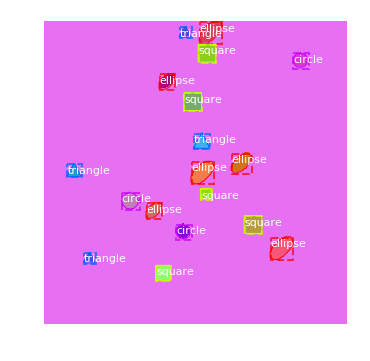

Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  251.00000  uint8
image_meta (17,) [  0 256 256   3 256 256   3   0   0 256 256   1   0   0   0   0   0]
(1, 17)
molded_images            shape: (1, 256, 256, 3)      min: -107.80000  max:  140.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


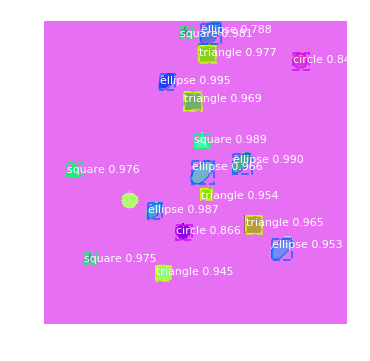

In [7]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
# image_id=33
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances2(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(6, 6))

#######
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances2(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(6, 6))

original_image           shape: (256, 256, 3)         min:    2.00000  max:  253.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max:  256.00000  int64
gt_class_id              shape: (26,)                 min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (26, 4)               min:    4.00000  max:  253.00000  int32
gt_mask                  shape: (256, 256, 26)        min:    0.00000  max:    1.00000  bool


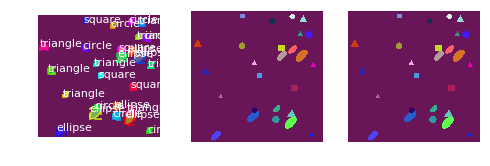

In [12]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
# image_id=33
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))


In [14]:
gt_class_id

array([2, 3, 4, 4, 2, 2, 3, 2, 4, 3, 3, 4, 2, 3, 4, 4, 4, 3, 2, 1, 2, 2,
       1, 2, 1, 3, 2], dtype=int32)

In [11]:
r['class_ids']

array([], dtype=int32)

In [16]:
# r['rois']

Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  253.00000  uint8
image_meta (17,) [  0 256 256   3 256 256   3   0   0 256 256   1   0   0   0   0   0]
(1, 17)
molded_images            shape: (1, 256, 256, 3)      min: -114.80000  max:  146.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


<IPython.core.display.Javascript object>


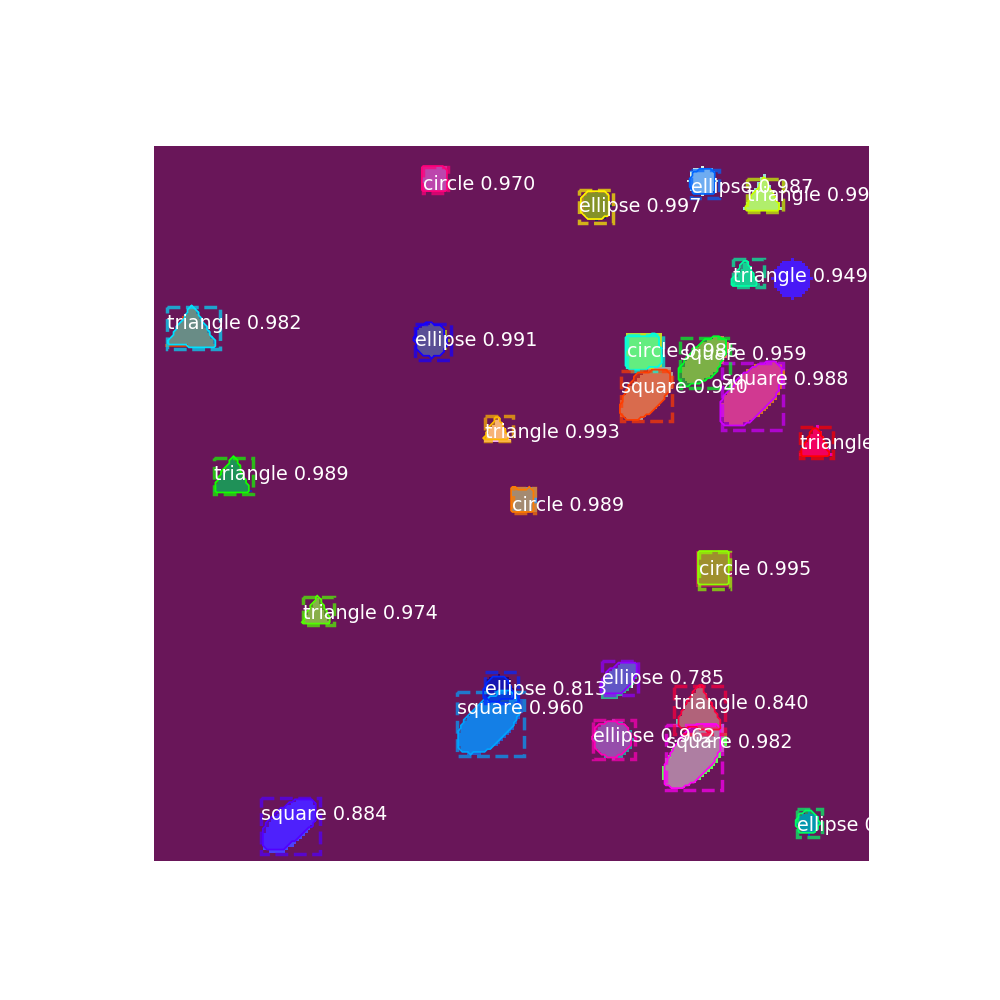

In [13]:
%matplotlib notebook
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances2(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [30]:
results

[{'rois': array([], shape=(0, 4), dtype=int32),
  'class_ids': array([], dtype=int32),
  'scores': array([], dtype=float32),
  'masks': array([], shape=(128, 128, 0), dtype=float64)}]

In [60]:
# results

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.95


In [ ]:
Function for classification loss
def mrcnn_class_loss_graph(target_class_ids, pred_class_logits,
                           active_class_ids):
    """Loss for the classifier head of Mask RCNN.

    target_class_ids: [batch, num_rois]. Integer class IDs. Uses zero
        padding to fill in the array.
    pred_class_logits: [batch, num_rois, num_classes]
    active_class_ids: [batch, num_classes]. Has a value of 1 for
        classes that are in the dataset of the image, and 0
        for classes that are not in the dataset.

In [ ]:
class_loss = KL.Lambda(lambda x: mrcnn_class_loss_graph(*x), name="mrcnn_class_loss")(
    [target_class_ids, mrcnn_class_logits, active_class_ids])

In [ ]:
rois, target_class_ids, target_bbox, target_mask =\
    DetectionTargetLayer(config, name="proposal_targets")([
        target_rois, input_gt_class_ids, gt_boxes, input_gt_masks])

In [ ]:
class DetectionTargetLayer(KE.Layer):
    """Subsamples proposals and generates target box refinement, class_ids,
    and masks for each.

    Inputs:
    proposals: [batch, N, (y1, x1, y2, x2)] in normalized coordinates. Might
               be zero padded if there are not enough proposals.
    gt_class_ids: [batch, MAX_GT_INSTANCES] Integer class IDs.
    gt_boxes: [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)] in normalized
              coordinates.
    gt_masks: [batch, height, width, MAX_GT_INSTANCES] of boolean type

    Returns: Target ROIs and corresponding class IDs, bounding box shifts,
    and masks.
    rois: [batch, TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)] in normalized
          coordinates
    target_class_ids: [batch, TRAIN_ROIS_PER_IMAGE]. Integer class IDs.
    target_deltas: [batch, TRAIN_ROIS_PER_IMAGE, (dy, dx, log(dh), log(dw)]
    target_mask: [batch, TRAIN_ROIS_PER_IMAGE, height, width]
                 Masks cropped to bbox boundaries and resized to neural
                 network output size.

    Note: Returned arrays might be zero padded if not enough target ROIs.
    """

In [ ]:
I want to manipulate conversion of "gt_class_ids" to "target_class_ids"\
in the above function for clustering samples and reassign the labels 

In [16]:
# import tensorflow as tf
from tensorflow.contrib.factorization import KMeans

/home/marziehhaghighi/.local/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Change:
mrcnn_class_logits, mrcnn_class, mrcnn_bbox =\
fpn_classifier_graph(rois, mrcnn_feature_maps, input_image_meta,
                     config.POOL_SIZE, config.NUM_CLASSES,
                     train_bn=config.TRAIN_BN,
                     fc_layers_size=config.FPN_CLASSIF_FC_LAYERS_SIZE)

In [ ]:
# ------------------------------------------
# TensorFlow Implementation for kmeans
# ------------------------------------------
# Extract the features from the training data
feats = tf.contrib.learn.infer_real_valued_columns_from_input(x_train)
# Building a 3-layer DNN with 50 units each.
classifier_tf = tf.contrib.learn.DNNClassifier(feature_columns=feats, 
                                               hidden_units=[50, 50, 50], 
                                               n_classes=3)
# Use the train data to train this classifier
classifier_tf.fit(x_train, y_train, steps=5000)
# Use the trained model to predict on the test data
predictions = list(classifier_tf.predict(x_test, as_iterable=True))
score = metrics.accuracy_score(y_test, predictions)

In [22]:
tf.contrib.learn.infer_real_valued_columns_from_input

<function tensorflow.contrib.learn.python.learn.estimators.estimator.infer_real_valued_columns_from_input(x)>

In [ ]:
kmeans = tf.contrib.factorization.KMeans(
  inp,
  num_clusters,
  distance_metric=tf.contrib.factorization.COSINE_DISTANCE,
  # TODO(agarwal): kmeans++ is currently causing crash in dbg mode.
  # Enable this after fixing.
  # initial_clusters=tf.contrib.factorization.KMEANS_PLUS_PLUS_INIT,
  use_mini_batch=True)

all_scores, _, clustering_scores, kmeans_training_op = kmeans.training_graph()

In [26]:
tf.contrib.learn.KMeans

AttributeError: module 'tensorflow.contrib.learn' has no attribute 'KMeans'

In [27]:
tf.contrib.factorization.KMeansClustering

tensorflow.contrib.factorization.python.ops.kmeans.KMeansClustering

In [4]:
k = 5
n = 100
variables = 2
points = np.random.uniform(0, 1000, [n, variables])
input_fn=lambda: tf.train.limit_epochs(tf.convert_to_tensor(points, dtype=tf.float32), num_epochs=1)
kmeans=tf.contrib.factorization.KMeansClustering(num_clusters=k, use_mini_batch=False)
previous_centers = None
# for _ in range(10):
kmeans.train(input_fn)
centers = kmeans.cluster_centers()
#   if previous_centers is not None:
#     print 'delta:', centers - previous_centers
#   previous_centers = centers
#   print 'score:', kmeans.score(input_fn)
# print 'centers:', centers
cluster_indices = list(kmeans.predict_cluster_index(input_fn))
for i, point in enumerate(points):
    cluster_index = cluster_indices[i]
#   print 'point:', point, 'is in cluster', cluster_index, 'centered at', centers[cluster_index]

NameError: name 'tf' is not defined

In [41]:
len(cluster_indices)

100

In [47]:
testT=tf.convert_to_tensor(points, dtype=tf.float32)
testT

<tf.Tensor 'Const_4:0' shape=(100, 2) dtype=float32>

In [53]:
tf.reshape(
    testT, (testT.shape[1],testT.shape[0]), name=None
)

<tf.Tensor 'Reshape_7:0' shape=(2, 100) dtype=float32>

Dimension(100)

# Clustering details:
- test both of the following, when doing clustering at each iteration:
    - Predict based on random initialization at first at the first iteration, then for the next one instialize clusters based on predictions 
    - At each iteration permute labels so that it has the minimum hamming distance to the predicted ones 

In [18]:
cost = np.array([[4, 1, 3],
                 [2, 0, 5],
                 [3, 2, 2],
                 [3, 2, 2]])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(cost)
col_ind


array([1, 0, 2])

In [17]:
Input Shape (8, 32, 1024)

array([1, 3, 4])

In [ ]:
X=np.array([[[1,1,1],[2,2,2],[3,3,3]],
           [[4,4,4],[5,5,5],[6,6,6]],
           [[7,7,7],[8,8,8],[9,9,9]],
           [[10,10,10],[11,11,11],[12,12,12]]])

In [28]:
X1=np.array([[1,2,3],
           [4,5,6],
           [7,8,9],
           [10,11,12]])




In [30]:
X1.flatten()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [26]:
X.shape

(4, 3, 3)

In [27]:
X.reshape([12,3])

array([[ 1,  1,  1],
       [ 2,  2,  2],
       [ 3,  3,  3],
       [ 4,  4,  4],
       [ 5,  5,  5],
       [ 6,  6,  6],
       [ 7,  7,  7],
       [ 8,  8,  8],
       [ 9,  9,  9],
       [10, 10, 10],
       [11, 11, 11],
       [12, 12, 12]])

In [16]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0],[10, 2], [10, 4], [10, 0]])
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
# kmeans.labels_
# array([1, 1, 1, 0, 0, 0], dtype=int32)
# kmeans.predict([[0, 0], [12, 3]])
# array([1, 0], dtype=int32)
cents=kmeans.cluster_centers_
cents

array([[10.,  3.],
       [ 1.,  2.],
       [10.,  0.]])

In [42]:
from numpy import linalg as LA
np.argmin(LA.norm(cents-[10,0],1,axis=1))

2

In [19]:
list(kmeans.labels_).remove(0)

In [23]:
b=list(kmeans.labels_)
b.remove(0)
b

[1, 1, 1, 0, 2]

In [22]:
b